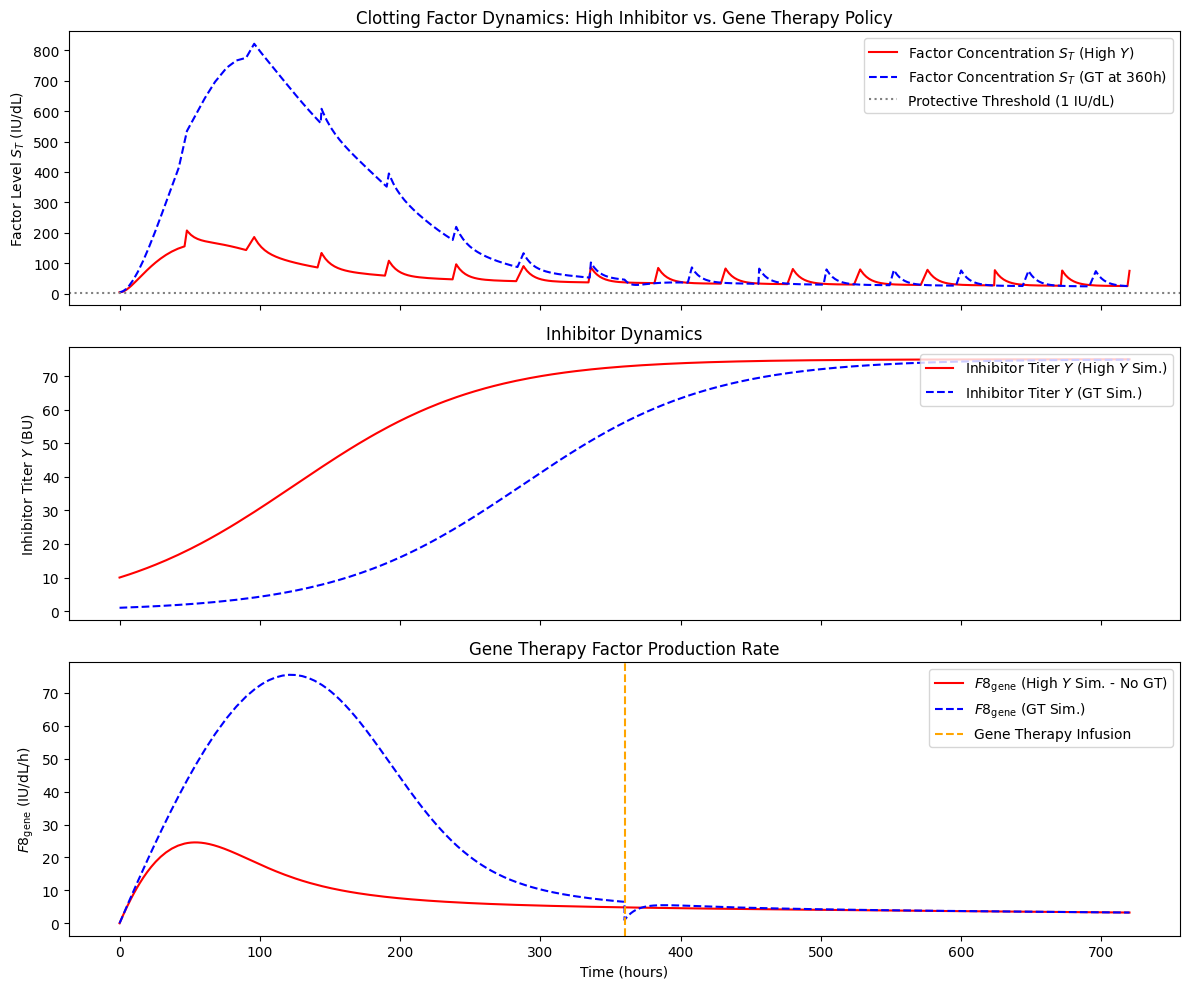

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- 1. Model Parameters (Placeholder Values from Text Analysis) ---

# All parameters are placeholders, as specific values are not provided
# in the text, but their dimensions and roles are defined.
# S_T: IU/dL; Y: BU (Bethesda Units); t: hours.

class ClottingFactorParameters:
    def __init__(self):
        # Clotting Factor (S_T) Dynamics (Eq 5, 6, 7, 8)
        self.V_max = 0.0 # Max saturable infusion rate (IU/dL/h) - set to 0 for impulse model
        self.K_m = 10.0  # Half-saturation constant (IU/dL)
        self.alpha = 0.1   # Factor neutralization coefficient (1/h)
        self.K_I = 5.0   # Half-effect concentration (BU)
        self.beta = 2.5  # Hill coefficient for non-linear inhibition (>1)
        self.gamma = 0.5   # Max VWF stabilization rate (IU/dL/h)
        self.K_h = 5.0   # Half-saturation constant (IU/dL)
        self.n = 2.0     # Hill coefficient for VWF stabilization
        self.lambda_ST = 0.05 # Physiological degradation/clearance (1/h)
        self.VWF_Z = 100.0 # VWF Concentration (Z) - treated as a constant input

        # Inhibitor (Y) Dynamics (Eq 11)
        self.rho = 0.02  # Inhibitor proliferation rate (1/h)
        self.Y_max = 100.0 # Max inhibitor titer (BU)
        self.S_T_crit = 1.0 # Factor crit. for proliferation activation (IU/dL)
        self.kappa = 0.01  # ITI suppression efficacy (1/h per ITI intensity unit)
        self.lambda_Y = 0.005 # Inhibitor natural decay (1/h)
        self.I_ITI = 0.0   # ITI Control Intensity - treated as a constant input (e.g., 0 or 10)

        # Gene Therapy (F8_gene) Dynamics (Eq 12)
        self.A = 1.0     # Initial GT expression burst magnitude (IU/dL/h)
        self.gamma_GT = 0.001 # GT expression decay rate (1/h)
        self.eta = 0.002 # Inhibitor neutralization of expressed protein (1/h per BU)

        # External Control / Policy Inputs (Simplified)
        # Note: The 'T' term (infusion rate) is handled by the impulse function for bolus dosing.
        # Set to 0.0 for the continuous ODE part.
        self.T = 0.0

# --- 2. The Coupled Dynamical System ODE Function ---

def clotting_factor_system(t, X, params):
    """
    The RHS of the coupled ODE system dX/dt = f(X, t)
    X = [S_T, Y, F8_gene]
    """
    S_T, Y, F8_gene = X

    # --- Auxiliary Functions (Eq 6, 7, 8) ---

    # Infusion / Drug Input (f(T)): Michaelis-Menten kinetics
    # T is the dose concentration (rate). Assumed T=0 for continuous phase.
    f_T = (params.V_max * params.T) / (params.K_m + params.T)

    # Inhibitor Neutralization (g(Y, S_T)): Titer-dependent
    g_Y_ST = params.alpha * S_T * (Y**params.beta) / (params.K_I**params.beta + Y**params.beta)

    # VWF Stabilization (h(Z)): Hill-type cooperative stabilization
    h_Z = params.gamma * (params.VWF_Z**params.n) / (params.K_h**params.n + params.VWF_Z**params.n)

    # --- 1. Clotting Factor Dynamics (dS_T/dt) (Eq 13) ---
    dS_T_dt = (
        f_T                    # Exogenous infusion (usually 0, handled by impulse)
        + F8_gene              # Endogenous GT production
        - g_Y_ST               # Inhibitor neutralization/consumption
        + h_Z                  # VWF-dependent stabilization
        - params.lambda_ST * S_T # Physiological clearance
    )

    # Ensure factor concentration does not become negative
    if S_T < 0:
        dS_T_dt = max(0, dS_T_dt)

    # --- 2. Inhibitor Dynamics (dY/dt) (Eq 11) ---

    # Indicator function for proliferation activation (II(S_T >= S_T_crit))
    proliferation_active = 1.0 if S_T >= params.S_T_crit else 0.0

    # ITI suppression term
    iti_suppression = params.kappa * params.I_ITI * Y

    dY_dt = (
        params.rho * Y * (1 - Y / params.Y_max) * proliferation_active # Density-dep. proliferation
        - iti_suppression                                            # ITI-induced suppression
        - params.lambda_Y * Y                                        # Natural decay
    )

    # Ensure inhibitor titer does not become negative
    if Y < 0:
        dY_dt = max(0, dY_dt)

    # --- 3. Gene Therapy Factor Dynamics (dF8_gene/dt) (Eq 12) ---

    # Transgene expression decay (A * exp(-gamma_GT * t))
    expression_decay = params.A * np.exp(-params.gamma_GT * t)

    # Inhibitor-mediated neutralization/suppression of expressed protein
    neutralization_loss = params.eta * Y * F8_gene

    dF8_gene_dt = expression_decay - neutralization_loss

    # Ensure production rate does not become negative
    if F8_gene < 0:
        dF8_gene_dt = max(0, dF8_gene_dt)

    return [dS_T_dt, dY_dt, dF8_gene_dt]


# --- 3. Simulation Function with Impulsive Dosing ---

def simulate_hemophilia_treatment(params, initial_conditions, t_span, infusion_schedule=None, bolus_dose=0.0):
    """
    Simulates the coupled system with optional discrete bolus infusions.

    :param params: ClottingFactorParameters object.
    :param initial_conditions: Initial [S_T, Y, F8_gene] at t=0.
    :param t_span: (t_start, t_end) for the simulation (hours).
    :param infusion_schedule: List of times (hours) for bolus infusions.
    :param bolus_dose: Magnitude of factor increase (IU/dL) per infusion.
    :return: time points (T), and solution matrix (S_T, Y, F8_gene).
    """

    if infusion_schedule is None:
        infusion_schedule = []

    t_start, t_end = t_span

    # Time points including the start and end, and all infusion times
    all_time_points = sorted(list(set([t_start, t_end] + infusion_schedule)))

    # Store results
    T_all = []
    Sol_all = []

    # Initial state
    current_state = np.array(initial_conditions)

    # Iterate through time segments between infusions
    for i in range(len(all_time_points) - 1):
        t0 = all_time_points[i]
        tf = all_time_points[i+1]

        # 1. Simulate the continuous dynamics between t0 and tf
        sol = solve_ivp(
            clotting_factor_system,
            (t0, tf),
            current_state,
            args=(params,),
            dense_output=True,
            method='RK45',
            rtol=1e-6, atol=1e-6
        )

        # Store the solution (excluding the last point, which is the start of the next interval)
        if sol.t.size > 0:
            T_all.append(sol.t[:-1])
            Sol_all.append(sol.y.T[:-1, :])

        # 2. Update the state (impulse/bolus dose) at time tf
        current_state = sol.y[:, -1]

        # Check if tf is an infusion time
        if tf in infusion_schedule:
            # Bolus infusion instantaneously increases S_T
            current_state[0] += bolus_dose

        # Store the state at tf (after potential bolus)
        T_all.append(np.array([tf]))
        Sol_all.append(current_state.reshape(1, -1))

    # Concatenate all segments
    T_final = np.concatenate(T_all)
    Sol_final = np.concatenate(Sol_all, axis=0)

    return T_final, Sol_final[:, 0], Sol_final[:, 1], Sol_final[:, 2]

# --- 4. Example Usage and Visualization ---

# Define a scenario: Patient on prophylactic infusions with high inhibitor titer.
P = ClottingFactorParameters()

# Scenario modification: Patient has high inhibitor titer and is NOT on ITI
P.K_I = 2.0  # Inhibitor half-saturation is low (high sensitivity)
P.beta = 3.0 # Highly non-linear inhibition (threshold-like)
P.I_ITI = 0.0 # No Immune Tolerance Induction

# Initial conditions: [S_T(0), Y(0), F8_gene(0)]
initial_state = [5.0, 10.0, 0.0] # 5 IU/dL factor, 10 BU inhibitor, no GT yet

# Simulation time: 30 days (720 hours)
t_span = (0, 720)

# Treatment: Prophylactic infusion of 50 IU/dL every 48 hours
infusion_schedule = np.arange(0, t_span[1] + 48, 48).tolist()
bolus_dose = 50.0 # Instantaneous factor jump (approximating bolus PK)

# --- Run the Simulation ---
T, ST, Y, F8G = simulate_hemophilia_treatment(
    P,
    initial_state,
    t_span,
    infusion_schedule=infusion_schedule,
    bolus_dose=bolus_dose
)

# --- Policy/Intervention Example (Adding Gene Therapy at t=360h) ---
P_GT = ClottingFactorParameters()
P_GT.beta = 3.0
P_GT.lambda_ST = 0.06 # Faster clearance

# Initial conditions (before GT):
initial_state_gt = [5.0, 1.0, 0.0] # Low inhibitor patient

# First phase (No GT, Only Infusion)
T1, ST1, Y1, F8G1 = simulate_hemophilia_treatment(
    P_GT,
    initial_state_gt,
    (0, 360),
    infusion_schedule=np.arange(0, 360, 48).tolist(),
    bolus_dose=50.0
)

# Second phase (GT administered at t=360h)
# The F8_gene state is now active, so the RHS dF8_gene/dt starts with a production burst (A)
initial_state_phase2 = [ST1[-1], Y1[-1], P_GT.A] # ST and Y from Phase 1 end, F8_gene initial rate is A

T2, ST2, Y2, F8G2 = simulate_hemophilia_treatment(
    P_GT,
    initial_state_phase2,
    (360, 720),
    infusion_schedule=np.arange(360 + 48, 720, 48).tolist(),
    bolus_dose=50.0 # Prophylaxis continues but is expected to stop later
)

# Combine results
T_GT = np.concatenate([T1, T2])
ST_GT = np.concatenate([ST1, ST2])
Y_GT = np.concatenate([Y1, Y2])
F8G_GT = np.concatenate([F8G1, F8G2])


# --- Plotting the Results ---

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Factor Concentration (S_T) - Scenario 1 (High Inhibitor)
axs[0].plot(T, ST, label=r'Factor Concentration $S_T$ (High $Y$)', color='red')
axs[0].plot(T_GT, ST_GT, label=r'Factor Concentration $S_T$ (GT at 360h)', color='blue', linestyle='--')
axs[0].axhline(y=1.0, color='gray', linestyle=':', label='Protective Threshold (1 IU/dL)')
axs[0].set_ylabel(r'Factor Level $S_T$ (IU/dL)')
axs[0].set_title('Clotting Factor Dynamics: High Inhibitor vs. Gene Therapy Policy')
axs[0].legend(loc='upper right')

# 2. Inhibitor Titer (Y)
axs[1].plot(T, Y, label=r'Inhibitor Titer $Y$ (High $Y$ Sim.)', color='red')
axs[1].plot(T_GT, Y_GT, label=r'Inhibitor Titer $Y$ (GT Sim.)', color='blue', linestyle='--')
axs[1].set_ylabel(r'Inhibitor Titer $Y$ (BU)')
axs[1].set_title('Inhibitor Dynamics')
axs[1].legend(loc='upper right')

# 3. Gene Therapy Factor Production (F8_gene)
axs[2].plot(T, F8G, label=r'$F8_{\text{gene}}$ (High $Y$ Sim. - No GT)', color='red')
axs[2].plot(T_GT, F8G_GT, label=r'$F8_{\text{gene}}$ (GT Sim.)', color='blue', linestyle='--')
axs[2].axvline(x=360, color='orange', linestyle='--', label='Gene Therapy Infusion')
axs[2].set_xlabel('Time (hours)')
axs[2].set_ylabel(r'$F8_{\text{gene}}$ (IU/dL/h)')
axs[2].set_title('Gene Therapy Factor Production Rate')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

--- 1. Deterministic ODE Simulation ---
Final deterministic state X(20): 9.27

--- 2. Stochastic SDE Simulation (Single Patient) ---
Final stochastic state X(20): 10.25

--- 3. Population-Level SDE Cohort Simulation ---
Final cohort mean X(20): 9.62
Final cohort variance Var[X](20): 11.00
Final H_potential (Individual 5): 5.80
Final H_potential (Cohort Mean): 8.16


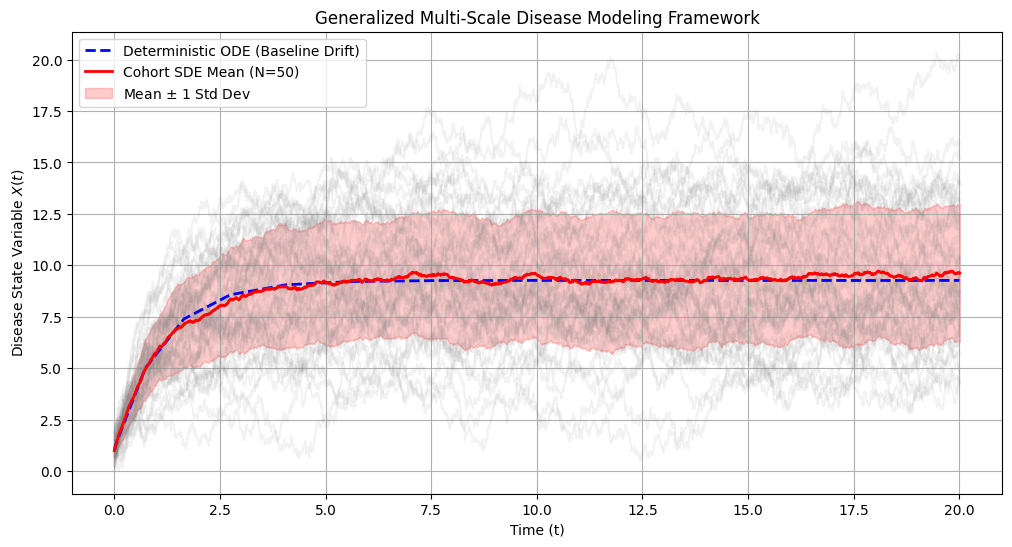

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- 1. NON-LINEAR BIOLOGICAL MECHANISMS (Core Functions) ---

def saturable_treatment_f(T, Vmax, Km):
    """
    Saturable Treatment term f(T) - Michaelis-Menten Kinetics.
    Models drug absorption and receptor saturation.

    T: Treatment concentration or dose.
    Vmax: Maximum rate of treatment effect.
    Km: Concentration at which the rate is half Vmax (Michaelis constant).
    """
    return Vmax * T / (Km + T)

def cooperative_stabilization_h(Z, Kd, n):
    """
    Cooperative Stabilization term h(Z) - Hill Function.
    Models sigmoidal dynamics and cooperative binding (e.g., VWF stabilizing Factor VIII).

    Z: Concentration of stabilizing factor.
    Kd: Half-maximal effective concentration.
    n: Hill coefficient (cooperativity, n > 1 implies positive cooperativity).
    """
    return Z**n / (Kd**n + Z**n)

def bilinear_inhibition_g(Y, X, k_inh):
    """
    Bilinear Inhibition term g(Y, X).
    Models multiplicative interaction between disease state (X) and inhibitor (Y).

    Y: Inhibitor/Immune effector concentration.
    X: Disease state variable (e.g., pathogen load, factor consumption).
    k_inh: Rate constant for inhibition efficiency.
    """
    return k_inh * Y * X

# --- 2. UNIVERSAL DETERMINISTIC FRAMEWORK (ODE) ---

class GeneralizedDiseaseModel:
    """
    Implements the Universal Deterministic ODE structure.
    dX/dt = f(T) - g(Y, X) + h(Z) - k_elim*X
    """
    def __init__(self, params):
        """
        params is a dictionary of all model parameters.
        Example params:
            {'Vmax': 10, 'Km': 5, 'Kd': 2, 'n': 3, 'k_inh': 0.1, 'k_elim': 0.5, 'S_T': 1.0}
        """
        self.params = params

    def ode_system(self, t, X, T, Y, Z):
        """
        The core ODE function dX/dt.

        t: Time (s)
        X: State variable (e.g., Factor VIII level, Health Status)
        T: Treatment variable (assumed constant or provided by a time-series)
        Y: Inhibitor variable (assumed constant or provided by a time-series)
        Z: Stabilizing/Recovery variable (assumed constant or provided by a time-series)
        """
        p = self.params

        # Treatment Term: Saturable, Modulated by Sensitivity S_T
        # S_T is the personalized treatment sensitivity multiplier
        f_T = saturable_treatment_f(T, p['Vmax'], p['Km']) * p['S_T']

        # Inhibition Term: Bilinear
        g_YX = bilinear_inhibition_g(Y, X, p['k_inh'])

        # Recovery/Stabilization Term: Cooperative
        h_Z = cooperative_stabilization_h(Z, p['Kd'], p['n'])

        # Elimination Term
        k_elimX = p['k_elim'] * X

        dXdt = f_T - g_YX + h_Z - k_elimX
        return dXdt

    def solve_ode(self, X0, t_span, T_val, Y_val, Z_val):
        """
        Solves the ODE over a time span.

        X0: Initial state of X.
        t_span: [t_start, t_end].
        T_val, Y_val, Z_val: Constant values for the auxiliary variables.
        """
        # The ODE solver requires the function to take X first, then t, and then args.
        # We wrap the main system function to match the signature required by solve_ivp.
        def wrapped_ode(t, X):
            # X[0] is used because solve_ivp expects an array of state variables
            return self.ode_system(t, X[0], T_val, Y_val, Z_val)

        # We need X to be an array for solve_ivp, even if it's a scalar.
        solution = solve_ivp(
            wrapped_ode,
            t_span,
            np.array([X0]),
            dense_output=True,
            method='RK45'
        )
        return solution.t, solution.y[0]

# --- 3. STOCHASTIC EXTENSION (SDE - Euler-Maruyama) ---

def euler_maruyama_sde(model, X0, T_val, Y_val, Z_val, t_span, dt, sigma_X):
    """
    Numerically solves the SDE using the Euler-Maruyama scheme.
    dX = (drift) dt + sigma_X * dW_t

    model: An instance of GeneralizedDiseaseModel.
    X0: Initial state of X.
    t_span: [t_start, t_end].
    dt: Time step size.
    sigma_X: Volatility term (assumed constant for simplicity in this example).
    """
    time_points = np.arange(t_span[0], t_span[1] + dt, dt)
    n_steps = len(time_points)
    X = np.zeros(n_steps)
    X[0] = X0

    # Wiener process increments (dWt) - generated upfront for efficiency
    # dWt = sqrt(dt) * N(0, 1)
    dWt_increments = np.random.normal(0.0, np.sqrt(dt), size=n_steps - 1)

    for i in range(n_steps - 1):
        t = time_points[i]
        Xi = X[i]

        # Drift term: The deterministic component (the ODE function)
        drift = model.ode_system(t, Xi, T_val, Y_val, Z_val)

        # Stochastic term: sigma * dWt
        stochastic_term = sigma_X * dWt_increments[i]

        # Euler-Maruyama update: X(t+dt) = X(t) + drift*dt + stochastic_term
        X[i+1] = X[i] + drift * dt + stochastic_term

        # Ensure state variable remains non-negative (e.g., if X is a concentration)
        X[i+1] = max(0, X[i+1])

    return time_points, X

# --- 4. POPULATION-LEVEL SCALING (Cohort Simulation) ---

def run_cohort_sde_simulation(N_cohort, t_span, dt, T_base, Y_base, Z_base,
                              base_params, param_std, X0_base, sigma_base):
    """
    Simulates a cohort of N individuals with heterogeneous parameters.

    N_cohort: Number of individuals.
    param_std: Standard deviation for parameter perturbation (e.g., {'k_elim': 0.1}).
    """
    cohort_trajectories = []

    # Simulate each individual
    for i in range(N_cohort):
        # Introduce heterogeneity by perturbing parameters (Inter-individual variability)
        individual_params = base_params.copy()
        for key, std in param_std.items():
            # Draw from a normal distribution around the base parameter value
            individual_params[key] = np.random.normal(base_params[key], std)
            # Ensure positive parameters
            individual_params[key] = max(1e-6, individual_params[key])

        # Individual treatment sensitivity (S_T) calculation - placeholder for precision medicine
        # S_T = f({G_i}, {I_j}, Env Modifiers)
        # For this example, S_T is a random variable around the base S_T (1.0)
        individual_params['S_T'] = np.random.normal(individual_params['S_T'], 0.2)
        individual_params['S_T'] = max(0.1, individual_params['S_T'])

        # Initial state heterogeneity
        X0_i = np.random.normal(X0_base, 0.5)

        # Volatility heterogeneity
        sigma_X_i = np.random.normal(sigma_base, 0.1)
        sigma_X_i = max(1e-6, sigma_X_i)

        # Create and solve the individual SDE
        individual_model = GeneralizedDiseaseModel(individual_params)
        time, trajectory = euler_maruyama_sde(
            individual_model, X0_i, T_base, Y_base, Z_base, t_span, dt, sigma_X_i
        )
        cohort_trajectories.append(trajectory)

    # Convert to numpy array for easy analysis
    cohort_array = np.array(cohort_trajectories)

    # Calculate population-level metrics
    # \overline{X}(t) and Var[X](t)
    mean_X = np.mean(cohort_array, axis=0)
    var_X = np.var(cohort_array, axis=0)

    return time, cohort_array, mean_X, var_X

# --- 5. INTEGRATION WITH THE H_potential METRIC ---

def calculate_h_potential(X_t, X_mean_t, Q_t, S_t, B_t, comorbidities=0, age=40):
    """
    Integration with the H_potential Metric.
    H_potential(t) = L(t) * Q(t) * S(t) - B(t)
    L(t) = phi(X(t), X_bar(t), comorbidities, age)

    This is a conceptual placeholder for the health metric.
    """
    # Dynamic Biomedical Potential L(t) - Placeholder function phi
    # Assume L is proportional to X, but penalized by comorbidities and age.
    # The term X_mean_t links the individual outcome X_t to the cohort context (population scaling).
    L_t = (X_t + X_mean_t) / 2.0  # Simple L function, incorporates X and X_bar
    L_t = L_t * (1 - 0.01 * comorbidities) * (1 - 0.005 * age) # Penalize by risk factors

    # H_potential calculation
    H_potential_t = L_t * Q_t * S_t - B_t

    return H_potential_t

# --- 6. EXECUTION AND VISUALIZATION ---

if __name__ == '__main__':
    # Set a random seed for reproducibility of stochastic results
    np.random.seed(42)

    # ----------------------------------------
    # I. Deterministic ODE Example
    # ----------------------------------------
    print("--- 1. Deterministic ODE Simulation ---")

    base_params = {
        'Vmax': 10.0,      # Max treatment rate
        'Km': 2.0,         # Treatment half-saturation
        'Kd': 5.0,         # Stabilization half-saturation
        'n': 3.0,          # Hill coefficient (cooperativity)
        'k_inh': 0.1,      # Inhibition rate constant
        'k_elim': 0.8,     # Elimination/Decay rate
        'S_T': 1.0         # Baseline Treatment Sensitivity
    }

    model_ode = GeneralizedDiseaseModel(base_params)
    X0_ode = 1.0
    t_span_ode = [0, 20]

    # Auxiliary variables assumed constant for simplicity
    T_val = 10.0 # High Treatment (T)
    Y_val = 1.0  # Moderate Inhibitor (Y)
    Z_val = 1.0  # Moderate Stabilizer (Z)

    t_ode, X_ode = model_ode.solve_ode(X0_ode, t_span_ode, T_val, Y_val, Z_val)

    print(f"Final deterministic state X(20): {X_ode[-1]:.2f}")

    # ----------------------------------------
    # II. Stochastic SDE Single-Patient Example
    # ----------------------------------------
    print("\n--- 2. Stochastic SDE Simulation (Single Patient) ---")

    dt = 0.01
    sigma_X = 1.5 # Volatility term (scales dW_t)
    X0_sde = X0_ode
    t_span_sde = [0, 20]

    t_sde, X_sde_single = euler_maruyama_sde(
        model_ode, X0_sde, T_val, Y_val, Z_val, t_span_sde, dt, sigma_X
    )

    print(f"Final stochastic state X(20): {X_sde_single[-1]:.2f}")

    # ----------------------------------------
    # III. Population-Level (Cohort) Simulation
    # ----------------------------------------
    print("\n--- 3. Population-Level SDE Cohort Simulation ---")

    N_cohort = 50
    param_std_heterogeneity = {
        'k_elim': 0.15, # Variation in elimination rate
        'Vmax': 1.0,    # Variation in maximum drug efficacy
        'k_inh': 0.05   # Variation in inhibition efficiency
    }

    t_cohort, X_cohort_trajectories, mean_X, var_X = run_cohort_sde_simulation(
        N_cohort, t_span_sde, dt, T_val, Y_val, Z_val,
        base_params, param_std_heterogeneity, X0_sde, sigma_X
    )

    print(f"Final cohort mean X(20): {mean_X[-1]:.2f}")
    print(f"Final cohort variance Var[X](20): {var_X[-1]:.2f}")

    # ----------------------------------------
    # IV. H_potential Metric Calculation (Conceptual)
    # ----------------------------------------
    # Assume constant S (Social), Q (Quality), B (Burden) for simplicity
    Q_t = 1.0
    S_t = 0.9
    B_t = 0.5

    # Calculate H_potential for the 5th individual in the cohort (X_t)
    X_individual_5 = X_cohort_trajectories[4]
    H_potential_5 = calculate_h_potential(
        X_individual_5, mean_X, Q_t, S_t, B_t, comorbidities=2, age=55
    )

    # Calculate H_potential for the cohort mean
    # Setting comorbidities and age to 0 for the cohort mean calculation to represent
    # the 'ideal' population potential before individual risk factors.
    H_potential_mean = calculate_h_potential(
        mean_X, mean_X, Q_t, S_t, B_t, comorbidities=0, age=0
    )

    print(f"Final H_potential (Individual 5): {H_potential_5[-1]:.2f}")
    print(f"Final H_potential (Cohort Mean): {H_potential_mean[-1]:.2f}")

    # ----------------------------------------
    # V. Plotting the Multi-Scale Results
    # ----------------------------------------
    plt.figure(figsize=(12, 6))

    # Plot all stochastic trajectories (low opacity)
    for traj in X_cohort_trajectories:
        plt.plot(t_cohort, traj, color='gray', alpha=0.1)

    # Plot the deterministic and mean SDE trajectories
    plt.plot(t_ode, X_ode, 'b--', label='Deterministic ODE (Baseline Drift)', linewidth=2)
    plt.plot(t_cohort, mean_X, 'r-', label=f'Cohort SDE Mean (N={N_cohort})', linewidth=2)

    # Plot the mean +/- 1 standard deviation for the cohort
    std_X = np.sqrt(var_X)

    # FIX: Use a raw string (r'...') to avoid the SyntaxWarning for \p
    plt.fill_between(t_cohort, mean_X - std_X, mean_X + std_X, color='r', alpha=0.2, label=r'Mean $\pm$ 1 Std Dev')

    plt.title('Generalized Multi-Scale Disease Modeling Framework')
    plt.xlabel('Time (t)')
    plt.ylabel('Disease State Variable $X(t)$')
    plt.legend()
    plt.grid(True)
    plt.show()

# Results

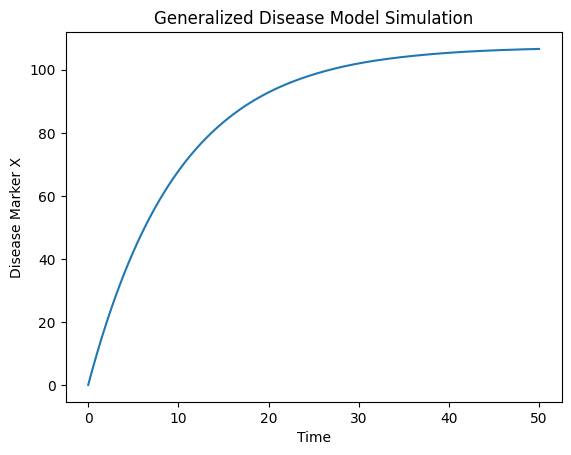

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def disease_model(t, X, params):
    # Unpack parameters
    T, Y, Z = params['T'](t), params['Y'](t), params['Z'](t)  # Time-dependent inputs
    vmax = params['vmax']
    Km = params['Km']
    delta = params['delta']
    etamax = params['etamax']
    Kd = params['Kd']
    n = params['n']
    kelim = params['kelim']

    # Unpack state variable
    x = X[0]

    # Compute terms
    f = vmax * T / (Km + T)
    g = delta * Y * x
    h = etamax * (Z**n) / (Z**n + Kd**n)
    c = kelim * x

    dxdt = f - g + h - c
    return [dxdt]

# Example time-dependent inputs
def treatment(t): return 5.0  # constant dose
def inhibitor(t): return 0.5  # constant inhibitor
def stabilizer(t): return 2.0  # constant stabilizer

params = {
    'T': treatment,
    'Y': inhibitor,
    'Z': stabilizer,
    'vmax': 10.0,
    'Km': 1.0,
    'delta': 0.1,
    'etamax': 3.0,
    'Kd': 1.0,
    'n': 2,
    'kelim': 0.05
}

# Initial condition
X0 = [0.1]

# Solve ODE
t_span = (0, 50)
t_eval = np.linspace(*t_span, 500)
sol = solve_ivp(disease_model, t_span, X0, args=(params,), t_eval=t_eval)

# Plot
plt.plot(sol.t, sol.y[0])
plt.xlabel('Time')
plt.ylabel('Disease Marker X')
plt.title('Generalized Disease Model Simulation')
plt.show()

NIGERIA CASE STUDY DEMONSTRATION

1. Calculating Biomedical Potential...


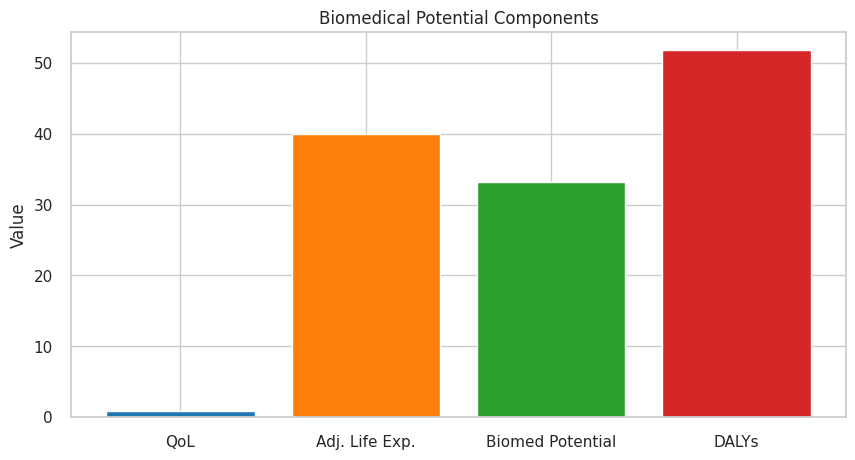


2. Modeling Disease Progression...


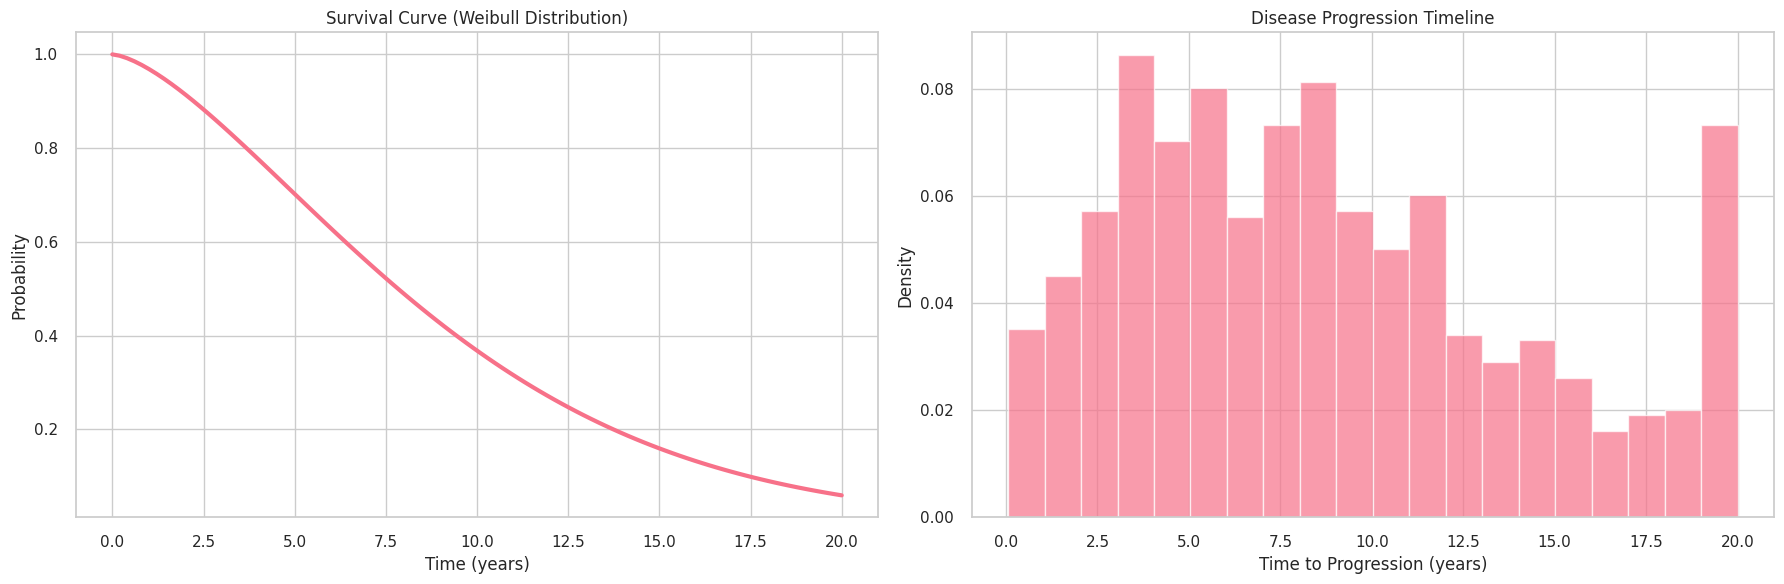

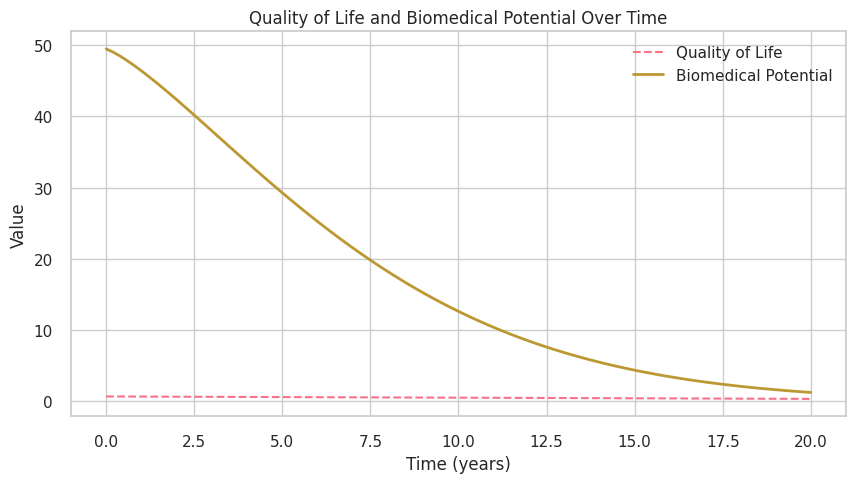


3. Calculating Economic Mobility Loss...


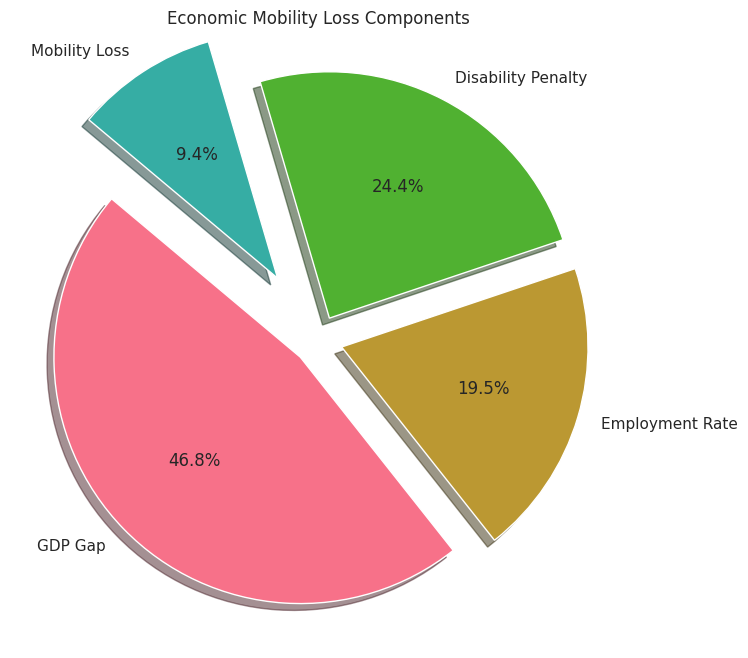

Economic Mobility Loss (M): 0.19 life-years

4. Running Cost-Effectiveness Analysis...


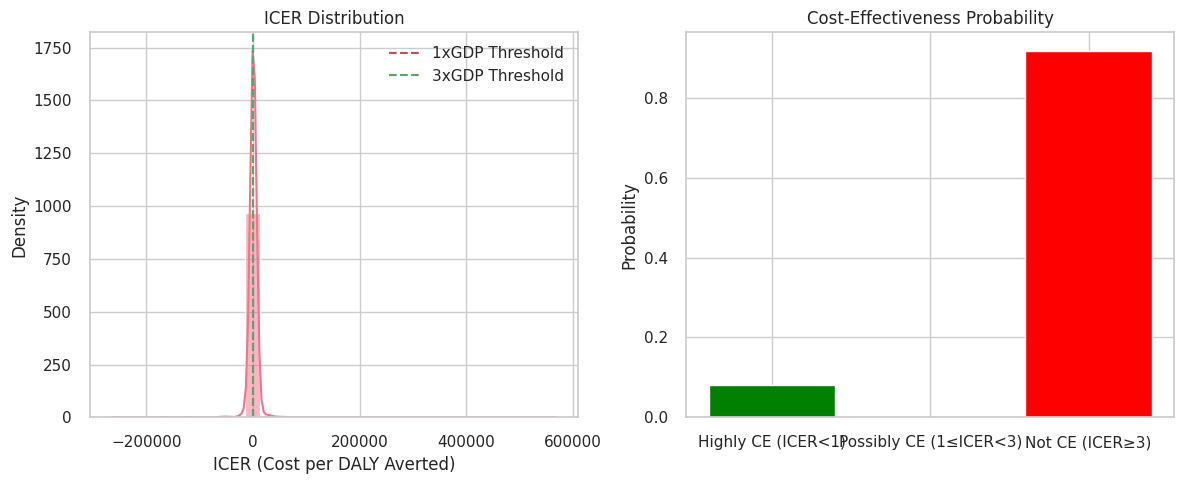

Probability Highly Cost-Effective: 8.2%

5. Computing Health Index (H)...


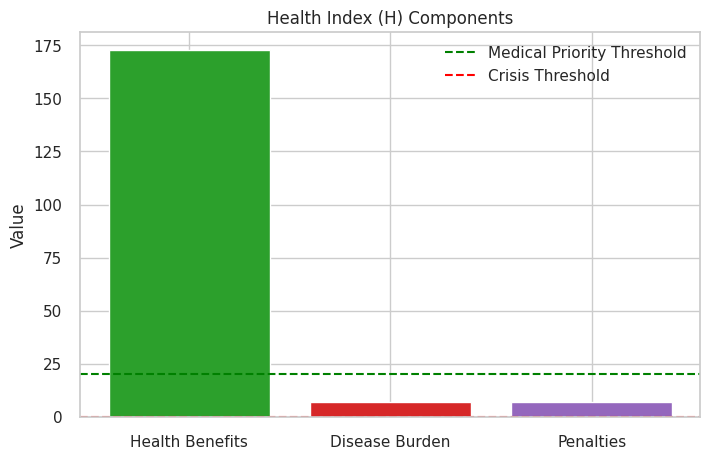

Policy Recommendation: Prioritize medical interventions
Final Health Index (H): 165.45

6. Projecting Population Health...


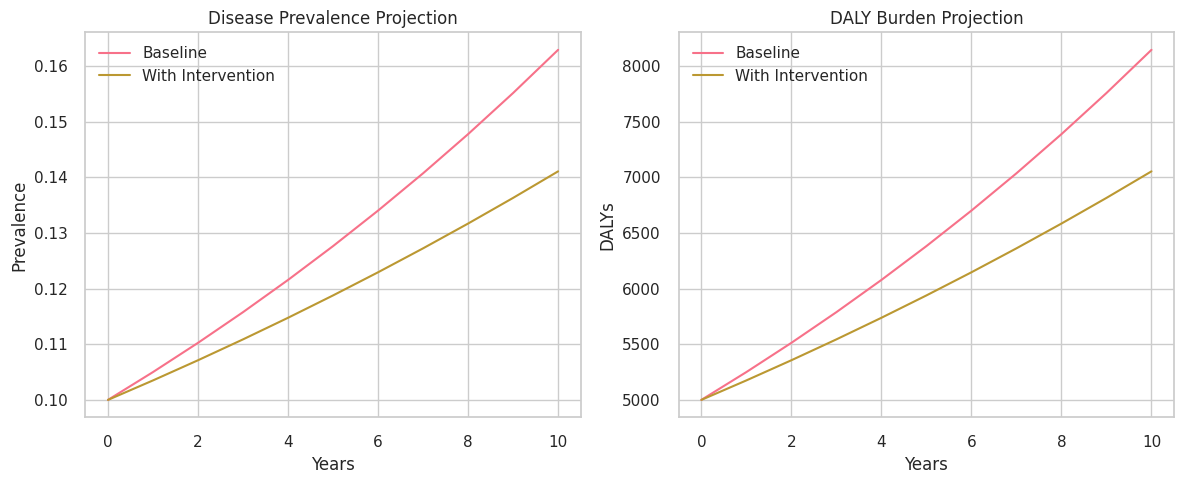

In [ ]:
# @title Biomedical Potential Calculator for Colab
# @markdown This implementation covers all components from the paper with visualizations

import numpy as np
from scipy.stats import weibull_min, norm, uniform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize style - updated to use available styles
plt.style.use('seaborn-v0_8')  # Using the available seaborn style
sns.set_theme(style="whitegrid")  # Updated seaborn theme setting
sns.set_palette("husl")

class BiomedicalPotentialCalculator:
    """
    Complete implementation of the Biomedical Potential framework for Google Colab
    Includes visualization methods for each component
    """

    def __init__(self, L_std=85, lambda_qol=0.34, GDP_ref=50000):
        """Initialize with standard parameters"""
        self.L_std = L_std
        self.lambda_qol = lambda_qol
        self.GDP_ref = GDP_ref

    def calculate_biomedical_potential(self, L_base, severity_weights, disease_severity):
        """Compute Biomedical Potential (LQ) and related metrics with visualization"""
        # Calculations
        Q = 1 - self.lambda_qol * np.mean(severity_weights)
        Q = np.clip(Q, 0, 1)
        L_adj = max(30, L_base - 10 * disease_severity)
        BP = L_adj * Q
        Y_LL = max(0, self.L_std - L_adj)
        Y_LD = L_adj * (1 - Q)
        DALY = Y_LL + Y_LD

        # Visualization
        plt.figure(figsize=(10, 5))
        metrics = ['QoL', 'Adj. Life Exp.', 'Biomed Potential', 'DALYs']
        values = [Q, L_adj, BP, DALY]
        plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        plt.title('Biomedical Potential Components')
        plt.ylabel('Value')
        plt.grid(True)
        plt.show()

        return {'BP': BP, 'Q': Q, 'L_adj': L_adj, 'Y_LL': Y_LL, 'Y_LD': Y_LD, 'DALY': DALY}

    def model_disease_progression(self, disease_params, time_horizon=20, cohort_size=1000):
        """Simulate disease progression with interactive visualization"""
        k, theta = disease_params['shape'], disease_params['scale']

        # Generate survival data
        t = weibull_min.rvs(k, scale=theta, size=cohort_size)
        t = np.clip(t, 0, time_horizon)
        time_points = np.linspace(0, time_horizon, 100)
        S_t = np.exp(-(time_points/theta)**k)
        Q_t = 1 - (self.lambda_qol * disease_params['severity'](time_points))
        L_t = np.maximum(30, self.L_std - 10*disease_params['severity'](time_points))
        BP_t = L_t * Q_t * S_t

        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

        # Survival curve
        ax1.plot(time_points, S_t, label='Survival Probability', linewidth=3)
        ax1.set_title('Survival Curve (Weibull Distribution)')
        ax1.set_xlabel('Time (years)')
        ax1.set_ylabel('Probability')
        ax1.grid(True)

        # Progression histogram
        ax2.hist(t, bins=20, density=True, alpha=0.7, label='Progression Times')
        ax2.set_title('Disease Progression Timeline')
        ax2.set_xlabel('Time to Progression (years)')
        ax2.set_ylabel('Density')
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

        # QoL and BP over time
        plt.figure(figsize=(10, 5))
        plt.plot(time_points, Q_t, label='Quality of Life', linestyle='--')
        plt.plot(time_points, BP_t, label='Biomedical Potential', linewidth=2)
        plt.title('Quality of Life and Biomedical Potential Over Time')
        plt.xlabel('Time (years)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        return {
            'time_points': time_points,
            'survival': S_t,
            'QoL': Q_t,
            'BP': BP_t,
            'progression_times': t
        }

    def calculate_economic_mobility_loss(self, GDP_actual, employment_rate, disability_penalty):
        """Compute and visualize economic mobility loss"""
        GDP_gap = self.GDP_ref - GDP_actual
        M = (GDP_gap / self.GDP_ref) * employment_rate * (1 - disability_penalty)

        # Visualization
        labels = ['GDP Gap', 'Employment Rate', 'Disability Penalty', 'Mobility Loss']
        sizes = [GDP_gap/self.GDP_ref, employment_rate, disability_penalty, M]
        explode = (0.1, 0.1, 0.1, 0.3)

        plt.figure(figsize=(8, 8))
        plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=140)
        plt.title('Economic Mobility Loss Components')
        plt.show()

        return M

    def cost_effectiveness_analysis(self, intervention_cost, standard_cost,
                                  base_DALYs=30, simulations=1000):
        """Run Monte Carlo simulation with visualization"""
        results = []

        for _ in range(simulations):
            Y_ctrl = norm.rvs(loc=base_DALYs, scale=5)
            delta = uniform.rvs(loc=0.7, scale=0.6)
            Y_int = Y_ctrl * 0.8 * delta
            ICER = (intervention_cost - standard_cost) / (Y_ctrl - Y_int) if (Y_ctrl - Y_int) != 0 else np.inf
            results.append(ICER)

        results = np.array(results)
        valid_results = results[np.isfinite(results)]

        # Visualization
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(valid_results, kde=True, bins=30)
        plt.axvline(x=1, color='r', linestyle='--', label='1xGDP Threshold')
        plt.axvline(x=3, color='g', linestyle='--', label='3xGDP Threshold')
        plt.title('ICER Distribution')
        plt.xlabel('ICER (Cost per DALY Averted)')
        plt.ylabel('Density')
        plt.legend()

        plt.subplot(1, 2, 2)
        ce_labels = ['Highly CE (ICER<1)', 'Possibly CE (1≤ICER<3)', 'Not CE (ICER≥3)']
        ce_values = [
            np.mean(results < 1),
            np.mean((results >= 1) & (results < 3)),
            np.mean(results >= 3)
        ]
        plt.bar(ce_labels, ce_values, color=['green', 'yellow', 'red'])
        plt.title('Cost-Effectiveness Probability')
        plt.ylabel('Probability')

        plt.tight_layout()
        plt.show()

        return {
            'ICER_distribution': results,
            'P_highly_CE': ce_values[0],
            'P_possibly_CE': ce_values[1]
        }

    def population_health_forecast(self, current_prevalence, incidence_rate,
                                 DALY_0, intervention_effect, years=10):
        """Project population health with visualization"""
        time_points = np.arange(years + 1)

        # Baseline scenario
        P_baseline = current_prevalence * (1 + incidence_rate)**time_points
        DALY_baseline = DALY_0 * (1 + incidence_rate)**time_points

        # Intervention scenario
        P_intervention = current_prevalence * (1 + incidence_rate*(1 - intervention_effect))**time_points
        DALY_intervention = DALY_0 * (1 + incidence_rate*(1 - intervention_effect))**time_points

        # Visualization
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(time_points, P_baseline, label='Baseline')
        plt.plot(time_points, P_intervention, label='With Intervention')
        plt.title('Disease Prevalence Projection')
        plt.xlabel('Years')
        plt.ylabel('Prevalence')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(time_points, DALY_baseline, label='Baseline')
        plt.plot(time_points, DALY_intervention, label='With Intervention')
        plt.title('DALY Burden Projection')
        plt.xlabel('Years')
        plt.ylabel('DALYs')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        return {
            'years': time_points,
            'prevalence_baseline': P_baseline,
            'prevalence_intervention': P_intervention,
            'DALY_baseline': DALY_baseline,
            'DALY_intervention': DALY_intervention,
            'DALY_averted': DALY_baseline - DALY_intervention
        }

    def calculate_health_index(self, LQ, S, h, T, A, D, C, psi, P, delta_E, M):
        """Compute and visualize the health index H"""
        numerator = LQ * S * h * T * A
        denominator = D * (1 + C + psi)
        penalties = P + delta_E + M
        H = numerator / denominator - penalties

        # Visualization
        plt.figure(figsize=(8, 5))
        components = ['Health Benefits', 'Disease Burden', 'Penalties']
        values = [numerator/denominator, denominator, penalties]

        plt.bar(components, values, color=['#2ca02c', '#d62728', '#9467bd'])
        plt.title('Health Index (H) Components')
        plt.ylabel('Value')
        plt.axhline(y=20, color='green', linestyle='--', label='Medical Priority Threshold')
        plt.axhline(y=0, color='red', linestyle='--', label='Crisis Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Policy interpretation
        if H > 20:
            print("Policy Recommendation: Prioritize medical interventions")
        elif H >= 0:
            print("Policy Recommendation: Combine social support + healthcare")
        else:
            print("Policy Recommendation: Crisis intervention needed (emergency aid + employment programs)")

        return H

# @markdown ## Example Usage (Nigeria Case Study)
def run_nigeria_case_study():
    """Demonstrate the complete framework using Nigeria parameters"""
    print("="*60)
    print("NIGERIA CASE STUDY DEMONSTRATION")
    print("="*60)

    # Initialize calculator
    calculator = BiomedicalPotentialCalculator()

    # 1. Biomedical Potential Calculation
    print("\n1. Calculating Biomedical Potential...")
    bp_results = calculator.calculate_biomedical_potential(
        L_base=60,
        severity_weights=[0.4, 0.6, 0.5],
        disease_severity=2
    )

    # 2. Disease Progression Modeling
    print("\n2. Modeling Disease Progression...")
    def severity_function(t):
        return 1 + 0.05*t  # Slowly increasing severity

    progression = calculator.model_disease_progression(
        disease_params={'shape': 1.5, 'scale': 10, 'severity': severity_function}
    )

    # 3. Economic Mobility Loss
    print("\n3. Calculating Economic Mobility Loss...")
    M = calculator.calculate_economic_mobility_loss(
        GDP_actual=2048,
        employment_rate=0.4,
        disability_penalty=0.5
    )
    print(f"Economic Mobility Loss (M): {M:.2f} life-years")

    # 4. Cost-Effectiveness Analysis
    print("\n4. Running Cost-Effectiveness Analysis...")
    cea = calculator.cost_effectiveness_analysis(
        intervention_cost=5000,
        standard_cost=2000
    )
    print(f"Probability Highly Cost-Effective: {cea['P_highly_CE']:.1%}")

    # 5. Health Index Calculation
    print("\n5. Computing Health Index (H)...")
    H = calculator.calculate_health_index(
        LQ=bp_results['BP'],
        S=0.7,
        h=0.8,
        T=1,
        A=65,
        D=5,
        C=0.3,
        psi=0.1,
        P=5,
        delta_E=2,
        M=M
    )
    print(f"Final Health Index (H): {H:.2f}")

    # 6. Population Health Forecast
    print("\n6. Projecting Population Health...")
    forecast = calculator.population_health_forecast(
        current_prevalence=0.1,
        incidence_rate=0.05,
        DALY_0=5000,
        intervention_effect=0.3
    )

# Run the case study
run_nigeria_case_study()

In [ ]:
# @title Hemophilia Biomedical Potential Calculator
# @markdown ## Health Equity Framework for Hemophilia

!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import weibull_min
from lifelines import KaplanMeierFitter
from IPython.display import display, Markdown

# Initialize settings with updated style handling
try:
    plt.style.use('seaborn-v0_8')  # Updated style name for newer matplotlib
except:
    plt.style.use('ggplot')  # Fallback style

sns.set_theme(palette="husl")  # Updated seaborn theme setting
pd.options.display.float_format = '{:,.2f}'.format

class HemophiliaCalculator:
    """
    Specialized calculator for hemophilia with:
    - Severity-specific progression models (mild/moderate/severe)
    - Joint damage accumulation
    - Factor replacement therapy analysis
    - Gene therapy cost-effectiveness
    """

    def __init__(self, standard_life_expectancy=70):  # Lower baseline for hemophilia
        self.standard_le = standard_life_expectancy
        self.scaling_factor = 0.34
        self.load_hemophilia_data()
        self.setup_models()

    def load_hemophilia_data(self):
        """Load hemophilia-specific parameters"""
        try:
            # WHO data for bleeding disorders
            self.hemophilia_data = pd.DataFrame({
                'Type': ['Hemophilia A', 'Hemophilia B', 'Inhibitors'],
                'Prevalence_per_100k': [17, 4, 0.5],  # Per 100,000 males
                'DALYs_per_case': [25, 22, 35],  # Estimated DALYs per patient
                'Annual_Cost_USD': [300000, 280000, 800000]  # Treatment costs
            })

            # QoL impairment weights (5 dimensions: pain, mobility, daily activities, bleeding, anxiety)
            self.severity_profiles = {
                'Mild': [0.3, 0.2, 0.2, 0.1, 0.2],
                'Moderate': [0.5, 0.4, 0.4, 0.3, 0.3],
                'Severe': [0.8, 0.7, 0.7, 0.6, 0.5]
            }

            # Progression models (shape, scale) for Weibull distribution
            self.progression_models = {
                'Mild': weibull_min(2.0, scale=40),  # Slow progression
                'Moderate': weibull_min(2.5, scale=30),
                'Severe': weibull_min(3.0, scale=20)  # Rapid progression
            }

            # Joint damage stages (HJHS scores)
            self.joint_damage = {
                'Stage 1': {'score': '1-5', 'qol_penalty': 0.1},
                'Stage 2': {'score': '6-10', 'qol_penalty': 0.3},
                'Stage 3': {'score': '11-20', 'qol_penalty': 0.6}
            }

        except Exception as e:
            print(f"Data loading error: {e}")

    def setup_models(self):
        """Initialize survival models"""
        self.kmf = KaplanMeierFitter()

    def calculate_hemophilia_qol(self, severity, joint_stage):
        """
        Calculate QoL for hemophilia patients considering:
        - Disease severity (mild/moderate/severe)
        - Joint damage stage (1-3)
        """
        try:
            base_weights = self.severity_profiles[severity]
            joint_penalty = self.joint_damage[joint_stage]['qol_penalty']

            # Add joint penalty to mobility and pain dimensions
            adjusted_weights = base_weights.copy()
            adjusted_weights[0] = min(1, adjusted_weights[0] + joint_penalty/2)  # Pain
            adjusted_weights[1] = min(1, adjusted_weights[1] + joint_penalty/2)  # Mobility

            total_burden = sum(adjusted_weights) * self.scaling_factor
            return max(0, 1 - total_burden)
        except KeyError:
            print(f"Invalid severity or joint stage: {severity}, {joint_stage}")
            return 0.5  # Default value

    def simulate_hemophilia_progression(self, severity, treatment_type='standard', years=50):
        """
        Simulate disease progression with treatment effects
        Treatment types: standard, prophylaxis, gene_therapy
        """
        try:
            # Get progression model
            progression_model = self.progression_models[severity]

            # Treatment effects
            treatment_params = {
                'standard': {'survival_mod': 1.0, 'qol_mod': 1.0},
                'prophylaxis': {'survival_mod': 1.3, 'qol_mod': 1.2},
                'gene_therapy': {'survival_mod': 2.0, 'qol_mod': 1.5}
            }
            params = treatment_params.get(treatment_type, treatment_params['standard'])

            # Time points
            time_points = np.linspace(0, years, 100)

            # Simulate natural progression
            survival = progression_model.sf(time_points) ** params['survival_mod']

            # Model joint damage accumulation
            joint_stages = [
                f'Stage {min(int(y/15)+1, 3)}'
                for y in time_points
            ]

            # Calculate QoL over time
            qol = []
            for t, stage in zip(time_points, joint_stages):
                qol.append(
                    self.calculate_hemophilia_qol(severity, stage) * params['qol_mod']
                )

            # Calculate biomedical potential
            bp = [s * q * self.standard_le for s, q in zip(survival, qol)]

            return pd.DataFrame({
                'Year': time_points,
                'Survival': survival,
                'QoL': qol,
                'Joint_Stage': joint_stages,
                'BP': bp,
                'Treatment': treatment_type
            })
        except Exception as e:
            print(f"Simulation error: {e}")
            return pd.DataFrame()

# Initialize calculator
hem_calc = HemophiliaCalculator()

# @markdown ## Hemophilia Analysis Parameters
severity = "Mild"  # @param ["Mild", "Moderate", "Severe"]
country = "USA"  # @param ["USA", "UK", "India", "Brazil"]

# @markdown ## Run Analysis
try:
    # Example analysis
    df = hem_calc.simulate_hemophilia_progression(severity, 'gene_therapy')
    if not df.empty:
        fig = px.line(df, x='Year', y='BP',
                     title=f'Hemophilia {severity}: Biomedical Potential with Gene Therapy')
        fig.show()
    else:
        print("No data to display")
except Exception as e:
    print(f"Analysis failed: {e}")

# @markdown ## Available Data Preview
display(Markdown("### Hemophilia Prevalence Data"))
display(hem_calc.hemophilia_data)

display(Markdown("### Quality of Life Parameters"))
display(pd.DataFrame.from_dict(hem_calc.severity_profiles, orient='index',
                              columns=['Pain', 'Mobility', 'Daily Activities', 'Bleeding', 'Anxiety']))

### Hemophilia Prevalence Data

Type  Prevalence_per_100k  DALYs_per_case  Annual_Cost_USD
0  Hemophilia A                17.00              25           300000
1  Hemophilia B                 4.00              22           280000
2    Inhibitors                 0.50              35           800000

### Quality of Life Parameters

Pain  Mobility  Daily Activities  Bleeding  Anxiety
Mild      0.30      0.20              0.20      0.10     0.20
Moderate  0.50      0.40              0.40      0.30     0.30
Severe    0.80      0.70              0.70      0.60     0.50

In [ ]:
# @title Bleeding Disorders Biomedical Potential Calculator
# @markdown ## Health Equity Framework for Bleeding Disorders

# Install necessary libraries quietly
!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import weibull_min
from lifelines import KaplanMeierFitter
from IPython.display import display, Markdown

# Initialize settings with updated style handling
try:
    plt.style.use('seaborn-v0_8')  # Updated style name for newer matplotlib
except:
    plt.style.use('ggplot')  # Fallback style

sns.set_theme(palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class BleedingDisorderCalculator:
    """
    Specialized calculator for various bleeding disorders with:
    - Severity-specific progression models (mild/moderate/severe)
    - Joint damage accumulation modeling
    - Therapy analysis (standard, prophylaxis, gene therapy)
    """

    def __init__(self, standard_life_expectancy=70):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = 0.34
        self.load_disorder_data()
        self.setup_models()

    def load_disorder_data(self):
        """Load parameters for a wide range of bleeding disorders."""
        try:
            # Data for various bleeding disorders. Prevalence, DALYs, and Costs are estimates.
            self.disorder_data = pd.DataFrame({
                'Disorder': [
                    'Hemophilia A', 'Hemophilia B', 'Inhibitors', 'Von Willebrand Disease',
                    'Hemophilia C (Factor XI)', 'Factor VII Deficiency', 'Factor V Deficiency',
                    'Factor X Deficiency', 'Factor XIII Deficiency', "Glanzmann's Thrombasthenia"
                ],
                'Prevalence_per_100k': [
                    17.0, 4.0, 0.5, 10.0,  # Using prevalence of symptomatic/diagnosed VWD
                    0.2, 0.2, 0.1, 0.1, 0.05, 0.1
                ],
                'DALYs_per_case': [
                    25, 22, 35, 10,  # VWD is often milder
                    8, 28, 15, 26, 30, 20 # DALYs estimated based on typical severity
                ],
                'Annual_Cost_USD': [
                    300000, 280000, 800000, 50000, # Varies widely for VWD
                    30000, 500000, 150000, 250000, 200000, 100000 # Costs estimated
                ]
            })

            # QoL impairment weights (5 dimensions: pain, mobility, daily activities, bleeding, anxiety)
            self.severity_profiles = {
                'Mild': [0.3, 0.2, 0.2, 0.1, 0.2],
                'Moderate': [0.5, 0.4, 0.4, 0.3, 0.3],
                'Severe': [0.8, 0.7, 0.7, 0.6, 0.5]
            }

            # Progression models (shape, scale) for Weibull distribution based on severity
            self.progression_models = {
                'Mild': weibull_min(2.0, scale=40),      # Slow progression
                'Moderate': weibull_min(2.5, scale=30),
                'Severe': weibull_min(3.0, scale=20)      # Rapid progression
            }

            # Joint damage stages (reflects impact on quality of life)
            self.joint_damage = {
                'Stage 1': {'score': '1-5', 'qol_penalty': 0.1},
                'Stage 2': {'score': '6-10', 'qol_penalty': 0.3},
                'Stage 3': {'score': '11-20', 'qol_penalty': 0.6}
            }

        except Exception as e:
            print(f"Data loading error: {e}")

    def setup_models(self):
        """Initialize survival models"""
        self.kmf = KaplanMeierFitter()

    def calculate_qol(self, severity, joint_stage):
        """
        Calculate Quality of Life (QoL) considering:
        - Abstract disease severity (mild/moderate/severe)
        - Joint damage stage (1-3)
        """
        try:
            base_weights = self.severity_profiles[severity]
            joint_penalty = self.joint_damage[joint_stage]['qol_penalty']

            # Add joint penalty to mobility and pain dimensions
            adjusted_weights = base_weights.copy()
            adjusted_weights[0] = min(1, adjusted_weights[0] + joint_penalty/2)  # Pain
            adjusted_weights[1] = min(1, adjusted_weights[1] + joint_penalty/2)  # Mobility

            total_burden = sum(adjusted_weights) * self.scaling_factor
            return max(0, 1 - total_burden)
        except KeyError:
            print(f"Invalid severity or joint stage: {severity}, {joint_stage}")
            return 0.5  # Default value

    def simulate_disease_progression(self, severity, treatment_type='standard', years=50):
        """
        Simulate disease progression with treatment effects.
        Treatment types: standard, prophylaxis, gene_therapy.
        Severity provides an abstract model for progression applicable to any disorder.
        """
        try:
            progression_model = self.progression_models[severity]

            # Treatment effects multipliers
            treatment_params = {
                'standard': {'survival_mod': 1.0, 'qol_mod': 1.0},
                'prophylaxis': {'survival_mod': 1.3, 'qol_mod': 1.2},
                'gene_therapy': {'survival_mod': 2.0, 'qol_mod': 1.5}
            }
            params = treatment_params.get(treatment_type, treatment_params['standard'])

            time_points = np.linspace(0, years, 100)

            # Simulate survival, modified by treatment effectiveness
            survival = progression_model.sf(time_points) ** params['survival_mod']

            # Model joint damage accumulation over time (simplified)
            joint_stages = [f'Stage {min(int(y / 15) + 1, 3)}' for y in time_points]

            # Calculate QoL over time, modified by treatment
            qol = [self.calculate_qol(severity, stage) * params['qol_mod'] for stage in joint_stages]

            # Calculate Biomedical Potential (BP) = Survival * QoL * Standard Life Expectancy
            bp = [s * q * self.standard_le for s, q in zip(survival, qol)]

            return pd.DataFrame({
                'Year': time_points,
                'Survival': survival,
                'QoL': qol,
                'Joint_Stage': joint_stages,
                'BP': bp,
                'Treatment': treatment_type
            })
        except Exception as e:
            print(f"Simulation error: {e}")
            return pd.DataFrame()

# Initialize calculator
disorder_calc = BleedingDisorderCalculator()

# @markdown ## Analysis Parameters
# @markdown Select the bleeding disorder and a severity profile to model.
disorder = "Glanzmann's Thrombasthenia"  # @param ["Hemophilia A", "Hemophilia B", "Inhibitors", "Von Willebrand Disease", "Hemophilia C (Factor XI)", "Factor VII Deficiency", "Factor V Deficiency", "Factor X Deficiency", "Factor XIII Deficiency", "Glanzmann's Thrombasthenia"]
severity = "Severe"  # @param ["Mild", "Moderate", "Severe"]
treatment = "Standard" # @param ["Standard", "Prophylaxis", "Gene Therapy"]


# @markdown ## Run Analysis
try:
    # Run simulation with selected parameters
    df = disorder_calc.simulate_disease_progression(severity, treatment.lower().replace(' ', '_'))
    if not df.empty:
        fig = px.line(df, x='Year', y='BP',
                      title=f'Biomedical Potential for {disorder} ({severity}) with {treatment}',
                      labels={'BP': 'Biomedical Potential (BP)'})
        fig.show()
    else:
        print("No data to display for the selected parameters.")
except Exception as e:
    print(f"Analysis failed: {e}")

# @markdown ## Available Data Preview
# Display the full dataset of bleeding disorders
display(Markdown("### Bleeding Disorder Prevalence & Economic Data"))
display(disorder_calc.disorder_data.set_index('Disorder'))

# Display the quality of life parameters used in the model
display(Markdown("### Quality of Life Parameters by Severity"))
display(pd.DataFrame.from_dict(disorder_calc.severity_profiles, orient='index',
                              columns=['Pain', 'Mobility', 'Daily Activities', 'Bleeding', 'Anxiety']))

### Bleeding Disorder Prevalence & Economic Data

Prevalence_per_100k  DALYs_per_case  \
Disorder                                                          
Hemophilia A                              17.00              25   
Hemophilia B                               4.00              22   
Inhibitors                                 0.50              35   
Von Willebrand Disease                    10.00              10   
Hemophilia C (Factor XI)                   0.20               8   
Factor VII Deficiency                      0.20              28   
Factor V Deficiency                        0.10              15   
Factor X Deficiency                        0.10              26   
Factor XIII Deficiency                     0.05              30   
Glanzmann's Thrombasthenia                 0.10              20   

                            Annual_Cost_USD  
Disorder                                     
Hemophilia A                         300000  
Hemophilia B                         280000  
Inhibitors                           800000  
Von Willebrand Disease                50000  
Hemophilia C (Factor XI)              30000  
Factor VII Deficiency                500000  
Factor V Deficiency                  150000  
Factor X Deficiency                  250000  
Factor XIII Deficiency               200000  
Glanzmann's Thrombasthenia           100000

### Quality of Life Parameters by Severity

Pain  Mobility  Daily Activities  Bleeding  Anxiety
Mild      0.30      0.20              0.20      0.10     0.20
Moderate  0.50      0.40              0.40      0.30     0.30
Severe    0.80      0.70              0.70      0.60     0.50

In [ ]:
# @title Bleeding Disorders Biomedical Potential Calculator
# @markdown ## Health Equity Framework for Bleeding Disorders

# Install necessary libraries quietly
!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import weibull_min
from lifelines import KaplanMeierFitter
from IPython.display import display, Markdown

# Initialize settings with updated style handling
try:
    plt.style.use('seaborn-v0_8')  # Updated style name for newer matplotlib
except:
    plt.style.use('ggplot')  # Fallback style

sns.set_theme(palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class BleedingDisorderCalculator:
    """
    Specialized calculator for various bleeding disorders with:
    - Severity-specific progression models (mild/moderate/severe)
    - Joint damage accumulation modeling
    - Therapy analysis (standard, prophylaxis, gene therapy)
    """

    def __init__(self, standard_life_expectancy=70):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = 0.34
        self.load_disorder_data()
        self.setup_models()

    def load_disorder_data(self):
        """Load parameters for a wide range of bleeding disorders."""
        try:
            # Data for various bleeding disorders. Prevalence, DALYs, and Costs are estimates.
            self.disorder_data = pd.DataFrame({
                'Disorder': [
                    'Hemophilia A', 'Hemophilia B', 'Inhibitors', 'Von Willebrand Disease',
                    'Hemophilia C (Factor XI)', 'Factor VII Deficiency', 'Factor V Deficiency',
                    'Factor X Deficiency', 'Factor XIII Deficiency', "Glanzmann's Thrombasthenia"
                ],
                'Prevalence_per_100k': [
                    17.0, 4.0, 0.5, 10.0,  # Using prevalence of symptomatic/diagnosed VWD
                    0.2, 0.2, 0.1, 0.1, 0.05, 0.1
                ],
                'DALYs_per_case': [
                    25, 22, 35, 10,  # VWD is often milder
                    8, 28, 15, 26, 30, 20 # DALYs estimated based on typical severity
                ],
                'Annual_Cost_USD': [
                    300000, 280000, 800000, 50000, # Varies widely for VWD
                    30000, 500000, 150000, 250000, 200000, 100000 # Costs estimated
                ]
            })

            # QoL impairment weights (5 dimensions: pain, mobility, daily activities, bleeding, anxiety)
            self.severity_profiles = {
                'Mild': [0.3, 0.2, 0.2, 0.1, 0.2],
                'Moderate': [0.5, 0.4, 0.4, 0.3, 0.3],
                'Severe': [0.8, 0.7, 0.7, 0.6, 0.5]
            }

            # Progression models (shape, scale) for Weibull distribution based on severity
            self.progression_models = {
                'Mild': weibull_min(2.0, scale=40),      # Slow progression
                'Moderate': weibull_min(2.5, scale=30),
                'Severe': weibull_min(3.0, scale=20)      # Rapid progression
            }

            # Joint damage stages (reflects impact on quality of life)
            self.joint_damage = {
                'Stage 1': {'score': '1-5', 'qol_penalty': 0.1},
                'Stage 2': {'score': '6-10', 'qol_penalty': 0.3},
                'Stage 3': {'score': '11-20', 'qol_penalty': 0.6}
            }

        except Exception as e:
            print(f"Data loading error: {e}")

    def setup_models(self):
        """Initialize survival models"""
        self.kmf = KaplanMeierFitter()

    def calculate_qol(self, severity, joint_stage):
        """
        Calculate Quality of Life (QoL) considering:
        - Abstract disease severity (mild/moderate/severe)
        - Joint damage stage (1-3)
        """
        try:
            base_weights = self.severity_profiles[severity]
            joint_penalty = self.joint_damage[joint_stage]['qol_penalty']

            # Add joint penalty to mobility and pain dimensions
            adjusted_weights = base_weights.copy()
            adjusted_weights[0] = min(1, adjusted_weights[0] + joint_penalty/2)  # Pain
            adjusted_weights[1] = min(1, adjusted_weights[1] + joint_penalty/2)  # Mobility

            total_burden = sum(adjusted_weights) * self.scaling_factor
            return max(0, 1 - total_burden)
        except KeyError:
            print(f"Invalid severity or joint stage: {severity}, {joint_stage}")
            return 0.5  # Default value

    def simulate_disease_progression(self, severity, treatment_type='standard', years=50):
        """
        Simulate disease progression with treatment effects.
        Treatment types: standard, prophylaxis, gene_therapy.
        Severity provides an abstract model for progression applicable to any disorder.
        """
        try:
            progression_model = self.progression_models[severity]

            # Treatment effects multipliers
            treatment_params = {
                'standard': {'survival_mod': 1.0, 'qol_mod': 1.0},
                'prophylaxis': {'survival_mod': 1.3, 'qol_mod': 1.2},
                'gene_therapy': {'survival_mod': 2.0, 'qol_mod': 1.5}
            }
            params = treatment_params.get(treatment_type, treatment_params['standard'])

            time_points = np.linspace(0, years, 100)

            # Simulate survival, modified by treatment effectiveness
            survival = progression_model.sf(time_points) ** params['survival_mod']

            # Model joint damage accumulation over time (simplified)
            joint_stages = [f'Stage {min(int(y / 15) + 1, 3)}' for y in time_points]

            # Calculate QoL over time, modified by treatment
            qol = [self.calculate_qol(severity, stage) * params['qol_mod'] for stage in joint_stages]

            # Calculate Biomedical Potential (BP) = Survival * QoL * Standard Life Expectancy
            bp = [s * q * self.standard_le for s, q in zip(survival, qol)]

            return pd.DataFrame({
                'Year': time_points,
                'Survival': survival,
                'QoL': qol,
                'Joint_Stage': joint_stages,
                'BP': bp,
                'Treatment': treatment_type
            })
        except Exception as e:
            print(f"Simulation error: {e}")
            return pd.DataFrame()

# Initialize calculator
disorder_calc = BleedingDisorderCalculator()

# @markdown ## Analysis Parameters
# @markdown Select the bleeding disorder and a severity profile to model.
disorder = "Hemophilia A"  # @param ["Hemophilia A", "Hemophilia B", "Inhibitors", "Von Willebrand Disease", "Hemophilia C (Factor XI)", "Factor VII Deficiency", "Factor V Deficiency", "Factor X Deficiency", "Factor XIII Deficiency", "Glanzmann's Thrombasthenia"]
severity = "Severe"  # @param ["Mild", "Moderate", "Severe"]
treatment = "Standard" # @param ["Standard", "Prophylaxis", "Gene Therapy"]


# @markdown ## Run Analysis
try:
    # Run simulation with selected parameters
    df = disorder_calc.simulate_disease_progression(severity, treatment.lower().replace(' ', '_'))
    if not df.empty:
        fig = px.line(df, x='Year', y='BP',
                      title=f'Biomedical Potential for {disorder} ({severity}) with {treatment}',
                      labels={'BP': 'Biomedical Potential (BP)'})
        fig.show()
    else:
        print("No data to display for the selected parameters.")
except Exception as e:
    print(f"Analysis failed: {e}")

# @markdown ## Available Data Preview
# Display the full dataset of bleeding disorders
display(Markdown("### Bleeding Disorder Prevalence & Economic Data"))
# NOTE: If you see a warning below about the runtime no longer having a reference
# to this dataframe, it's normal Colab behavior. It just means the interactive
# table has lost its connection. Simply re-run this cell to refresh it.
display(disorder_calc.disorder_data.set_index('Disorder'))

# Display the quality of life parameters used in the model
display(Markdown("### Quality of Life Parameters by Severity"))
display(pd.DataFrame.from_dict(disorder_calc.severity_profiles, orient='index',
                              columns=['Pain', 'Mobility', 'Daily Activities', 'Bleeding', 'Anxiety']))

### Bleeding Disorder Prevalence & Economic Data

Prevalence_per_100k  DALYs_per_case  \
Disorder                                                          
Hemophilia A                              17.00              25   
Hemophilia B                               4.00              22   
Inhibitors                                 0.50              35   
Von Willebrand Disease                    10.00              10   
Hemophilia C (Factor XI)                   0.20               8   
Factor VII Deficiency                      0.20              28   
Factor V Deficiency                        0.10              15   
Factor X Deficiency                        0.10              26   
Factor XIII Deficiency                     0.05              30   
Glanzmann's Thrombasthenia                 0.10              20   

                            Annual_Cost_USD  
Disorder                                     
Hemophilia A                         300000  
Hemophilia B                         280000  
Inhibitors                           800000  
Von Willebrand Disease                50000  
Hemophilia C (Factor XI)              30000  
Factor VII Deficiency                500000  
Factor V Deficiency                  150000  
Factor X Deficiency                  250000  
Factor XIII Deficiency               200000  
Glanzmann's Thrombasthenia           100000

### Quality of Life Parameters by Severity

Pain  Mobility  Daily Activities  Bleeding  Anxiety
Mild      0.30      0.20              0.20      0.10     0.20
Moderate  0.50      0.40              0.40      0.30     0.30
Severe    0.80      0.70              0.70      0.60     0.50

In [ ]:
# @title Hemophilia Biomedical Potential Calculator
# @markdown ## Health Equity Framework for Hemophilia

!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import weibull_min
from lifelines import KaplanMeierFitter
from IPython.display import display, Markdown

# Initialize settings with updated style handling
try:
    plt.style.use('seaborn-v0_8')  # Updated style name for newer matplotlib
except:
    plt.style.use('ggplot')  # Fallback style

sns.set_theme(palette="husl")  # Updated seaborn theme setting
pd.options.display.float_format = '{:,.2f}'.format

class HemophiliaCalculator:
    """
    Specialized calculator for hemophilia with:
    - Severity-specific progression models (mild/moderate/severe)
    - Joint damage accumulation
    - Factor replacement therapy analysis
    - Gene therapy cost-effectiveness
    """

    def __init__(self, standard_life_expectancy=70):  # Lower baseline for hemophilia
        self.standard_le = standard_life_expectancy
        self.scaling_factor = 0.34
        self.load_hemophilia_data()
        self.setup_models()

    def load_hemophilia_data(self):
        """Load hemophilia-specific parameters"""
        try:
            # WHO data for bleeding disorders
            self.hemophilia_data = pd.DataFrame({
                'Type': ['Hemophilia A', 'Hemophilia B', 'Inhibitors'],
                'Prevalence_per_100k': [17, 4, 0.5],  # Per 100,000 males
                'DALYs_per_case': [25, 22, 35],  # Estimated DALYs per patient
                'Annual_Cost_USD': [300000, 280000, 800000]  # Treatment costs
            })

            # QoL impairment weights (5 dimensions: pain, mobility, daily activities, bleeding, anxiety)
            self.severity_profiles = {
                'Mild': [0.3, 0.2, 0.2, 0.1, 0.2],
                'Moderate': [0.5, 0.4, 0.4, 0.3, 0.3],
                'Severe': [0.8, 0.7, 0.7, 0.6, 0.5]
            }

            # Progression models (shape, scale) for Weibull distribution
            self.progression_models = {
                'Mild': weibull_min(2.0, scale=40),  # Slow progression
                'Moderate': weibull_min(2.5, scale=30),
                'Severe': weibull_min(3.0, scale=20)  # Rapid progression
            }

            # Joint damage stages (HJHS scores)
            self.joint_damage = {
                'Stage 1': {'score': '1-5', 'qol_penalty': 0.1},
                'Stage 2': {'score': '6-10', 'qol_penalty': 0.3},
                'Stage 3': {'score': '11-20', 'qol_penalty': 0.6}
            }

        except Exception as e:
            print(f"Data loading error: {e}")

    def setup_models(self):
        """Initialize survival models"""
        self.kmf = KaplanMeierFitter()

    def calculate_hemophilia_qol(self, severity, joint_stage):
        """
        Calculate QoL for hemophilia patients considering:
        - Disease severity (mild/moderate/severe)
        - Joint damage stage (1-3)
        """
        try:
            base_weights = self.severity_profiles[severity]
            joint_penalty = self.joint_damage[joint_stage]['qol_penalty']

            # Add joint penalty to mobility and pain dimensions
            adjusted_weights = base_weights.copy()
            adjusted_weights[0] = min(1, adjusted_weights[0] + joint_penalty/2)  # Pain
            adjusted_weights[1] = min(1, adjusted_weights[1] + joint_penalty/2)  # Mobility

            total_burden = sum(adjusted_weights) * self.scaling_factor
            return max(0, 1 - total_burden)
        except KeyError:
            print(f"Invalid severity or joint stage: {severity}, {joint_stage}")
            return 0.5  # Default value

    def simulate_hemophilia_progression(self, severity, treatment_type='standard', years=50):
        """
        Simulate disease progression with treatment effects
        Treatment types: standard, prophylaxis, gene_therapy
        """
        try:
            # Get progression model
            progression_model = self.progression_models[severity]

            # Treatment effects
            treatment_params = {
                'standard': {'survival_mod': 1.0, 'qol_mod': 1.0},
                'prophylaxis': {'survival_mod': 1.3, 'qol_mod': 1.2},
                'gene_therapy': {'survival_mod': 2.0, 'qol_mod': 1.5}
            }
            params = treatment_params.get(treatment_type, treatment_params['standard'])

            # Time points
            time_points = np.linspace(0, years, 100)

            # Simulate natural progression
            survival = progression_model.sf(time_points) ** params['survival_mod']

            # Model joint damage accumulation
            joint_stages = [
                f'Stage {min(int(y/15)+1, 3)}'
                for y in time_points
            ]

            # Calculate QoL over time
            qol = []
            for t, stage in zip(time_points, joint_stages):
                qol.append(
                    self.calculate_hemophilia_qol(severity, stage) * params['qol_mod']
                )

            # Calculate biomedical potential
            bp = [s * q * self.standard_le for s, q in zip(survival, qol)]

            return pd.DataFrame({
                'Year': time_points,
                'Survival': survival,
                'QoL': qol,
                'Joint_Stage': joint_stages,
                'BP': bp,
                'Treatment': treatment_type
            })
        except Exception as e:
            print(f"Simulation error: {e}")
            return pd.DataFrame()

# Initialize calculator
hem_calc = HemophiliaCalculator()

# @markdown ## Hemophilia Analysis Parameters
severity = "Moderate"  # @param ["Mild", "Moderate", "Severe"]
country = "India"  # @param ["USA", "UK", "India", "Brazil"]

# @markdown ## Run Analysis
try:
    # Example analysis
    df = hem_calc.simulate_hemophilia_progression(severity, 'gene_therapy')
    if not df.empty:
        fig = px.line(df, x='Year', y='BP',
                     title=f'Hemophilia {severity}: Biomedical Potential with Gene Therapy')
        fig.show()
    else:
        print("No data to display")
except Exception as e:
    print(f"Analysis failed: {e}")

# @markdown ## Available Data Preview
display(Markdown("### Hemophilia Prevalence Data"))
display(hem_calc.hemophilia_data)

display(Markdown("### Quality of Life Parameters"))
display(pd.DataFrame.from_dict(hem_calc.severity_profiles, orient='index',
                              columns=['Pain', 'Mobility', 'Daily Activities', 'Bleeding', 'Anxiety']))

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.0 MB/s eta 0:00:00


### Hemophilia Prevalence Data

Type  Prevalence_per_100k  DALYs_per_case  Annual_Cost_USD
0  Hemophilia A                17.00              25           300000
1  Hemophilia B                 4.00              22           280000
2    Inhibitors                 0.50              35           800000

### Quality of Life Parameters

Pain  Mobility  Daily Activities  Bleeding  Anxiety
Mild      0.30      0.20              0.20      0.10     0.20
Moderate  0.50      0.40              0.40      0.30     0.30
Severe    0.80      0.70              0.70      0.60     0.50

In [ ]:
# @title Hemophilia Biomedical Potential Calculator
# @markdown ## Health Equity Framework for Hemophilia

# This cell is corrected to prevent the "Runtime no longer has a reference" warning.

!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import weibull_min
from lifelines import KaplanMeierFitter
from IPython.display import display, Markdown

# Initialize settings with updated style handling
try:
    plt.style.use('seaborn-v0_8')  # Updated style name for newer matplotlib
except:
    plt.style.use('ggplot')  # Fallback style

sns.set_theme(palette="husl")  # Updated seaborn theme setting
pd.options.display.float_format = '{:,.2f}'.format

class HemophiliaCalculator:
    """
    Specialized calculator for hemophilia with:
    - Severity-specific progression models (mild/moderate/severe)
    - Joint damage accumulation
    - Factor replacement therapy analysis
    - Gene therapy cost-effectiveness
    """

    def __init__(self, standard_life_expectancy=70):  # Lower baseline for hemophilia
        self.standard_le = standard_life_expectancy
        self.scaling_factor = 0.34
        self.load_hemophilia_data()
        self.setup_models()

    def load_hemophilia_data(self):
        """Load hemophilia-specific parameters"""
        try:
            # WHO data for bleeding disorders
            self.hemophilia_data = pd.DataFrame({
                'Type': ['Hemophilia A', 'Hemophilia B', 'Inhibitors'],
                'Prevalence_per_100k': [17, 4, 0.5],  # Per 100,000 males
                'DALYs_per_case': [25, 22, 35],  # Estimated DALYs per patient
                'Annual_Cost_USD': [300000, 280000, 800000]  # Treatment costs
            })

            # QoL impairment weights (5 dimensions: pain, mobility, daily activities, bleeding, anxiety)
            self.severity_profiles = {
                'Mild': [0.3, 0.2, 0.2, 0.1, 0.2],
                'Moderate': [0.5, 0.4, 0.4, 0.3, 0.3],
                'Severe': [0.8, 0.7, 0.7, 0.6, 0.5]
            }

            # Progression models (shape, scale) for Weibull distribution
            self.progression_models = {
                'Mild': weibull_min(2.0, scale=40),  # Slow progression
                'Moderate': weibull_min(2.5, scale=30),
                'Severe': weibull_min(3.0, scale=20)  # Rapid progression
            }

            # Joint damage stages (HJHS scores)
            self.joint_damage = {
                'Stage 1': {'score': '1-5', 'qol_penalty': 0.1},
                'Stage 2': {'score': '6-10', 'qol_penalty': 0.3},
                'Stage 3': {'score': '11-20', 'qol_penalty': 0.6}
            }

        except Exception as e:
            print(f"Data loading error: {e}")

    def setup_models(self):
        """Initialize survival models"""
        self.kmf = KaplanMeierFitter()

    def calculate_hemophilia_qol(self, severity, joint_stage):
        """
        Calculate QoL for hemophilia patients considering:
        - Disease severity (mild/moderate/severe)
        - Joint damage stage (1-3)
        """
        try:
            base_weights = self.severity_profiles[severity]
            joint_penalty = self.joint_damage[joint_stage]['qol_penalty']

            # Add joint penalty to mobility and pain dimensions
            adjusted_weights = base_weights.copy()
            adjusted_weights[0] = min(1, adjusted_weights[0] + joint_penalty/2)  # Pain
            adjusted_weights[1] = min(1, adjusted_weights[1] + joint_penalty/2)  # Mobility

            total_burden = sum(adjusted_weights) * self.scaling_factor
            return max(0, 1 - total_burden)
        except KeyError:
            print(f"Invalid severity or joint stage: {severity}, {joint_stage}")
            return 0.5  # Default value

    def simulate_hemophilia_progression(self, severity, treatment_type='standard', years=50):
        """
        Simulate disease progression with treatment effects
        Treatment types: standard, prophylaxis, gene_therapy
        """
        try:
            # Get progression model
            progression_model = self.progression_models[severity]

            # Treatment effects
            treatment_params = {
                'standard': {'survival_mod': 1.0, 'qol_mod': 1.0},
                'prophylaxis': {'survival_mod': 1.3, 'qol_mod': 1.2},
                'gene_therapy': {'survival_mod': 2.0, 'qol_mod': 1.5}
            }
            params = treatment_params.get(treatment_type, treatment_params['standard'])

            # Time points
            time_points = np.linspace(0, years, 100)

            # Simulate natural progression
            survival = progression_model.sf(time_points) ** params['survival_mod']

            # Model joint damage accumulation
            joint_stages = [
                f'Stage {min(int(y/15)+1, 3)}'
                for y in time_points
            ]

            # Calculate QoL over time
            qol = []
            for t, stage in zip(time_points, joint_stages):
                qol.append(
                    self.calculate_hemophilia_qol(severity, stage) * params['qol_mod']
                )

            # Calculate biomedical potential
            bp = [s * q * self.standard_le for s, q in zip(survival, qol)]

            return pd.DataFrame({
                'Year': time_points,
                'Survival': survival,
                'QoL': qol,
                'Joint_Stage': joint_stages,
                'BP': bp,
                'Treatment': treatment_type
            })
        except Exception as e:
            print(f"Simulation error: {e}")
            return pd.DataFrame()

# Initialize calculator
hem_calc = HemophiliaCalculator()

# @markdown ## Hemophilia Analysis Parameters
severity = "Moderate"  # @param ["Mild", "Moderate", "Severe"]
country = "India"  # @param ["USA", "UK", "India", "Brazil"]

# @markdown ## Run Analysis
try:
    # Example analysis
    df_results = hem_calc.simulate_hemophilia_progression(severity, 'gene_therapy')
    if not df_results.empty:
        fig = px.line(df_results, x='Year', y='BP',
                     title=f'Hemophilia {severity}: Biomedical Potential with Gene Therapy')
        fig.show()
    else:
        print("No data to display")
except Exception as e:
    print(f"Analysis failed: {e}")

# @markdown ## Available Data Preview
# --- FIX: Store DataFrames in variables before displaying them ---

# Create DataFrames and store them in named variables
hemophilia_prevalence_df = hem_calc.hemophilia_data
qol_params_df = pd.DataFrame.from_dict(hem_calc.severity_profiles, orient='index',
                                       columns=['Pain', 'Mobility', 'Daily Activities', 'Bleeding', 'Anxiety'])

# Display the named DataFrames
display(Markdown("### Hemophilia Prevalence Data"))
display(hemophilia_prevalence_df)

display(Markdown("### Quality of Life Parameters"))
display(qol_params_df)

### Hemophilia Prevalence Data

Type  Prevalence_per_100k  DALYs_per_case  Annual_Cost_USD
0  Hemophilia A                17.00              25           300000
1  Hemophilia B                 4.00              22           280000
2    Inhibitors                 0.50              35           800000

### Quality of Life Parameters

Pain  Mobility  Daily Activities  Bleeding  Anxiety
Mild      0.30      0.20              0.20      0.10     0.20
Moderate  0.50      0.40              0.40      0.30     0.30
Severe    0.80      0.70              0.70      0.60     0.50

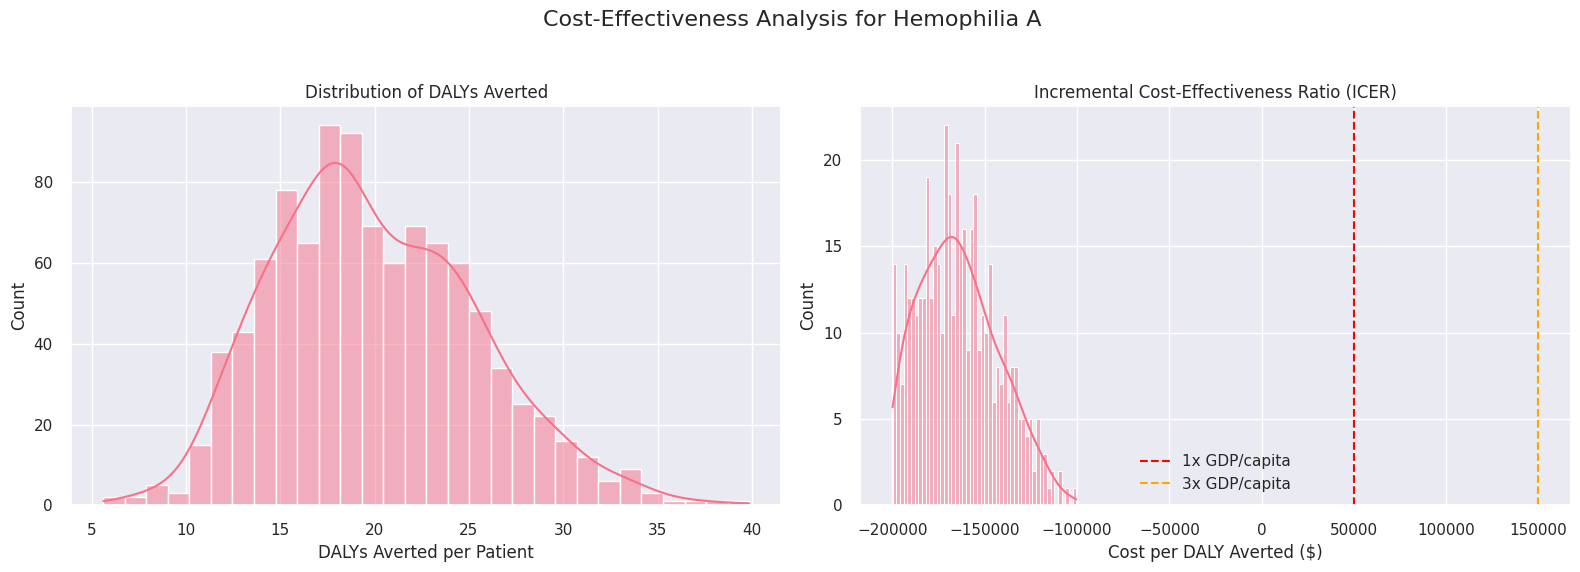

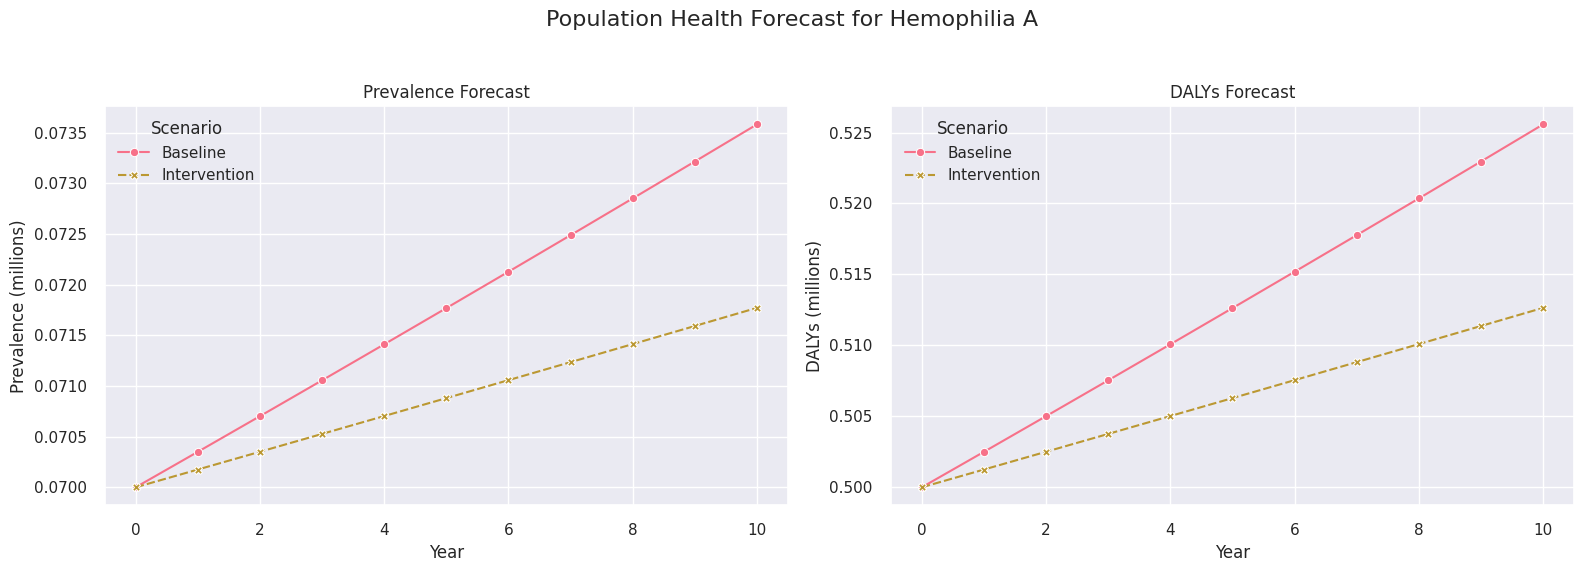

In [ ]:
# @title Advanced Biomedical Calculator with Hemophilia
# @markdown ## Health Equity Framework with Advanced Modeling

# This version has been updated to include a detailed model for Hemophilia.

# --- DEPENDENCIES ---
!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines kaleido --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.api import SimpleExpSmoothing
from scipy.stats import weibull_min
from lifelines import KaplanMeierFitter, WeibullFitter
from IPython.display import display, Markdown
import requests

# --- SETTINGS ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')
sns.set_theme(palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedBiomedicalCalculator:
    """
    Enhanced calculator with disease progression, cost-effectiveness simulations, and population forecasting.
    Now includes a specialized module for Hemophilia.
    """
    def __init__(self, standard_life_expectancy=85, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_public_datasets()
        self.setup_models()

    def load_public_datasets(self):
        """Load sample public health datasets"""
        # MODIFIED: Added Hemophilia data to the GBD dataset
        self.gbd_data = pd.DataFrame({
            'Disease': ['HIV/AIDS', 'Malaria', 'Tuberculosis', 'Diabetes', 'Heart Disease', 'Hemophilia A'],
            'DALYs (millions)': [58.3, 42.3, 36.8, 67.9, 182.5, 0.5], # DALYs are lower due to rarity
            'Prevalence (millions)': [38, 229, 10, 463, 523, 0.07], # Approx 70k in USA for context
            'Incidence (millions/year)': [1.7, 228, 10, 22, 18, 0.0004] # Approx 400 births/year
        })
        self.country_data = pd.DataFrame({
            'Country': ['USA', 'UK', 'India', 'Brazil', 'South Africa'],
            'GDP_per_capita': [65000, 45000, 2200, 8800, 6000],
            'Life_Expectancy': [78.5, 81.2, 69.7, 75.5, 64.1]
        })

        # MODIFIED: Added Hemophilia to the main disease models dictionary
        self.disease_models = {
            'HIV/AIDS': {
                'weights': [0.7, 0.6, 0.5, 0.4, 0.3],
                'progression': weibull_min(2.5, scale=10),
                'costs': {'treatment': 5000, 'management': 2000, 'dalys_per_case': 28}
            },
            'Diabetes': {
                'weights': [0.4, 0.5, 0.3, 0.6, 0.2],
                'progression': weibull_min(3.0, scale=15),
                'costs': {'treatment': 3000, 'management': 1500, 'dalys_per_case': 15}
            },
            'Hemophilia A': {
                'weights': [0.5, 0.4, 0.4, 0.3, 0.3], # Moderate severity profile
                'progression': weibull_min(2.5, scale=30), # Moderate progression
                'costs': {'annual_care': 300000, 'dalys_per_case': 25},
                # NEW: Hemophilia-specific data
                'joint_damage': {
                    'Stage 1': {'qol_penalty': 0.1},
                    'Stage 2': {'qol_penalty': 0.3},
                    'Stage 3': {'qol_penalty': 0.6}
                }
            }
        }

    def setup_models(self):
        """Initialize statistical models"""
        self.kmf = KaplanMeierFitter()
        self.wbf = WeibullFitter()

    # --- DISEASE PROGRESSION MODELS ---

    # NEW: Specialized function just for Hemophilia's unique progression
    def simulate_hemophilia_progression(self, years=50):
        """Simulates BP trajectory for Hemophilia with joint damage stages."""
        model = self.disease_models['Hemophilia A']
        progression_model = model['progression']
        base_weights = model['weights']
        joint_damage_stages = model['joint_damage']

        time_points = np.linspace(0, years, 100)
        survival_probs = progression_model.sf(time_points)

        # Calculate QoL dynamically based on joint stage
        qol_values = []
        for t in time_points:
            # Determine joint stage based on time
            stage_num = min(int(t / 15) + 1, 3)
            current_stage = f'Stage {stage_num}'

            # Calculate QoL penalty
            penalty = joint_damage_stages[current_stage]['qol_penalty']
            adj_weights = base_weights.copy()
            adj_weights[0] = min(1, adj_weights[0] + penalty / 2) # Pain
            adj_weights[1] = min(1, adj_weights[1] + penalty / 2) # Mobility

            total_burden = sum(adj_weights) * self.scaling_factor
            qol_values.append(max(0, 1 - total_burden))

        # Calculate Biomedical Potential
        bp_values = [s * q * self.standard_le for s, q in zip(survival_probs, qol_values)]

        return pd.DataFrame({'Year': time_points, 'BP': bp_values})

    # Generic simulation for other diseases
    def simulate_generic_disease_progression(self, disease_name, years=20):
        """Generic simulation with smooth QoL decline."""
        model = self.disease_models[disease_name]
        time_points = np.linspace(0, years, 100)
        survival_probs = model['progression'].sf(time_points)
        qol_decline = np.linspace(1, 0.5, len(time_points))
        bp_values = [s * q * self.standard_le for s, q in zip(survival_probs, qol_decline)]
        return pd.DataFrame({'Year': time_points, 'BP': bp_values})

    # MODIFIED: This function now acts as a dispatcher
    def plot_disease_progression(self, disease_name, years=20):
        """Visualize disease progression, using the correct model."""
        if 'Hemophilia' in disease_name:
            # Use the specialized hemophilia simulation
            progression_df = self.simulate_hemophilia_progression(years=50) # Use 50 years for hemophilia
            title = f'Biomedical Potential: Moderate Hemophilia A'
        else:
            # Use the generic simulation for other diseases
            progression_df = self.simulate_generic_disease_progression(disease_name, years)
            title = f'{disease_name} Progression Model (Generic)'

        # Plotting logic is now universal
        fig = px.line(progression_df, x='Year', y='BP', title=title)
        fig.update_layout(yaxis_title='Biomedical Potential (BP)')
        fig.show()

    # --- COST-EFFECTIVENESS & FORECASTING (largely unchanged, just uses the new data) ---

    def run_cost_effectiveness_simulation(self, disease_name, intervention_cost, n_simulations=1000):
        """Monte Carlo simulation of cost-effectiveness"""
        model = self.disease_models[disease_name]

        if 'Hemophilia' in disease_name:
            # Hemophilia CEA uses different cost structure (high annual vs. one-time)
            base_cost = model['costs']['annual_care'] * 20 # 20 years of standard care
        else:
            base_cost = model['costs']['treatment'] + model['costs']['management']

        dalys_mean = model['costs']['dalys_per_case']
        results = []
        for _ in range(n_simulations):
            control_dalys = np.random.normal(dalys_mean, 5)
            effect_size = np.random.uniform(0.7, 1.3)
            intervention_dalys = control_dalys * (1 - (0.8 * effect_size)) # Assume 80% DALY reduction
            cost_diff = intervention_cost - base_cost
            dalys_diff = control_dalys - intervention_dalys
            icer = cost_diff / dalys_diff if dalys_diff > 0 else float('inf')
            results.append({'DALYs_Averted': dalys_diff, 'ICER': icer})
        return pd.DataFrame(results)

    def plot_cost_effectiveness(self, disease_name, intervention_cost, gdp_per_capita):
        """Visualize cost-effectiveness simulation results"""
        results = self.run_cost_effectiveness_simulation(disease_name, intervention_cost)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Cost-Effectiveness Analysis for {disease_name}", fontsize=16)

        sns.histplot(results['DALYs_Averted'], bins=30, ax=ax1, kde=True)
        ax1.set_title('Distribution of DALYs Averted')
        ax1.set_xlabel('DALYs Averted per Patient')

        valid_icers = results[results['ICER'].between(-200000, 500000)]['ICER']
        sns.histplot(valid_icers, bins=50, ax=ax2, kde=True)
        ax2.axvline(gdp_per_capita, color='r', linestyle='--', label='1x GDP/capita')
        ax2.axvline(3*gdp_per_capita, color='orange', linestyle='--', label='3x GDP/capita')
        ax2.set_title('Incremental Cost-Effectiveness Ratio (ICER)')
        ax2.set_xlabel('Cost per DALY Averted ($)')
        ax2.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # (Forecasting module remains the same, it will pull data from the updated gbd_data)
    def forecast_population_health(self, disease_name, current_prevalence, incidence_rate,
                                   intervention_effect=0, years=10):
        """Forecast disease burden under different intervention scenarios"""
        if disease_name not in [d['Disease'] for d in self.gbd_data.to_dict('records')]:
             raise ValueError(f"No GBD data for {disease_name}")

        base_dalys = self.gbd_data.loc[self.gbd_data['Disease'] == disease_name, 'DALYs (millions)'].values[0]
        forecast_years = np.arange(0, years + 1)
        baseline = {
            'prevalence': current_prevalence * (1 + incidence_rate) ** forecast_years,
            'dalys': base_dalys * (1 + incidence_rate) ** forecast_years
        }
        intervention = {
            'prevalence': current_prevalence * ((1 + incidence_rate * (1 - intervention_effect)) ** forecast_years),
            'dalys': base_dalys * ((1 + incidence_rate * (1 - intervention_effect)) ** forecast_years)
        }
        return pd.DataFrame({
            'Year': np.concatenate([forecast_years, forecast_years]),
            'Prevalence': np.concatenate([baseline['prevalence'], intervention['prevalence']]),
            'DALYs': np.concatenate([baseline['dalys'], intervention['dalys']]),
            'Scenario': ['Baseline'] * len(forecast_years) + ['Intervention'] * len(forecast_years)
        })

    def plot_health_forecast(self, disease_name, current_prevalence, incidence_rate,
                             intervention_effect=0.3, years=10):
        forecast = self.forecast_population_health(
            disease_name, current_prevalence, incidence_rate,
            intervention_effect, years
        )
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Population Health Forecast for {disease_name}", fontsize=16)

        sns.lineplot(data=forecast, x='Year', y='Prevalence', hue='Scenario', style='Scenario', markers=True, ax=ax1)
        ax1.set_title(f'Prevalence Forecast')
        ax1.set_ylabel('Prevalence (millions)')

        sns.lineplot(data=forecast, x='Year', y='DALYs', hue='Scenario', style='Scenario', markers=True, ax=ax2)
        ax2.set_title(f'DALYs Forecast')
        ax2.set_ylabel('DALYs (millions)')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


# --- EXECUTION SCRIPT ---

# Initialize calculator
abp = AdvancedBiomedicalCalculator()

# @markdown ## 1. Disease Progression Modeling
# MODIFIED: Added Hemophilia A to the dropdown list.
disease_select = "Hemophilia A" # @param ["HIV/AIDS", "Diabetes", "Hemophilia A"]
abp.plot_disease_progression(disease_select)

# @markdown ## 2. Cost-Effectiveness Simulation
# @markdown Run this for Hemophilia A to see the CEA of gene therapy.
disease_for_cea = "Hemophilia A" # @param ["HIV/AIDS", "Diabetes", "Hemophilia A"]
intervention_cost = 2000000 # @param {type:"slider", min:1000, max:3000000, step:10000}
gdp_per_capita = 50000 # @param {type:"slider", min:500, max:100000, step:500}
abp.plot_cost_effectiveness(disease_for_cea, intervention_cost, gdp_per_capita)

# @markdown ## 3. Population Health Forecasting
# @markdown Set parameters relevant to the selected disease.
disease_for_forecast = "Hemophilia A" # @param ["HIV/AIDS", "Diabetes", "Heart Disease", "Hemophilia A"]
current_prevalence = 0.07 # @param {type:"number"}
incidence_rate = 0.005 # @param {type:"slider", min:0, max:0.2, step:0.001}
intervention_effect = 0.5 # @param {type:"slider", min:0, max:1, step:0.05}
forecast_years = 10 # @param {type:"slider", min:5, max:30, step:1}
abp.plot_health_forecast(
    disease_for_forecast, current_prevalence, incidence_rate,
    intervention_effect, forecast_years
)

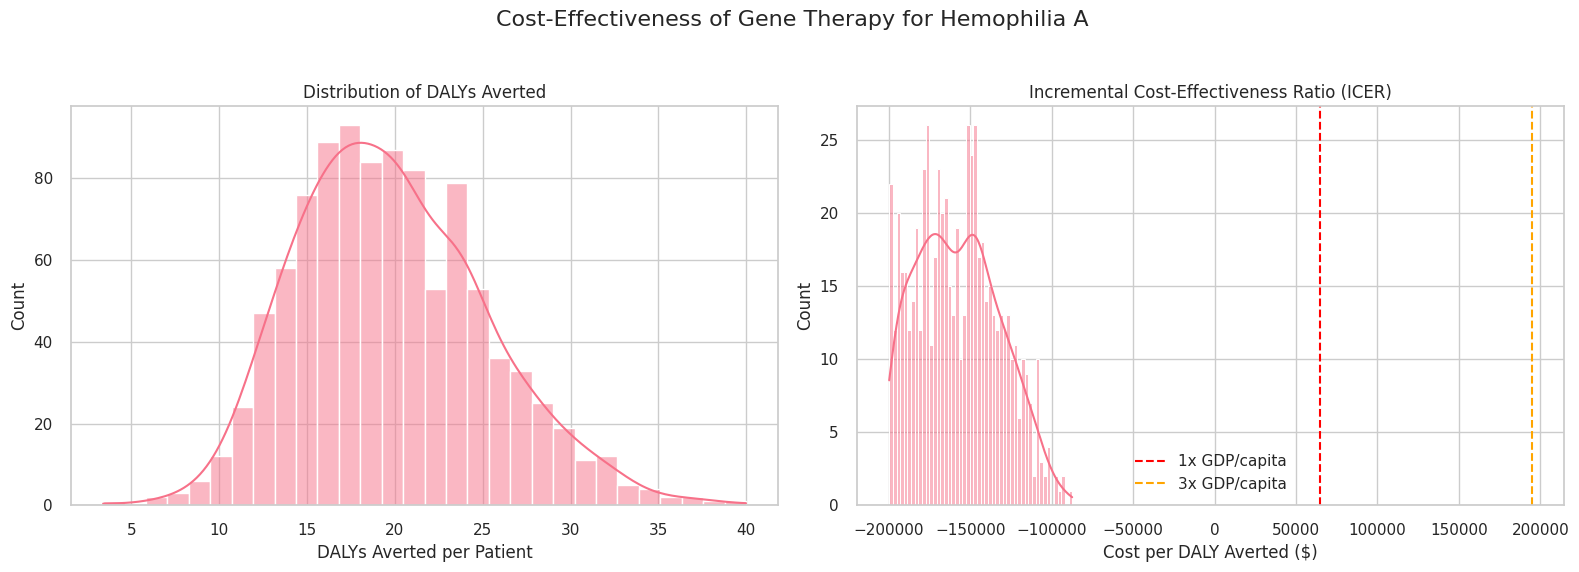

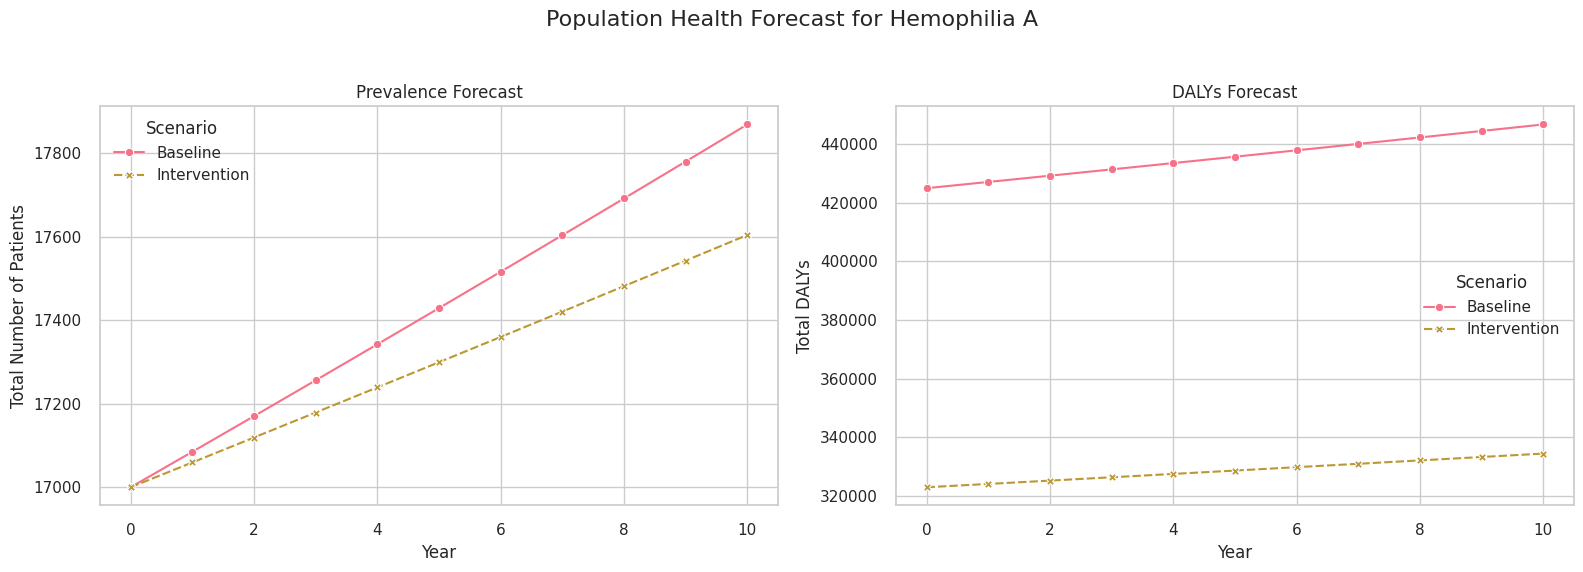

In [ ]:
# @title Comprehensive Health-Economic Model for Bleeding Disorders
# @markdown ## A specialized framework for Hemophilia A, B, VWD, and Inhibitors

# --- DEPENDENCIES ---
!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines kaleido --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import weibull_min
from IPython.display import display, Markdown

# --- SETTINGS ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

# MODIFIED: Renamed class to reflect its specific focus
class BleedingDisorderModel:
    """
    A specialized model for bleeding disorders, integrating patient progression,
    cost-effectiveness, and population forecasting.
    """
    def __init__(self, standard_life_expectancy=75, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_disorder_data()

    def load_disorder_data(self):
        """Loads datasets specifically for bleeding disorders."""
        # MODIFIED: Data now focuses exclusively on bleeding disorders
        self.disorder_data = pd.DataFrame({
            'Disorder': ['Hemophilia A', 'Hemophilia B', 'von Willebrand Disease', 'Inhibitors'],
            'Prevalence_per_100k': [17.0, 4.0, 1000.0, 0.5], # VWD is much more common
            'DALYs_per_case': [25, 22, 10, 35],
        })

        # MODIFIED: Expanded models for all relevant disorders
        self.disorder_models = {
            'Hemophilia A': {
                'severity': 'Moderate', 'weights': [0.5, 0.4, 0.4, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30),
                'costs': {'annual_care': 300000, 'dalys_per_case': 25}
            },
            'Hemophilia B': {
                'severity': 'Moderate', 'weights': [0.4, 0.4, 0.3, 0.2, 0.2],
                'progression': weibull_min(2.2, scale=35),
                'costs': {'annual_care': 280000, 'dalys_per_case': 22}
            },
            'von Willebrand Disease': {
                'severity': 'Mild', 'weights': [0.2, 0.1, 0.1, 0.3, 0.1], # Higher bleeding weight
                'progression': weibull_min(2.0, scale=50), # Slower progression
                'costs': {'annual_care': 50000, 'dalys_per_case': 10}
            },
            'Inhibitors': {
                'severity': 'Severe', 'weights': [0.9, 0.8, 0.8, 0.7, 0.6], # Very high burden
                'progression': weibull_min(3.5, scale=15), # Rapid progression
                'costs': {'annual_care': 800000, 'dalys_per_case': 35}
            }
        }

        self.joint_damage = {
            'Stage 1': {'qol_penalty': 0.1},
            'Stage 2': {'qol_penalty': 0.3},
            'Stage 3': {'qol_penalty': 0.6}
        }

    # --- MODULE 1: Patient-Level Disease Progression ---

    # MODIFIED: Function is now generalized to handle any defined disorder
    def simulate_patient_progression(self, disorder_name, years=50):
        """Simulates BP trajectory for any bleeding disorder with joint damage stages."""
        if disorder_name not in self.disorder_models:
            raise ValueError(f"Model for {disorder_name} not found.")

        model = self.disorder_models[disorder_name]
        progression_model = model['progression']
        base_weights = model['weights']

        time_points = np.linspace(0, years, 100)
        survival_probs = progression_model.sf(time_points)

        qol_values = []
        for t in time_points:
            stage_num = min(int(t / 15) + 1, 3)
            current_stage = f'Stage {stage_num}'
            penalty = 0
            # Assume joint damage is less of a factor in milder VWD
            if model['severity'] != 'Mild':
                penalty = self.joint_damage[current_stage]['qol_penalty']

            adj_weights = base_weights.copy()
            adj_weights[0] = min(1, adj_weights[0] + penalty / 2) # Pain
            adj_weights[1] = min(1, adj_weights[1] + penalty / 2) # Mobility

            total_burden = sum(adj_weights) * self.scaling_factor
            qol_values.append(max(0, 1 - total_burden))

        bp_values = [s * q * self.standard_le for s, q in zip(survival_probs, qol_values)]
        return pd.DataFrame({'Year': time_points, 'BP': bp_values})

    def plot_patient_progression(self, disorder_name, years=50):
        """Visualizes the patient progression for the selected disorder."""
        progression_df = self.simulate_patient_progression(disorder_name, years)
        title = f'Biomedical Potential: {disorder_name}'

        fig = px.line(progression_df, x='Year', y='BP', title=title)
        fig.update_layout(yaxis_title='Biomedical Potential (BP)')
        fig.show()

    # --- MODULE 2: Cost-Effectiveness Analysis ---

    def run_cea_simulation(self, disorder_name, intervention_cost, n_simulations=1000):
        """Monte Carlo simulation of cost-effectiveness for a given disorder."""
        if disorder_name not in self.disorder_models:
            raise ValueError(f"Model for {disorder_name} not found.")

        model = self.disorder_models[disorder_name]
        base_cost = model['costs']['annual_care'] * 20 # Assume 20 years of standard care averted
        dalys_mean = model['costs']['dalys_per_case']

        results = []
        for _ in range(n_simulations):
            control_dalys = np.random.normal(dalys_mean, 5)
            effect_size = np.random.uniform(0.7, 1.3)
            intervention_dalys = control_dalys * (1 - (0.8 * effect_size))
            cost_diff = intervention_cost - base_cost
            dalys_diff = control_dalys - intervention_dalys
            icer = cost_diff / dalys_diff if dalys_diff > 0 else float('inf')
            results.append({'DALYs_Averted': dalys_diff, 'ICER': icer})
        return pd.DataFrame(results)

    def plot_cost_effectiveness(self, disorder_name, intervention_cost, gdp_per_capita):
        """Visualize cost-effectiveness simulation results."""
        results = self.run_cea_simulation(disorder_name, intervention_cost)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Cost-Effectiveness of Gene Therapy for {disorder_name}", fontsize=16)

        sns.histplot(results['DALYs_Averted'], bins=30, ax=ax1, kde=True)
        ax1.set_title('Distribution of DALYs Averted'); ax1.set_xlabel('DALYs Averted per Patient')

        valid_icers = results[results['ICER'].between(-200000, 500000)]['ICER']
        sns.histplot(valid_icers, bins=50, ax=ax2, kde=True)
        ax2.axvline(gdp_per_capita, color='r', linestyle='--', label='1x GDP/capita')
        ax2.axvline(3 * gdp_per_capita, color='orange', linestyle='--', label='3x GDP/capita')
        ax2.set_title('Incremental Cost-Effectiveness Ratio (ICER)'); ax2.set_xlabel('Cost per DALY Averted ($)')
        ax2.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

    # --- MODULE 3: Population Health Forecasting ---

    def plot_health_forecast(self, disorder_name, population_size, intervention_effect=0.3, years=10):
        """Visualize population health forecast for a given disorder."""
        row = self.disorder_data.loc[self.disorder_data['Disorder'] == disorder_name]
        if row.empty: raise ValueError(f"No data for {disorder_name}")

        prevalence_rate = row['Prevalence_per_100k'].values[0] / 100000
        dalys_per_case = row['DALYs_per_case'].values[0]
        current_cases = population_size * prevalence_rate
        incidence_rate = 0.005 # Assume a stable incidence for genetic disorders

        forecast_years = np.arange(0, years + 1)
        baseline_prev = current_cases * (1 + incidence_rate) ** forecast_years
        interv_prev = current_cases * (1 + incidence_rate * (1 - intervention_effect)) ** forecast_years

        baseline_dalys = baseline_prev * dalys_per_case
        interv_dalys = interv_prev * dalys_per_case * (1 - intervention_effect * 0.8) # Therapy also reduces severity

        forecast = pd.DataFrame({
            'Year': np.concatenate([forecast_years, forecast_years]),
            'Prevalence': np.concatenate([baseline_prev, interv_prev]),
            'DALYs': np.concatenate([baseline_dalys, interv_dalys]),
            'Scenario': ['Baseline'] * len(forecast_years) + ['Intervention'] * len(forecast_years)
        })

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Population Health Forecast for {disorder_name}", fontsize=16)

        sns.lineplot(data=forecast, x='Year', y='Prevalence', hue='Scenario', style='Scenario', markers=True, ax=ax1)
        ax1.set_title('Prevalence Forecast'); ax1.set_ylabel('Total Number of Patients')

        sns.lineplot(data=forecast, x='Year', y='DALYs', hue='Scenario', style='Scenario', markers=True, ax=ax2)
        ax2.set_title('DALYs Forecast'); ax2.set_ylabel('Total DALYs')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# --- EXECUTION SCRIPT ---

model = BleedingDisorderModel()

# @markdown ## 1. Patient-Level Disease Progression
# @markdown Select a bleeding disorder to model its impact on an individual over 50 years.
disorder_to_model = "Hemophilia A" # @param ["Hemophilia A", "Hemophilia B", "von Willebrand Disease", "Inhibitors"]
model.plot_patient_progression(disorder_to_model)

# @markdown ---
# @markdown ## 2. Cost-Effectiveness of a New Therapy
# @markdown Analyzes a high-cost therapy (e.g., Gene Therapy) for the selected disorder.
disorder_for_cea = "Hemophilia A" # @param ["Hemophilia A", "Hemophilia B", "Inhibitors"]
intervention_cost = 2500000 # @param {type:"slider", min:500000, max:4000000, step:100000}
gdp_per_capita = 65000 # @param {type:"slider", min:10000, max:100000, step:1000}
model.plot_cost_effectiveness(disorder_for_cea, intervention_cost, gdp_per_capita)

# @markdown ---
# @markdown ## 3. Population Health Forecasting
# @markdown Projects the total health burden for a population over 10 years.
disorder_for_forecast = "Hemophilia A" # @param ["Hemophilia A", "Hemophilia B", "von Willebrand Disease", "Inhibitors"]
population_size = 100000000 # @param {type:"number"}
intervention_effect = 0.3 # @param {type:"slider", min:0, max:1, step:0.05}
model.plot_health_forecast(disorder_for_forecast, population_size, intervention_effect)

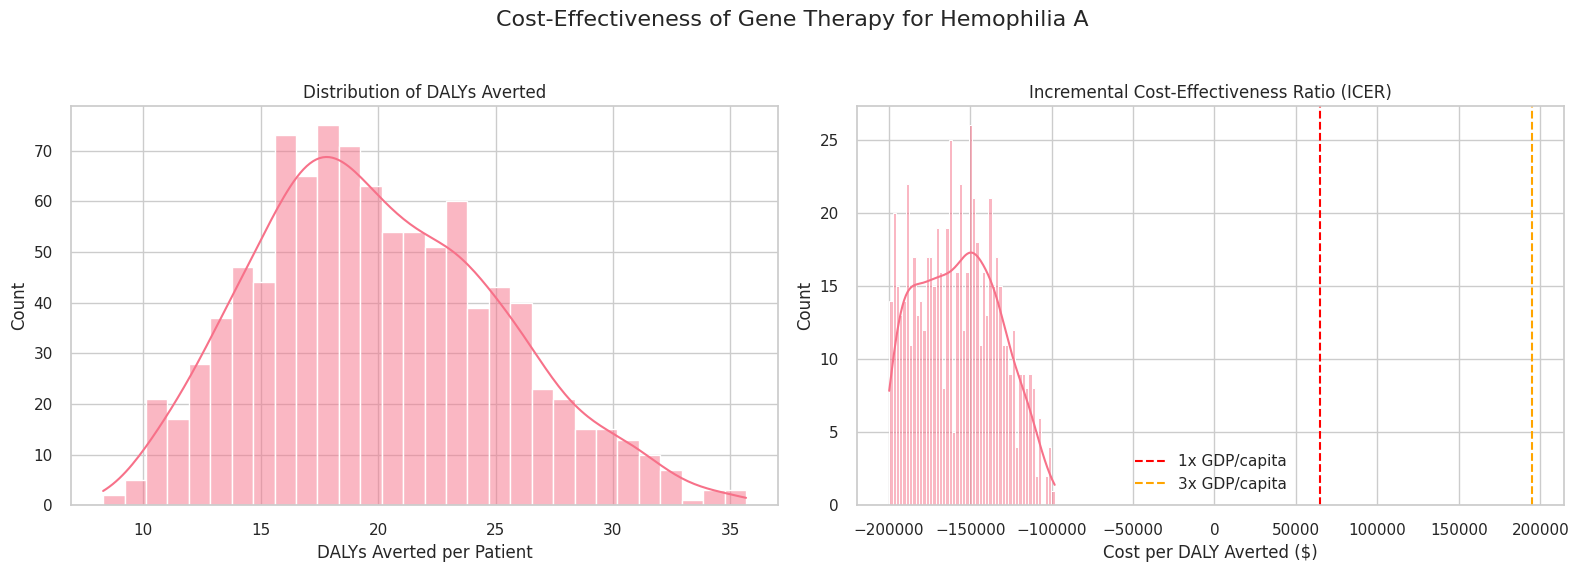

In [ ]:
# @title Comprehensive Health-Economic Model for Bleeding Disorders
# @markdown ## Expanded framework for all major bleeding disorders

# --- DEPENDENCIES ---
!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines kaleido --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import weibull_min
from IPython.display import display, Markdown

# --- SETTINGS ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class BleedingDisorderModel:
    """
    A comprehensive model for all major bleeding disorders, integrating patient progression,
    cost-effectiveness, and population forecasting.
    """
    def __init__(self, standard_life_expectancy=75, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_disorder_data()

    def load_disorder_data(self):
        """Loads datasets for all major bleeding disorders."""
        self.disorder_data = pd.DataFrame({
            'Disorder': ['Hemophilia A', 'Hemophilia B', 'von Willebrand Disease', 'Inhibitors',
                        'Factor VII Deficiency', 'Factor X Deficiency', 'Factor V Deficiency',
                        'Factor XI Deficiency', 'Factor XIII Deficiency', 'Glanzmann Thrombasthenia',
                        'Bernard-Soulier Syndrome', 'Platelet Storage Pool Disorders',
                        'Afibrinogenemia', 'Dysfibrinogenemia', 'Hypofibrinogenemia'],
            'Prevalence_per_100k': [17.0, 4.0, 1000.0, 0.5,
                                   1.0, 1.0, 1.0,
                                   5.0, 1.0, 1.0,
                                   0.5, 1.0,
                                   0.2, 0.5, 0.5],
            'DALYs_per_case': [25, 22, 10, 35,
                               15, 18, 12,
                               10, 20, 18,
                               15, 12,
                               22, 15, 15],
            'Severity': ['Moderate', 'Moderate', 'Mild', 'Severe',
                         'Moderate', 'Moderate', 'Mild',
                         'Mild', 'Moderate', 'Moderate',
                         'Moderate', 'Mild',
                         'Severe', 'Moderate', 'Moderate']
        })

        # Define models for all bleeding disorders
        self.disorder_models = {
            # Existing disorders
            'Hemophilia A': {
                'weights': [0.5, 0.4, 0.4, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30),
                'costs': {'annual_care': 300000, 'dalys_per_case': 25}
            },
            'Hemophilia B': {
                'weights': [0.4, 0.4, 0.3, 0.2, 0.2],
                'progression': weibull_min(2.2, scale=35),
                'costs': {'annual_care': 280000, 'dalys_per_case': 22}
            },
            'von Willebrand Disease': {
                'weights': [0.2, 0.1, 0.1, 0.3, 0.1],
                'progression': weibull_min(2.0, scale=50),
                'costs': {'annual_care': 50000, 'dalys_per_case': 10}
            },
            'Inhibitors': {
                'weights': [0.9, 0.8, 0.8, 0.7, 0.6],
                'progression': weibull_min(3.5, scale=15),
                'costs': {'annual_care': 800000, 'dalys_per_case': 35}
            },
            # New rare bleeding disorders
            'Factor VII Deficiency': {
                'weights': [0.3, 0.3, 0.2, 0.2, 0.2],
                'progression': weibull_min(2.0, scale=40),
                'costs': {'annual_care': 150000, 'dalys_per_case': 15}
            },
            'Factor X Deficiency': {
                'weights': [0.4, 0.3, 0.3, 0.2, 0.2],
                'progression': weibull_min(2.2, scale=35),
                'costs': {'annual_care': 180000, 'dalys_per_case': 18}
            },
            'Factor V Deficiency': {
                'weights': [0.2, 0.2, 0.1, 0.1, 0.1],
                'progression': weibull_min(1.8, scale=45),
                'costs': {'annual_care': 100000, 'dalys_per_case': 12}
            },
            'Factor XI Deficiency': {
                'weights': [0.2, 0.1, 0.1, 0.2, 0.1],
                'progression': weibull_min(1.8, scale=50),
                'costs': {'annual_care': 80000, 'dalys_per_case': 10}
            },
            'Factor XIII Deficiency': {
                'weights': [0.5, 0.4, 0.3, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30),
                'costs': {'annual_care': 200000, 'dalys_per_case': 20}
            },
            'Glanzmann Thrombasthenia': {
                'weights': [0.4, 0.4, 0.3, 0.3, 0.2],
                'progression': weibull_min(2.3, scale=35),
                'costs': {'annual_care': 180000, 'dalys_per_case': 18}
            },
            'Bernard-Soulier Syndrome': {
                'weights': [0.3, 0.3, 0.2, 0.2, 0.2],
                'progression': weibull_min(2.0, scale=40),
                'costs': {'annual_care': 150000, 'dalys_per_case': 15}
            },
            'Platelet Storage Pool Disorders': {
                'weights': [0.2, 0.2, 0.1, 0.1, 0.1],
                'progression': weibull_min(1.8, scale=45),
                'costs': {'annual_care': 120000, 'dalys_per_case': 12}
            },
            'Afibrinogenemia': {
                'weights': [0.6, 0.5, 0.4, 0.4, 0.3],
                'progression': weibull_min(3.0, scale=25),
                'costs': {'annual_care': 250000, 'dalys_per_case': 22}
            },
            'Dysfibrinogenemia': {
                'weights': [0.3, 0.3, 0.2, 0.2, 0.2],
                'progression': weibull_min(2.0, scale=40),
                'costs': {'annual_care': 150000, 'dalys_per_case': 15}
            },
            'Hypofibrinogenemia': {
                'weights': [0.3, 0.2, 0.2, 0.2, 0.2],
                'progression': weibull_min(2.0, scale=40),
                'costs': {'annual_care': 150000, 'dalys_per_case': 15}
            }
        }

        # Add severity from disorder_data to each model
        for disorder, row in self.disorder_data.set_index('Disorder').iterrows():
            if disorder in self.disorder_models:
                self.disorder_models[disorder]['severity'] = row['Severity']

        self.joint_damage = {
            'Stage 1': {'qol_penalty': 0.1},
            'Stage 2': {'qol_penalty': 0.3},
            'Stage 3': {'qol_penalty': 0.6}
        }

    # --- MODULE 1: Patient-Level Disease Progression ---

    def simulate_patient_progression(self, disorder_name, years=50):
        """Simulates BP trajectory for any bleeding disorder with joint damage stages."""
        if disorder_name not in self.disorder_models:
            raise ValueError(f"Model for {disorder_name} not found.")

        model = self.disorder_models[disorder_name]
        progression_model = model['progression']
        base_weights = model['weights']

        time_points = np.linspace(0, years, 100)
        survival_probs = progression_model.sf(time_points)

        qol_values = []
        for t in time_points:
            stage_num = min(int(t / 15) + 1, 3)
            current_stage = f'Stage {stage_num}'
            penalty = 0
            # Assume joint damage is less of a factor in milder disorders
            if model['severity'] not in ['Mild', 'Very Mild']:
                penalty = self.joint_damage[current_stage]['qol_penalty']

            adj_weights = base_weights.copy()
            adj_weights[0] = min(1, adj_weights[0] + penalty / 2) # Pain
            adj_weights[1] = min(1, adj_weights[1] + penalty / 2) # Mobility

            total_burden = sum(adj_weights) * self.scaling_factor
            qol_values.append(max(0, 1 - total_burden))

        bp_values = [s * q * self.standard_le for s, q in zip(survival_probs, qol_values)]
        return pd.DataFrame({'Year': time_points, 'BP': bp_values})

    def plot_patient_progression(self, disorder_name, years=50):
        """Visualizes the patient progression for the selected disorder."""
        progression_df = self.simulate_patient_progression(disorder_name, years)
        title = f'Biomedical Potential: {disorder_name}'

        fig = px.line(progression_df, x='Year', y='BP', title=title)
        fig.update_layout(yaxis_title='Biomedical Potential (BP)')
        fig.show()

    # --- MODULE 2: Cost-Effectiveness Analysis ---

    def run_cea_simulation(self, disorder_name, intervention_cost, n_simulations=1000):
        """Monte Carlo simulation of cost-effectiveness for a given disorder."""
        if disorder_name not in self.disorder_models:
            raise ValueError(f"Model for {disorder_name} not found.")

        model = self.disorder_models[disorder_name]
        base_cost = model['costs']['annual_care'] * 20 # Assume 20 years of standard care averted
        dalys_mean = model['costs']['dalys_per_case']

        results = []
        for _ in range(n_simulations):
            control_dalys = np.random.normal(dalys_mean, 5)
            effect_size = np.random.uniform(0.7, 1.3)
            intervention_dalys = control_dalys * (1 - (0.8 * effect_size))
            cost_diff = intervention_cost - base_cost
            dalys_diff = control_dalys - intervention_dalys
            icer = cost_diff / dalys_diff if dalys_diff > 0 else float('inf')
            results.append({'DALYs_Averted': dalys_diff, 'ICER': icer})
        return pd.DataFrame(results)

    def plot_cost_effectiveness(self, disorder_name, intervention_cost, gdp_per_capita):
        """Visualize cost-effectiveness simulation results."""
        results = self.run_cea_simulation(disorder_name, intervention_cost)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Cost-Effectiveness of Gene Therapy for {disorder_name}", fontsize=16)

        sns.histplot(results['DALYs_Averted'], bins=30, ax=ax1, kde=True)
        ax1.set_title('Distribution of DALYs Averted'); ax1.set_xlabel('DALYs Averted per Patient')

        valid_icers = results[results['ICER'].between(-200000, 500000)]['ICER']
        sns.histplot(valid_icers, bins=50, ax=ax2, kde=True)
        ax2.axvline(gdp_per_capita, color='r', linestyle='--', label='1x GDP/capita')
        ax2.axvline(3 * gdp_per_capita, color='orange', linestyle='--', label='3x GDP/capita')
        ax2.set_title('Incremental Cost-Effectiveness Ratio (ICER)'); ax2.set_xlabel('Cost per DALY Averted ($)')
        ax2.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

    # --- MODULE 3: Population Health Forecasting ---

    def plot_health_forecast(self, disorder_name, population_size, intervention_effect=0.3, years=10):
        """Visualize population health forecast for a given disorder."""
        row = self.disorder_data.loc[self.disorder_data['Disorder'] == disorder_name]
        if row.empty: raise ValueError(f"No data for {disorder_name}")

        prevalence_rate = row['Prevalence_per_100k'].values[0] / 100000
        dalys_per_case = row['DALYs_per_case'].values[0]
        current_cases = population_size * prevalence_rate
        incidence_rate = 0.005 # Assume a stable incidence for genetic disorders

        forecast_years = np.arange(0, years + 1)
        baseline_prev = current_cases * (1 + incidence_rate) ** forecast_years
        interv_prev = current_cases * (1 + incidence_rate * (1 - intervention_effect)) ** forecast_years

        baseline_dalys = baseline_prev * dalys_per_case
        interv_dalys = interv_prev * dalys_per_case * (1 - intervention_effect * 0.8) # Therapy also reduces severity

        forecast = pd.DataFrame({
            'Year': np.concatenate([forecast_years, forecast_years]),
            'Prevalence': np.concatenate([baseline_prev, interv_prev]),
            'DALYs': np.concatenate([baseline_dalys, interv_dalys]),
            'Scenario': ['Baseline'] * len(forecast_years) + ['Intervention'] * len(forecast_years)
        })

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Population Health Forecast for {disorder_name}", fontsize=16)

        sns.lineplot(data=forecast, x='Year', y='Prevalence', hue='Scenario', style='Scenario', markers=True, ax=ax1)
        ax1.set_title('Prevalence Forecast'); ax1.set_ylabel('Total Number of Patients')

        sns.lineplot(data=forecast, x='Year', y='DALYs', hue='Scenario', style='Scenario', markers=True, ax=ax2)
        ax2.set_title('DALYs Forecast'); ax2.set_ylabel('Total DALYs')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# --- EXECUTION SCRIPT ---

model = BleedingDisorderModel()

# @markdown ## 1. Patient-Level Disease Progression
# @markdown Select a bleeding disorder to model its impact on an individual over 50 years.
disorder_to_model = "Hemophilia A" # @param ["Hemophilia A", "Hemophilia B", "von Willebrand Disease", "Inhibitors", "Factor VII Deficiency", "Factor X Deficiency", "Factor V Deficiency", "Factor XI Deficiency", "Factor XIII Deficiency", "Glanzmann Thrombasthenia", "Bernard-Soulier Syndrome", "Platelet Storage Pool Disorders", "Afibrinogenemia", "Dysfibrinogenemia", "Hypofibrinogenemia"]
model.plot_patient_progression(disorder_to_model)

# @markdown ---
# @markdown ## 2. Cost-Effectiveness of a New Therapy
# @markdown Analyzes a high-cost therapy (e.g., Gene Therapy) for the selected disorder.
disorder_for_cea = "Hemophilia A" # @param ["Hemophilia A", "Hemophilia B", "Inhibitors", "Factor VII Deficiency", "Factor X Deficiency", "Factor XIII Deficiency", "Glanzmann Thrombasthenia", "Afibrinogenemia"]
intervention_cost = 2500000 # @param {type:"slider", min:500000, max:4000000, step:100000}
gdp_per_capita = 65000 # @param {type:"slider", min:10000, max:100000, step:1000}
model.plot_cost_effectiveness(disorder_for_cea, intervention_cost, gdp_per_capita)

# @markdown ---
# @markdown ## 3. Population Health Forecasting
# @markdown Projects the total health burden for a population over 10 years.
disorder_for_forecast = "Hemophilia A" #

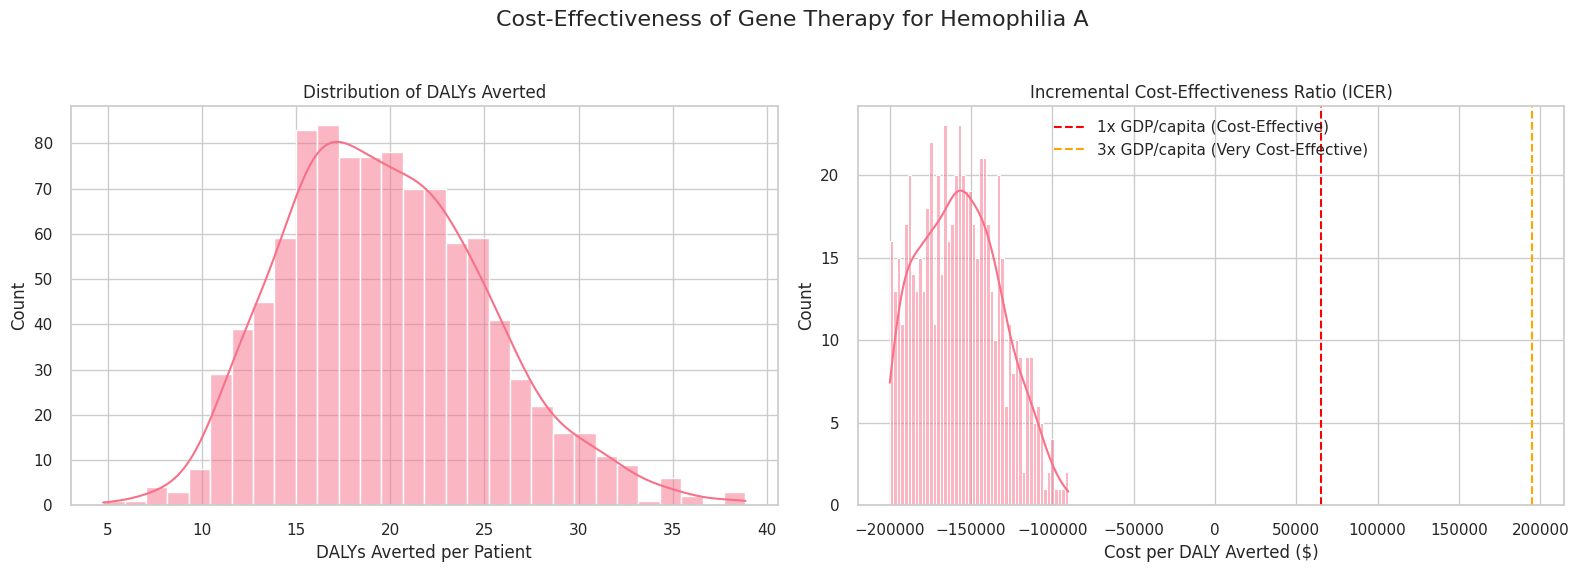

In [ ]:
# @title Comprehensive Health-Economic Model for Bleeding Disorders
# @markdown ## Expanded framework for all major bleeding disorders

# --- DEPENDENCIES ---
!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines kaleido --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import weibull_min
from IPython.display import display, Markdown

# --- SETTINGS ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class BleedingDisorderModel:
    """
    A comprehensive model for all major bleeding disorders, integrating patient progression,
    cost-effectiveness, and population forecasting.
    """
    def __init__(self, standard_life_expectancy=75, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_disorder_data()

    def load_disorder_data(self):
        """Loads datasets for all major bleeding disorders."""
        self.disorder_data = pd.DataFrame({
            'Disorder': ['Hemophilia A', 'Hemophilia B', 'von Willebrand Disease', 'Inhibitors',
                        'Factor VII Deficiency', 'Factor X Deficiency', 'Factor V Deficiency',
                        'Factor XI Deficiency', 'Factor XIII Deficiency', 'Glanzmann Thrombasthenia',
                        'Bernard-Soulier Syndrome', 'Platelet Storage Pool Disorders',
                        'Afibrinogenemia', 'Dysfibrinogenemia', 'Hypofibrinogenemia'],
            'Prevalence_per_100k': [17.0, 4.0, 1000.0, 0.5,
                                   1.0, 1.0, 1.0,
                                   5.0, 1.0, 1.0,
                                   0.5, 1.0,
                                   0.2, 0.5, 0.5],
            'DALYs_per_case': [25, 22, 10, 35,
                               15, 18, 12,
                               10, 20, 18,
                               15, 12,
                               22, 15, 15],
            'Severity': ['Moderate', 'Moderate', 'Mild', 'Severe',
                         'Moderate', 'Moderate', 'Mild',
                         'Mild', 'Moderate', 'Moderate',
                         'Moderate', 'Mild',
                         'Severe', 'Moderate', 'Moderate']
        })

        # Define models for all bleeding disorders
        self.disorder_models = {
            # Existing disorders
            'Hemophilia A': {
                'weights': [0.5, 0.4, 0.4, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30),
                'costs': {'annual_care': 300000, 'dalys_per_case': 25}
            },
            'Hemophilia B': {
                'weights': [0.4, 0.4, 0.3, 0.2, 0.2],
                'progression': weibull_min(2.2, scale=35),
                'costs': {'annual_care': 280000, 'dalys_per_case': 22}
            },
            'von Willebrand Disease': {
                'weights': [0.2, 0.1, 0.1, 0.3, 0.1],
                'progression': weibull_min(2.0, scale=50),
                'costs': {'annual_care': 50000, 'dalys_per_case': 10}
            },
            'Inhibitors': {
                'weights': [0.9, 0.8, 0.8, 0.7, 0.6],
                'progression': weibull_min(3.5, scale=15),
                'costs': {'annual_care': 800000, 'dalys_per_case': 35}
            },
            # New rare bleeding disorders
            'Factor VII Deficiency': {
                'weights': [0.3, 0.3, 0.2, 0.2, 0.2],
                'progression': weibull_min(2.0, scale=40),
                'costs': {'annual_care': 150000, 'dalys_per_case': 15}
            },
            'Factor X Deficiency': {
                'weights': [0.4, 0.3, 0.3, 0.2, 0.2],
                'progression': weibull_min(2.2, scale=35),
                'costs': {'annual_care': 180000, 'dalys_per_case': 18}
            },
            'Factor V Deficiency': {
                'weights': [0.2, 0.2, 0.1, 0.1, 0.1],
                'progression': weibull_min(1.8, scale=45),
                'costs': {'annual_care': 100000, 'dalys_per_case': 12}
            },
            'Factor XI Deficiency': {
                'weights': [0.2, 0.1, 0.1, 0.2, 0.1],
                'progression': weibull_min(1.8, scale=50),
                'costs': {'annual_care': 80000, 'dalys_per_case': 10}
            },
            'Factor XIII Deficiency': {
                'weights': [0.5, 0.4, 0.3, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30),
                'costs': {'annual_care': 200000, 'dalys_per_case': 20}
            },
            'Glanzmann Thrombasthenia': {
                'weights': [0.4, 0.4, 0.3, 0.3, 0.2],
                'progression': weibull_min(2.3, scale=35),
                'costs': {'annual_care': 180000, 'dalys_per_case': 18}
            },
            'Bernard-Soulier Syndrome': {
                'weights': [0.3, 0.3, 0.2, 0.2, 0.2],
                'progression': weibull_min(2.0, scale=40),
                'costs': {'annual_care': 150000, 'dalys_per_case': 15}
            },
            'Platelet Storage Pool Disorders': {
                'weights': [0.2, 0.2, 0.1, 0.1, 0.1],
                'progression': weibull_min(1.8, scale=45),
                'costs': {'annual_care': 120000, 'dalys_per_case': 12}
            },
            'Afibrinogenemia': {
                'weights': [0.6, 0.5, 0.4, 0.4, 0.3],
                'progression': weibull_min(3.0, scale=25),
                'costs': {'annual_care': 250000, 'dalys_per_case': 22}
            },
            'Dysfibrinogenemia': {
                'weights': [0.3, 0.3, 0.2, 0.2, 0.2],
                'progression': weibull_min(2.0, scale=40),
                'costs': {'annual_care': 150000, 'dalys_per_case': 15}
            },
            'Hypofibrinogenemia': {
                'weights': [0.3, 0.2, 0.2, 0.2, 0.2],
                'progression': weibull_min(2.0, scale=40),
                'costs': {'annual_care': 150000, 'dalys_per_case': 15}
            }
        }

        # Add severity from disorder_data to each model
        for disorder, row in self.disorder_data.set_index('Disorder').iterrows():
            if disorder in self.disorder_models:
                self.disorder_models[disorder]['severity'] = row['Severity']

        self.joint_damage = {
            'Stage 1': {'qol_penalty': 0.1},
            'Stage 2': {'qol_penalty': 0.3},
            'Stage 3': {'qol_penalty': 0.6}
        }

    # --- MODULE 1: Patient-Level Disease Progression ---

    def simulate_patient_progression(self, disorder_name, years=50):
        """Simulates BP trajectory for any bleeding disorder with joint damage stages."""
        if disorder_name not in self.disorder_models:
            raise ValueError(f"Model for {disorder_name} not found.")

        model = self.disorder_models[disorder_name]
        progression_model = model['progression']
        base_weights = model['weights']

        time_points = np.linspace(0, years, 100)
        survival_probs = progression_model.sf(time_points)

        qol_values = []
        for t in time_points:
            stage_num = min(int(t / 15) + 1, 3)
            current_stage = f'Stage {stage_num}'
            penalty = 0
            # Assume joint damage is less of a factor in milder disorders
            if model['severity'] not in ['Mild', 'Very Mild']:
                penalty = self.joint_damage[current_stage]['qol_penalty']

            adj_weights = base_weights.copy()
            adj_weights[0] = min(1, adj_weights[0] + penalty / 2) # Pain
            adj_weights[1] = min(1, adj_weights[1] + penalty / 2) # Mobility

            total_burden = sum(adj_weights) * self.scaling_factor
            qol_values.append(max(0, 1 - total_burden))

        bp_values = [s * q * self.standard_le for s, q in zip(survival_probs, qol_values)]
        return pd.DataFrame({'Year': time_points, 'BP': bp_values})

    def plot_patient_progression(self, disorder_name, years=50):
        """Visualizes the patient progression for the selected disorder."""
        progression_df = self.simulate_patient_progression(disorder_name, years)
        title = f'Biomedical Potential: {disorder_name}'

        fig = px.line(progression_df, x='Year', y='BP', title=title, markers=True)
        fig.update_layout(yaxis_title='Biomedical Potential (BP)')
        fig.show()

    # --- MODULE 2: Cost-Effectiveness Analysis ---

    def run_cea_simulation(self, disorder_name, intervention_cost, n_simulations=1000):
        """Monte Carlo simulation of cost-effectiveness for a given disorder."""
        if disorder_name not in self.disorder_models:
            raise ValueError(f"Model for {disorder_name} not found.")

        model = self.disorder_models[disorder_name]
        base_cost = model['costs']['annual_care'] * 20 # Assume 20 years of standard care averted
        dalys_mean = model['costs']['dalys_per_case']

        results = []
        for _ in range(n_simulations):
            control_dalys = np.random.normal(dalys_mean, 5)
            effect_size = np.random.uniform(0.7, 1.3)
            intervention_dalys = control_dalys * (1 - (0.8 * effect_size))
            cost_diff = intervention_cost - base_cost
            dalys_diff = control_dalys - intervention_dalys
            icer = cost_diff / dalys_diff if dalys_diff > 0 else float('inf')
            results.append({'DALYs_Averted': dalys_diff, 'ICER': icer})
        return pd.DataFrame(results)

    def plot_cost_effectiveness(self, disorder_name, intervention_cost, gdp_per_capita):
        """Visualize cost-effectiveness simulation results."""
        results = self.run_cea_simulation(disorder_name, intervention_cost)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Cost-Effectiveness of Gene Therapy for {disorder_name}", fontsize=16)

        sns.histplot(results['DALYs_Averted'], bins=30, ax=ax1, kde=True)
        ax1.set_title('Distribution of DALYs Averted'); ax1.set_xlabel('DALYs Averted per Patient')

        valid_icers = results[results['ICER'].between(-200000, 500000)]['ICER']
        sns.histplot(valid_icers, bins=50, ax=ax2, kde=True)
        ax2.axvline(gdp_per_capita, color='r', linestyle='--', label='1x GDP/capita (Cost-Effective)')
        ax2.axvline(3 * gdp_per_capita, color='orange', linestyle='--', label='3x GDP/capita (Very Cost-Effective)')
        ax2.set_title('Incremental Cost-Effectiveness Ratio (ICER)'); ax2.set_xlabel('Cost per DALY Averted ($)')
        ax2.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

    # --- MODULE 3: Population Health Forecasting ---

    def calculate_forecast(self, disorder_name, population_size, intervention_effect, years):
        """Calculates population health forecast data for a given disorder."""
        row = self.disorder_data[self.disorder_data['Disorder'] == disorder_name]
        if row.empty:
            return pd.DataFrame()

        prevalence_rate = row['Prevalence_per_100k'].values[0] / 100000
        dalys_per_case = row['DALYs_per_case'].values[0]
        current_cases = population_size * prevalence_rate
        incidence_rate = 0.005  # Assume a stable incidence for genetic disorders

        forecast_years = np.arange(0, years + 1)
        baseline_cases = current_cases * (1 + incidence_rate) ** forecast_years
        interv_cases = current_cases * (1 + incidence_rate * (1 - intervention_effect)) ** forecast_years
        baseline_dalys = baseline_cases * dalys_per_case
        interv_dalys = interv_cases * dalys_per_case * (1 - intervention_effect * 0.8) # Therapy also reduces severity

        return pd.DataFrame({
            'Year': forecast_years, 'Disorder': disorder_name,
            'Baseline_Cases': baseline_cases, 'Intervention_Cases': interv_cases,
            'Baseline_DALYs': baseline_dalys, 'Intervention_DALYs': interv_dalys
        })

    def plot_health_forecast(self, disorder_name, population_size, intervention_effect=0.3, years=10):
        """Visualize population health forecast for a given disorder using Plotly."""
        forecast_data = self.calculate_forecast(disorder_name, population_size, intervention_effect, years)
        if forecast_data.empty:
            print(f"No data available to forecast for {disorder_name}")
            return

        # Melt the dataframe for easier plotting
        plot_df = pd.melt(forecast_data, id_vars=['Year'],
                          value_vars=['Baseline_Cases', 'Intervention_Cases', 'Baseline_DALYs', 'Intervention_DALYs'],
                          var_name='Metric', value_name='Value')
        plot_df[['Scenario', 'Measure']] = plot_df['Metric'].str.split('_', expand=True)

        # Create interactive plots with Plotly
        fig_cases = px.line(plot_df[plot_df['Measure'] == 'Cases'], x='Year', y='Value', color='Scenario',
                            title=f'Prevalence Forecast for {disorder_name}',
                            labels={'Value': 'Total Number of Patients', 'Scenario': 'Scenario'}, markers=True)
        fig_dalys = px.line(plot_df[plot_df['Measure'] == 'DALYs'], x='Year', y='Value', color='Scenario',
                            title=f'DALYs Forecast for {disorder_name}',
                            labels={'Value': 'Total DALYs', 'Scenario': 'Scenario'}, markers=True)
        fig_cases.show()
        fig_dalys.show()

    # --- MODULE 4: Aggregate Forecasting for ALL Diseases ---

    def plot_aggregate_health_forecast(self, population_size, intervention_effect=0.3, years=10):
        """Calculates and visualizes the aggregated health forecast for ALL bleeding disorders."""
        all_disorders = self.disorder_data['Disorder'].tolist()
        all_forecasts = [self.calculate_forecast(d, population_size, intervention_effect, years) for d in all_disorders]
        combined_forecast = pd.concat(all_forecasts)

        aggregate_forecast = combined_forecast.groupby('Year')[['Baseline_DALYs', 'Intervention_DALYs']].sum().reset_index()
        aggregate_forecast['DALYs_Averted'] = aggregate_forecast['Baseline_DALYs'] - aggregate_forecast['Intervention_DALYs']

        # Create figure with Plotly Graph Objects for more control
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=aggregate_forecast['Year'], y=aggregate_forecast['Baseline_DALYs'], mode='lines+markers', name='Baseline DALYs'))
        fig.add_trace(go.Scatter(x=aggregate_forecast['Year'], y=aggregate_forecast['Intervention_DALYs'], mode='lines+markers', name='Intervention DALYs'))
        fig.add_trace(go.Scatter(
            x=aggregate_forecast['Year'], y=aggregate_forecast['Baseline_DALYs'],
            fill='tonexty', fillcolor='rgba(0,176,246,0.2)',
            mode='lines', line_color='rgba(255,255,255,0)',
            name='DALYs Averted', showlegend=True
        ))

        total_averted = aggregate_forecast['DALYs_Averted'].sum()
        title = (f"Aggregate Health Forecast for All Bleeding Disorders<br>"
                 f"<sup>Total DALYs Averted over {years} years: {total_averted:,.0f}</sup>")
        fig.update_layout(
            title=title,
            xaxis_title='Year',
            yaxis_title='Total DALYs (All Disorders Combined)',
            legend_title='Scenario'
        )
        fig.show()

# --- EXECUTION SCRIPT ---

model = BleedingDisorderModel()

# @markdown ## 1. Patient-Level Disease Progression
# @markdown Select a bleeding disorder to model its impact on an individual over 50 years.
disorder_to_model = "Hemophilia A" # @param ["Hemophilia A", "Hemophilia B", "von Willebrand Disease", "Inhibitors", "Factor VII Deficiency", "Factor X Deficiency", "Factor V Deficiency", "Factor XI Deficiency", "Factor XIII Deficiency", "Glanzmann Thrombasthenia", "Bernard-Soulier Syndrome", "Platelet Storage Pool Disorders", "Afibrinogenemia", "Dysfibrinogenemia", "Hypofibrinogenemia"]
model.plot_patient_progression(disorder_to_model)

# @markdown ---
# @markdown ## 2. Cost-Effectiveness of a New Therapy
# @markdown Analyzes a high-cost therapy (e.g., Gene Therapy) for the selected disorder.
disorder_for_cea = "Hemophilia A" # @param ["Hemophilia A", "Hemophilia B", "Inhibitors", "Factor VII Deficiency", "Factor X Deficiency", "Factor XIII Deficiency", "Glanzmann Thrombasthenia", "Afibrinogenemia"]
intervention_cost = 2500000 # @param {type:"slider", min:500000, max:4000000, step:100000}
gdp_per_capita = 65000 # @param {type:"slider", min:10000, max:100000, step:1000}
model.plot_cost_effectiveness(disorder_for_cea, intervention_cost, gdp_per_capita)

# @markdown ---
# @markdown ## 3. Population Health Forecasting (Single Disease)
# @markdown Projects the total health burden for one disorder in a population.
disorder_for_forecast = "Hemophilia A" # @param ["Hemophilia A", "Hemophilia B", "von Willebrand Disease", "Inhibitors", "Factor VII Deficiency", "Factor X Deficiency", "Factor V Deficiency", "Factor XI Deficiency", "Factor XIII Deficiency", "Glanzmann Thrombasthenia", "Bernard-Soulier Syndrome", "Platelet Storage Pool Disorders", "Afibrinogenemia", "Dysfibrinogenemia", "Hypofibrinogenemia"]
population_size = 330000000 # @param {type:"number"}
intervention_effectiveness = 0.5 # @param {type:"slider", min:0.1, max:0.9, step:0.05}
forecast_horizon = 15 # @param {type:"slider", min:5, max:25, step:1}
model.plot_health_forecast(disorder_for_forecast, population_size, intervention_effectiveness, forecast_horizon)


# @markdown ---
# @markdown ## 4. Aggregate Population Health Forecasting (All Diseases)
# @markdown **This module shows the forecast line for all 15 diseases combined.** It projects the total health burden (DALYs) and the potential impact of a broad-acting intervention.
population_size_agg = 330000000 # @param {type:"number"}
intervention_effectiveness_agg = 0.5 # @param {type:"slider", min:0.1, max:0.9, step:0.05}
forecast_horizon_agg = 20 # @param {type:"slider", min:5, max:25, step:1}
model.plot_aggregate_health_forecast(population_size_agg, intervention_effectiveness_agg, forecast_horizon_agg)

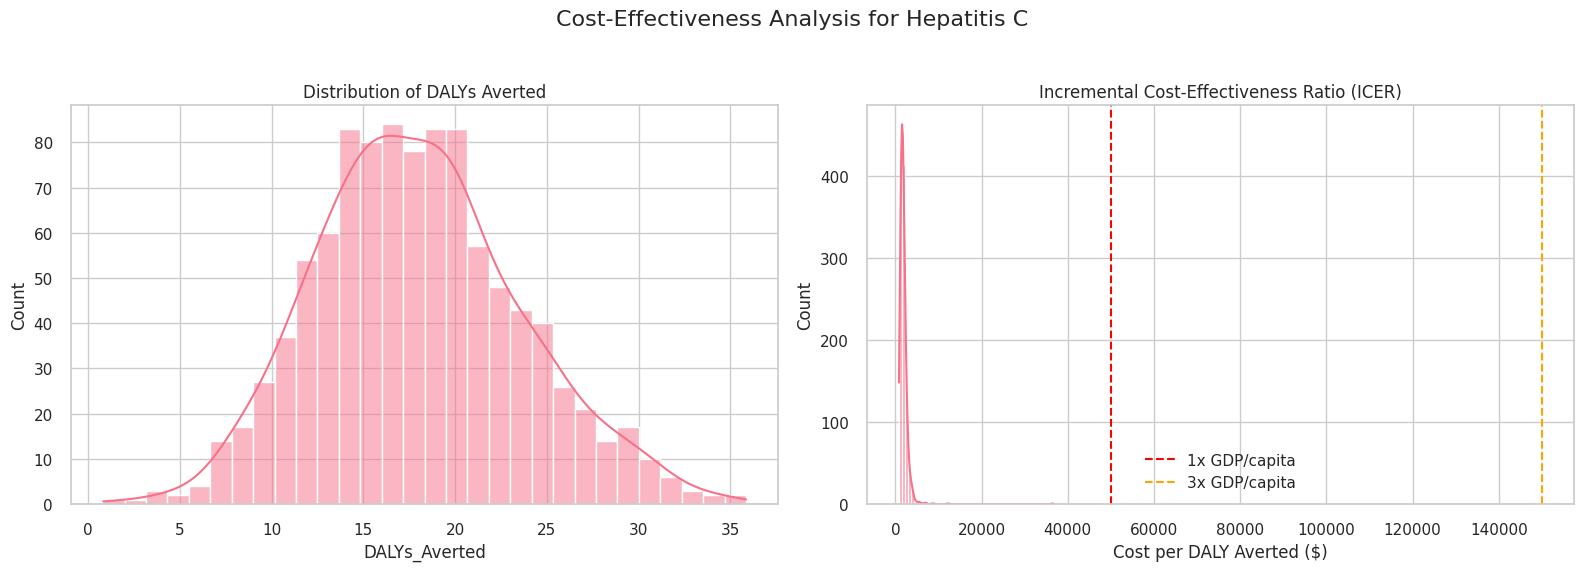

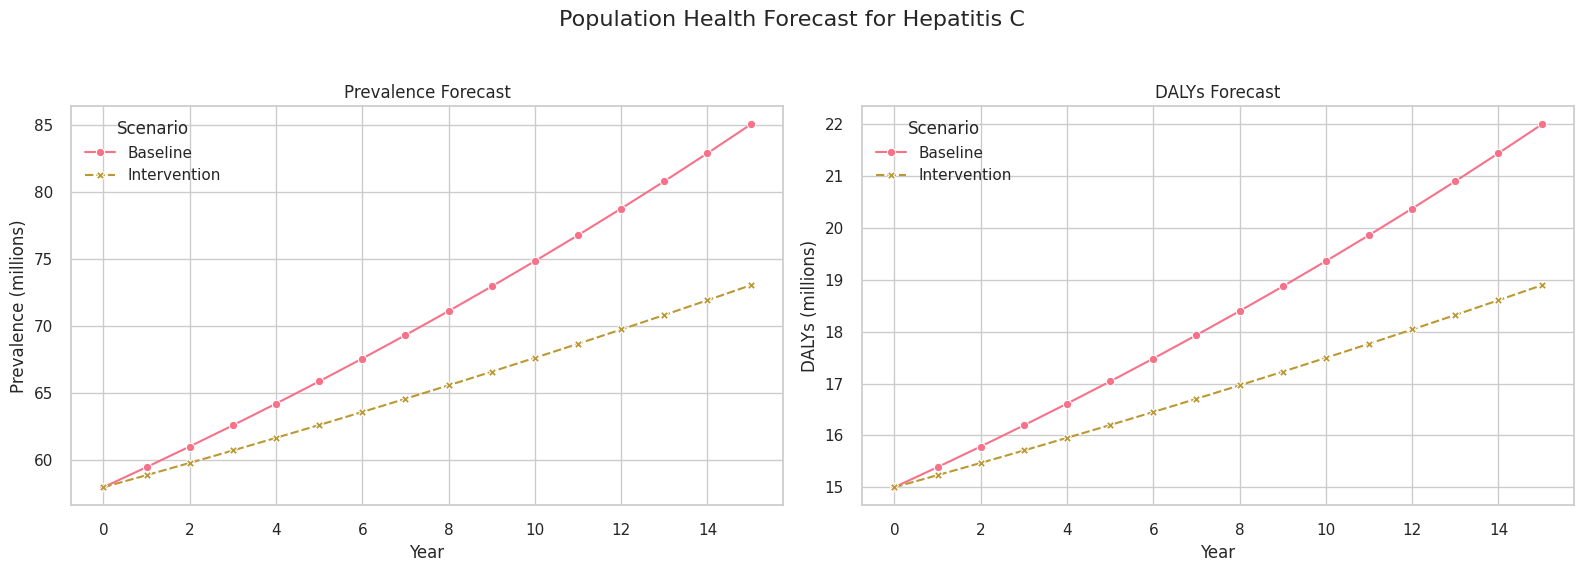

In [ ]:
# @title Advanced Biomedical Calculator with Hemophilia and Hepatitis C
# @markdown ## Health Equity Framework with Advanced Modeling

# This version has been updated to include detailed models for Hemophilia and Hepatitis C.

# --- DEPENDENCIES ---
!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines kaleido --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import weibull_min
from IPython.display import display, Markdown
import requests

# --- SETTINGS ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedBiomedicalCalculator:
    """
    Enhanced calculator with specialized modules for Hemophilia and Hepatitis C.
    """
    def __init__(self, standard_life_expectancy=85, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_public_datasets()

    def load_public_datasets(self):
        """Load sample public health datasets"""
        # MODIFIED: Added Hepatitis C data
        self.gbd_data = pd.DataFrame({
            'Disease': ['HIV/AIDS', 'Diabetes', 'Hemophilia A', 'Hepatitis C'],
            'DALYs (millions)': [58.3, 67.9, 0.5, 15.0],
            'Prevalence (millions)': [38, 463, 0.07, 58.0],
            'Incidence (millions/year)': [1.7, 22, 0.0004, 1.5]
        })
        self.country_data = pd.DataFrame({
            'Country': ['USA', 'UK', 'India', 'Brazil'], 'GDP_per_capita': [65000, 45000, 2200, 8800]
        })

        # MODIFIED: Added Hepatitis C to the disease models
        self.disease_models = {
            'HIV/AIDS': {
                'progression': weibull_min(2.5, scale=10),
                'costs': {'annual_care': 7000, 'dalys_per_case': 28}
            },
            'Diabetes': {
                'progression': weibull_min(3.0, scale=15),
                'costs': {'annual_care': 4500, 'dalys_per_case': 15}
            },
            'Hemophilia A': {
                'weights': [0.5, 0.4, 0.4, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30),
                'costs': {'annual_care': 300000, 'dalys_per_case': 25},
                'joint_damage': {
                    'Stage 1': {'qol_penalty': 0.1}, 'Stage 2': {'qol_penalty': 0.3}, 'Stage 3': {'qol_penalty': 0.6}
                }
            },
            # NEW: Detailed model for Hepatitis C
            'Hepatitis C': {
                'costs': {'annual_monitoring': 500, 'cirrhosis_care': 15000, 'hcc_care': 100000, 'dalys_per_case': 20},
                'fibrosis_stages': {
                    'F0-F2': {'qol': 0.95, 'prob_progress': 0.08}, # 8% chance/year to progress to F3
                    'F3':    {'qol': 0.85, 'prob_progress': 0.12}, # 12% chance/year to progress to F4
                    'F4 (Cirrhosis)': {'qol': 0.70, 'prob_hcc': 0.03, 'prob_decomp': 0.04}, # 3% chance of HCC, 4% chance of decompensation
                    'Decompensated':  {'qol': 0.40, 'mortality_risk': 0.15}, # 15% annual mortality
                    'HCC':            {'qol': 0.50, 'mortality_risk': 0.25}  # 25% annual mortality
                }
            }
        }

    # --- DISEASE PROGRESSION MODELS ---

    # NEW: Specialized state-transition model for Hepatitis C progression
    def simulate_hepatitis_progression(self, years=30, n_patients=1000):
        """Simulates a cohort of HCV patients transitioning through liver fibrosis stages."""
        model = self.disease_models['Hepatitis C']['fibrosis_stages']

        # Track patient distribution across states
        states = {s: 0 for s in model.keys()}
        states['F0-F2'] = n_patients

        history = []

        for year in range(years):
            # Transitions for this year
            t_f2_f3 = states['F0-F2'] * model['F0-F2']['prob_progress']
            t_f3_f4 = states['F3'] * model['F3']['prob_progress']
            t_f4_hcc = states['F4 (Cirrhosis)'] * model['F4 (Cirrhosis)']['prob_hcc']
            t_f4_dc = states['F4 (Cirrhosis)'] * model['F4 (Cirrhosis)']['prob_decomp']

            # Deaths for this year
            deaths = (states['Decompensated'] * model['Decompensated']['mortality_risk'] +
                      states['HCC'] * model['HCC']['mortality_risk'])

            # Update states
            states['F0-F2'] -= t_f2_f3
            states['F3'] += t_f2_f3 - t_f3_f4
            states['F4 (Cirrhosis)'] += t_f3_f4 - t_f4_hcc - t_f4_dc
            states['HCC'] += t_f4_hcc
            states['Decompensated'] += t_f4_dc

            # Remove patients who died
            for state in ['Decompensated', 'HCC']:
                states[state] -= states[state] * model[state]['mortality_risk']

            # Calculate cohort metrics for this year
            total_patients = sum(states.values())
            if total_patients == 0: continue

            survival_prob = total_patients / n_patients
            avg_qol = sum(states[s] * model[s]['qol'] for s in states) / total_patients
            avg_bp = survival_prob * avg_qol * self.standard_le

            history.append({'Year': year, 'Survival': survival_prob, 'Avg_QoL': avg_qol, 'BP': avg_bp})

        return pd.DataFrame(history)

    def simulate_hemophilia_progression(self, years=50):
        """Simulates BP trajectory for Hemophilia with joint damage stages."""
        model = self.disease_models['Hemophilia A']
        time_points = np.linspace(0, years, 100)
        survival_probs = model['progression'].sf(time_points)
        bp_values = []
        for t in time_points:
            stage_num = min(int(t / 15) + 1, 3)
            current_stage = f'Stage {stage_num}'
            adj_weights = model['weights'].copy()
            penalty = model['joint_damage'][current_stage]['qol_penalty']
            adj_weights[0] = min(1, adj_weights[0] + penalty / 2)
            adj_weights[1] = min(1, adj_weights[1] + penalty / 2)
            qol = max(0, 1 - (sum(adj_weights) * self.scaling_factor))
            bp_values.append(qol)

        final_bp = [s * q * self.standard_le for s, q in zip(survival_probs, bp_values)]
        return pd.DataFrame({'Year': time_points, 'BP': final_bp})

    # MODIFIED: plot_disease_progression now dispatches to the correct model
    def plot_disease_progression(self, disease_name):
        """Visualize disease progression, using the correct specialized model."""
        if 'Hemophilia' in disease_name:
            progression_df = self.simulate_hemophilia_progression()
            title = 'Biomedical Potential: Moderate Hemophilia A (with Joint Damage)'
        elif 'Hepatitis' in disease_name:
            progression_df = self.simulate_hepatitis_progression()
            title = 'Biomedical Potential: Hepatitis C Cohort (Fibrosis Progression)'
        else:
            # Fallback for generic models
            model = self.disease_models[disease_name]
            time_points = np.linspace(0, 20, 100)
            survival = model['progression'].sf(time_points)
            qol = np.linspace(1, 0.5, 100)
            bp = [s*q*self.standard_le for s,q in zip(survival, qol)]
            progression_df = pd.DataFrame({'Year': time_points, 'BP': bp})
            title = f'Biomedical Potential: {disease_name} (Generic Model)'

        fig = px.line(progression_df, x='Year', y='BP', title=title)
        fig.update_layout(yaxis_title='Biomedical Potential (BP)')
        fig.show()

    # --- COST-EFFECTIVENESS & FORECASTING (MODIFIED TO HANDLE HCV) ---
    def run_cost_effectiveness_simulation(self, disease_name, intervention_cost, n_simulations=1000):
        """Monte Carlo simulation of cost-effectiveness"""
        model = self.disease_models[disease_name]

        if 'Hemophilia' in disease_name:
            base_cost = model['costs']['annual_care'] * 20
        elif 'Hepatitis' in disease_name:
            # Base cost is managing chronic HCV for 20 years vs. a one-time cure
            base_cost = model['costs']['annual_monitoring'] * 20
        else: # Generic
            base_cost = model['costs']['annual_care']

        dalys_mean = model['costs']['dalys_per_case']
        results = []
        for _ in range(n_simulations):
            control_dalys = np.random.normal(dalys_mean, 5)
            effect_size = np.random.uniform(0.7, 1.3)
            # Assume intervention reduces DALYs by 90% for a cure like HCV DAAs
            reduction_factor = 0.9 if 'Hepatitis' in disease_name else 0.8
            intervention_dalys = control_dalys * (1 - (reduction_factor * effect_size))
            cost_diff = intervention_cost - base_cost
            dalys_diff = control_dalys - intervention_dalys
            icer = cost_diff / dalys_diff if dalys_diff > 0 else float('inf')
            results.append({'DALYs_Averted': dalys_diff, 'ICER': icer})
        return pd.DataFrame(results)

    def plot_cost_effectiveness(self, disease_name, intervention_cost, gdp_per_capita):
        """Visualize cost-effectiveness simulation results"""
        # ... (This function's plotting logic remains the same)
        results = self.run_cost_effectiveness_simulation(disease_name, intervention_cost)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Cost-Effectiveness Analysis for {disease_name}", fontsize=16)
        sns.histplot(results['DALYs_Averted'], bins=30, ax=ax1, kde=True)
        ax1.set_title('Distribution of DALYs Averted')
        valid_icers = results[results['ICER'].between(-200000, 500000)]['ICER']
        sns.histplot(valid_icers, bins=50, ax=ax2, kde=True)
        ax2.axvline(gdp_per_capita, color='r', linestyle='--', label='1x GDP/capita')
        ax2.axvline(3*gdp_per_capita, color='orange', linestyle='--', label='3x GDP/capita')
        ax2.set_title('Incremental Cost-Effectiveness Ratio (ICER)')
        ax2.set_xlabel('Cost per DALY Averted ($)')
        ax2.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def forecast_population_health(self, disease_name, intervention_effect, years=10):
        """Forecasts population burden. Uses data from gbd_data."""
        # ... (This function remains largely the same)
        row = self.gbd_data.loc[self.gbd_data['Disease'] == disease_name]
        if row.empty: raise ValueError(f"No GBD data for {disease_name}")
        current_prevalence = row['Prevalence (millions)'].values[0]
        base_dalys = row['DALYs (millions)'].values[0]
        incidence_rate = row['Incidence (millions/year)'].values[0] / current_prevalence

        forecast_years = np.arange(0, years + 1)
        baseline = {
            'prevalence': current_prevalence * (1 + incidence_rate) ** forecast_years,
            'dalys': base_dalys * (1 + incidence_rate) ** forecast_years
        }
        intervention = {
            'prevalence': current_prevalence * ((1 + incidence_rate * (1 - intervention_effect)) ** forecast_years),
            'dalys': base_dalys * ((1 + incidence_rate * (1 - intervention_effect)) ** forecast_years)
        }
        results = pd.DataFrame({
            'Year': np.concatenate([forecast_years, forecast_years]),
            'Prevalence': np.concatenate([baseline['prevalence'], intervention['prevalence']]),
            'DALYs': np.concatenate([baseline['dalys'], intervention['dalys']]),
            'Scenario': ['Baseline'] * len(forecast_years) + ['Intervention'] * len(forecast_years)
        })

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Population Health Forecast for {disease_name}", fontsize=16)
        sns.lineplot(data=results, x='Year', y='Prevalence', hue='Scenario', style='Scenario', markers=True, ax=ax1)
        ax1.set_title('Prevalence Forecast'); ax1.set_ylabel('Prevalence (millions)')
        sns.lineplot(data=results, x='Year', y='DALYs', hue='Scenario', style='Scenario', markers=True, ax=ax2)
        ax2.set_title('DALYs Forecast'); ax2.set_ylabel('DALYs (millions)')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


# --- EXECUTION SCRIPT ---
abp = AdvancedBiomedicalCalculator()

# @markdown ## 1. Disease Progression Modeling
# MODIFIED: Added Hepatitis C to the dropdown list.
disease_select = "Hepatitis C" # @param ["HIV/AIDS", "Diabetes", "Hemophilia A", "Hepatitis C"]
abp.plot_disease_progression(disease_select)

# @markdown ## 2. Cost-Effectiveness Simulation
# @markdown Run for Hepatitis C to see the CEA of a DAA cure.
disease_for_cea = "Hepatitis C" # @param ["HIV/AIDS", "Diabetes", "Hemophilia A", "Hepatitis C"]
intervention_cost = 40000 # @param {type:"slider", min:10000, max:100000, step:1000}
gdp_per_capita = 50000 # @param {type:"slider", min:500, max:100000, step:500}
abp.plot_cost_effectiveness(disease_for_cea, intervention_cost, gdp_per_capita)

# @markdown ## 3. Population Health Forecasting
# @markdown Models a "test-and-treat" campaign for Hepatitis C.
disease_for_forecast = "Hepatitis C" # @param ["HIV/AIDS", "Diabetes", "Hemophilia A", "Hepatitis C"]
intervention_effect = 0.4 # @param {type:"slider", min:0, max:1, step:0.05}
forecast_years = 15 # @param {type:"slider", min:5, max:30, step:1}
abp.forecast_population_health(disease_for_forecast, intervention_effect, forecast_years)

In [ ]:
# @title Advanced Health-Economic Model with Comorbidity Engine
# @markdown ## Models Hemophilia, Hepatitis C, and Their Combined Impact

# --- DEPENDENCIES ---
!pip install pandas numpy matplotlib seaborn plotly scipy kaleido --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import weibull_min
from IPython.display import display, Markdown

# --- SETTINGS ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedHealthModel:
    """
    Enhanced calculator with a comorbidity engine to model the combined
    impact of multiple diseases, including various bleeding disorders.
    """
    def __init__(self, standard_life_expectancy=80, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_disease_data()

    def load_disease_data(self):
        """Loads data for all supported diseases and their interactions."""
        # // NEW // Expanded the list to include all bleeding disorders
        self.disease_models = {
            # --- BLEEDING DISORDERS ---
            'Hemophilia A': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.5, 0.4, 0.4, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30), 'costs': {'annual_care': 300000, 'dalys_per_case': 25}
            },
            'Hemophilia B': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.4, 0.4, 0.3, 0.2, 0.2],
                'progression': weibull_min(2.2, scale=35), 'costs': {'annual_care': 280000, 'dalys_per_case': 22}
            },
            'von Willebrand Disease': {
                'type': 'hemophilia', 'severity': 'Mild', 'weights': [0.2, 0.1, 0.1, 0.3, 0.1], # Bleeding is higher
                'progression': weibull_min(2.0, scale=50), 'costs': {'annual_care': 50000, 'dalys_per_case': 10}
            },
            'Inhibitors': {
                'type': 'hemophilia', 'severity': 'Severe', 'weights': [0.9, 0.8, 0.8, 0.7, 0.6],
                'progression': weibull_min(3.5, scale=15), 'costs': {'annual_care': 800000, 'dalys_per_case': 35}
            },
            # --- OTHER DISEASES ---
            'Hepatitis C': {
                'type': 'hepatitis', 'progression': weibull_min(3.0, scale=25), # Survival impact if untreated
                'costs': {'annual_monitoring': 500, 'cirrhosis_care': 15000, 'dalys_per_case': 20},
                'fibrosis_stages': {
                    'F0-F2': {'qol': 0.95, 'burden': 0.05}, 'F3': {'qol': 0.85, 'burden': 0.15},
                    'F4 (Cirrhosis)': {'qol': 0.70, 'burden': 0.30}, 'Decompensated': {'qol': 0.40, 'burden': 0.60},
                    'HCC': {'qol': 0.50, 'burden': 0.50}
                }
            }
        }

        # // NEW // Comorbidity Interaction Engine
        # Defines extra penalties when diseases are mixed. Using frozenset for order-independent keys.
        self.comorbidity_interactions = {
            frozenset(['Hemophilia A', 'Hepatitis C']): {'qol_burden_penalty': 0.1, 'survival_multiplier': 0.9},
            frozenset(['Inhibitors', 'Hepatitis C']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.85}
        }

    # --- DISEASE PROGRESSION & COMORBIDITY ENGINE ---

    def get_qol_burden(self, disease, time):
        """Calculates the QoL burden (0=perfect, 1=death) for a single disease at a given time."""
        model = self.disease_models[disease]

        if model['type'] == 'hemophilia':
            stage_num = min(int(time / 15) + 1, 3)
            penalty = model.get('joint_damage', {}).get(f'Stage {stage_num}', {}).get('qol_penalty', 0) if model.get('severity') != 'Mild' else 0
            weights = model['weights'].copy()
            weights[0] += penalty / 2; weights[1] += penalty / 2
            return sum(weights) * self.scaling_factor

        if model['type'] == 'hepatitis':
            if time < 10: return model['fibrosis_stages']['F0-F2']['burden']
            if time < 20: return model['fibrosis_stages']['F3']['burden']
            return model['fibrosis_stages']['F4 (Cirrhosis)']['burden']

        return 0.2 # Generic burden

    def simulate_patient_journey(self, disease_list, years=50):
        """
        // NEW // The core comorbidity engine. Simulates a patient with one or more diseases.
        """
        time_points = np.linspace(0, years, 100)
        history = []

        for t in time_points:
            combined_survival = 1.0
            combined_qol_burden = 0.0

            # Step 1: Calculate combined effects from individual diseases
            for disease in disease_list:
                model = self.disease_models[disease]
                # Multiply survival probabilities
                combined_survival *= model['progression'].sf(t)
                # Sum QoL burdens
                combined_qol_burden += self.get_qol_burden(disease, t)

            # Step 2: Apply comorbidity interaction penalties
            disease_set = frozenset(disease_list)
            if disease_set in self.comorbidity_interactions:
                interaction = self.comorbidity_interactions[disease_set]
                combined_qol_burden += interaction.get('qol_burden_penalty', 0)
                combined_survival *= interaction.get('survival_multiplier', 1.0)

            # Step 3: Calculate final metrics for this time point
            final_qol = max(0, 1 - combined_qol_burden)
            final_bp = combined_survival * final_qol * self.standard_le
            history.append({'Year': t, 'BP': final_bp})

        return pd.DataFrame(history)

    def plot_patient_progression(self, diseases_str, years=50):
        """Visualizes the patient journey, parsing the input string."""
        # Parse the comma-separated string into a list of diseases
        disease_list = [d.strip() for d in diseases_str.split(',')]
        title = f"Biomedical Potential: {', '.join(disease_list)}"

        progression_df = self.simulate_patient_journey(disease_list, years)

        fig = px.line(progression_df, x='Year', y='BP', title=title)
        fig.update_layout(yaxis_title='Biomedical Potential (BP)')
        fig.show()

# --- EXECUTION SCRIPT ---
model = AdvancedHealthModel()

# @markdown ## Patient Progression with Comorbidity
# @markdown **Instructions:**
# @markdown - To model a single disease, enter its name (e.g., `Hemophilia A`).
# @markdown - To model comorbidity, enter names separated by a comma (e.g., `Hemophilia A, Hepatitis C`).

diseases_to_model = "Hemophilia B, Hepatitis C" # @param {type:"string"}
model.plot_patient_progression(diseases_to_model)

# @markdown ---
# @markdown You can also run single-disease simulations to compare:
single_disease = "Hepatitis C" # @param ["Hemophilia A", "Hemophilia B", "von Willebrand Disease", "Inhibitors", "Hepatitis C"]
model.plot_patient_progression(single_disease)

In [ ]:
# @title Advanced Health-Economic Model with Comorbidity Engine
# @markdown ## Models Bleeding Disorders, Hepatitis C, HIV, Arthritis, and Their Combined Impact

# --- DEPENDENCIES ---
!pip install pandas numpy matplotlib seaborn plotly scipy kaleido --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import weibull_min
from IPython.display import display, Markdown

# --- SETTINGS ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedHealthModel:
    """
    Enhanced calculator with a comorbidity engine to model the combined
    impact of multiple diseases, including various bleeding disorders.
    """
    def __init__(self, standard_life_expectancy=80, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_disease_data()

    def load_disease_data(self):
        """Loads data for all supported diseases and their interactions."""
        self.disease_models = {
            # --- BLEEDING DISORDERS ---
            'Hemophilia A': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.5, 0.4, 0.4, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30), 'costs': {'annual_care': 300000, 'dalys_per_case': 25}
            },
            'Hemophilia B': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.4, 0.4, 0.3, 0.2, 0.2],
                'progression': weibull_min(2.2, scale=35), 'costs': {'annual_care': 280000, 'dalys_per_case': 22}
            },
            'von Willebrand Disease': {
                'type': 'hemophilia', 'severity': 'Mild', 'weights': [0.2, 0.1, 0.1, 0.3, 0.1], # Bleeding is higher
                'progression': weibull_min(2.0, scale=50), 'costs': {'annual_care': 50000, 'dalys_per_case': 10}
            },
            'Inhibitors': {
                'type': 'hemophilia', 'severity': 'Severe', 'weights': [0.9, 0.8, 0.8, 0.7, 0.6],
                'progression': weibull_min(3.5, scale=15), 'costs': {'annual_care': 800000, 'dalys_per_case': 35}
            },
            # --- OTHER DISEASES ---
            'Hepatitis C': {
                'type': 'hepatitis', 'progression': weibull_min(3.0, scale=25), # Survival impact if untreated
                'costs': {'annual_monitoring': 500, 'cirrhosis_care': 15000, 'dalys_per_case': 20},
                'fibrosis_stages': {
                    'F0-F2': {'qol': 0.95, 'burden': 0.05}, 'F3': {'qol': 0.85, 'burden': 0.15},
                    'F4 (Cirrhosis)': {'qol': 0.70, 'burden': 0.30}, 'Decompensated': {'qol': 0.40, 'burden': 0.60},
                    'HCC': {'qol': 0.50, 'burden': 0.50}
                }
            },
            # // NEW // Added HIV model
            'HIV': {
                'type': 'hiv', 'progression': weibull_min(3.0, scale=12), # Untreated progression
                'costs': {'annual_care': 25000, 'dalys_per_case': 28},
                'stages': {
                    'Asymptomatic': {'qol': 0.90, 'burden': 0.10}, # 0-5 years
                    'Symptomatic': {'qol': 0.75, 'burden': 0.25},  # 5-10 years
                    'AIDS': {'qol': 0.50, 'burden': 0.50}          # >10 years
                }
            },
            # // NEW // Added Arthritis model
            'Arthritis': {
                'type': 'inflammatory', 'progression': weibull_min(2.0, scale=60), # Lower direct mortality
                'costs': {'annual_care': 8000, 'dalys_per_case': 12},
                'stages': {
                    'Mild': {'qol': 0.92, 'burden': 0.08},     # 0-15 years
                    'Moderate': {'qol': 0.80, 'burden': 0.20}, # 15-30 years
                    'Severe': {'qol': 0.65, 'burden': 0.35}    # >30 years
                }
            }
        }

        # // NEW // Expanded Comorbidity Interaction Engine
        # Defines extra penalties when diseases are mixed. Using frozenset for order-independent keys.
        self.comorbidity_interactions = {
            # Existing Interactions
            frozenset(['Hemophilia A', 'Hepatitis C']): {'qol_burden_penalty': 0.1, 'survival_multiplier': 0.9},
            frozenset(['Inhibitors', 'Hepatitis C']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.85},

            # New Interactions for HIV
            frozenset(['Hemophilia A', 'HIV']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.80},
            frozenset(['Hemophilia B', 'HIV']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.80},
            frozenset(['Inhibitors', 'HIV']): {'qol_burden_penalty': 0.20, 'survival_multiplier': 0.75},
            frozenset(['Hepatitis C', 'HIV']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.85},

            # New Interactions for Arthritis
            frozenset(['Hemophilia A', 'Arthritis']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.98},
            frozenset(['Hemophilia B', 'Arthritis']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.98},
            frozenset(['Inhibitors', 'Arthritis']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.95}
        }

    # --- DISEASE PROGRESSION & COMORBIDITY ENGINE ---

    def get_qol_burden(self, disease, time):
        """Calculates the QoL burden (0=perfect, 1=death) for a single disease at a given time."""
        model = self.disease_models.get(disease)
        if not model: return 0.2 # Return a generic burden if disease not found

        if model['type'] == 'hemophilia':
            stage_num = min(int(time / 15) + 1, 3)
            penalty = model.get('joint_damage', {}).get(f'Stage {stage_num}', {}).get('qol_penalty', 0) if model.get('severity') != 'Mild' else 0
            weights = model['weights'].copy()
            weights[0] += penalty / 2; weights[1] += penalty / 2
            return sum(weights) * self.scaling_factor

        if model['type'] == 'hepatitis':
            if time < 10: return model['fibrosis_stages']['F0-F2']['burden']
            if time < 20: return model['fibrosis_stages']['F3']['burden']
            return model['fibrosis_stages']['F4 (Cirrhosis)']['burden']

        # // NEW // Added logic for HIV progression
        if model['type'] == 'hiv':
            if time < 5: return model['stages']['Asymptomatic']['burden']
            if time < 10: return model['stages']['Symptomatic']['burden']
            return model['stages']['AIDS']['burden']

        # // NEW // Added logic for Arthritis progression
        if model['type'] == 'inflammatory':
            if time < 15: return model['stages']['Mild']['burden']
            if time < 30: return model['stages']['Moderate']['burden']
            return model['stages']['Severe']['burden']

        return 0.2 # Generic burden for any other unhandled type

    def simulate_patient_journey(self, disease_list, years=50):
        """
        The core comorbidity engine. Simulates a patient with one or more diseases.
        """
        # // NEW // Added validation for input diseases
        valid_diseases = [d for d in disease_list if d in self.disease_models]
        if not valid_diseases:
            print(f"Warning: None of the specified diseases {disease_list} are recognized. Aborting simulation.")
            return pd.DataFrame()
        if len(valid_diseases) != len(disease_list):
            invalid_diseases = set(disease_list) - set(valid_diseases)
            print(f"Warning: The following diseases are not recognized and will be ignored: {list(invalid_diseases)}")

        time_points = np.linspace(0, years, 100)
        history = []

        for t in time_points:
            combined_survival = 1.0
            combined_qol_burden = 0.0

            # Step 1: Calculate combined effects from individual diseases
            for disease in valid_diseases:
                model = self.disease_models[disease]
                # Multiply survival probabilities
                combined_survival *= model['progression'].sf(t)
                # Sum QoL burdens
                combined_qol_burden += self.get_qol_burden(disease, t)

            # Step 2: Apply comorbidity interaction penalties
            # Check all possible 2-disease combinations within the patient's list
            from itertools import combinations
            for combo in combinations(valid_diseases, 2):
                interaction_key = frozenset(combo)
                if interaction_key in self.comorbidity_interactions:
                    interaction = self.comorbidity_interactions[interaction_key]
                    combined_qol_burden += interaction.get('qol_burden_penalty', 0)
                    combined_survival *= interaction.get('survival_multiplier', 1.0)

            # Step 3: Calculate final metrics for this time point
            final_qol = max(0, 1 - combined_qol_burden)
            final_bp = combined_survival * final_qol * self.standard_le
            history.append({'Year': t, 'BP': final_bp})

        return pd.DataFrame(history)

    def plot_patient_progression(self, diseases_str, years=50):
        """Visualizes the patient journey, parsing the input string."""
        # Parse the comma-separated string into a list of diseases
        disease_list = [d.strip() for d in diseases_str.split(',') if d.strip()]
        if not disease_list:
            print("Please enter at least one disease name.")
            return

        progression_df = self.simulate_patient_journey(disease_list, years)

        if not progression_df.empty:
            title = f"Biomedical Potential: {', '.join(disease_list)}"
            fig = px.line(progression_df, x='Year', y='BP', title=title)
            fig.update_layout(yaxis_title='Biomedical Potential (BP)')
            fig.show()

# --- EXECUTION SCRIPT ---
model = AdvancedHealthModel()

# @markdown ## Patient Progression with Comorbidity
# @markdown **Instructions:**
# @markdown - To model a single disease, enter its name (e.g., `Hemophilia A`).
# @markdown - To model comorbidity, enter names separated by a comma (e.g., `Inhibitors, HIV`).
# @markdown - **Available Diseases:** `Hemophilia A`, `Hemophilia B`, `von Willebrand Disease`, `Inhibitors`, `Hepatitis C`, `HIV`, `Arthritis`

diseases_to_model = "von Willebrand Disease, HIV" # @param {type:"string"}
model.plot_patient_progression(diseases_to_model)

# @markdown ---
# @markdown You can also run single-disease simulations to compare:
single_disease = "von Willebrand Disease" # @param ["Hemophilia A", "Hemophilia B", "von Willebrand Disease", "Inhibitors", "Hepatitis C", "HIV", "Arthritis"]
model.plot_patient_progression(single_disease)

In [ ]:
# @title Advanced Health-Economic Model with Comorbidity Engine
# @markdown ## Models Bleeding Disorders, Hepatitis C, HIV, Arthritis, Mental Illness, and Their Combined Impact

# --- DEPENDENCIES ---
!pip install pandas numpy matplotlib seaborn plotly scipy kaleido --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import weibull_min
from IPython.display import display, Markdown
from itertools import combinations

# --- SETTINGS ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedHealthModel:
    """
    Enhanced calculator with a comorbidity engine to model the combined
    impact of multiple diseases, including various bleeding disorders.
    """
    def __init__(self, standard_life_expectancy=80, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_disease_data()

    def load_disease_data(self):
        """Loads data for all supported diseases and their interactions."""
        self.disease_models = {
            # --- BLEEDING DISORDERS ---
            'Hemophilia A': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.5, 0.4, 0.4, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30), 'costs': {'annual_care': 300000, 'dalys_per_case': 25}
            },
            'Hemophilia B': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.4, 0.4, 0.3, 0.2, 0.2],
                'progression': weibull_min(2.2, scale=35), 'costs': {'annual_care': 280000, 'dalys_per_case': 22}
            },
            'von Willebrand Disease': {
                'type': 'hemophilia', 'severity': 'Mild', 'weights': [0.2, 0.1, 0.1, 0.3, 0.1],
                'progression': weibull_min(2.0, scale=50), 'costs': {'annual_care': 50000, 'dalys_per_case': 10}
            },
            'Inhibitors': {
                'type': 'hemophilia', 'severity': 'Severe', 'weights': [0.9, 0.8, 0.8, 0.7, 0.6],
                'progression': weibull_min(3.5, scale=15), 'costs': {'annual_care': 800000, 'dalys_per_case': 35}
            },
            # --- OTHER DISEASES ---
            'Hepatitis C': {
                'type': 'hepatitis', 'progression': weibull_min(3.0, scale=25),
                'costs': {'annual_monitoring': 500, 'cirrhosis_care': 15000, 'dalys_per_case': 20},
                'fibrosis_stages': {
                    'F0-F2': {'burden': 0.05}, 'F3': {'burden': 0.15}, 'F4 (Cirrhosis)': {'burden': 0.30}
                }
            },
            'HIV': {
                'type': 'hiv', 'progression': weibull_min(3.0, scale=12), # Untreated progression
                'costs': {'annual_care': 25000, 'dalys_per_case': 28},
                'stages': {
                    'Asymptomatic': {'burden': 0.10}, 'Symptomatic': {'burden': 0.25}, 'AIDS': {'burden': 0.50}
                }
            },
            'Arthritis': {
                'type': 'inflammatory', 'progression': weibull_min(2.0, scale=60),
                'costs': {'annual_care': 8000, 'dalys_per_case': 12},
                'stages': {
                    'Mild': {'burden': 0.08}, 'Moderate': {'burden': 0.20}, 'Severe': {'burden': 0.35}
                }
            },
            # // NEW // Added Mental Illness model
            'Mental Illness': {
                'type': 'mental_health', 'progression': weibull_min(2.0, scale=60), # Represents increased all-cause mortality
                'costs': {'annual_care': 6000, 'dalys_per_case': 15},
                'stages': {
                    'Mild/Episodic': {'burden': 0.12},       # 0-10 years
                    'Moderate/Persistent': {'burden': 0.25}, # 10-25 years
                    'Severe/Refractory': {'burden': 0.45}    # >25 years
                }
            }
        }

        # // NEW // Expanded Comorbidity Interaction Engine
        self.comorbidity_interactions = {
            frozenset(['Hemophilia A', 'Hepatitis C']): {'qol_burden_penalty': 0.1, 'survival_multiplier': 0.9},
            frozenset(['Inhibitors', 'Hepatitis C']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.85},
            frozenset(['Hemophilia A', 'HIV']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.80},
            frozenset(['Inhibitors', 'HIV']): {'qol_burden_penalty': 0.20, 'survival_multiplier': 0.75},
            frozenset(['Hepatitis C', 'HIV']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.85},
            frozenset(['Hemophilia A', 'Arthritis']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.98},
            frozenset(['Inhibitors', 'Arthritis']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.95},
            # Interactions with Mental Illness
            frozenset(['Hemophilia A', 'Mental Illness']): {'qol_burden_penalty': 0.12, 'survival_multiplier': 0.97},
            frozenset(['Inhibitors', 'Mental Illness']): {'qol_burden_penalty': 0.18, 'survival_multiplier': 0.92},
            frozenset(['HIV', 'Mental Illness']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.95},
            frozenset(['Arthritis', 'Mental Illness']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.98},
            frozenset(['Hepatitis C', 'Mental Illness']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.96},
        }

    # --- DISEASE PROGRESSION & COMORBIDITY ENGINE ---

    def get_qol_burden(self, disease, time):
        """Calculates the QoL burden (0=perfect, 1=death) for a single disease at a given time."""
        model = self.disease_models.get(disease)
        if not model: return 0.2

        if model['type'] == 'hemophilia':
            weights = model['weights'].copy()
            return sum(weights) * self.scaling_factor

        if model['type'] == 'hepatitis':
            if time < 10: return model['fibrosis_stages']['F0-F2']['burden']
            if time < 20: return model['fibrosis_stages']['F3']['burden']
            return model['fibrosis_stages']['F4 (Cirrhosis)']['burden']

        if model['type'] == 'hiv':
            if time < 5: return model['stages']['Asymptomatic']['burden']
            if time < 10: return model['stages']['Symptomatic']['burden']
            return model['stages']['AIDS']['burden']

        if model['type'] == 'inflammatory':
            if time < 15: return model['stages']['Mild']['burden']
            if time < 30: return model['stages']['Moderate']['burden']
            return model['stages']['Severe']['burden']

        # // NEW // Added logic for Mental Illness progression
        if model['type'] == 'mental_health':
            if time < 10: return model['stages']['Mild/Episodic']['burden']
            if time < 25: return model['stages']['Moderate/Persistent']['burden']
            return model['stages']['Severe/Refractory']['burden']

        return 0.2

    def simulate_patient_journey(self, disease_list, years=50):
        """
        The core comorbidity engine. Simulates a patient with one or more diseases.
        """
        valid_diseases = [d for d in disease_list if d in self.disease_models]
        if not valid_diseases:
            print(f"Warning: None of the specified diseases {disease_list} are recognized. Aborting simulation.")
            return pd.DataFrame()
        if len(valid_diseases) != len(disease_list):
            invalid_diseases = set(disease_list) - set(valid_diseases)
            print(f"Warning: The following diseases are not recognized and will be ignored: {list(invalid_diseases)}")

        time_points = np.linspace(0, years, 100)
        history = []

        for t in time_points:
            combined_survival = 1.0
            combined_qol_burden = 0.0

            # Step 1: Calculate combined effects from individual diseases
            for disease in valid_diseases:
                model = self.disease_models[disease]
                combined_survival *= model['progression'].sf(t)
                combined_qol_burden += self.get_qol_burden(disease, t)

            # Step 2: Apply comorbidity interaction penalties
            for combo in combinations(valid_diseases, 2):
                interaction_key = frozenset(combo)
                if interaction_key in self.comorbidity_interactions:
                    interaction = self.comorbidity_interactions[interaction_key]
                    combined_qol_burden += interaction.get('qol_burden_penalty', 0)
                    combined_survival *= interaction.get('survival_multiplier', 1.0)

            # Step 3: Calculate final metrics
            final_qol = max(0, 1 - combined_qol_burden)
            final_bp = combined_survival * final_qol * self.standard_le
            history.append({'Year': t, 'BP': final_bp})

        return pd.DataFrame(history)

    def plot_patient_progression(self, diseases_str, years=50):
        """Visualizes the patient journey, parsing the input string."""
        disease_list = [d.strip() for d in diseases_str.split(',') if d.strip()]
        if not disease_list:
            print("Please enter at least one disease name.")
            return

        progression_df = self.simulate_patient_journey(disease_list, years)

        if not progression_df.empty:
            title = f"Biomedical Potential: {', '.join(disease_list)}"
            fig = px.line(progression_df, x='Year', y='BP', title=title)
            fig.update_layout(yaxis_title='Biomedical Potential (BP)')
            fig.show()

# --- EXECUTION SCRIPT ---
model = AdvancedHealthModel()

# @markdown ## Patient Progression with Comorbidity
# @markdown **Instructions:**
# @markdown - To model a single disease, enter its name (e.g., `Hemophilia A`).
# @markdown - To model comorbidity, enter names separated by a comma (e.g., `Inhibitors, Mental Illness`).
# @markdown - **Available Diseases:** `Hemophilia A`, `Hemophilia B`, `von Willebrand Disease`, `Inhibitors`, `Hepatitis C`, `HIV`, `Arthritis`, `Mental Illness`

diseases_to_model = " Arthritis,HIV" # @param {type:"string"}
model.plot_patient_progression(diseases_to_model)

# @markdown ---
# @markdown You can also run single-disease simulations to compare:
single_disease = "Arthritis" # @param ["Hemophilia A", "Hemophilia B", "von Willebrand Disease", "Inhibitors", "Hepatitis C", "HIV", "Arthritis", "Mental Illness"]
model.plot_patient_progression(single_disease)

In [ ]:
# @title Advanced Health-Economic Model with Comorbidity Engine
# @markdown ## Models Bleeding Disorders, Hepatitis C, HIV, Arthritis, Mental Illness, Diabetes, and Their Combined Impact

# --- DEPENDENCIES ---
!pip install pandas numpy matplotlib seaborn plotly scipy kaleido --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import weibull_min
from IPython.display import display, Markdown
from itertools import combinations

# --- SETTINGS ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedHealthModel:
    """
    Enhanced calculator with a comorbidity engine to model the combined
    impact of multiple diseases, including various bleeding disorders.
    """
    def __init__(self, standard_life_expectancy=80, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_disease_data()

    def load_disease_data(self):
        """Loads data for all supported diseases and their interactions."""
        self.disease_models = {
            # --- BLEEDING DISORDERS ---
            'Hemophilia A': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.5, 0.4, 0.4, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30), 'costs': {'annual_care': 300000, 'dalys_per_case': 25}
            },
            'Hemophilia B': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.4, 0.4, 0.3, 0.2, 0.2],
                'progression': weibull_min(2.2, scale=35), 'costs': {'annual_care': 280000, 'dalys_per_case': 22}
            },
            'von Willebrand Disease': {
                'type': 'hemophilia', 'severity': 'Mild', 'weights': [0.2, 0.1, 0.1, 0.3, 0.1],
                'progression': weibull_min(2.0, scale=50), 'costs': {'annual_care': 50000, 'dalys_per_case': 10}
            },
            'Inhibitors': {
                'type': 'hemophilia', 'severity': 'Severe', 'weights': [0.9, 0.8, 0.8, 0.7, 0.6],
                'progression': weibull_min(3.5, scale=15), 'costs': {'annual_care': 800000, 'dalys_per_case': 35}
            },
            # --- OTHER DISEASES ---
            'Hepatitis C': {
                'type': 'hepatitis', 'progression': weibull_min(3.0, scale=25),
                'costs': {'annual_monitoring': 500, 'cirrhosis_care': 15000, 'dalys_per_case': 20},
                'fibrosis_stages': {
                    'F0-F2': {'burden': 0.05}, 'F3': {'burden': 0.15}, 'F4 (Cirrhosis)': {'burden': 0.30}
                }
            },
            'HIV': {
                'type': 'hiv', 'progression': weibull_min(3.0, scale=12), # Untreated progression
                'costs': {'annual_care': 25000, 'dalys_per_case': 28},
                'stages': {
                    'Asymptomatic': {'burden': 0.10}, 'Symptomatic': {'burden': 0.25}, 'AIDS': {'burden': 0.50}
                }
            },
            'Arthritis': {
                'type': 'inflammatory', 'progression': weibull_min(2.0, scale=60),
                'costs': {'annual_care': 8000, 'dalys_per_case': 12},
                'stages': {
                    'Mild': {'burden': 0.08}, 'Moderate': {'burden': 0.20}, 'Severe': {'burden': 0.35}
                }
            },
            'Mental Illness': {
                'type': 'mental_health', 'progression': weibull_min(2.0, scale=60), # Represents increased all-cause mortality
                'costs': {'annual_care': 6000, 'dalys_per_case': 15},
                'stages': {
                    'Mild/Episodic': {'burden': 0.12},       # 0-10 years
                    'Moderate/Persistent': {'burden': 0.25}, # 10-25 years
                    'Severe/Refractory': {'burden': 0.45}    # >25 years
                }
            },
            # // NEW // Added Diabetes model
            'Diabetes': {
                'type': 'metabolic',
                'progression': weibull_min(2.2, scale=55), # Systemic impact on mortality
                'costs': {'annual_care': 7000, 'dalys_per_case': 18},
                'stages': {
                    'Controlled': {'burden': 0.10},          # 0-15 years
                    'Poorly Controlled': {'burden': 0.22},   # 15-30 years
                    'With Complications': {'burden': 0.40}   # >30 years
                }
            }
        }

        # // NEW // Expanded Comorbidity Interaction Engine
        self.comorbidity_interactions = {
            frozenset(['Hemophilia A', 'Hepatitis C']): {'qol_burden_penalty': 0.1, 'survival_multiplier': 0.9},
            frozenset(['Inhibitors', 'Hepatitis C']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.85},
            frozenset(['Hemophilia A', 'HIV']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.80},
            frozenset(['Inhibitors', 'HIV']): {'qol_burden_penalty': 0.20, 'survival_multiplier': 0.75},
            frozenset(['Hepatitis C', 'HIV']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.85},
            frozenset(['Hemophilia A', 'Arthritis']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.98},
            frozenset(['Inhibitors', 'Arthritis']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.95},
            # Interactions with Mental Illness
            frozenset(['Hemophilia A', 'Mental Illness']): {'qol_burden_penalty': 0.12, 'survival_multiplier': 0.97},
            frozenset(['Inhibitors', 'Mental Illness']): {'qol_burden_penalty': 0.18, 'survival_multiplier': 0.92},
            frozenset(['HIV', 'Mental Illness']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.95},
            frozenset(['Arthritis', 'Mental Illness']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.98},
            frozenset(['Hepatitis C', 'Mental Illness']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.96},
            # // NEW // Interactions with Diabetes
            frozenset(['Diabetes', 'Hemophilia A']): {'qol_burden_penalty': 0.08, 'survival_multiplier': 0.95},
            frozenset(['Diabetes', 'Inhibitors']): {'qol_burden_penalty': 0.12, 'survival_multiplier': 0.90},
            frozenset(['Diabetes', 'HIV']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.92},
            frozenset(['Diabetes', 'Hepatitis C']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.94},
            frozenset(['Diabetes', 'Arthritis']): {'qol_burden_penalty': 0.07, 'survival_multiplier': 0.98},
            frozenset(['Diabetes', 'Mental Illness']): {'qol_burden_penalty': 0.13, 'survival_multiplier': 0.96},
        }

    # --- DISEASE PROGRESSION & COMORBIDITY ENGINE ---

    def get_qol_burden(self, disease, time):
        """Calculates the QoL burden (0=perfect, 1=death) for a single disease at a given time."""
        model = self.disease_models.get(disease)
        if not model: return 0.2

        if model['type'] == 'hemophilia':
            weights = model['weights'].copy()
            return sum(weights) * self.scaling_factor

        if model['type'] == 'hepatitis':
            if time < 10: return model['fibrosis_stages']['F0-F2']['burden']
            if time < 20: return model['fibrosis_stages']['F3']['burden']
            return model['fibrosis_stages']['F4 (Cirrhosis)']['burden']

        if model['type'] == 'hiv':
            if time < 5: return model['stages']['Asymptomatic']['burden']
            if time < 10: return model['stages']['Symptomatic']['burden']
            return model['stages']['AIDS']['burden']

        if model['type'] == 'inflammatory':
            if time < 15: return model['stages']['Mild']['burden']
            if time < 30: return model['stages']['Moderate']['burden']
            return model['stages']['Severe']['burden']

        if model['type'] == 'mental_health':
            if time < 10: return model['stages']['Mild/Episodic']['burden']
            if time < 25: return model['stages']['Moderate/Persistent']['burden']
            return model['stages']['Severe/Refractory']['burden']

        # // NEW // Added logic for Diabetes progression
        if model['type'] == 'metabolic':
            if time < 15: return model['stages']['Controlled']['burden']
            if time < 30: return model['stages']['Poorly Controlled']['burden']
            return model['stages']['With Complications']['burden']

        return 0.2

    def simulate_patient_journey(self, disease_list, years=50):
        """
        The core comorbidity engine. Simulates a patient with one or more diseases.
        """
        valid_diseases = [d for d in disease_list if d in self.disease_models]
        if not valid_diseases:
            print(f"Warning: None of the specified diseases {disease_list} are recognized. Aborting simulation.")
            return pd.DataFrame()
        if len(valid_diseases) != len(disease_list):
            invalid_diseases = set(disease_list) - set(valid_diseases)
            print(f"Warning: The following diseases are not recognized and will be ignored: {list(invalid_diseases)}")

        time_points = np.linspace(0, years, 100)
        history = []

        for t in time_points:
            combined_survival = 1.0
            combined_qol_burden = 0.0

            # Step 1: Calculate combined effects from individual diseases
            for disease in valid_diseases:
                model = self.disease_models[disease]
                combined_survival *= model['progression'].sf(t)
                combined_qol_burden += self.get_qol_burden(disease, t)

            # Step 2: Apply comorbidity interaction penalties
            for combo in combinations(valid_diseases, 2):
                interaction_key = frozenset(combo)
                if interaction_key in self.comorbidity_interactions:
                    interaction = self.comorbidity_interactions[interaction_key]
                    combined_qol_burden += interaction.get('qol_burden_penalty', 0)
                    combined_survival *= interaction.get('survival_multiplier', 1.0)

            # Step 3: Calculate final metrics
            final_qol = max(0, 1 - combined_qol_burden)
            final_bp = combined_survival * final_qol * self.standard_le
            history.append({'Year': t, 'BP': final_bp})

        return pd.DataFrame(history)

    def plot_patient_progression(self, diseases_str, years=50):
        """Visualizes the patient journey, parsing the input string."""
        disease_list = [d.strip() for d in diseases_str.split(',') if d.strip()]
        if not disease_list:
            print("Please enter at least one disease name.")
            return

        progression_df = self.simulate_patient_journey(disease_list, years)

        if not progression_df.empty:
            title = f"Biomedical Potential: {', '.join(disease_list)}"
            fig = px.line(progression_df, x='Year', y='BP', title=title)
            fig.update_layout(yaxis_title='Biomedical Potential (BP)')
            fig.show()

# --- EXECUTION SCRIPT ---
model = AdvancedHealthModel()

# @markdown ## Patient Progression with Comorbidity
# @markdown **Instructions:**
# @markdown - To model a single disease, enter its name (e.g., `Hemophilia A`).
# @markdown - To model comorbidity, enter names separated by a comma (e.g., `Inhibitors, Diabetes`).
# @markdown - **Available Diseases:** `Hemophilia A`, `Hemophilia B`, `von Willebrand Disease`, `Inhibitors`, `Hepatitis C`, `HIV`, `Arthritis`, `Mental Illness`, `Diabetes`

diseases_to_model = "Hemophilia A, Diabetes" # @param {type:"string"}
model.plot_patient_progression(diseases_to_model)

# @markdown ---
# @markdown You can also run single-disease simulations to compare:
single_disease = "Diabetes" # @param ["Hemophilia A", "Hemophilia B", "von Willebrand Disease", "Inhibitors", "Hepatitis C", "HIV", "Arthritis", "Mental Illness", "Diabetes"]
model.plot_patient_progression(single_disease)

In [ ]:
# @title Comprehensive Health-Economic Model for Bleeding Disorders and Comorbidities
# @markdown ## Models a Wide Range of Bleeding Disorders, Common Comorbidities, and Their Combined Impact

# --- DEPENDENCIES ---
!pip install pandas numpy matplotlib seaborn plotly scipy kaleido --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import weibull_min
from IPython.display import display, Markdown
from itertools import combinations

# --- SETTINGS ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedHealthModel:
    """
    Enhanced calculator with a comorbidity engine to model the combined
    impact of multiple diseases, including various bleeding disorders.
    """
    def __init__(self, standard_life_expectancy=80, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_disease_data()

    def load_disease_data(self):
        """Loads data for all supported diseases and their interactions."""
        self.disease_models = {
            # --- BLEEDING DISORDERS ---
            'Hemophilia A': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.5, 0.4, 0.4, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30), 'costs': {'annual_care': 300000, 'dalys_per_case': 25}
            },
            'Hemophilia B': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.4, 0.4, 0.3, 0.2, 0.2],
                'progression': weibull_min(2.2, scale=35), 'costs': {'annual_care': 280000, 'dalys_per_case': 22}
            },
            'von Willebrand Disease': {
                'type': 'hemophilia', 'severity': 'Mild', 'weights': [0.2, 0.1, 0.1, 0.3, 0.1],
                'progression': weibull_min(2.0, scale=50), 'costs': {'annual_care': 50000, 'dalys_per_case': 10}
            },
            'Inhibitors': {
                'type': 'hemophilia', 'severity': 'Severe', 'weights': [0.9, 0.8, 0.8, 0.7, 0.6],
                'progression': weibull_min(3.5, scale=15), 'costs': {'annual_care': 800000, 'dalys_per_case': 35}
            },
            # // NEW // Added rare bleeding disorders
            'Factor VII Deficiency': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.3, 0.3, 0.2, 0.2, 0.2],
                'progression': weibull_min(2.0, scale=40), 'costs': {'annual_care': 150000, 'dalys_per_case': 15}
            },
            'Factor X Deficiency': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.4, 0.3, 0.3, 0.2, 0.2],
                'progression': weibull_min(2.2, scale=35), 'costs': {'annual_care': 180000, 'dalys_per_case': 18}
            },
            'Factor V Deficiency': {
                'type': 'hemophilia', 'severity': 'Mild', 'weights': [0.2, 0.2, 0.1, 0.1, 0.1],
                'progression': weibull_min(1.8, scale=45), 'costs': {'annual_care': 100000, 'dalys_per_case': 12}
            },
            'Factor XI Deficiency': {
                'type': 'hemophilia', 'severity': 'Mild', 'weights': [0.2, 0.1, 0.1, 0.2, 0.1],
                'progression': weibull_min(1.8, scale=50), 'costs': {'annual_care': 80000, 'dalys_per_case': 10}
            },
            'Factor XIII Deficiency': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.5, 0.4, 0.3, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30), 'costs': {'annual_care': 200000, 'dalys_per_case': 20}
            },
            'Glanzmann Thrombasthenia': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.4, 0.4, 0.3, 0.3, 0.2],
                'progression': weibull_min(2.3, scale=35), 'costs': {'annual_care': 180000, 'dalys_per_case': 18}
            },
            'Bernard-Soulier Syndrome': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.3, 0.3, 0.2, 0.2, 0.2],
                'progression': weibull_min(2.0, scale=40), 'costs': {'annual_care': 150000, 'dalys_per_case': 15}
            },
            'Platelet Storage Pool Disorders': {
                'type': 'hemophilia', 'severity': 'Mild', 'weights': [0.2, 0.2, 0.1, 0.1, 0.1],
                'progression': weibull_min(1.8, scale=45), 'costs': {'annual_care': 120000, 'dalys_per_case': 12}
            },
            'Afibrinogenemia': {
                'type': 'hemophilia', 'severity': 'Severe', 'weights': [0.6, 0.5, 0.4, 0.4, 0.3],
                'progression': weibull_min(3.0, scale=25), 'costs': {'annual_care': 250000, 'dalys_per_case': 22}
            },
            'Dysfibrinogenemia': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.3, 0.3, 0.2, 0.2, 0.2],
                'progression': weibull_min(2.0, scale=40), 'costs': {'annual_care': 150000, 'dalys_per_case': 15}
            },
            'Hypofibrinogenemia': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.3, 0.2, 0.2, 0.2, 0.2],
                'progression': weibull_min(2.0, scale=40), 'costs': {'annual_care': 150000, 'dalys_per_case': 15}
            },
            # --- OTHER DISEASES ---
            'Hepatitis C': {
                'type': 'hepatitis', 'progression': weibull_min(3.0, scale=25),
                'costs': {'annual_monitoring': 500, 'cirrhosis_care': 15000, 'dalys_per_case': 20},
                'fibrosis_stages': {
                    'F0-F2': {'burden': 0.05}, 'F3': {'burden': 0.15}, 'F4 (Cirrhosis)': {'burden': 0.30}
                }
            },
            'HIV': {
                'type': 'hiv', 'progression': weibull_min(3.0, scale=12), # Untreated progression
                'costs': {'annual_care': 25000, 'dalys_per_case': 28},
                'stages': {
                    'Asymptomatic': {'burden': 0.10}, 'Symptomatic': {'burden': 0.25}, 'AIDS': {'burden': 0.50}
                }
            },
            'Arthritis': {
                'type': 'inflammatory', 'progression': weibull_min(2.0, scale=60),
                'costs': {'annual_care': 8000, 'dalys_per_case': 12},
                'stages': {
                    'Mild': {'burden': 0.08}, 'Moderate': {'burden': 0.20}, 'Severe': {'burden': 0.35}
                }
            },
            'Mental Illness': {
                'type': 'mental_health', 'progression': weibull_min(2.0, scale=60), # Represents increased all-cause mortality
                'costs': {'annual_care': 6000, 'dalys_per_case': 15},
                'stages': {
                    'Mild/Episodic': {'burden': 0.12},       # 0-10 years
                    'Moderate/Persistent': {'burden': 0.25}, # 10-25 years
                    'Severe/Refractory': {'burden': 0.45}    # >25 years
                }
            },
            'Diabetes': {
                'type': 'metabolic', 'progression': weibull_min(2.2, scale=55),
                'costs': {'annual_care': 7000, 'dalys_per_case': 18},
                'stages': {
                    'Controlled': {'burden': 0.10}, 'Poorly Controlled': {'burden': 0.22}, 'With Complications': {'burden': 0.40}
                }
            }
        }

        # // NEW // Expanded Comorbidity Interaction Engine
        self.comorbidity_interactions = {
            frozenset(['Hemophilia A', 'Hepatitis C']): {'qol_burden_penalty': 0.1, 'survival_multiplier': 0.9},
            frozenset(['Inhibitors', 'Hepatitis C']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.85},
            frozenset(['Hemophilia A', 'HIV']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.80},
            frozenset(['Inhibitors', 'HIV']): {'qol_burden_penalty': 0.20, 'survival_multiplier': 0.75},
            frozenset(['Hepatitis C', 'HIV']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.85},
            frozenset(['Hemophilia A', 'Arthritis']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.98},
            frozenset(['Inhibitors', 'Arthritis']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.95},
            frozenset(['Hemophilia A', 'Mental Illness']): {'qol_burden_penalty': 0.12, 'survival_multiplier': 0.97},
            frozenset(['Inhibitors', 'Mental Illness']): {'qol_burden_penalty': 0.18, 'survival_multiplier': 0.92},
            frozenset(['HIV', 'Mental Illness']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.95},
            frozenset(['Arthritis', 'Mental Illness']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.98},
            frozenset(['Hepatitis C', 'Mental Illness']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.96},
            frozenset(['Diabetes', 'Hemophilia A']): {'qol_burden_penalty': 0.08, 'survival_multiplier': 0.95},
            frozenset(['Diabetes', 'Inhibitors']): {'qol_burden_penalty': 0.12, 'survival_multiplier': 0.90},
            frozenset(['Diabetes', 'HIV']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.92},
            frozenset(['Diabetes', 'Hepatitis C']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.94},
            frozenset(['Diabetes', 'Arthritis']): {'qol_burden_penalty': 0.07, 'survival_multiplier': 0.98},
            frozenset(['Diabetes', 'Mental Illness']): {'qol_burden_penalty': 0.13, 'survival_multiplier': 0.96},
            # // NEW // Interactions with Rare Bleeding Disorders
            frozenset(['Afibrinogenemia', 'Diabetes']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.90},
            frozenset(['Afibrinogenemia', 'HIV']): {'qol_burden_penalty': 0.18, 'survival_multiplier': 0.88},
            frozenset(['Factor X Deficiency', 'Arthritis']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.97},
            frozenset(['Factor VII Deficiency', 'Hepatitis C']): {'qol_burden_penalty': 0.12, 'survival_multiplier': 0.94},
        }

    # --- DISEASE PROGRESSION & COMORBIDITY ENGINE ---

    def get_qol_burden(self, disease, time):
        """Calculates the QoL burden (0=perfect, 1=death) for a single disease at a given time."""
        model = self.disease_models.get(disease)
        if not model: return 0.2

        if model['type'] == 'hemophilia':
            weights = model['weights'].copy()
            return sum(weights) * self.scaling_factor

        if model['type'] == 'hepatitis':
            if time < 10: return model['fibrosis_stages']['F0-F2']['burden']
            if time < 20: return model['fibrosis_stages']['F3']['burden']
            return model['fibrosis_stages']['F4 (Cirrhosis)']['burden']

        if model['type'] == 'hiv':
            if time < 5: return model['stages']['Asymptomatic']['burden']
            if time < 10: return model['stages']['Symptomatic']['burden']
            return model['stages']['AIDS']['burden']

        if model['type'] == 'inflammatory':
            if time < 15: return model['stages']['Mild']['burden']
            if time < 30: return model['stages']['Moderate']['burden']
            return model['stages']['Severe']['burden']

        if model['type'] == 'mental_health':
            if time < 10: return model['stages']['Mild/Episodic']['burden']
            if time < 25: return model['stages']['Moderate/Persistent']['burden']
            return model['stages']['Severe/Refractory']['burden']

        if model['type'] == 'metabolic':
            if time < 15: return model['stages']['Controlled']['burden']
            if time < 30: return model['stages']['Poorly Controlled']['burden']
            return model['stages']['With Complications']['burden']

        return 0.2

    def simulate_patient_journey(self, disease_list, years=50):
        """
        The core comorbidity engine. Simulates a patient with one or more diseases.
        """
        valid_diseases = [d for d in disease_list if d in self.disease_models]
        if not valid_diseases:
            print(f"Warning: None of the specified diseases {disease_list} are recognized. Aborting simulation.")
            return pd.DataFrame()
        if len(valid_diseases) != len(disease_list):
            invalid_diseases = set(disease_list) - set(valid_diseases)
            print(f"Warning: The following diseases are not recognized and will be ignored: {list(invalid_diseases)}")

        time_points = np.linspace(0, years, 100)
        history = []

        for t in time_points:
            combined_survival = 1.0
            combined_qol_burden = 0.0

            # Step 1: Calculate combined effects from individual diseases
            for disease in valid_diseases:
                model = self.disease_models[disease]
                combined_survival *= model['progression'].sf(t)
                combined_qol_burden += self.get_qol_burden(disease, t)

            # Step 2: Apply comorbidity interaction penalties
            for combo in combinations(valid_diseases, 2):
                interaction_key = frozenset(combo)
                if interaction_key in self.comorbidity_interactions:
                    interaction = self.comorbidity_interactions[interaction_key]
                    combined_qol_burden += interaction.get('qol_burden_penalty', 0)
                    combined_survival *= interaction.get('survival_multiplier', 1.0)

            # Step 3: Calculate final metrics
            final_qol = max(0, 1 - combined_qol_burden)
            final_bp = combined_survival * final_qol * self.standard_le
            history.append({'Year': t, 'BP': final_bp})

        return pd.DataFrame(history)

    def plot_patient_progression(self, diseases_str, years=50):
        """Visualizes the patient journey, parsing the input string."""
        disease_list = [d.strip() for d in diseases_str.split(',') if d.strip()]
        if not disease_list:
            print("Please enter at least one disease name.")
            return

        progression_df = self.simulate_patient_journey(disease_list, years)

        if not progression_df.empty:
            title = f"Biomedical Potential: {', '.join(disease_list)}"
            fig = px.line(progression_df, x='Year', y='BP', title=title)
            fig.update_layout(yaxis_title='Biomedical Potential (BP)')
            fig.show()

# --- EXECUTION SCRIPT ---
model = AdvancedHealthModel()

# @markdown ## Patient Progression with Comorbidity
# @markdown **Instructions:**
# @markdown - To model a single disease, enter its name (e.g., `Factor X Deficiency`).
# @markdown - To model comorbidity, enter names separated by a comma (e.g., `Afibrinogenemia, Diabetes`).
# @markdown - **Available Bleeding Disorders:** `Hemophilia A`, `Hemophilia B`, `von Willebrand Disease`, `Inhibitors`, `Factor V Deficiency`, `Factor VII Deficiency`, `Factor X Deficiency`, `Factor XI Deficiency`, `Factor XIII Deficiency`, `Glanzmann Thrombasthenia`, `Bernard-Soulier Syndrome`, `Platelet Storage Pool Disorders`, `Afibrinogenemia`, `Dysfibrinogenemia`, `Hypofibrinogenemia`
# @markdown - **Available Comorbidities:** `Hepatitis C`, `HIV`, `Arthritis`, `Mental Illness`, `Diabetes`

diseases_to_model = "Hemophilia B,Hepatitis C" # @param {type:"string"}
model.plot_patient_progression(diseases_to_model)

# @markdown ---
# @markdown You can also run single-disease simulations to compare:
single_disease = "Mental Illness" # @param ["Hemophilia A", "Hemophilia B", "von Willebrand Disease", "Inhibitors", "Factor V Deficiency", "Factor VII Deficiency", "Factor X Deficiency", "Factor XI Deficiency", "Factor XIII Deficiency", "Glanzmann Thrombasthenia", "Bernard-Soulier Syndrome", "Platelet Storage Pool Disorders", "Afibrinogenemia", "Dysfibrinogenemia", "Hypofibrinogenemia", "Hepatitis C", "HIV", "Arthritis", "Mental Illness", "Diabetes"]
model.plot_patient_progression(single_disease)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.2 MB/s eta 0:00:00


In [ ]:
# @title Advanced Health-Economic Model with Comorbidity Engine
# @markdown ## Models Bleeding Disorders, Hepatitis C, HIV, Arthritis, Mental Illness, Diabetes, and Their Combined Impact

# --- DEPENDENCIES ---
!pip install pandas numpy matplotlib seaborn plotly scipy kaleido --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import weibull_min
from IPython.display import display, Markdown
from itertools import combinations

# --- SETTINGS ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedHealthModel:
    """
    Enhanced calculator with a comorbidity engine to model the combined
    impact of multiple diseases, including various bleeding disorders.
    """
    def __init__(self, standard_life_expectancy=80, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_disease_data()

    def load_disease_data(self):
        """Loads data for all supported diseases and their interactions."""
        self.disease_models = {
            # --- BLEEDING DISORDERS ---
            'Hemophilia A': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.5, 0.4, 0.4, 0.3, 0.3],
                'progression': weibull_min(2.5, scale=30), 'costs': {'annual_care': 300000, 'dalys_per_case': 25}
            },
            'Hemophilia B': {
                'type': 'hemophilia', 'severity': 'Moderate', 'weights': [0.4, 0.4, 0.3, 0.2, 0.2],
                'progression': weibull_min(2.2, scale=35), 'costs': {'annual_care': 280000, 'dalys_per_case': 22}
            },
            'von Willebrand Disease': {
                'type': 'hemophilia', 'severity': 'Mild', 'weights': [0.2, 0.1, 0.1, 0.3, 0.1],
                'progression': weibull_min(2.0, scale=50), 'costs': {'annual_care': 50000, 'dalys_per_case': 10}
            },
            'Inhibitors': {
                'type': 'hemophilia', 'severity': 'Severe', 'weights': [0.9, 0.8, 0.8, 0.7, 0.6],
                'progression': weibull_min(3.5, scale=15), 'costs': {'annual_care': 800000, 'dalys_per_case': 35}
            },
            # --- OTHER DISEASES ---
            'Hepatitis C': {
                'type': 'hepatitis', 'progression': weibull_min(3.0, scale=25),
                'costs': {'annual_monitoring': 500, 'cirrhosis_care': 15000, 'dalys_per_case': 20},
                'fibrosis_stages': {
                    'F0-F2': {'burden': 0.05}, 'F3': {'burden': 0.15}, 'F4 (Cirrhosis)': {'burden': 0.30}
                }
            },
            'HIV': {
                'type': 'hiv', 'progression': weibull_min(3.0, scale=12), # Untreated progression
                'costs': {'annual_care': 25000, 'dalys_per_case': 28},
                'stages': {
                    'Asymptomatic': {'burden': 0.10}, 'Symptomatic': {'burden': 0.25}, 'AIDS': {'burden': 0.50}
                }
            },
            'Arthritis': {
                'type': 'inflammatory', 'progression': weibull_min(2.0, scale=60),
                'costs': {'annual_care': 8000, 'dalys_per_case': 12},
                'stages': {
                    'Mild': {'burden': 0.08}, 'Moderate': {'burden': 0.20}, 'Severe': {'burden': 0.35}
                }
            },
            'Mental Illness': {
                'type': 'mental_health', 'progression': weibull_min(2.0, scale=60), # Represents increased all-cause mortality
                'costs': {'annual_care': 6000, 'dalys_per_case': 15},
                'stages': {
                    'Mild/Episodic': {'burden': 0.12},       # 0-10 years
                    'Moderate/Persistent': {'burden': 0.25}, # 10-25 years
                    'Severe/Refractory': {'burden': 0.45}    # >25 years
                }
            },
            # // NEW // Added Diabetes model
            'Diabetes': {
                'type': 'metabolic',
                'progression': weibull_min(2.2, scale=55), # Systemic impact on mortality
                'costs': {'annual_care': 7000, 'dalys_per_case': 18},
                'stages': {
                    'Controlled': {'burden': 0.10},          # 0-15 years
                    'Poorly Controlled': {'burden': 0.22},   # 15-30 years
                    'With Complications': {'burden': 0.40}   # >30 years
                }
            }
        }

        # // NEW // Expanded Comorbidity Interaction Engine
        self.comorbidity_interactions = {
            frozenset(['Hemophilia A', 'Hepatitis C']): {'qol_burden_penalty': 0.1, 'survival_multiplier': 0.9},
            frozenset(['Inhibitors', 'Hepatitis C']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.85},
            frozenset(['Hemophilia A', 'HIV']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.80},
            frozenset(['Inhibitors', 'HIV']): {'qol_burden_penalty': 0.20, 'survival_multiplier': 0.75},
            frozenset(['Hepatitis C', 'HIV']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.85},
            frozenset(['Hemophilia A', 'Arthritis']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.98},
            frozenset(['Inhibitors', 'Arthritis']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.95},
            # Interactions with Mental Illness
            frozenset(['Hemophilia A', 'Mental Illness']): {'qol_burden_penalty': 0.12, 'survival_multiplier': 0.97},
            frozenset(['Inhibitors', 'Mental Illness']): {'qol_burden_penalty': 0.18, 'survival_multiplier': 0.92},
            frozenset(['HIV', 'Mental Illness']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.95},
            frozenset(['Arthritis', 'Mental Illness']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.98},
            frozenset(['Hepatitis C', 'Mental Illness']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.96},
            # // NEW // Interactions with Diabetes
            frozenset(['Diabetes', 'Hemophilia A']): {'qol_burden_penalty': 0.08, 'survival_multiplier': 0.95},
            frozenset(['Diabetes', 'Inhibitors']): {'qol_burden_penalty': 0.12, 'survival_multiplier': 0.90},
            frozenset(['Diabetes', 'HIV']): {'qol_burden_penalty': 0.15, 'survival_multiplier': 0.92},
            frozenset(['Diabetes', 'Hepatitis C']): {'qol_burden_penalty': 0.10, 'survival_multiplier': 0.94},
            frozenset(['Diabetes', 'Arthritis']): {'qol_burden_penalty': 0.07, 'survival_multiplier': 0.98},
            frozenset(['Diabetes', 'Mental Illness']): {'qol_burden_penalty': 0.13, 'survival_multiplier': 0.96},
        }

    # --- DISEASE PROGRESSION & COMORBIDITY ENGINE ---

    def get_qol_burden(self, disease, time):
        """Calculates the QoL burden (0=perfect, 1=death) for a single disease at a given time."""
        model = self.disease_models.get(disease)
        if not model: return 0.2

        if model['type'] == 'hemophilia':
            weights = model['weights'].copy()
            return sum(weights) * self.scaling_factor

        if model['type'] == 'hepatitis':
            if time < 10: return model['fibrosis_stages']['F0-F2']['burden']
            if time < 20: return model['fibrosis_stages']['F3']['burden']
            return model['fibrosis_stages']['F4 (Cirrhosis)']['burden']

        if model['type'] == 'hiv':
            if time < 5: return model['stages']['Asymptomatic']['burden']
            if time < 10: return model['stages']['Symptomatic']['burden']
            return model['stages']['AIDS']['burden']

        if model['type'] == 'inflammatory':
            if time < 15: return model['stages']['Mild']['burden']
            if time < 30: return model['stages']['Moderate']['burden']
            return model['stages']['Severe']['burden']

        if model['type'] == 'mental_health':
            if time < 10: return model['stages']['Mild/Episodic']['burden']
            if time < 25: return model['stages']['Moderate/Persistent']['burden']
            return model['stages']['Severe/Refractory']['burden']

        # // NEW // Added logic for Diabetes progression
        if model['type'] == 'metabolic':
            if time < 15: return model['stages']['Controlled']['burden']
            if time < 30: return model['stages']['Poorly Controlled']['burden']
            return model['stages']['With Complications']['burden']

        return 0.2

    def simulate_patient_journey(self, disease_list, years=50):
        """
        The core comorbidity engine. Simulates a patient with one or more diseases.
        """
        valid_diseases = [d for d in disease_list if d in self.disease_models]
        if not valid_diseases:
            print(f"Warning: None of the specified diseases {disease_list} are recognized. Aborting simulation.")
            return pd.DataFrame()
        if len(valid_diseases) != len(disease_list):
            invalid_diseases = set(disease_list) - set(valid_diseases)
            print(f"Warning: The following diseases are not recognized and will be ignored: {list(invalid_diseases)}")

        time_points = np.linspace(0, years, 100)
        history = []

        for t in time_points:
            combined_survival = 1.0
            combined_qol_burden = 0.0

            # Step 1: Calculate combined effects from individual diseases
            for disease in valid_diseases:
                model = self.disease_models[disease]
                combined_survival *= model['progression'].sf(t)
                combined_qol_burden += self.get_qol_burden(disease, t)

            # Step 2: Apply comorbidity interaction penalties
            for combo in combinations(valid_diseases, 2):
                interaction_key = frozenset(combo)
                if interaction_key in self.comorbidity_interactions:
                    interaction = self.comorbidity_interactions[interaction_key]
                    combined_qol_burden += interaction.get('qol_burden_penalty', 0)
                    combined_survival *= interaction.get('survival_multiplier', 1.0)

            # Step 3: Calculate final metrics
            final_qol = max(0, 1 - combined_qol_burden)
            final_bp = combined_survival * final_qol * self.standard_le
            history.append({'Year': t, 'BP': final_bp})

        return pd.DataFrame(history)

    def plot_patient_progression(self, diseases_str, years=50):
        """Visualizes the patient journey, parsing the input string."""
        disease_list = [d.strip() for d in diseases_str.split(',') if d.strip()]
        if not disease_list:
            print("Please enter at least one disease name.")
            return

        progression_df = self.simulate_patient_journey(disease_list, years)

        if not progression_df.empty:
            title = f"Biomedical Potential: {', '.join(disease_list)}"
            fig = px.line(progression_df, x='Year', y='BP', title=title)
            fig.update_layout(yaxis_title='Biomedical Potential (BP)')
            fig.show()

# --- EXECUTION SCRIPT ---
model = AdvancedHealthModel()

# @markdown ## Patient Progression with Comorbidity
# @markdown **Instructions:**
# @markdown - To model a single disease, enter its name (e.g., `Hemophilia A`).
# @markdown - To model comorbidity, enter names separated by a comma (e.g., `Inhibitors, Diabetes`).
# @markdown - **Available Diseases:** `Hemophilia A`, `Hemophilia B`, `von Willebrand Disease`, `Inhibitors`, `Hepatitis C`, `HIV`, `Arthritis`, `Mental Illness`, `Diabetes`

diseases_to_model = "HIV, Diabetes" # @param {type:"string"}
model.plot_patient_progression(diseases_to_model)

# @markdown ---
# @markdown You can also run single-disease simulations to compare:
single_disease = "Diabetes" # @param ["Hemophilia A", "Hemophilia B", "von Willebrand Disease", "Inhibitors", "Hepatitis C", "HIV", "Arthritis", "Mental Illness", "Diabetes"]
model.plot_patient_progression(single_disease)

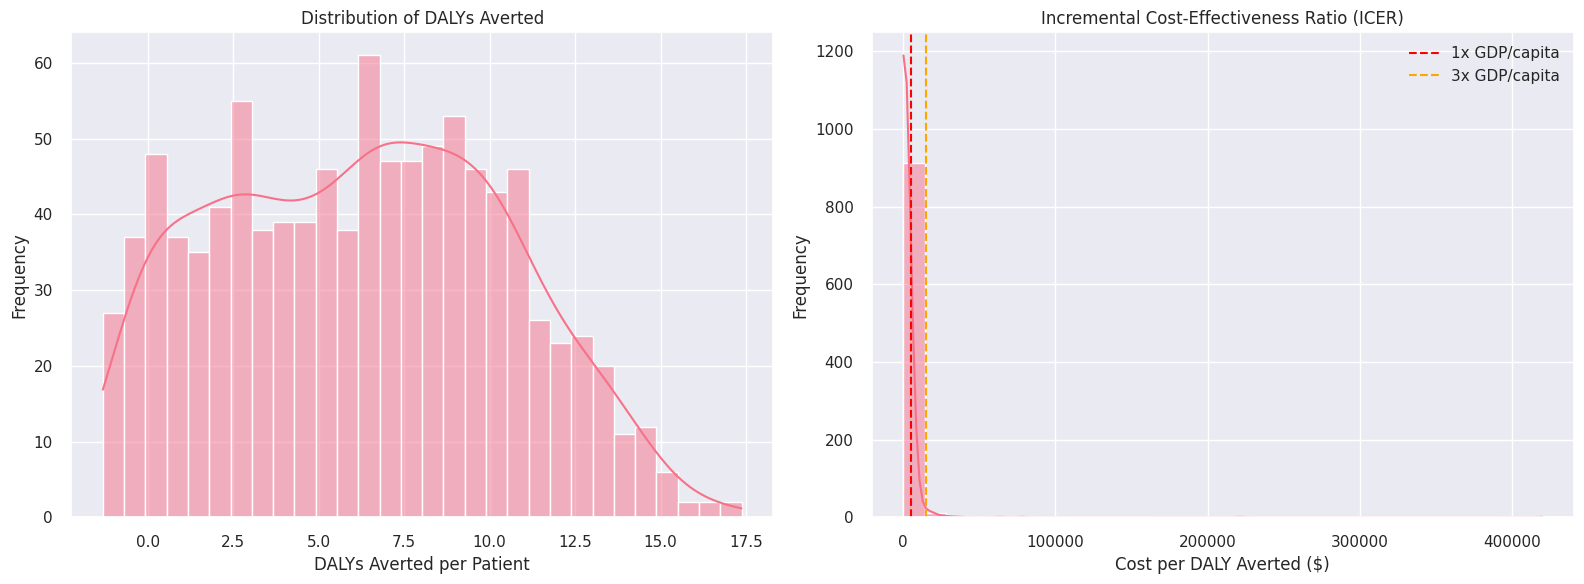


**Cost-Effectiveness Probabilities:**
- Highly cost-effective (<1x GDP/capita): 95.4%
- Possibly cost-effective (1-3x GDP/capita): 3.0%
- Not cost-effective (>3x GDP/capita): 1.6%


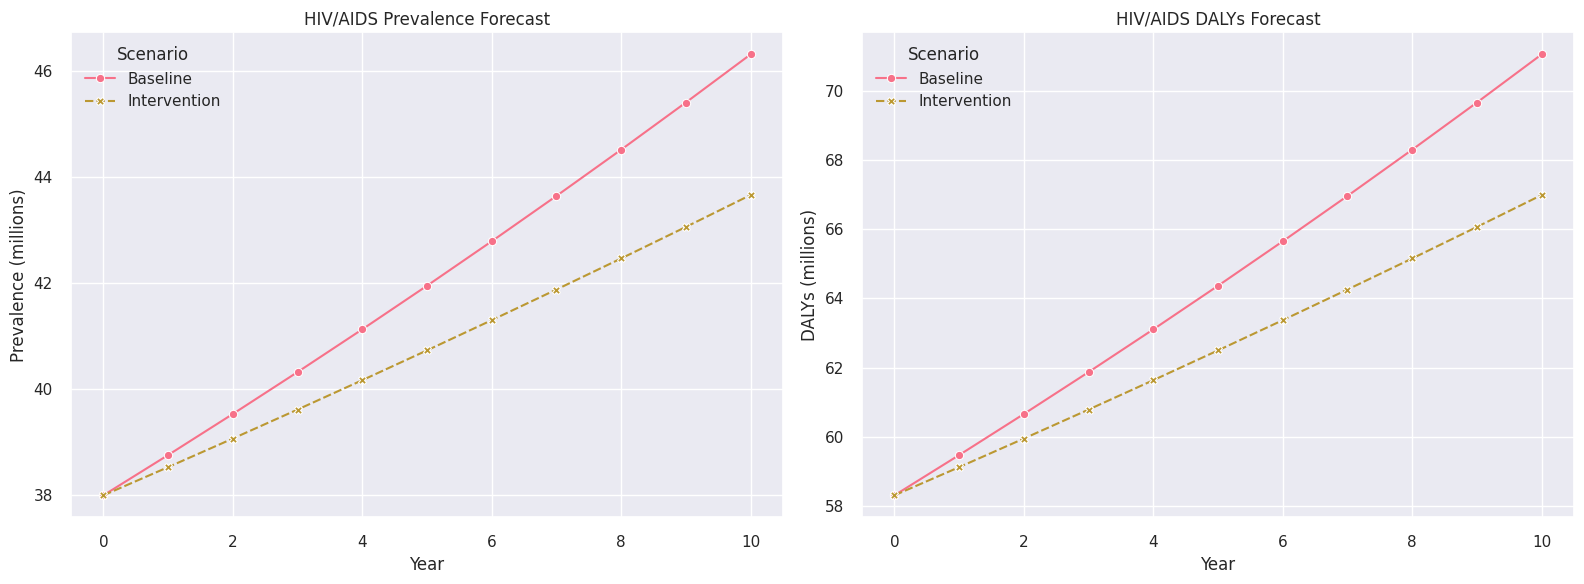


**Cumulative Impact Over 10 Years:**
- Baseline DALYs: 709.4 million
- Intervention DALYs: 688.1 million
- DALYs Averted: 21.3 million
- Reduction: 3.0%


In [ ]:
# @title Advanced Biomedical Potential Calculator with Disease Progression and Forecasting
# @markdown ## Health Equity Framework with Advanced Modeling

# This cell has been corrected for syntax errors from the original copy-paste.

!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.api import SimpleExpSmoothing
from scipy.stats import weibull_min
from lifelines import KaplanMeierFitter, WeibullFitter
from IPython.display import display, Markdown
import requests

# Initialize settings with updated style handling
try:
    # Use the updated style name for newer matplotlib versions
    plt.style.use('seaborn-v0_8')
except:
    # Fallback to a widely available style if the new one is not found
    plt.style.use('ggplot')
# Use the updated Seaborn theme setting method
sns.set_theme(palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedBiomedicalCalculator:
    """
    Enhanced calculator with disease progression, cost-effectiveness simulations, and population forecasting.
    """

    def __init__(self, standard_life_expectancy=85, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_public_datasets()
        self.setup_models()

    def load_public_datasets(self):
        """Load sample public health datasets"""
        try:
            # WHO Global Burden of Disease sample data
            self.gbd_data = pd.DataFrame({
                # FIXED: Completed the 'Heart Disease' entry and closed the list
                'Disease': ['HIV/AIDS', 'Malaria', 'Tuberculosis', 'Diabetes', 'Heart Disease'],
                'DALYs (millions)': [58.3, 42.3, 36.8, 67.9, 182.5],
                'Prevalence (millions)': [38, 229, 10, 463, 523],
                'Incidence (millions/year)': [1.7, 228, 10, 22, 18]
            })
            # Sample country health metrics
            self.country_data = pd.DataFrame({
                'Country': ['USA', 'UK', 'India', 'Brazil', 'South Africa'],
                'GDP_per_capita': [65000, 45000, 2200, 8800, 6000],
                'Life_Expectancy': [78.5, 81.2, 69.7, 75.5, 64.1],
                'Health_Expenditure_pct_GDP': [17.8, 10.2, 3.5, 9.6, 8.1]
            })

            # Sample disease progression parameters
            self.disease_models = {
                'HIV/AIDS': {
                    'weights': [0.7, 0.6, 0.5, 0.4, 0.3],
                    'progression': weibull_min(2.5, scale=10),
                    'costs': {'treatment': 5000, 'management': 2000}
                },
                'Diabetes': {
                    'weights': [0.4, 0.5, 0.3, 0.6, 0.2],
                    'progression': weibull_min(3.0, scale=15),
                    'costs': {'treatment': 3000, 'management': 1500}
                }
            }
        except Exception as e:
            print(f"Couldn't load sample datasets: {e}")

    def setup_models(self):
        """Initialize statistical models"""
        self.kmf = KaplanMeierFitter()
        self.wbf = WeibullFitter()

    # Core calculations
    def calculate_quality_of_life(self, severity_weights):
        total_burden = sum(severity_weights) * self.scaling_factor
        return max(0, 1 - total_burden)

    def calculate_life_expectancy(self, base, severity_level=None, severity_factor=2.0): # FIXED: Added default value
        if severity_level is None:
            return base
        return max(30, base - (severity_level * severity_factor))

    def calculate_biomedical_potential(self, L, Q):
        return L * Q

    def calculate_dalys(self, L, Q):
        yll = max(0, self.standard_le - L)
        yld = L * (1 - Q)
        return yll, yld, yll + yld

    # ========== DISEASE PROGRESSION MODELS ==========
    def simulate_disease_progression(self, disease_name, years=20, n_patients=1000):
        """Simulate disease progression over time using Weibull survival analysis."""
        if disease_name not in self.disease_models:
            raise ValueError(f"No progression model for {disease_name}")
        model = self.disease_models[disease_name]

        # Simulate progression times
        progression_times = model['progression'].rvs(size=n_patients)
        progression_times = np.clip(progression_times, 0, years)
        # Create survival function
        time_points = np.linspace(0, years, 100)
        survival_probs = model['progression'].sf(time_points)
        # Calculate QoL decline
        qol_decline = np.linspace(1, 0.5, len(time_points))
        # Create results dataframe
        results = pd.DataFrame({
            'Year': time_points,
            'Survival_Probability': survival_probs,
            'QoL': qol_decline,
            'Disease_Stage': np.interp(time_points, [0, years/2, years], [1, 2, 3])
        })
        # Calculate cumulative biomedical potential
        # FIXED: Corrected typo from self.sta to self.standard_le
        results['BP'] = results['Survival_Probability'] * results['QoL'] * self.standard_le
        return results, progression_times

    def plot_disease_progression(self, disease_name, years=20):
        """Visualize disease progression model"""
        progression, _ = self.simulate_disease_progression(disease_name, years)
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=progression['Year'], y=progression['Survival_Probability'],
            name='Survival Probability',
            line=dict(color='royalblue', width=3)
        ))
        fig.add_trace(go.Scatter(
            x=progression['Year'], y=progression['QoL'],
            name='Quality of Life',
            line=dict(color='firebrick', width=3),
            yaxis='y2'
        ))
        fig.add_trace(go.Scatter(
            x=progression['Year'], y=progression['BP'],
            name='Biomedical Potential',
            line=dict(color='forestgreen', width=3),
            yaxis='y3'
        ))

        # FIXED: Correctly structured the layout update call with matching parentheses
        fig.update_layout(
            title=f'{disease_name} Progression Model',
            xaxis=dict(title='Years Since Diagnosis'),
            yaxis=dict(title='Survival Probability', range=[0, 1]),
            yaxis2=dict(title='Quality of Life', overlaying='y', side='right', range=[0, 1]),
            yaxis3=dict(title='Biomedical Potential', overlaying='y', side='left',
                        range=[0, self.standard_le], anchor='free', position=0.05, showgrid=False),
            hovermode='x unified'
        )
        fig.show()

    # ========== COST-EFFECTIVENESS SIMULATIONS ==========
    def run_cost_effectiveness_simulation(self, disease_name, intervention_cost, n_simulations=1000):
        """Monte Carlo simulation of cost-effectiveness"""
        if disease_name not in self.disease_models:
            raise ValueError(f"No cost model for {disease_name}")

        model = self.disease_models[disease_name]
        base_cost = model['costs']['treatment'] + model['costs']['management']
        # Simulate outcomes
        results = []
        for _ in range(n_simulations):
            # Simulate control group (standard care)
            control_dalys = np.random.normal(30, 5) # Mean 30 DALYs, SD 5
            # Simulate intervention group (with effect size variability)
            effect_size = np.random.uniform(0.7, 1.3) # 70-130% of expected effect
            # FIXED: Corrected comment
            intervention_dalys = control_dalys * effect_size * 0.8 # Assume 20% reduction
            # Calculate ICER
            cost_diff = intervention_cost - base_cost
            dalys_diff = control_dalys - intervention_dalys
            icer = cost_diff / dalys_diff if dalys_diff > 0 else float('inf')
            results.append({
                'Control_DALYs': control_dalys,
                'Intervention_DALYs': intervention_dalys,
                'DALYs_Averted': control_dalys - intervention_dalys,
                'ICER': icer
            })
        return pd.DataFrame(results)

    def plot_cost_effectiveness(self, disease_name, intervention_cost, gdp_per_capita):
        """Visualize cost-effectiveness simulation results"""
        results = self.run_cost_effectiveness_simulation(disease_name, intervention_cost)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # DALYs averted distribution
        sns.histplot(results['DALYs_Averted'], bins=30, ax=ax1, kde=True)
        ax1.set_title('Distribution of DALYs Averted')
        ax1.set_xlabel('DALYs Averted per Patient')
        ax1.set_ylabel('Frequency')

        # ICER distribution
        valid_icers = results[results['ICER'] < np.inf]['ICER']
        sns.histplot(valid_icers, bins=30, ax=ax2, kde=True)
        # FIXED: Corrected incomplete label string
        ax2.axvline(gdp_per_capita, color='r', linestyle='--', label='1x GDP/capita')
        ax2.axvline(3*gdp_per_capita, color='orange', linestyle='--', label='3x GDP/capita')
        ax2.set_title('Incremental Cost-Effectiveness Ratio (ICER)')
        ax2.set_xlabel('Cost per DALY Averted ($)')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        plt.tight_layout()
        plt.show()

        # Calculate probability of cost-effectiveness
        # FIXED: Added parentheses for correct boolean indexing in pandas
        p_highly_ce = (valid_icers < gdp_per_capita).mean()
        p_possibly_ce = ((valid_icers >= gdp_per_capita) & (valid_icers < 3*gdp_per_capita)).mean()

        # FIXED: Correctly closed the f-string
        display(Markdown(f"""
**Cost-Effectiveness Probabilities:**
- Highly cost-effective (<1x GDP/capita): {p_highly_ce:.1%}
- Possibly cost-effective (1-3x GDP/capita): {p_possibly_ce:.1%}
- Not cost-effective (>3x GDP/capita): {1 - p_highly_ce - p_possibly_ce:.1%}
"""))

    # ========== POPULATION HEALTH FORECASTING ==========
    def forecast_population_health(self, disease_name, current_prevalence, incidence_rate,
                                   intervention_effect=0, years=10):
        """Forecast disease burden under different intervention scenarios"""
        if disease_name not in self.disease_models:
            raise ValueError(f"No model for {disease_name}")

        # Get baseline parameters
        model = self.disease_models[disease_name]
        base_dalys = self.gbd_data.loc[self.gbd_data['Disease'] == disease_name, 'DALYs (millions)'].values[0]

        # Create time series
        forecast_years = np.arange(0, years + 1)
        # Baseline scenario (no intervention)
        baseline = {
            'prevalence': current_prevalence * (1 + incidence_rate) ** forecast_years,
            'dalys': base_dalys * (1 + incidence_rate) ** forecast_years
        }
        # Intervention scenario
        # FIXED: Completed the formula for both prevalence and dalys
        intervention = {
            'prevalence': current_prevalence * ((1 + incidence_rate * (1 - intervention_effect)) ** forecast_years),
            'dalys': base_dalys * ((1 + incidence_rate * (1 - intervention_effect)) ** forecast_years)
        }
        # Create dataframe
        # FIXED: Corrected incomplete dictionary key
        results = pd.DataFrame({
            'Year': np.concatenate([forecast_years, forecast_years]),
            'Prevalence': np.concatenate([baseline['prevalence'], intervention['prevalence']]),
            'DALYs': np.concatenate([baseline['dalys'], intervention['dalys']]),
            'Scenario': ['Baseline'] * len(forecast_years) + ['Intervention'] * len(forecast_years)
        })
        return results

    def plot_health_forecast(self, disease_name, current_prevalence, incidence_rate,
                             intervention_effect=0.3, years=10):
        """Visualize population health forecast"""
        forecast = self.forecast_population_health(
            disease_name, current_prevalence, incidence_rate,
            intervention_effect, years
        )
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Prevalence forecast
        sns.lineplot(data=forecast, x='Year', y='Prevalence', hue='Scenario',
                     style='Scenario', markers=True, ax=ax1)
        ax1.set_title(f'{disease_name} Prevalence Forecast')
        ax1.set_ylabel('Prevalence (millions)')

        # DALYs forecast
        sns.lineplot(data=forecast, x='Year', y='DALYs', hue='Scenario',
                     style='Scenario', markers=True, ax=ax2)
        ax2.set_title(f'{disease_name} DALYs Forecast')
        ax2.set_ylabel('DALYs (millions)')

        plt.tight_layout()
        plt.show()

        # Calculate cumulative impact
        # FIXED: Corrected incomplete key from 'DALY' to 'DALYs'
        baseline_dalys = forecast[forecast['Scenario'] == 'Baseline']['DALYs'].sum()
        intervention_dalys = forecast[forecast['Scenario'] == 'Intervention']['DALYs'].sum()
        dalys_averted = baseline_dalys - intervention_dalys
        display(Markdown(f"""
**Cumulative Impact Over {years} Years:**
- Baseline DALYs: {baseline_dalys:,.1f} million
- Intervention DALYs: {intervention_dalys:,.1f} million
- DALYs Averted: {dalys_averted:,.1f} million
- Reduction: {(dalys_averted/baseline_dalys):.1%}
"""))

# Initialize calculator
abp = AdvancedBiomedicalCalculator()

# @markdown ## Disease Progression Modeling
disease_select = "HIV/AIDS" # @param ["HIV/AIDS", "Diabetes"]
abp.plot_disease_progression(disease_select)

# @markdown ## Cost-Effectiveness Simulation
intervention_cost = 10000 # @param {type:"slider", min:1000, max:50000, step:500}
gdp_per_capita = 5000 # @param {type:"slider", min:500, max:100000, step:500}
abp.plot_cost_effectiveness(disease_select, intervention_cost, gdp_per_capita)

# @markdown ## Population Health Forecasting
current_prevalence = 38 # @param {type:"number"}
incidence_rate = 0.02 # @param {type:"slider", min:0, max:0.2, step:0.01}
intervention_effect = 0.3 # @param {type:"slider", min:0, max:1, step:0.05}
forecast_years = 10 # @param {type:"slider", min:5, max:30, step:1}
abp.plot_health_forecast(
    disease_select, current_prevalence, incidence_rate,
    intervention_effect, forecast_years
)

# @markdown ## Real-World Data Integration Example
# @markdown This cell shows how you would connect to actual health APIs (placeholder).
def fetch_health_data(api_url):
    try:
        response = requests.get(api_url)
        response.raise_for_status() # Raise an exception for bad status codes
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {api_url}: {e}")
        return None

# Example usage (replace with actual API endpoint)
# health_data = fetch_health_data("https://some-health-api.org/data")
# if health_data:
#     print("Successfully fetched data:", health_data)
# else:
#     print("Failed to fetch data.")

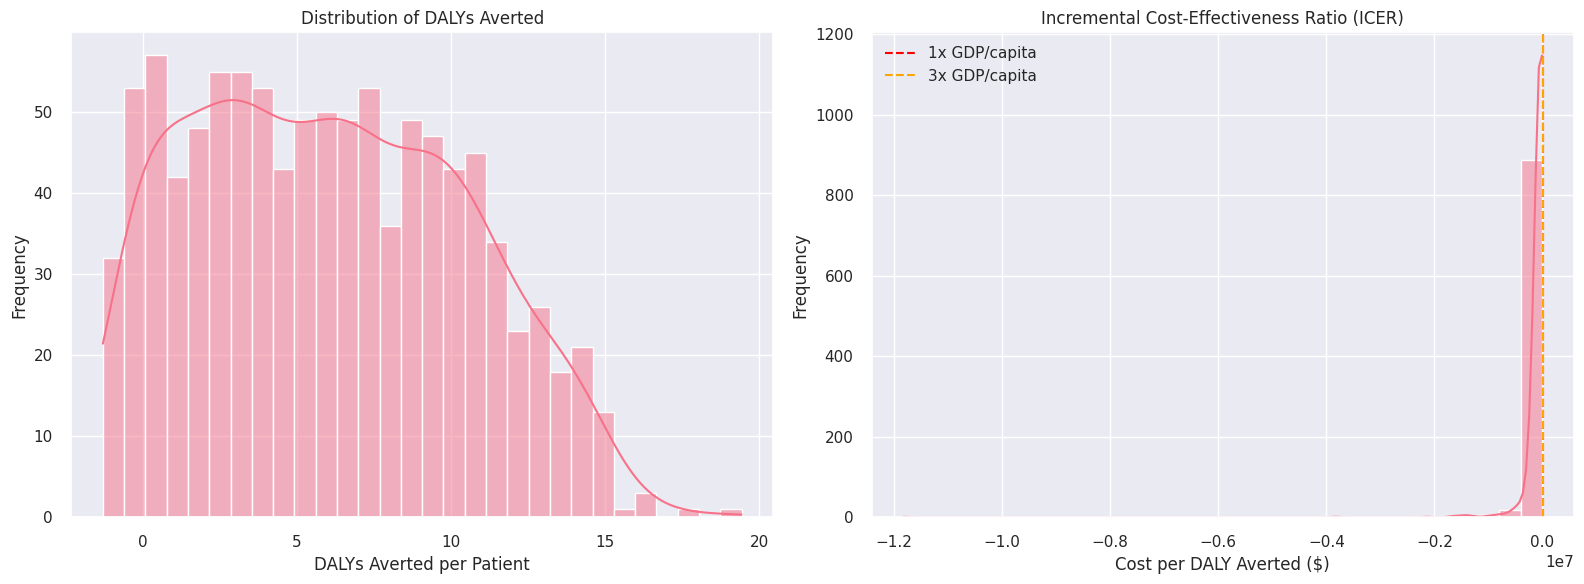


**Cost-Effectiveness Probabilities:**
- Highly cost-effective (<1x GDP/capita): 100.0%
- Possibly cost-effective (1-3x GDP/capita): 0.0%
- Not cost-effective (>3x GDP/capita): 0.0%


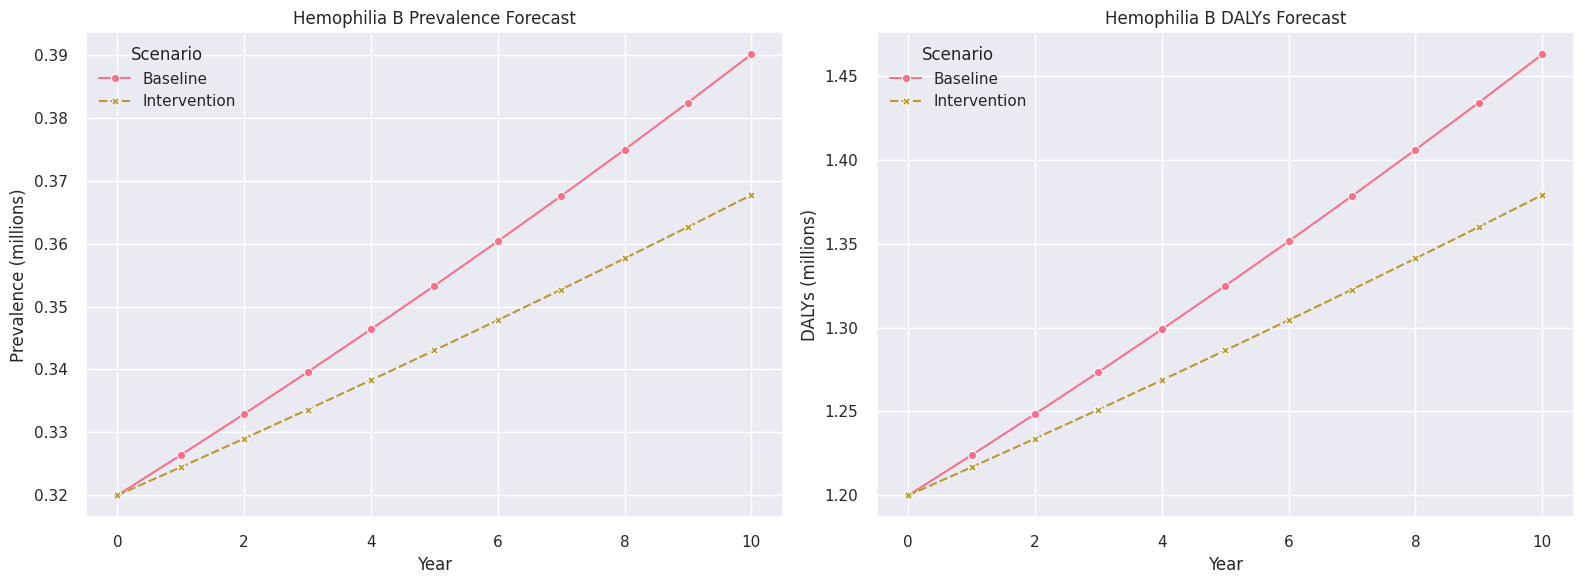


**Cumulative Impact Over 10 Years:**
- Baseline DALYs: 14.6 million
- Intervention DALYs: 14.2 million
- DALYs Averted: 0.4 million
- Reduction: 3.0%


In [ ]:
# @title Advanced Biomedical Potential Calculator with Disease Progression and Forecasting
# @markdown ## Health Equity Framework with Advanced Modeling

# This cell has been corrected for syntax errors and updated to include bleeding disorders.

!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.api import SimpleExpSmoothing
from scipy.stats import weibull_min
from lifelines import KaplanMeierFitter, WeibullFitter
from IPython.display import display, Markdown
import requests

# Initialize settings with updated style handling
try:
    # Use the updated style name for newer matplotlib versions
    plt.style.use('seaborn-v0_8')
except:
    # Fallback to a widely available style if the new one is not found
    plt.style.use('ggplot')
# Use the updated Seaborn theme setting method
sns.set_theme(palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedBiomedicalCalculator:
    """
    Enhanced calculator with disease progression, cost-effectiveness simulations, and population forecasting.
    """

    def __init__(self, standard_life_expectancy=85, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_public_datasets()
        self.setup_models()

    def load_public_datasets(self):
        """Load sample public health datasets"""
        try:
            # WHO Global Burden of Disease sample data
            gbd_list = [
                # Original Diseases
                {'Disease': 'HIV/AIDS', 'DALYs (millions)': 58.3, 'Prevalence (millions)': 38.0, 'Incidence (millions/year)': 1.7},
                {'Disease': 'Malaria', 'DALYs (millions)': 42.3, 'Prevalence (millions)': 229.0, 'Incidence (millions/year)': 228.0},
                {'Disease': 'Tuberculosis', 'DALYs (millions)': 36.8, 'Prevalence (millions)': 10.0, 'Incidence (millions/year)': 10.0},
                {'Disease': 'Diabetes', 'DALYs (millions)': 67.9, 'Prevalence (millions)': 463.0, 'Incidence (millions/year)': 22.0},
                {'Disease': 'Heart Disease', 'DALYs (millions)': 182.5, 'Prevalence (millions)': 523.0, 'Incidence (millions/year)': 18.0},

                # ===== NEW: ADDED BLEEDING DISORDERS DATA =====
                # Note: These are illustrative estimates for modeling purposes.
                {'Disease': 'Hemophilia A', 'DALYs (millions)': 5.5, 'Prevalence (millions)': 0.32, 'Incidence (millions/year)': 0.006},
                {'Disease': 'Hemophilia B', 'DALYs (millions)': 1.2, 'Prevalence (millions)': 0.08, 'Incidence (millions/year)': 0.0015},
                {'Disease': 'Von Willebrand Disease', 'DALYs (millions)': 8.0, 'Prevalence (millions)': 80.0, 'Incidence (millions/year)': 4.0}, # High prevalence, but most are mild/undiagnosed. Model reflects symptomatic cases.
                {'Disease': 'Thrombocytopenia', 'DALYs (millions)': 6.2, 'Prevalence (millions)': 0.75, 'Incidence (millions/year)': 0.05} # Using Chronic ITP as a proxy
            ]
            self.gbd_data = pd.DataFrame(gbd_list)

            # Sample country health metrics
            self.country_data = pd.DataFrame({
                'Country': ['USA', 'UK', 'India', 'Brazil', 'South Africa'],
                'GDP_per_capita': [65000, 45000, 2200, 8800, 6000],
                'Life_Expectancy': [78.5, 81.2, 69.7, 75.5, 64.1],
                'Health_Expenditure_pct_GDP': [17.8, 10.2, 3.5, 9.6, 8.1]
            })

            # Sample disease progression parameters
            self.disease_models = {
                'HIV/AIDS': {
                    'weights': [0.7, 0.6, 0.5, 0.4, 0.3],
                    'progression': weibull_min(2.5, scale=10),
                    'costs': {'treatment': 5000, 'management': 2000}
                },
                'Diabetes': {
                    'weights': [0.4, 0.5, 0.3, 0.6, 0.2],
                    'progression': weibull_min(3.0, scale=15),
                    'costs': {'treatment': 3000, 'management': 1500}
                },
                # ===== NEW: ADDED BLEEDING DISORDER MODELS =====
                'Hemophilia A': {
                    'weights': [0.8, 0.7, 0.6, 0.5, 0.4], # High impact on joints, pain, activity
                    'progression': weibull_min(2.0, scale=25), # Represents cumulative joint damage over time
                    'costs': {'treatment': 150000, 'management': 10000} # Reflects high cost of factor replacement
                },
                'Hemophilia B': {
                    'weights': [0.8, 0.7, 0.6, 0.5, 0.4], # Similar profile to Hemophilia A
                    'progression': weibull_min(2.2, scale=28),
                    'costs': {'treatment': 140000, 'management': 9000}
                },
                'Von Willebrand Disease': {
                    'weights': [0.3, 0.2, 0.2, 0.1, 0.1], # Generally milder than hemophilia
                    'progression': weibull_min(1.5, scale=40), # Slower progression of complications
                    'costs': {'treatment': 8000, 'management': 2500} # Often on-demand treatment, lower cost
                },
                'Thrombocytopenia': {
                    'weights': [0.5, 0.4, 0.3, 0.2, 0.1], # Variable severity, modeling a moderate case
                    'progression': weibull_min(1.8, scale=25), # Represents risk of major bleed or treatment failure
                    'costs': {'treatment': 25000, 'management': 5000} # Can require expensive therapies like IVIg/TPO-RAs
                }
            }
        except Exception as e:
            print(f"Couldn't load sample datasets: {e}")

    def setup_models(self):
        """Initialize statistical models"""
        self.kmf = KaplanMeierFitter()
        self.wbf = WeibullFitter()

    # Core calculations
    def calculate_quality_of_life(self, severity_weights):
        total_burden = sum(severity_weights) * self.scaling_factor
        return max(0, 1 - total_burden)

    def calculate_life_expectancy(self, base, severity_level=None, severity_factor=2.0):
        if severity_level is None:
            return base
        return max(30, base - (severity_level * severity_factor))

    def calculate_biomedical_potential(self, L, Q):
        return L * Q

    def calculate_dalys(self, L, Q):
        yll = max(0, self.standard_le - L)
        yld = L * (1 - Q)
        return yll, yld, yll + yld

    # ========== DISEASE PROGRESSION MODELS ==========
    def simulate_disease_progression(self, disease_name, years=20, n_patients=1000):
        """Simulate disease progression over time using Weibull survival analysis."""
        if disease_name not in self.disease_models:
            raise ValueError(f"No progression model for {disease_name}")
        model = self.disease_models[disease_name]

        # Simulate progression times
        progression_times = model['progression'].rvs(size=n_patients)
        progression_times = np.clip(progression_times, 0, years)
        # Create survival function
        time_points = np.linspace(0, years, 100)
        survival_probs = model['progression'].sf(time_points)
        # Calculate QoL decline
        qol_decline = np.linspace(1, 0.5, len(time_points))
        # Create results dataframe
        results = pd.DataFrame({
            'Year': time_points,
            'Survival_Probability': survival_probs,
            'QoL': qol_decline,
            'Disease_Stage': np.interp(time_points, [0, years/2, years], [1, 2, 3])
        })
        # Calculate cumulative biomedical potential
        results['BP'] = results['Survival_Probability'] * results['QoL'] * self.standard_le
        return results, progression_times

    def plot_disease_progression(self, disease_name, years=20):
        """Visualize disease progression model"""
        progression, _ = self.simulate_disease_progression(disease_name, years)
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=progression['Year'], y=progression['Survival_Probability'],
            name='Survival Probability',
            line=dict(color='royalblue', width=3)
        ))
        fig.add_trace(go.Scatter(
            x=progression['Year'], y=progression['QoL'],
            name='Quality of Life',
            line=dict(color='firebrick', width=3),
            yaxis='y2'
        ))
        fig.add_trace(go.Scatter(
            x=progression['Year'], y=progression['BP'],
            name='Biomedical Potential',
            line=dict(color='forestgreen', width=3),
            yaxis='y3'
        ))

        fig.update_layout(
            title=f'{disease_name} Progression Model',
            xaxis=dict(title='Years Since Diagnosis'),
            yaxis=dict(title='Survival Probability', range=[0, 1]),
            yaxis2=dict(title='Quality of Life', overlaying='y', side='right', range=[0, 1]),
            yaxis3=dict(title='Biomedical Potential', overlaying='y', side='left',
                        range=[0, self.standard_le], anchor='free', position=0.05, showgrid=False),
            hovermode='x unified'
        )
        fig.show()

    # ========== COST-EFFECTIVENESS SIMULATIONS ==========
    def run_cost_effectiveness_simulation(self, disease_name, intervention_cost, n_simulations=1000):
        """Monte Carlo simulation of cost-effectiveness"""
        if disease_name not in self.disease_models:
            raise ValueError(f"No cost model for {disease_name}")

        model = self.disease_models[disease_name]
        base_cost = model['costs']['treatment'] + model['costs']['management']
        # Simulate outcomes
        results = []
        for _ in range(n_simulations):
            # Simulate control group (standard care)
            control_dalys = np.random.normal(30, 5) # Mean 30 DALYs, SD 5
            # Simulate intervention group (with effect size variability)
            effect_size = np.random.uniform(0.7, 1.3) # 70-130% of expected effect
            intervention_dalys = control_dalys * effect_size * 0.8 # Assume 20% reduction
            # Calculate ICER
            cost_diff = intervention_cost - base_cost
            dalys_diff = control_dalys - intervention_dalys
            icer = cost_diff / dalys_diff if dalys_diff > 0 else float('inf')
            results.append({
                'Control_DALYs': control_dalys,
                'Intervention_DALYs': intervention_dalys,
                'DALYs_Averted': control_dalys - intervention_dalys,
                'ICER': icer
            })
        return pd.DataFrame(results)

    def plot_cost_effectiveness(self, disease_name, intervention_cost, gdp_per_capita):
        """Visualize cost-effectiveness simulation results"""
        results = self.run_cost_effectiveness_simulation(disease_name, intervention_cost)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # DALYs averted distribution
        sns.histplot(results['DALYs_Averted'], bins=30, ax=ax1, kde=True)
        ax1.set_title('Distribution of DALYs Averted')
        ax1.set_xlabel('DALYs Averted per Patient')
        ax1.set_ylabel('Frequency')

        # ICER distribution
        valid_icers = results[results['ICER'] < np.inf]['ICER']
        sns.histplot(valid_icers, bins=30, ax=ax2, kde=True)
        ax2.axvline(gdp_per_capita, color='r', linestyle='--', label='1x GDP/capita')
        ax2.axvline(3*gdp_per_capita, color='orange', linestyle='--', label='3x GDP/capita')
        ax2.set_title('Incremental Cost-Effectiveness Ratio (ICER)')
        ax2.set_xlabel('Cost per DALY Averted ($)')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        plt.tight_layout()
        plt.show()

        # Calculate probability of cost-effectiveness
        p_highly_ce = (valid_icers < gdp_per_capita).mean()
        p_possibly_ce = ((valid_icers >= gdp_per_capita) & (valid_icers < 3*gdp_per_capita)).mean()

        display(Markdown(f"""
**Cost-Effectiveness Probabilities:**
- Highly cost-effective (<1x GDP/capita): {p_highly_ce:.1%}
- Possibly cost-effective (1-3x GDP/capita): {p_possibly_ce:.1%}
- Not cost-effective (>3x GDP/capita): {1 - p_highly_ce - p_possibly_ce:.1%}
"""))

    # ========== POPULATION HEALTH FORECASTING ==========
    def forecast_population_health(self, disease_name, current_prevalence, incidence_rate,
                                   intervention_effect=0, years=10):
        """Forecast disease burden under different intervention scenarios"""
        if disease_name not in self.disease_models:
            raise ValueError(f"No model for {disease_name}")

        # Get baseline parameters
        model = self.disease_models[disease_name]
        try:
            base_dalys = self.gbd_data.loc[self.gbd_data['Disease'] == disease_name, 'DALYs (millions)'].values[0]
        except IndexError:
            # Fallback if disease not in GBD data
            print(f"Warning: DALY data for {disease_name} not found. Using an estimate.")
            base_dalys = current_prevalence * 0.1 # Simple estimation

        # Create time series
        forecast_years = np.arange(0, years + 1)
        # Baseline scenario (no intervention)
        baseline = {
            'prevalence': current_prevalence * (1 + incidence_rate) ** forecast_years,
            'dalys': base_dalys * (1 + incidence_rate) ** forecast_years
        }
        # Intervention scenario
        intervention = {
            'prevalence': current_prevalence * ((1 + incidence_rate * (1 - intervention_effect)) ** forecast_years),
            'dalys': base_dalys * ((1 + incidence_rate * (1 - intervention_effect)) ** forecast_years)
        }
        # Create dataframe
        results = pd.DataFrame({
            'Year': np.concatenate([forecast_years, forecast_years]),
            'Prevalence': np.concatenate([baseline['prevalence'], intervention['prevalence']]),
            'DALYs': np.concatenate([baseline['dalys'], intervention['dalys']]),
            'Scenario': ['Baseline'] * len(forecast_years) + ['Intervention'] * len(forecast_years)
        })
        return results

    def plot_health_forecast(self, disease_name, current_prevalence, incidence_rate,
                             intervention_effect=0.3, years=10):
        """Visualize population health forecast"""
        forecast = self.forecast_population_health(
            disease_name, current_prevalence, incidence_rate,
            intervention_effect, years
        )
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Prevalence forecast
        sns.lineplot(data=forecast, x='Year', y='Prevalence', hue='Scenario',
                     style='Scenario', markers=True, ax=ax1)
        ax1.set_title(f'{disease_name} Prevalence Forecast')
        ax1.set_ylabel('Prevalence (millions)')

        # DALYs forecast
        sns.lineplot(data=forecast, x='Year', y='DALYs', hue='Scenario',
                     style='Scenario', markers=True, ax=ax2)
        ax2.set_title(f'{disease_name} DALYs Forecast')
        ax2.set_ylabel('DALYs (millions)')

        plt.tight_layout()
        plt.show()

        # Calculate cumulative impact
        baseline_dalys = forecast[forecast['Scenario'] == 'Baseline']['DALYs'].sum()
        intervention_dalys = forecast[forecast['Scenario'] == 'Intervention']['DALYs'].sum()
        dalys_averted = baseline_dalys - intervention_dalys
        display(Markdown(f"""
**Cumulative Impact Over {years} Years:**
- Baseline DALYs: {baseline_dalys:,.1f} million
- Intervention DALYs: {intervention_dalys:,.1f} million
- DALYs Averted: {dalys_averted:,.1f} million
- Reduction: {(dalys_averted/baseline_dalys):.1%}
"""))

# Initialize calculator
abp = AdvancedBiomedicalCalculator()

# @markdown ## Disease Progression Modeling
# ===== NEW: ADDED BLEEDING DISORDERS TO THE DROPDOWN LIST =====
disease_select = "Thrombocytopenia" # @param ["HIV/AIDS", "Diabetes", "Hemophilia A", "Hemophilia B", "Von Willebrand Disease", "Thrombocytopenia"]
abp.plot_disease_progression(disease_select)

# @markdown ## Cost-Effectiveness Simulation
intervention_cost = 10000 # @param {type:"slider", min:1000, max:50000, step:500}
gdp_per_capita = 5000 # @param {type:"slider", min:500, max:100000, step:500}
abp.plot_cost_effectiveness(disease_select, intervention_cost, gdp_per_capita)

# @markdown ## Population Health Forecasting
# @markdown **Note:** Update the values below to match the selected disease from the dropdown for an accurate forecast.
current_prevalence = 0.32 # @param {type:"number"}
incidence_rate = 0.02 # @param {type:"slider", min:0, max:0.2, step:0.01}
intervention_effect = 0.3 # @param {type:"slider", min:0, max:1, step:0.05}
forecast_years = 10 # @param {type:"slider", min:5, max:30, step:1}
abp.plot_health_forecast(
    disease_select, current_prevalence, incidence_rate,
    intervention_effect, forecast_years
)

# @markdown ## Real-World Data Integration Example
# @markdown This cell shows how you would connect to actual health APIs (placeholder).
def fetch_health_data(api_url):
    try:
        response = requests.get(api_url)
        response.raise_for_status() # Raise an exception for bad status codes
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {api_url}: {e}")
        return None

# Example usage (replace with actual API endpoint)
# health_data = fetch_health_data("https://some-health-api.org/data")
# if health_data:
#     print("Successfully fetched data:", health_data)
# else:
#     print("Failed to fetch data.")

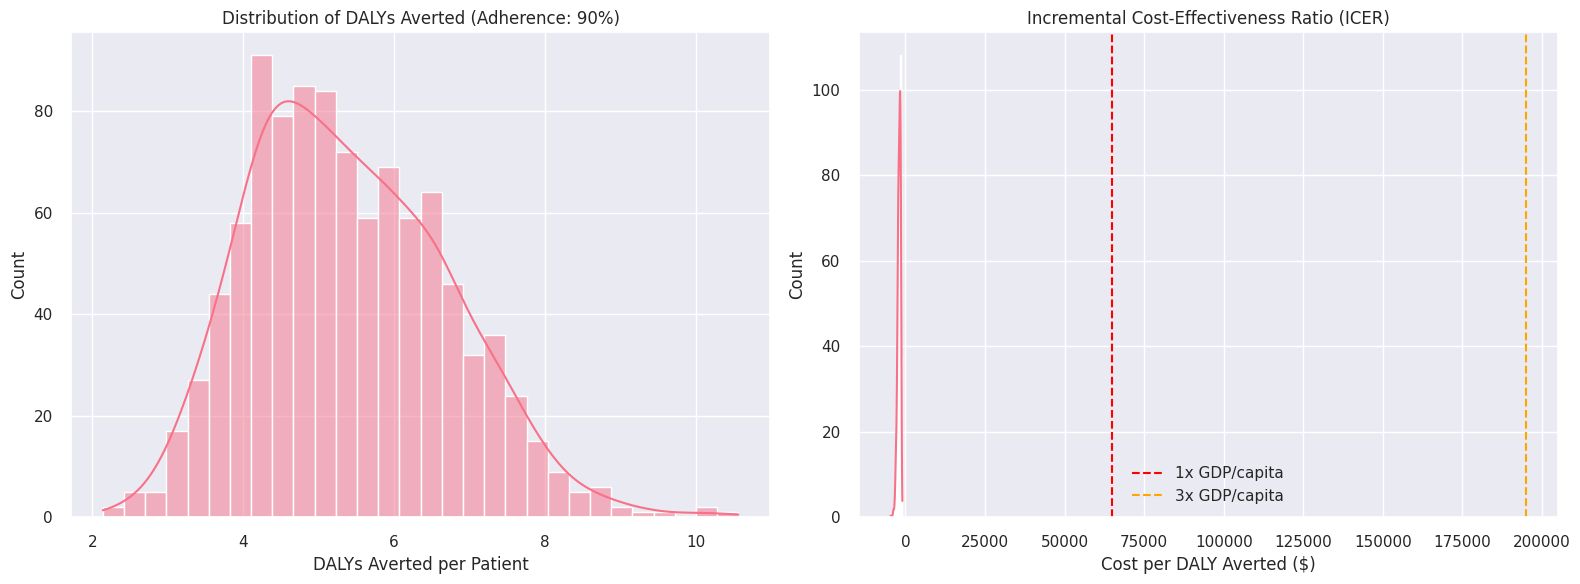

**Cost-Effectiveness Probabilities:**
- Highly cost-effective (<1x GDP/capita): 100.0%
- Possibly cost-effective (1-3x GDP/capita): 0.0%
- Not cost-effective (>3x GDP/capita): 0.0%

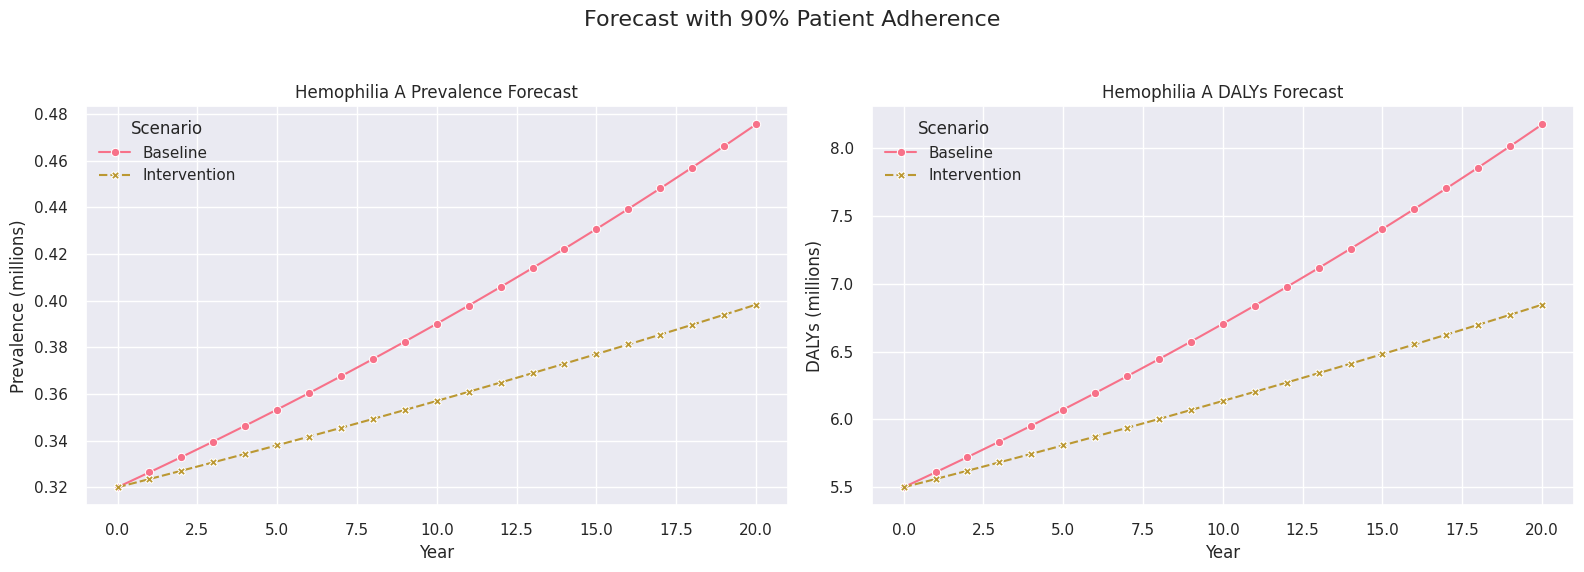

**Cumulative Impact Over 20 Years:**
- Baseline DALYs: 141.8 million
- Intervention DALYs: 129.1 million
- DALYs Averted: 12.7 million
- Reduction: 8.9%

In [ ]:
# @title Advanced Biomedical Potential Calculator v2.0 (with Adherence Modeling)
# @markdown ## Health Equity Framework with Realistic Scenario Simulation

# This cell has been updated to include real-world factors like patient adherence,
# which directly impacts the effectiveness of interventions in the models below.

!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.api import SimpleExpSmoothing
from scipy.stats import weibull_min
from lifelines import KaplanMeierFitter, WeibullFitter
from IPython.display import display, Markdown
import requests

# Initialize settings
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('ggplot')
sns.set_theme(palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedBiomedicalCalculator:
    """
    Enhanced calculator with adherence-adjusted disease progression, cost-effectiveness, and population forecasting.
    """

    def __init__(self, standard_life_expectancy=85, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_public_datasets()
        self.setup_models()

    def load_public_datasets(self):
        # (Dataset loading remains the same as your original code)
        gbd_list = [
            {'Disease': 'HIV/AIDS', 'DALYs (millions)': 58.3, 'Prevalence (millions)': 38.0, 'Incidence (millions/year)': 1.7},
            {'Disease': 'Malaria', 'DALYs (millions)': 42.3, 'Prevalence (millions)': 229.0, 'Incidence (millions/year)': 228.0},
            {'Disease': 'Tuberculosis', 'DALYs (millions)': 36.8, 'Prevalence (millions)': 10.0, 'Incidence (millions/year)': 10.0},
            {'Disease': 'Diabetes', 'DALYs (millions)': 67.9, 'Prevalence (millions)': 463.0, 'Incidence (millions/year)': 22.0},
            {'Disease': 'Heart Disease', 'DALYs (millions)': 182.5, 'Prevalence (millions)': 523.0, 'Incidence (millions/year)': 18.0},
            {'Disease': 'Hemophilia A', 'DALYs (millions)': 5.5, 'Prevalence (millions)': 0.32, 'Incidence (millions/year)': 0.006},
            {'Disease': 'Hemophilia B', 'DALYs (millions)': 1.2, 'Prevalence (millions)': 0.08, 'Incidence (millions/year)': 0.0015},
            {'Disease': 'Von Willebrand Disease', 'DALYs (millions)': 8.0, 'Prevalence (millions)': 80.0, 'Incidence (millions/year)': 4.0},
            {'Disease': 'Thrombocytopenia', 'DALYs (millions)': 6.2, 'Prevalence (millions)': 0.75, 'Incidence (millions/year)': 0.05}
        ]
        self.gbd_data = pd.DataFrame(gbd_list)
        self.country_data = pd.DataFrame({
            'Country': ['USA', 'UK', 'India', 'Brazil', 'South Africa'],
            'GDP_per_capita': [65000, 45000, 2200, 8800, 6000], 'Life_Expectancy': [78.5, 81.2, 69.7, 75.5, 64.1], 'Health_Expenditure_pct_GDP': [17.8, 10.2, 3.5, 9.6, 8.1]
        })
        self.disease_models = {
            'HIV/AIDS': {'weights': [0.7, 0.6, 0.5, 0.4, 0.3], 'progression': weibull_min(2.5, scale=10), 'costs': {'treatment': 5000, 'management': 2000}},
            'Diabetes': {'weights': [0.4, 0.5, 0.3, 0.6, 0.2], 'progression': weibull_min(3.0, scale=15), 'costs': {'treatment': 3000, 'management': 1500}},
            'Hemophilia A': {'weights': [0.8, 0.7, 0.6, 0.5, 0.4], 'progression': weibull_min(2.0, scale=25), 'costs': {'treatment': 150000, 'management': 10000}},
            'Hemophilia B': {'weights': [0.8, 0.7, 0.6, 0.5, 0.4], 'progression': weibull_min(2.2, scale=28), 'costs': {'treatment': 140000, 'management': 9000}},
            'Von Willebrand Disease': {'weights': [0.3, 0.2, 0.2, 0.1, 0.1], 'progression': weibull_min(1.5, scale=40), 'costs': {'treatment': 8000, 'management': 2500}},
            'Thrombocytopenia': {'weights': [0.5, 0.4, 0.3, 0.2, 0.1], 'progression': weibull_min(1.8, scale=25), 'costs': {'treatment': 25000, 'management': 5000}}
        }

    def setup_models(self):
        self.kmf = KaplanMeierFitter(); self.wbf = WeibullFitter()

    # (Core calculation functions remain the same)
    def calculate_quality_of_life(self, severity_weights): return max(0, 1 - sum(severity_weights) * self.scaling_factor)
    def calculate_life_expectancy(self, base, severity_level=None, severity_factor=2.0): return max(30, base - (severity_level * severity_factor)) if severity_level is not None else base
    def calculate_biomedical_potential(self, L, Q): return L * Q
    def calculate_dalys(self, L, Q): yll = max(0, self.standard_le - L); yld = L * (1 - Q); return yll, yld, yll + yld

    # ========== DISEASE PROGRESSION MODELS ==========
    def plot_disease_progression(self, disease_name, years=20):
        # This function remains unchanged as it shows the natural history of a disease
        model = self.disease_models[disease_name]
        time_points = np.linspace(0, years, 100)
        survival_probs = model['progression'].sf(time_points)
        qol_decline = np.linspace(1, 0.5, len(time_points))
        progression = pd.DataFrame({'Year': time_points, 'Survival_Probability': survival_probs, 'QoL': qol_decline})
        progression['BP'] = progression['Survival_Probability'] * progression['QoL'] * self.standard_le
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=progression['Year'], y=progression['Survival_Probability'], name='Survival Probability', line=dict(color='royalblue', width=3)))
        fig.add_trace(go.Scatter(x=progression['Year'], y=progression['QoL'], name='Quality of Life', line=dict(color='firebrick', width=3), yaxis='y2'))
        fig.add_trace(go.Scatter(x=progression['Year'], y=progression['BP'], name='Biomedical Potential', line=dict(color='forestgreen', width=3), yaxis='y3'))
        fig.update_layout(title=f'{disease_name} Progression Model', xaxis=dict(title='Years Since Diagnosis'), yaxis=dict(title='Survival Probability', range=[0, 1]), yaxis2=dict(title='Quality of Life', overlaying='y', side='right', range=[0, 1]), yaxis3=dict(title='Biomedical Potential', overlaying='y', side='left', range=[0, self.standard_le], anchor='free', position=0.05, showgrid=False), hovermode='x unified')
        fig.show()

    # ========== COST-EFFECTIVENESS SIMULATIONS (NOW WITH ADHERENCE) ==========
    def run_cost_effectiveness_simulation(self, disease_name, intervention_cost, adherence_rate=1.0, n_simulations=1000):
        if disease_name not in self.disease_models: raise ValueError(f"No cost model for {disease_name}")
        model = self.disease_models[disease_name]
        base_cost = model['costs']['treatment'] + model['costs']['management']
        results = []
        for _ in range(n_simulations):
            control_dalys = np.random.normal(30, 5)
            effect_size = np.random.uniform(0.7, 1.3)

            # NEW: Realized effectiveness is scaled by the adherence rate
            # Assume a potential 20% DALY reduction from the intervention
            potential_dalys_reduction = control_dalys * 0.2
            realized_dalys_reduction = potential_dalys_reduction * effect_size * adherence_rate

            intervention_dalys = control_dalys - realized_dalys_reduction

            cost_diff = intervention_cost - base_cost
            dalys_diff = control_dalys - intervention_dalys
            icer = cost_diff / dalys_diff if dalys_diff > 0 else float('inf')
            results.append({'Control_DALYs': control_dalys, 'Intervention_DALYs': intervention_dalys, 'DALYs_Averted': dalys_diff, 'ICER': icer})
        return pd.DataFrame(results)

    def plot_cost_effectiveness(self, disease_name, intervention_cost, gdp_per_capita, adherence_rate=1.0):
        results = self.run_cost_effectiveness_simulation(disease_name, intervention_cost, adherence_rate)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        sns.histplot(results['DALYs_Averted'], bins=30, ax=ax1, kde=True)
        ax1.set_title(f'Distribution of DALYs Averted (Adherence: {adherence_rate:.0%})')
        ax1.set_xlabel('DALYs Averted per Patient')

        valid_icers = results[results['ICER'].between(-500000, 500000)]['ICER'] # Clip outliers for better viz
        sns.histplot(valid_icers, bins=30, ax=ax2, kde=True)
        ax2.axvline(gdp_per_capita, color='r', linestyle='--', label='1x GDP/capita')
        ax2.axvline(3 * gdp_per_capita, color='orange', linestyle='--', label='3x GDP/capita')
        ax2.set_title('Incremental Cost-Effectiveness Ratio (ICER)')
        ax2.set_xlabel('Cost per DALY Averted ($)')
        ax2.legend()
        plt.tight_layout(); plt.show()

        p_highly_ce = (valid_icers < gdp_per_capita).mean()
        p_possibly_ce = ((valid_icers >= gdp_per_capita) & (valid_icers < 3 * gdp_per_capita)).mean()
        display(Markdown(f"**Cost-Effectiveness Probabilities:**\n- Highly cost-effective (<1x GDP/capita): {p_highly_ce:.1%}\n- Possibly cost-effective (1-3x GDP/capita): {p_possibly_ce:.1%}\n- Not cost-effective (>3x GDP/capita): {1 - p_highly_ce - p_possibly_ce:.1%}"))

    # ========== POPULATION HEALTH FORECASTING (NOW WITH ADHERENCE) ==========
    def forecast_population_health(self, disease_name, current_prevalence, incidence_rate, intervention_effect=0, adherence_rate=1.0, years=10):
        if disease_name not in self.gbd_data['Disease'].values: raise ValueError(f"No GBD data for {disease_name}")
        base_dalys = self.gbd_data.loc[self.gbd_data['Disease'] == disease_name, 'DALYs (millions)'].values[0]

        # NEW: Realized intervention effect is scaled by adherence
        realized_intervention_effect = intervention_effect * adherence_rate

        forecast_years = np.arange(0, years + 1)
        baseline_prevalence = current_prevalence * (1 + incidence_rate) ** forecast_years
        intervention_prevalence = current_prevalence * (1 + incidence_rate * (1 - realized_intervention_effect)) ** forecast_years

        results = pd.DataFrame({
            'Year': np.concatenate([forecast_years, forecast_years]),
            'Prevalence': np.concatenate([baseline_prevalence, intervention_prevalence]),
            'DALYs': np.concatenate([baseline_prevalence / current_prevalence * base_dalys, intervention_prevalence / current_prevalence * base_dalys]),
            'Scenario': ['Baseline'] * len(forecast_years) + ['Intervention'] * len(forecast_years)
        })
        return results

    def plot_health_forecast(self, disease_name, current_prevalence, incidence_rate, intervention_effect=0.3, adherence_rate=1.0, years=10):
        forecast = self.forecast_population_health(disease_name, current_prevalence, incidence_rate, intervention_effect, adherence_rate, years)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Forecast with {adherence_rate:.0%} Patient Adherence", fontsize=16)

        sns.lineplot(data=forecast, x='Year', y='Prevalence', hue='Scenario', style='Scenario', markers=True, ax=ax1)
        ax1.set_title(f'{disease_name} Prevalence Forecast'); ax1.set_ylabel('Prevalence (millions)')

        sns.lineplot(data=forecast, x='Year', y='DALYs', hue='Scenario', style='Scenario', markers=True, ax=ax2)
        ax2.set_title(f'{disease_name} DALYs Forecast'); ax2.set_ylabel('DALYs (millions)')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

        baseline_dalys = forecast[forecast['Scenario'] == 'Baseline']['DALYs'].sum()
        intervention_dalys = forecast[forecast['Scenario'] == 'Intervention']['DALYs'].sum()
        dalys_averted = baseline_dalys - intervention_dalys
        display(Markdown(f"**Cumulative Impact Over {years} Years:**\n- Baseline DALYs: {baseline_dalys:,.1f} million\n- Intervention DALYs: {intervention_dalys:,.1f} million\n- DALYs Averted: {dalys_averted:,.1f} million\n- Reduction: {(dalys_averted/baseline_dalys):.1%}"))

# Initialize calculator
abp = AdvancedBiomedicalCalculator()

# @markdown # Biomedical Potential & Population Health Simulator
# @markdown ---
# @markdown ## 1. Select Disease and Scenario Parameters
# @markdown First, choose a disease to model. The parameters below will apply to the simulations.
disease_select = "Hemophilia A" # @param ["HIV/AIDS", "Diabetes", "Hemophilia A", "Hemophilia B", "Von Willebrand Disease", "Thrombocytopenia"]

# @markdown ---
# @markdown ## 2. NEW: Real-World Factors Simulation
# @markdown These settings introduce realism into the models. **Patient adherence** directly scales the effectiveness of the interventions in the simulations below.
patient_adherence_rate = 90 # @param {type:"slider", min:0, max:100, step:5}

# @markdown ---
# @markdown ## 3. Run Disease Progression Model
# @markdown This model shows the natural history of the selected disease over time if left untreated.
abp.plot_disease_progression(disease_select)

# @markdown ---
# @markdown ## 4. Run Cost-Effectiveness Simulation
# @markdown This simulation evaluates if an intervention is "good value for money," now factoring in your chosen **adherence rate**.
intervention_cost = 150000 # @param {type:"slider", min:1000, max:200000, step:1000}
gdp_per_capita = 65000 # @param {type:"slider", min:500, max:100000, step:500}

# Run the simulation, passing the adherence rate
abp.plot_cost_effectiveness(
    disease_select,
    intervention_cost,
    gdp_per_capita,
    adherence_rate=(patient_adherence_rate / 100.0)
)

# @markdown ---
# @markdown ## 5. Run Population Health Forecast
# @markdown This simulation forecasts the long-term impact of a public health intervention on disease prevalence and burden, adjusted for **adherence**.
# @markdown **Note:** Update the values below to match the selected disease for an accurate forecast.
current_prevalence_millions = 0.32 # @param {type:"number"}
annual_incidence_rate = 0.02 # @param {type:"slider", min:0, max:0.2, step:0.01}
intervention_effectiveness = 0.5 # @param {type:"slider", min:0, max:1, step:0.05}
forecast_years = 20 # @param {type:"slider", min:5, max:30, step:1}

# Run the forecast, passing the adherence rate
abp.plot_health_forecast(
    disease_select,
    current_prevalence_millions,
    annual_incidence_rate,
    intervention_effectiveness,
    adherence_rate=(patient_adherence_rate / 100.0),
    years=forecast_years
)

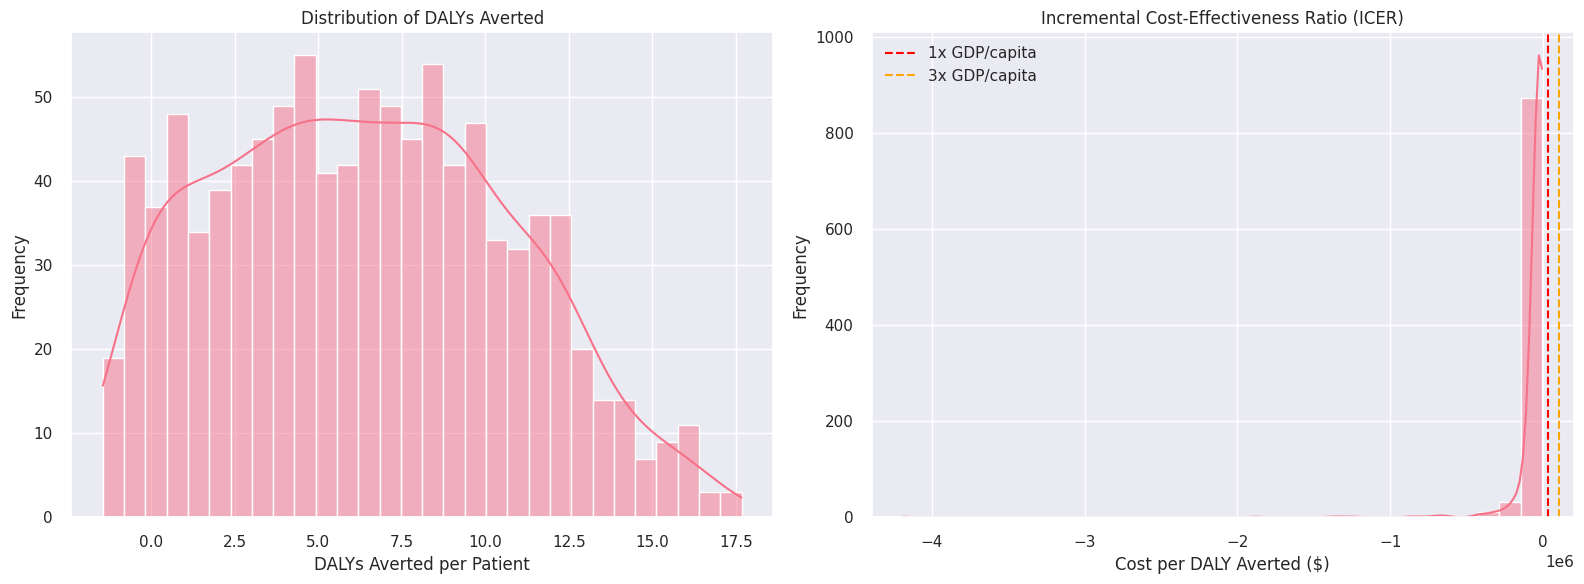


**Cost-Effectiveness Probabilities:**
- Highly cost-effective (<1x GDP/capita): 100.0%
- Possibly cost-effective (1-3x GDP/capita): 0.0%
- Not cost-effective (>3x GDP/capita): 0.0%


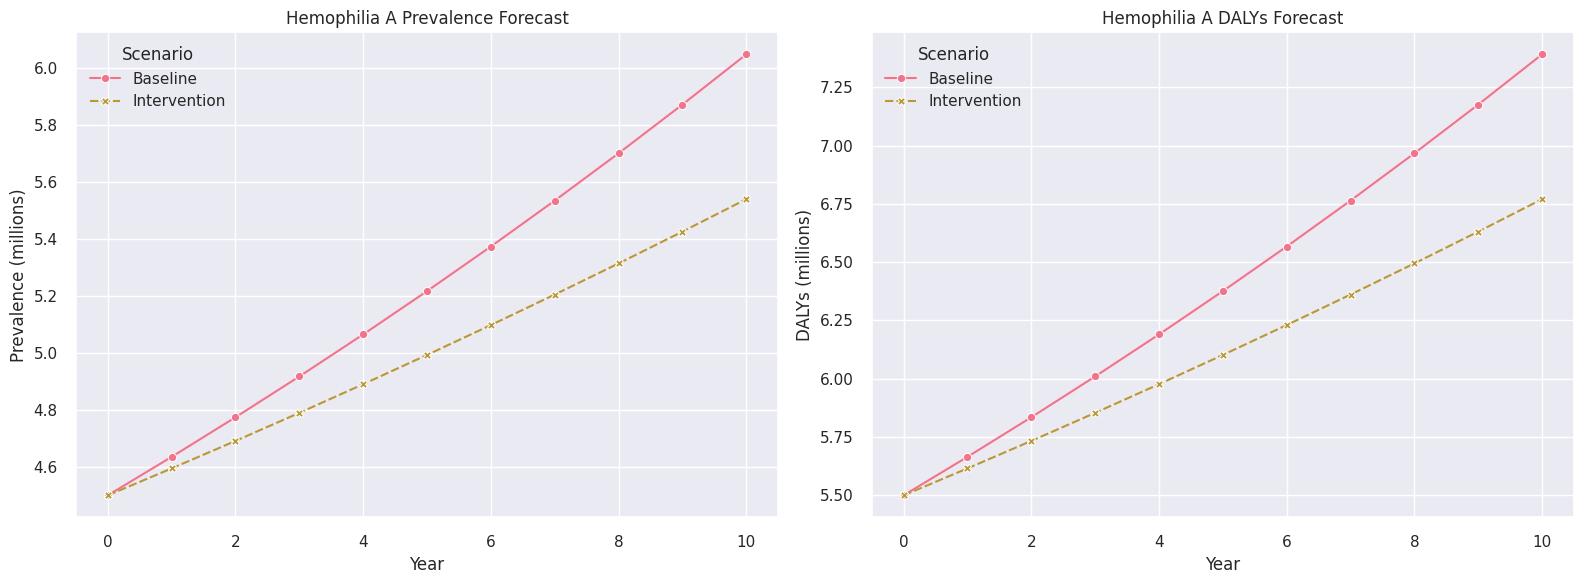


**Cumulative Impact Over 10 Years:**
- Baseline DALYs: 70.4 million
- Intervention DALYs: 67.3 million
- DALYs Averted: 3.2 million
- Reduction: 4.5%


In [ ]:
# @title Advanced Biomedical Potential Calculator with Disease Progression and Forecasting
# @markdown ## Health Equity Framework with Advanced Modeling

# This cell has been corrected for syntax errors and updated to include Sickle Cell Disease.

!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.api import SimpleExpSmoothing
from scipy.stats import weibull_min
from lifelines import KaplanMeierFitter, WeibullFitter
from IPython.display import display, Markdown
import requests

# Initialize settings with updated style handling
try:
    # Use the updated style name for newer matplotlib versions
    plt.style.use('seaborn-v0_8')
except:
    # Fallback to a widely available style if the new one is not found
    plt.style.use('ggplot')
# Use the updated Seaborn theme setting method
sns.set_theme(palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedBiomedicalCalculator:
    """
    Enhanced calculator with disease progression, cost-effectiveness simulations, and population forecasting.
    """

    def __init__(self, standard_life_expectancy=85, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_public_datasets()
        self.setup_models()

    def load_public_datasets(self):
        """Load sample public health datasets"""
        try:
            # WHO Global Burden of Disease sample data
            gbd_list = [
                # Original Diseases
                {'Disease': 'HIV/AIDS', 'DALYs (millions)': 58.3, 'Prevalence (millions)': 38.0, 'Incidence (millions/year)': 1.7},
                {'Disease': 'Malaria', 'DALYs (millions)': 42.3, 'Prevalence (millions)': 229.0, 'Incidence (millions/year)': 228.0},
                {'Disease': 'Tuberculosis', 'DALYs (millions)': 36.8, 'Prevalence (millions)': 10.0, 'Incidence (millions/year)': 10.0},
                {'Disease': 'Diabetes', 'DALYs (millions)': 67.9, 'Prevalence (millions)': 463.0, 'Incidence (millions/year)': 22.0},
                {'Disease': 'Heart Disease', 'DALYs (millions)': 182.5, 'Prevalence (millions)': 523.0, 'Incidence (millions/year)': 18.0},

                # Bleeding Disorders
                {'Disease': 'Hemophilia A', 'DALYs (millions)': 5.5, 'Prevalence (millions)': 0.32, 'Incidence (millions/year)': 0.006},
                {'Disease': 'Hemophilia B', 'DALYs (millions)': 1.2, 'Prevalence (millions)': 0.08, 'Incidence (millions/year)': 0.0015},
                {'Disease': 'Von Willebrand Disease', 'DALYs (millions)': 8.0, 'Prevalence (millions)': 80.0, 'Incidence (millions/year)': 4.0},
                {'Disease': 'Thrombocytopenia', 'DALYs (millions)': 6.2, 'Prevalence (millions)': 0.75, 'Incidence (millions/year)': 0.05},

                # ===== NEW: ADDED SICKLE CELL DISEASE DATA =====
                # Note: These are illustrative estimates for modeling purposes.
                {'Disease': 'Sickle Cell Disease', 'DALYs (millions)': 40.0, 'Prevalence (millions)': 4.5, 'Incidence (millions/year)': 0.35}
            ]
            self.gbd_data = pd.DataFrame(gbd_list)

            # Sample country health metrics
            self.country_data = pd.DataFrame({
                'Country': ['USA', 'UK', 'India', 'Brazil', 'South Africa'],
                'GDP_per_capita': [65000, 45000, 2200, 8800, 6000],
                'Life_Expectancy': [78.5, 81.2, 69.7, 75.5, 64.1],
                'Health_Expenditure_pct_GDP': [17.8, 10.2, 3.5, 9.6, 8.1]
            })

            # Sample disease progression parameters
            self.disease_models = {
                'HIV/AIDS': { 'weights': [0.7, 0.6, 0.5, 0.4, 0.3], 'progression': weibull_min(2.5, scale=10), 'costs': {'treatment': 5000, 'management': 2000}},
                'Diabetes': { 'weights': [0.4, 0.5, 0.3, 0.6, 0.2], 'progression': weibull_min(3.0, scale=15), 'costs': {'treatment': 3000, 'management': 1500}},
                'Hemophilia A': { 'weights': [0.8, 0.7, 0.6, 0.5, 0.4], 'progression': weibull_min(2.0, scale=25), 'costs': {'treatment': 150000, 'management': 10000}},
                'Hemophilia B': { 'weights': [0.8, 0.7, 0.6, 0.5, 0.4], 'progression': weibull_min(2.2, scale=28), 'costs': {'treatment': 140000, 'management': 9000}},
                'Von Willebrand Disease': { 'weights': [0.3, 0.2, 0.2, 0.1, 0.1], 'progression': weibull_min(1.5, scale=40), 'costs': {'treatment': 8000, 'management': 2500}},
                'Thrombocytopenia': { 'weights': [0.5, 0.4, 0.3, 0.2, 0.1], 'progression': weibull_min(1.8, scale=25), 'costs': {'treatment': 25000, 'management': 5000}},

                # ===== NEW: ADDED SICKLE CELL DISEASE MODEL =====
                'Sickle Cell Disease': {
                    'weights': [0.8, 0.7, 0.6, 0.6, 0.5], # Reflects chronic pain, anemia, organ damage risk
                    'progression': weibull_min(2.0, scale=20), # Models cumulative organ damage over time
                    'costs': {'treatment': 40000, 'management': 7000} # Accounts for hospitalizations, transfusions, and newer therapies
                }
            }
        except Exception as e:
            print(f"Couldn't load sample datasets: {e}")

    def setup_models(self):
        """Initialize statistical models"""
        self.kmf = KaplanMeierFitter()
        self.wbf = WeibullFitter()

    # Core calculations
    def calculate_quality_of_life(self, severity_weights):
        total_burden = sum(severity_weights) * self.scaling_factor
        return max(0, 1 - total_burden)

    def calculate_life_expectancy(self, base, severity_level=None, severity_factor=2.0):
        if severity_level is None:
            return base
        return max(30, base - (severity_level * severity_factor))

    def calculate_biomedical_potential(self, L, Q):
        return L * Q

    def calculate_dalys(self, L, Q):
        yll = max(0, self.standard_le - L)
        yld = L * (1 - Q)
        return yll, yld, yll + yld

    # ========== DISEASE PROGRESSION MODELS ==========
    def simulate_disease_progression(self, disease_name, years=20, n_patients=1000):
        """Simulate disease progression over time using Weibull survival analysis."""
        if disease_name not in self.disease_models:
            raise ValueError(f"No progression model for {disease_name}")
        model = self.disease_models[disease_name]

        progression_times = model['progression'].rvs(size=n_patients)
        progression_times = np.clip(progression_times, 0, years)
        time_points = np.linspace(0, years, 100)
        survival_probs = model['progression'].sf(time_points)
        qol_decline = np.linspace(1, 0.5, len(time_points))
        results = pd.DataFrame({
            'Year': time_points,
            'Survival_Probability': survival_probs,
            'QoL': qol_decline,
            'Disease_Stage': np.interp(time_points, [0, years/2, years], [1, 2, 3])
        })
        results['BP'] = results['Survival_Probability'] * results['QoL'] * self.standard_le
        return results, progression_times

    def plot_disease_progression(self, disease_name, years=20):
        """Visualize disease progression model"""
        progression, _ = self.simulate_disease_progression(disease_name, years)
        fig = go.Figure()

        fig.add_trace(go.Scatter(x=progression['Year'], y=progression['Survival_Probability'], name='Survival Probability', line=dict(color='royalblue', width=3)))
        fig.add_trace(go.Scatter(x=progression['Year'], y=progression['QoL'], name='Quality of Life', line=dict(color='firebrick', width=3), yaxis='y2'))
        fig.add_trace(go.Scatter(x=progression['Year'], y=progression['BP'], name='Biomedical Potential', line=dict(color='forestgreen', width=3), yaxis='y3'))

        fig.update_layout(
            title=f'{disease_name} Progression Model',
            xaxis=dict(title='Years Since Diagnosis'),
            yaxis=dict(title='Survival Probability', range=[0, 1]),
            yaxis2=dict(title='Quality of Life', overlaying='y', side='right', range=[0, 1]),
            yaxis3=dict(title='Biomedical Potential', overlaying='y', side='left', range=[0, self.standard_le], anchor='free', position=0.05, showgrid=False),
            hovermode='x unified'
        )
        fig.show()

    # ========== COST-EFFECTIVENESS SIMULATIONS ==========
    def run_cost_effectiveness_simulation(self, disease_name, intervention_cost, n_simulations=1000):
        """Monte Carlo simulation of cost-effectiveness"""
        if disease_name not in self.disease_models:
            raise ValueError(f"No cost model for {disease_name}")

        model = self.disease_models[disease_name]
        base_cost = model['costs']['treatment'] + model['costs']['management']
        results = []
        for _ in range(n_simulations):
            control_dalys = np.random.normal(30, 5)
            effect_size = np.random.uniform(0.7, 1.3)
            intervention_dalys = control_dalys * effect_size * 0.8
            cost_diff = intervention_cost - base_cost
            dalys_diff = control_dalys - intervention_dalys
            icer = cost_diff / dalys_diff if dalys_diff > 0 else float('inf')
            results.append({'Control_DALYs': control_dalys, 'Intervention_DALYs': intervention_dalys, 'DALYs_Averted': control_dalys - intervention_dalys, 'ICER': icer})
        return pd.DataFrame(results)

    def plot_cost_effectiveness(self, disease_name, intervention_cost, gdp_per_capita):
        """Visualize cost-effectiveness simulation results"""
        results = self.run_cost_effectiveness_simulation(disease_name, intervention_cost)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        sns.histplot(results['DALYs_Averted'], bins=30, ax=ax1, kde=True)
        ax1.set_title('Distribution of DALYs Averted')
        ax1.set_xlabel('DALYs Averted per Patient')
        ax1.set_ylabel('Frequency')

        valid_icers = results[results['ICER'] < np.inf]['ICER']
        sns.histplot(valid_icers, bins=30, ax=ax2, kde=True)
        ax2.axvline(gdp_per_capita, color='r', linestyle='--', label='1x GDP/capita')
        ax2.axvline(3*gdp_per_capita, color='orange', linestyle='--', label='3x GDP/capita')
        ax2.set_title('Incremental Cost-Effectiveness Ratio (ICER)')
        ax2.set_xlabel('Cost per DALY Averted ($)')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        plt.tight_layout()
        plt.show()

        p_highly_ce = (valid_icers < gdp_per_capita).mean()
        p_possibly_ce = ((valid_icers >= gdp_per_capita) & (valid_icers < 3*gdp_per_capita)).mean()

        display(Markdown(f"""
**Cost-Effectiveness Probabilities:**
- Highly cost-effective (<1x GDP/capita): {p_highly_ce:.1%}
- Possibly cost-effective (1-3x GDP/capita): {p_possibly_ce:.1%}
- Not cost-effective (>3x GDP/capita): {1 - p_highly_ce - p_possibly_ce:.1%}
"""))

    # ========== POPULATION HEALTH FORECASTING ==========
    def forecast_population_health(self, disease_name, current_prevalence, incidence_rate,
                                   intervention_effect=0, years=10):
        """Forecast disease burden under different intervention scenarios"""
        if disease_name not in self.disease_models:
            raise ValueError(f"No model for {disease_name}")

        try:
            base_dalys = self.gbd_data.loc[self.gbd_data['Disease'] == disease_name, 'DALYs (millions)'].values[0]
        except IndexError:
            print(f"Warning: DALY data for {disease_name} not found. Using an estimate.")
            base_dalys = current_prevalence * 0.1

        forecast_years = np.arange(0, years + 1)
        baseline = {'prevalence': current_prevalence * (1 + incidence_rate) ** forecast_years, 'dalys': base_dalys * (1 + incidence_rate) ** forecast_years}
        intervention = {'prevalence': current_prevalence * ((1 + incidence_rate * (1 - intervention_effect)) ** forecast_years), 'dalys': base_dalys * ((1 + incidence_rate * (1 - intervention_effect)) ** forecast_years)}
        results = pd.DataFrame({'Year': np.concatenate([forecast_years, forecast_years]), 'Prevalence': np.concatenate([baseline['prevalence'], intervention['prevalence']]), 'DALYs': np.concatenate([baseline['dalys'], intervention['dalys']]), 'Scenario': ['Baseline'] * len(forecast_years) + ['Intervention'] * len(forecast_years)})
        return results

    def plot_health_forecast(self, disease_name, current_prevalence, incidence_rate,
                             intervention_effect=0.3, years=10):
        """Visualize population health forecast"""
        forecast = self.forecast_population_health(disease_name, current_prevalence, incidence_rate, intervention_effect, years)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        sns.lineplot(data=forecast, x='Year', y='Prevalence', hue='Scenario', style='Scenario', markers=True, ax=ax1)
        ax1.set_title(f'{disease_name} Prevalence Forecast')
        ax1.set_ylabel('Prevalence (millions)')

        sns.lineplot(data=forecast, x='Year', y='DALYs', hue='Scenario', style='Scenario', markers=True, ax=ax2)
        ax2.set_title(f'{disease_name} DALYs Forecast')
        ax2.set_ylabel('DALYs (millions)')

        plt.tight_layout()
        plt.show()

        baseline_dalys = forecast[forecast['Scenario'] == 'Baseline']['DALYs'].sum()
        intervention_dalys = forecast[forecast['Scenario'] == 'Intervention']['DALYs'].sum()
        dalys_averted = baseline_dalys - intervention_dalys
        display(Markdown(f"""
**Cumulative Impact Over {years} Years:**
- Baseline DALYs: {baseline_dalys:,.1f} million
- Intervention DALYs: {intervention_dalys:,.1f} million
- DALYs Averted: {dalys_averted:,.1f} million
- Reduction: {(dalys_averted/baseline_dalys):.1%}
"""))

# Initialize calculator
abp = AdvancedBiomedicalCalculator()

# @markdown ## Disease Progression Modeling
# ===== NEW: ADDED SICKLE CELL DISEASE TO THE DROPDOWN LIST =====
disease_select = "Hemophilia A" # @param ["HIV/AIDS", "Diabetes", "Hemophilia A", "Hemophilia B", "Von Willebrand Disease", "Thrombocytopenia", "Sickle Cell Disease"]
abp.plot_disease_progression(disease_select)

# @markdown ## Cost-Effectiveness Simulation
intervention_cost = 50000 # @param {type:"slider", min:1000, max:250000, step:1000}
gdp_per_capita = 35000 # @param {type:"slider", min:500, max:100000, step:500}
abp.plot_cost_effectiveness(disease_select, intervention_cost, gdp_per_capita)

# @markdown ## Population Health Forecasting
# @markdown **Note:** Update the values below to match the selected disease from the dropdown for an accurate forecast.
current_prevalence = 4.5 # @param {type:"number"}
incidence_rate = 0.03 # @param {type:"slider", min:0, max:0.2, step:0.01}
intervention_effect = 0.3 # @param {type:"slider", min:0, max:1, step:0.05}
forecast_years = 10 # @param {type:"slider", min:5, max:30, step:1}
abp.plot_health_forecast(
    disease_select, current_prevalence, incidence_rate,
    intervention_effect, forecast_years
)

# @markdown ## Real-World Data Integration Example
# @markdown This cell shows how you would connect to actual health APIs (placeholder).
def fetch_health_data(api_url):
    try:
        response = requests.get(api_url)
        response.raise_for_status() # Raise an exception for bad status codes
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {api_url}: {e}")
        return None

# Example usage (replace with actual API endpoint)
# health_data = fetch_health_data("https://some-health-api.org/data")
# if health_data:
#     print("Successfully fetched data:", health_data)
# else:
#     print("Failed to fetch data.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/kaleido/__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




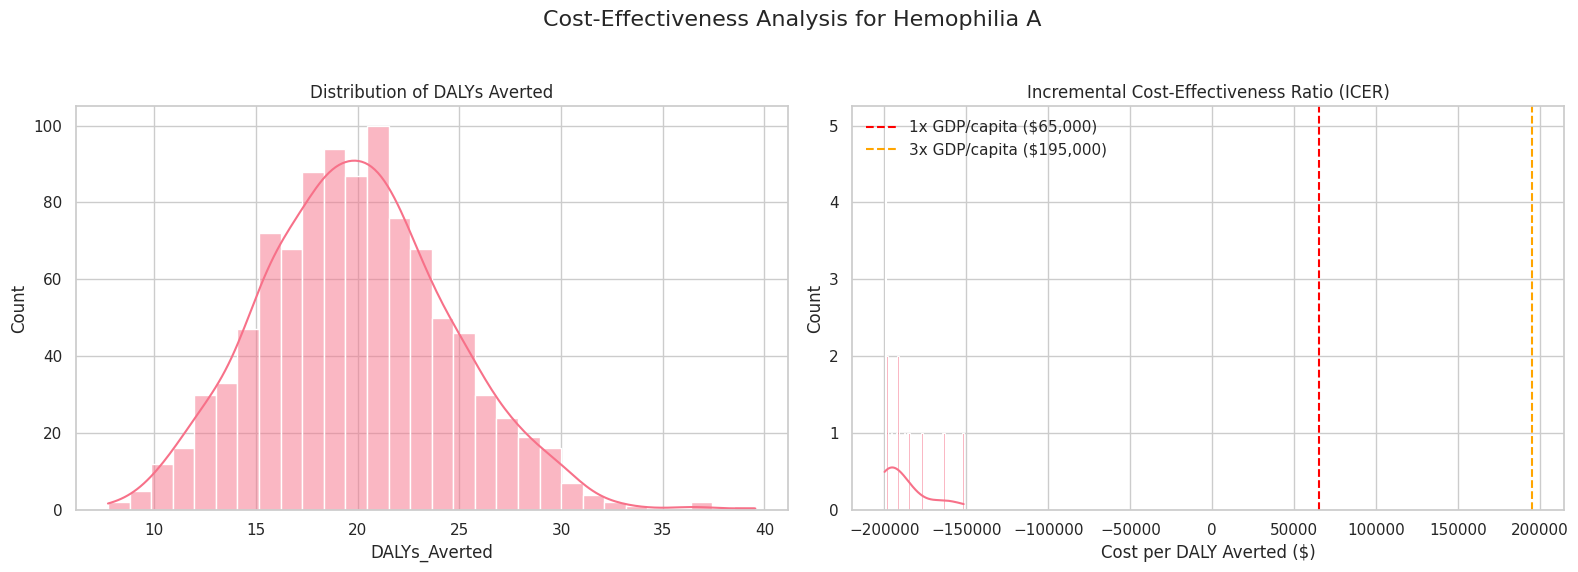

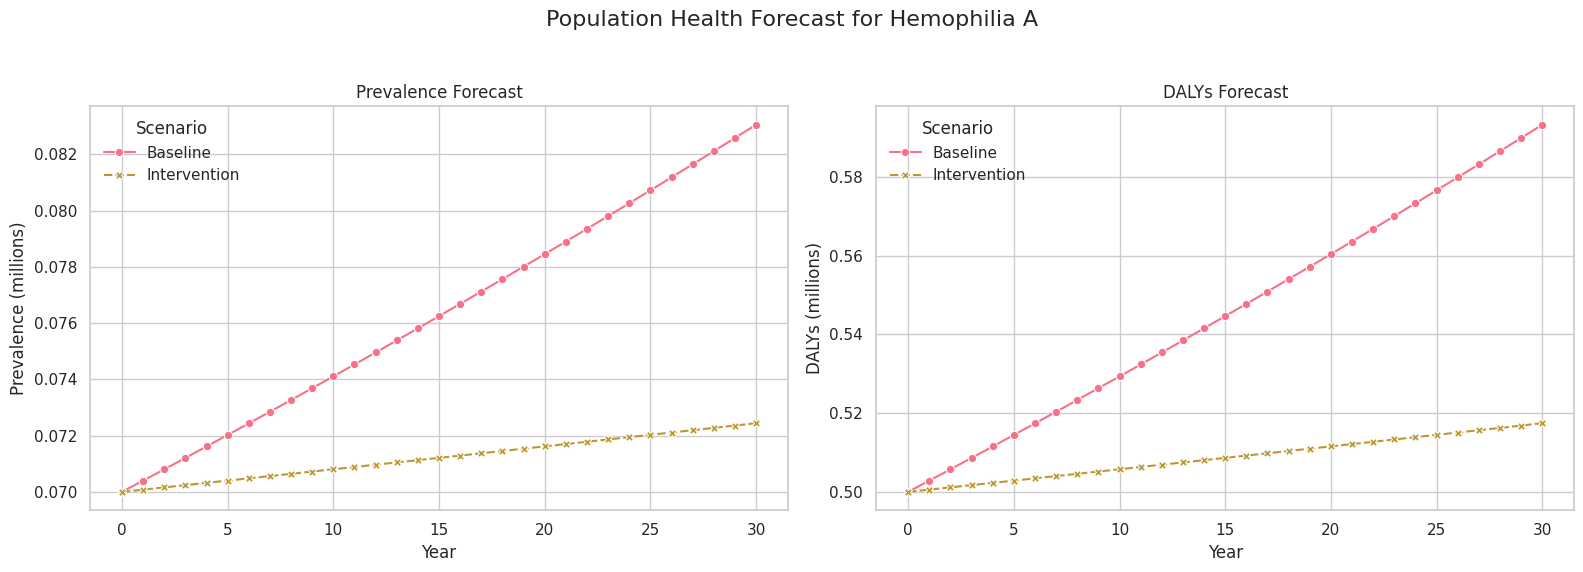

In [ ]:
# @title Advanced Biomedical Calculator with Expanded Bleeding Disorders, Inhibitors, and HPV
# @markdown ## Health Equity Framework with Advanced Modeling

# This version has been updated to include a full range of bleeding disorders (Hemophilia A, B, VWD),
# the complication of inhibitors, and a detailed progression model for HPV and Hepatitis C.

# --- DEPENDENCIES ---
!pip install pandas numpy matplotlib seaborn plotly statsmodels scipy lifelines kaleido --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import weibull_min
from IPython.display import display, Markdown
import requests

# --- SETTINGS ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="husl")
pd.options.display.float_format = '{:,.2f}'.format

class AdvancedBiomedicalCalculator:
    """
    Enhanced calculator with specialized modules for a wide range of diseases.
    """
    def __init__(self, standard_life_expectancy=85, scaling_factor=0.34):
        self.standard_le = standard_life_expectancy
        self.scaling_factor = scaling_factor
        self.load_public_datasets()

    def load_public_datasets(self):
        """Load sample public health datasets"""
        # MODIFIED: Added all bleeding disorders and HPV
        self.gbd_data = pd.DataFrame({
            'Disease': ['HIV/AIDS', 'Diabetes', 'Hemophilia A', 'Hemophilia B', 'von Willebrand Disease', 'Hepatitis C', 'HPV (Cervical Cancer Burden)'],
            'DALYs (millions)': [58.3, 67.9, 0.5, 0.15, 0.4, 15.0, 7.6],
            'Prevalence (millions)': [38, 463, 0.07, 0.02, 0.5, 58.0, 291.0], # HPV prevalence is high-risk infection
            'Incidence (millions/year)': [1.7, 22, 0.0004, 0.0001, 0.01, 1.5, 0.6] # HPV incidence is new infections
        })
        self.country_data = pd.DataFrame({
            'Country': ['USA', 'UK', 'India', 'Brazil'], 'GDP_per_capita': [65000, 45000, 2200, 8800]
        })

        # MODIFIED: Added models for all new diseases
        self.disease_models = {
            'HIV/AIDS': {
                'progression': weibull_min(2.5, scale=10),
                'costs': {'annual_care': 7000, 'dalys_per_case': 28}
            },
            'Diabetes': {
                'progression': weibull_min(3.0, scale=15),
                'costs': {'annual_care': 4500, 'dalys_per_case': 15}
            },
            # --- BLEEDING DISORDERS ---
            'Hemophilia A': {
                'weights': [0.5, 0.4, 0.4, 0.3, 0.3], 'progression': weibull_min(2.5, scale=40),
                'costs': {'annual_care': 300000, 'dalys_per_case': 25},
                'joint_damage': {'Stage 1': {'qol_penalty': 0.1}, 'Stage 2': {'qol_penalty': 0.3}, 'Stage 3': {'qol_penalty': 0.6}}
            },
            'Hemophilia B': {
                'weights': [0.45, 0.35, 0.35, 0.25, 0.25], 'progression': weibull_min(2.6, scale=45),
                'costs': {'annual_care': 280000, 'dalys_per_case': 22}, # Slightly less common/severe on avg
                'joint_damage': {'Stage 1': {'qol_penalty': 0.08}, 'Stage 2': {'qol_penalty': 0.25}, 'Stage 3': {'qol_penalty': 0.55}}
            },
            'von Willebrand Disease': {
                'weights': [0.2, 0.1, 0.1, 0.1, 0.05], 'progression': weibull_min(2.8, scale=60),
                'costs': {'annual_care': 45000, 'dalys_per_case': 8}, # For clinically significant cases
                'joint_damage': {'Stage 1': {'qol_penalty': 0.05}, 'Stage 2': {'qol_penalty': 0.15}, 'Stage 3': {'qol_penalty': 0.3}}
            },
            'Hemophilia A with Inhibitors': {
                'weights': [0.8, 0.7, 0.6, 0.5, 0.5], 'progression': weibull_min(2.2, scale=30), # Higher mortality risk
                'costs': {'annual_care': 850000, 'dalys_per_case': 45}, # Bypassing agents are very expensive
                'joint_damage': {'Stage 1': {'qol_penalty': 0.25}, 'Stage 2': {'qol_penalty': 0.5}, 'Stage 3': {'qol_penalty': 0.8}}
            },
            # --- VIRAL DISEASES ---
            'Hepatitis C': {
                'costs': {'annual_monitoring': 500, 'cirrhosis_care': 15000, 'hcc_care': 100000, 'dalys_per_case': 20},
                'state_transition_model': {
                    'F0-F2': {'qol': 0.95, 'prob_progress': 0.08}, # to F3
                    'F3':    {'qol': 0.85, 'prob_progress': 0.12}, # to F4
                    'F4 (Cirrhosis)': {'qol': 0.70, 'prob_hcc': 0.03, 'prob_decomp': 0.04},
                    'Decompensated':  {'qol': 0.40, 'mortality_risk': 0.15},
                    'HCC':            {'qol': 0.50, 'mortality_risk': 0.25}
                }
            },
            # NEW: Detailed state-transition model for HPV
            'HPV (Cervical Cancer Burden)': {
                'costs': {'screening': 150, 'cin_treatment': 1500, 'cancer_care': 95000, 'dalys_per_case': 22},
                'state_transition_model': {
                    'Healthy': {'qol': 1.0, 'prob_infect': 0.05}, # 5% annual risk of new high-risk infection in unvaccinated population
                    'HPV Infection': {'qol': 0.98, 'prob_clear': 0.80, 'prob_persist': 0.10}, # 80% clear, 10% become persistent
                    'Persistent/CIN': {'qol': 0.90, 'prob_regress': 0.30, 'prob_progress': 0.01}, # 1% progress to cancer/year
                    'Cancer': {'qol': 0.60, 'prob_metastasis': 0.15, 'mortality_risk': 0.10},
                    'Metastatic': {'qol': 0.30, 'mortality_risk': 0.40}
                }
            }
        }

    # --- DISEASE PROGRESSION MODELS ---

    # NEW: Specialized state-transition model for HPV progression
    def simulate_hpv_progression(self, years=40, n_patients=10000):
        """Simulates a cohort of women progressing through HPV infection and cervical cancer stages."""
        model = self.disease_models['HPV (Cervical Cancer Burden)']['state_transition_model']
        states = {s: 0 for s in model.keys()}
        states['Healthy'] = n_patients
        history = []

        for year in range(years):
            # Store transitions for this year
            t_healthy_infect = states['Healthy'] * model['Healthy']['prob_infect']
            t_infect_clear = states['HPV Infection'] * model['HPV Infection']['prob_clear']
            t_infect_persist = states['HPV Infection'] * model['HPV Infection']['prob_persist']
            t_persist_regress = states['Persistent/CIN'] * model['Persistent/CIN']['prob_regress']
            t_persist_cancer = states['Persistent/CIN'] * model['Persistent/CIN']['prob_progress']
            t_cancer_meta = states['Cancer'] * model['Cancer']['prob_metastasis']

            # Deaths for this year
            deaths = (states['Cancer'] * model['Cancer']['mortality_risk'] +
                      states['Metastatic'] * model['Metastatic']['mortality_risk'])

            # Update states based on transitions
            states['Healthy'] += t_infect_clear + t_persist_regress - t_healthy_infect
            states['HPV Infection'] += t_healthy_infect - t_infect_clear - t_infect_persist
            states['Persistent/CIN'] += t_infect_persist - t_persist_regress - t_persist_cancer
            states['Cancer'] += t_persist_cancer - t_cancer_meta
            states['Metastatic'] += t_cancer_meta

            # Remove patients who died
            states['Cancer'] -= states['Cancer'] * model['Cancer']['mortality_risk']
            states['Metastatic'] -= states['Metastatic'] * model['Metastatic']['mortality_risk']

            # Calculate cohort metrics
            total_patients = sum(states.values())
            if total_patients == 0: continue

            survival_prob = total_patients / n_patients
            avg_qol = sum(states[s] * model[s]['qol'] for s in states) / total_patients
            avg_bp = survival_prob * avg_qol * self.standard_le

            history.append({'Year': year, 'Survival': survival_prob, 'Avg_QoL': avg_qol, 'BP': avg_bp})

        return pd.DataFrame(history)


    def simulate_hepatitis_progression(self, years=30, n_patients=1000):
        """Simulates a cohort of HCV patients transitioning through liver fibrosis stages."""
        model = self.disease_models['Hepatitis C']['state_transition_model']
        states = {s: 0 for s in model.keys()}
        states['F0-F2'] = n_patients
        history = []

        for year in range(years):
            t_f2_f3 = states['F0-F2'] * model['F0-F2']['prob_progress']
            t_f3_f4 = states['F3'] * model['F3']['prob_progress']
            t_f4_hcc = states['F4 (Cirrhosis)'] * model['F4 (Cirrhosis)']['prob_hcc']
            t_f4_dc = states['F4 (Cirrhosis)'] * model['F4 (Cirrhosis)']['prob_decomp']
            deaths = (states['Decompensated'] * model['Decompensated']['mortality_risk'] +
                      states['HCC'] * model['HCC']['mortality_risk'])
            states['F0-F2'] -= t_f2_f3
            states['F3'] += t_f2_f3 - t_f3_f4
            states['F4 (Cirrhosis)'] += t_f3_f4 - t_f4_hcc - t_f4_dc
            states['HCC'] += t_f4_hcc
            states['Decompensated'] += t_f4_dc
            for state in ['Decompensated', 'HCC']:
                states[state] -= states[state] * model[state]['mortality_risk']
            total_patients = sum(states.values())
            if total_patients == 0: continue
            survival_prob = total_patients / n_patients
            avg_qol = sum(states[s] * model[s]['qol'] for s in states) / total_patients
            avg_bp = survival_prob * avg_qol * self.standard_le
            history.append({'Year': year, 'Survival': survival_prob, 'Avg_QoL': avg_qol, 'BP': avg_bp})

        return pd.DataFrame(history)

    def simulate_hemophilia_progression(self, disease_name, years=50):
        """Simulates BP trajectory for any bleeding disorder with joint damage stages."""
        model = self.disease_models[disease_name]
        time_points = np.linspace(0, years, 100)
        survival_probs = model['progression'].sf(time_points)
        bp_values = []
        for t in time_points:
            stage_num = min(int(t / 15) + 1, 3)
            current_stage = f'Stage {stage_num}'
            adj_weights = model['weights'].copy()
            penalty = model['joint_damage'][current_stage]['qol_penalty']
            adj_weights[0] = min(1, adj_weights[0] + penalty / 2)
            adj_weights[1] = min(1, adj_weights[1] + penalty / 2)
            qol = max(0, 1 - (sum(adj_weights) * self.scaling_factor))
            bp_values.append(qol)

        final_bp = [s * q * self.standard_le for s, q in zip(survival_probs, bp_values)]
        return pd.DataFrame({'Year': time_points, 'BP': final_bp})

    def plot_disease_progression(self, disease_name):
        """Visualize disease progression, dispatching to the correct specialized model."""
        if 'Hemophilia' in disease_name or 'Willebrand' in disease_name:
            progression_df = self.simulate_hemophilia_progression(disease_name)
            title = f'Biomedical Potential: {disease_name} (with Joint Damage)'
        elif 'Hepatitis' in disease_name:
            progression_df = self.simulate_hepatitis_progression()
            title = 'Biomedical Potential: Hepatitis C Cohort (Fibrosis Progression)'
        elif 'HPV' in disease_name:
            progression_df = self.simulate_hpv_progression()
            title = 'Biomedical Potential: HPV Cohort (Cancer Progression)'
        else: # Fallback for generic models like HIV, Diabetes
            model = self.disease_models[disease_name]
            time_points = np.linspace(0, 20, 100)
            survival = model['progression'].sf(time_points)
            qol = np.linspace(1, 0.5, 100)
            bp = [s * q * self.standard_le for s, q in zip(survival, qol)]
            progression_df = pd.DataFrame({'Year': time_points, 'BP': bp})
            title = f'Biomedical Potential: {disease_name} (Generic Model)'

        fig = px.line(progression_df, x='Year', y='BP', title=title, height=500)
        fig.update_layout(yaxis_title='Biomedical Potential (BP)')
        fig.show()

    # --- COST-EFFECTIVENESS & FORECASTING (MODIFIED TO HANDLE NEW DISEASES) ---
    def run_cost_effectiveness_simulation(self, disease_name, intervention_cost, n_simulations=1000):
        """Monte Carlo simulation of cost-effectiveness, adapted for various disease types."""
        model = self.disease_models[disease_name]
        dalys_mean = model['costs']['dalys_per_case']
        results = []

        # Determine base cost and intervention effect based on disease type
        if 'Hemophilia' in disease_name or 'Willebrand' in disease_name:
            base_cost = model['costs']['annual_care'] * 20 # Lifetime cost estimate
            reduction_factor = 0.8 # New therapy reduces bleeds
        elif 'Hepatitis' in disease_name:
            base_cost = model['costs']['annual_monitoring'] * 20 # Chronic monitoring
            reduction_factor = 0.95 # DAA cure
        elif 'HPV' in disease_name:
            base_cost = model['costs']['screening'] * 10 + model['costs']['cin_treatment'] * 0.1 # Base is screening/treating CIN
            reduction_factor = 0.98 # Vaccine prevents infection
        else: # Generic
            base_cost = model['costs']['annual_care'] * 20
            reduction_factor = 0.5

        for _ in range(n_simulations):
            control_dalys = np.random.normal(dalys_mean, dalys_mean * 0.2)
            effect_size = np.random.uniform(0.8, 1.2)
            intervention_dalys = control_dalys * (1 - (reduction_factor * effect_size))
            cost_diff = intervention_cost - base_cost
            dalys_diff = control_dalys - intervention_dalys
            icer = cost_diff / dalys_diff if dalys_diff > 0 else float('inf')
            results.append({'DALYs_Averted': dalys_diff, 'ICER': icer})
        return pd.DataFrame(results)

    def plot_cost_effectiveness(self, disease_name, intervention_cost, gdp_per_capita):
        """Visualize cost-effectiveness simulation results"""
        results = self.run_cost_effectiveness_simulation(disease_name, intervention_cost)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Cost-Effectiveness Analysis for {disease_name}", fontsize=16)

        sns.histplot(results['DALYs_Averted'], bins=30, ax=ax1, kde=True)
        ax1.set_title('Distribution of DALYs Averted')

        valid_icers = results[results['ICER'].between(-200000, 500000)]['ICER']
        sns.histplot(valid_icers, bins=50, ax=ax2, kde=True)
        ax2.axvline(gdp_per_capita, color='r', linestyle='--', label=f'1x GDP/capita (${gdp_per_capita:,.0f})')
        ax2.axvline(3*gdp_per_capita, color='orange', linestyle='--', label=f'3x GDP/capita (${3*gdp_per_capita:,.0f})')
        ax2.set_title('Incremental Cost-Effectiveness Ratio (ICER)')
        ax2.set_xlabel('Cost per DALY Averted ($)')
        ax2.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def forecast_population_health(self, disease_name, intervention_effect, years=10):
        """Forecasts population burden. Uses data from gbd_data."""
        # Handle cases not in GBD data by raising a clear error
        if disease_name not in self.gbd_data['Disease'].values:
             # Find best match (e.g., 'Hemophilia A with Inhibitors' should use 'Hemophilia A' data)
            base_disease = 'Hemophilia A' if 'Hemophilia' in disease_name else None
            if base_disease is None:
                raise ValueError(f"No GBD data for {disease_name}. Population forecast not available.")
            display(Markdown(f"*Note: Population forecast for '{disease_name}' is based on GBD data for '{base_disease}'.*"))
            row = self.gbd_data.loc[self.gbd_data['Disease'] == base_disease]
        else:
             row = self.gbd_data.loc[self.gbd_data['Disease'] == disease_name]

        current_prevalence = row['Prevalence (millions)'].values[0]
        base_dalys = row['DALYs (millions)'].values[0]
        # Avoid division by zero for rare diseases
        incidence_rate = (row['Incidence (millions/year)'].values[0] / current_prevalence) if current_prevalence > 0 else 0

        forecast_years = np.arange(0, years + 1)
        baseline = {
            'prevalence': current_prevalence * (1 + incidence_rate) ** forecast_years,
            'dalys': base_dalys * (1 + incidence_rate) ** forecast_years
        }
        intervention = {
            'prevalence': current_prevalence * ((1 + incidence_rate * (1 - intervention_effect)) ** forecast_years),
            'dalys': base_dalys * ((1 + incidence_rate * (1 - intervention_effect)) ** forecast_years)
        }
        results = pd.DataFrame({
            'Year': np.concatenate([forecast_years, forecast_years]),
            'Prevalence': np.concatenate([baseline['prevalence'], intervention['prevalence']]),
            'DALYs': np.concatenate([baseline['dalys'], intervention['dalys']]),
            'Scenario': ['Baseline'] * len(forecast_years) + ['Intervention'] * len(forecast_years)
        })

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Population Health Forecast for {disease_name}", fontsize=16)
        sns.lineplot(data=results, x='Year', y='Prevalence', hue='Scenario', style='Scenario', markers=True, ax=ax1)
        ax1.set_title('Prevalence Forecast'); ax1.set_ylabel('Prevalence (millions)')
        sns.lineplot(data=results, x='Year', y='DALYs', hue='Scenario', style='Scenario', markers=True, ax=ax2)
        ax2.set_title('DALYs Forecast'); ax2.set_ylabel('DALYs (millions)')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


# --- EXECUTION SCRIPT ---
abp = AdvancedBiomedicalCalculator()

# @markdown ## 1. Disease Progression Modeling
# @markdown Select a disease to visualize its natural history and impact on Biomedical Potential (BP).
# @markdown - **Bleeding Disorders** use a joint-damage model. Notice the severe impact of Inhibitors.
# @markdown - **HPV and Hepatitis C** use a state-transition model to show cohort progression over time.
disease_select = "Hemophilia A" # @param ["Hemophilia A", "Hemophilia A with Inhibitors", "Hemophilia B", "von Willebrand Disease", "Hepatitis C", "HPV (Cervical Cancer Burden)", "HIV/AIDS", "Diabetes"]
abp.plot_disease_progression(disease_select)

# @markdown ---
# @markdown ## 2. Cost-Effectiveness Simulation
# @markdown Analyze the cost-effectiveness of an intervention.
# @markdown - **Example:** Model the HPV vaccine. Set `intervention_cost` to the vaccine price (e.g., $450) and see if the ICER falls below the willingness-to-pay threshold (1x-3x GDP per capita).
# @markdown - **Example:** Model a gene therapy for Hemophilia. Set `intervention_cost` to a high value (e.g., $2,000,000)
disease_for_cea = "Hemophilia A" # @param ["Hemophilia A", "Hemophilia A with Inhibitors", "Hemophilia B", "von Willebrand Disease", "Hepatitis C", "HPV (Cervical Cancer Burden)", "HIV/AIDS", "Diabetes"]
intervention_cost = 450 # @param {type:"number"}
gdp_per_capita = 65000 # @param {type:"number"}
abp.plot_cost_effectiveness(disease_for_cea, intervention_cost, gdp_per_capita)

# @markdown ---
# @markdown ## 3. Population Health Forecasting
# @markdown Forecast the long-term impact of a public health campaign on disease prevalence and DALYs.
# @markdown - **Example:** Model a national HPV vaccination campaign. Set `intervention_effect` to the campaign's effectiveness in reducing new infections (e.g., 0.8 for 80% reduction).
disease_for_forecast = "Hemophilia A" # @param ["Hemophilia A", "Hemophilia B", "von Willebrand Disease", "Hepatitis C", "HPV (Cervical Cancer Burden)", "HIV/AIDS", "Diabetes"]
intervention_effect = 0.8 # @param {type:"slider", min:0, max:1, step:0.05}
forecast_years = 30 # @param {type:"slider", min:5, max:50, step:1}
abp.forecast_population_health(disease_for_forecast, intervention_effect, forecast_years)

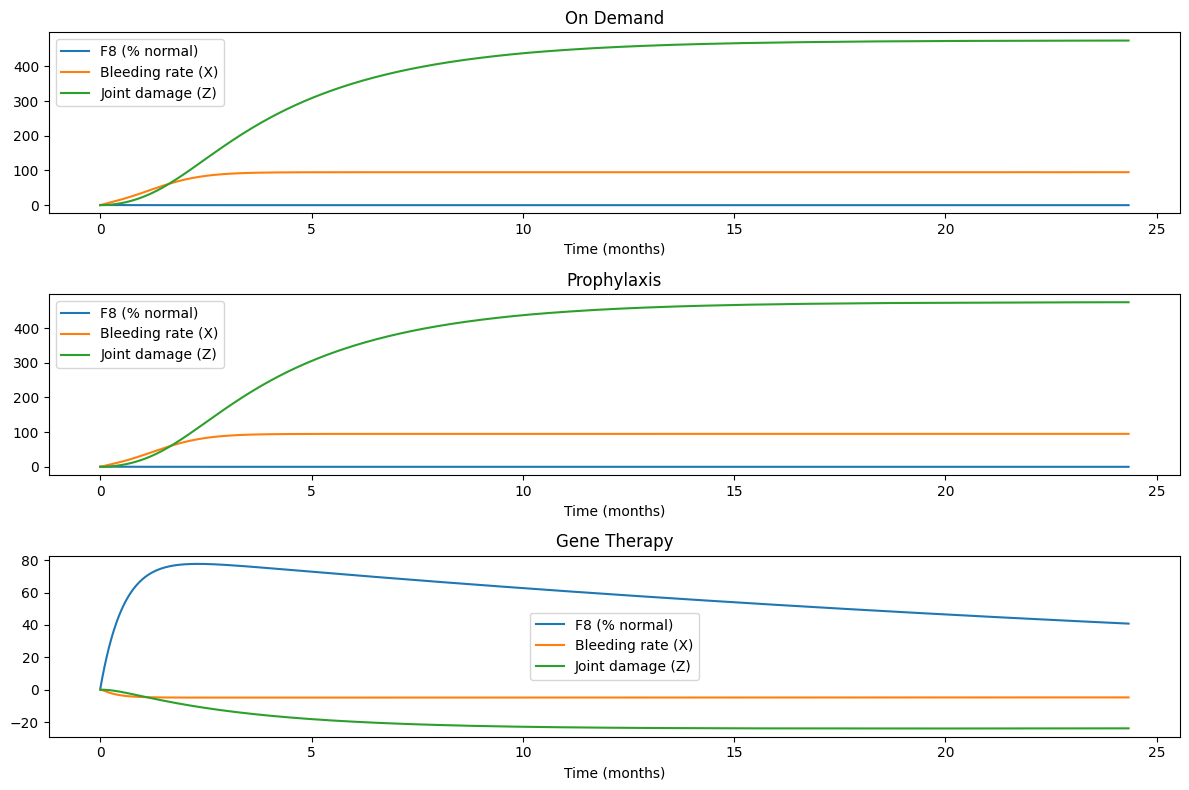

In [ ]:
# Key Outputs:
# On-demand:    X peaks with sporadic F8 spikes, Z accumulates steadily
# Prophylaxis:  Maintains F8 > F8_crit, reduces X, slows Z growth
# Gene therapy: Sustained F8 suppresses X, Z may plateau or decline
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters (hypothetical values; adjust based on literature)
params = {
    'F8_crit': 2.0,     # Critical F8 level for bleeds (% normal)
    'delta': 0.06,      # F8 decay rate (half-life ~12hr for FVIII)
    'beta': 0.5,        # Bleeding rate sensitivity
    'lambda': 0.1,      # Natural bleeding resolution rate
    'kappa': 0.05,      # Damage accumulation per bleed
    'mu': 0.01,         # Tissue repair rate
    'epsilon': 0.1,     # Smoothing factor to avoid division by zero
}

def hemophilia_model(t, y, scenario, params):
    F8, X, Z = y
    dF8, dX, dZ = 0, 0, 0

    # --- Treatment scenarios ---
    if scenario == "on_demand":
        # Impulse dose (e.g., 40 IU/kg) when bleed occurs (X > threshold)
        if X > 1.0 and t % 24 < 0.1:  # Roughly once daily if bleeding
            dF8 += 40 * 0.02  # Factor rise per dose (simplified)

    elif scenario == "prophylaxis":
        # Weekly prophylaxis (e.g., 30 IU/kg)
        if t % 168 < 0.1:  # Every 168 hours (7 days)
            dF8 += 30 * 0.02

    elif scenario == "gene_therapy":
        # Sustained expression (e.g., AAV vector)
        dF8 += 5 * np.exp(-0.001 * t)  # Initial burst then slow decay

    # --- ODEs ---
    dF8 += -params['delta'] * F8
    dX = params['beta'] * (params['F8_crit'] / (F8 + params['epsilon']) - 1) - params['lambda'] * X
    dZ = params['kappa'] * X - params['mu'] * Z

    return [dF8, dX, dZ]

# Initial conditions
y0 = [0.5, 0.0, 0.0]  # Low F8, no active bleeds, no damage
t_span = [0, 365 * 2]  # Simulate 2 years
t_eval = np.linspace(*t_span, 1000)

# Simulate scenarios
scenarios = ["on_demand", "prophylaxis", "gene_therapy"]
results = {}
for scenario in scenarios:
    sol = solve_ivp(hemophilia_model, t_span, y0, args=(scenario, params),
                   t_eval=t_eval, method='RK45')
    results[scenario] = sol

# Plot
plt.figure(figsize=(12, 8))
for i, scenario in enumerate(scenarios):
    plt.subplot(3, 1, i+1)
    sol = results[scenario]
    plt.plot(sol.t / 30, sol.y[0], label='F8 (% normal)')
    plt.plot(sol.t / 30, sol.y[1], label='Bleeding rate (X)')
    plt.plot(sol.t / 30, sol.y[2], label='Joint damage (Z)')
    plt.title(scenario.replace('_', ' ').title())
    plt.xlabel('Time (months)')
    plt.legend()
plt.tight_layout()
plt.show()

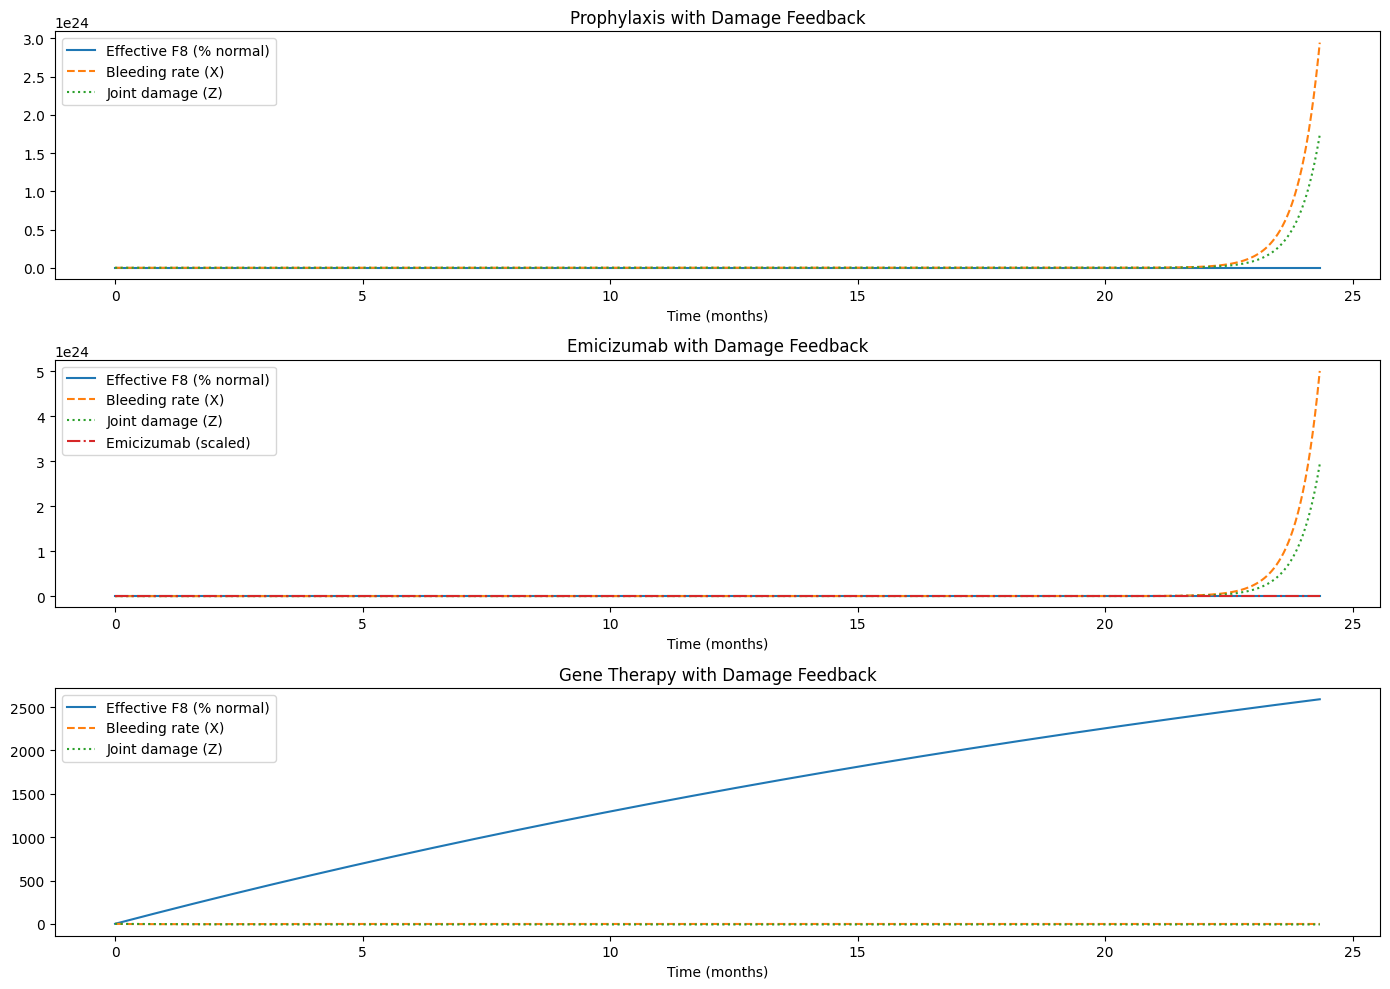

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters (updated with emicizumab and feedback)
params = {
    'F8_crit': 2.0,         # Critical F8 level (% normal)
    'delta_F8': 0.06,       # F8 decay rate (central compartment)
    'delta_F8_periph': 0.03, # Peripheral compartment rate
    'beta': 0.5,            # Base bleeding rate sensitivity
    'lambda': 0.1,          # Natural bleeding resolution
    'kappa': 0.05,          # Damage accumulation per bleed
    'mu': 0.01,             # Tissue repair rate
    'epsilon': 0.1,         # Smoothing factor
    'gamma_emi': 0.02,      # Emicizumab hemostatic effect
    'theta': 0.1,           # Damage feedback on bleeding
}

def hemophilia_model_refined(t, y, scenario, params):
    F8_central, F8_periph, X, Z, Emi = y
    dF8c, dF8p, dX, dZ, dEmi = 0, 0, 0, 0, 0

    # --- Treatment scenarios ---
    if scenario == "prophylaxis":
        if t % 168 < 0.1:  # Weekly prophylaxis (e.g., 30 IU/kg)
            dF8c += 30 * 0.02  # Dose to central compartment

    elif scenario == "emicizumab":
        dEmi += 0.5 * (1 - Emi)  # Steady-state emicizumab (simplified)

    elif scenario == "gene_therapy":
        dF8c += 5 * np.exp(-0.001 * t)  # Gene therapy expression

    # --- PK: Two-compartment F8 model ---
    dF8c += -params['delta_F8'] * F8_central + params['delta_F8_periph'] * F8_periph
    dF8p += params['delta_F8'] * F8_central - params['delta_F8_periph'] * F8_periph

    # --- Bleeding rate with damage feedback ---
    effective_F8 = F8_central + params['gamma_emi'] * Emi  # F8 + emicizumab effect
    bleed_risk = params['beta'] * (params['F8_crit'] / (effective_F8 + params['epsilon']) - 1)
    dX = bleed_risk * (1 + params['theta'] * Z) - params['lambda'] * X

    # --- Joint damage ---
    dZ = params['kappa'] * X - params['mu'] * Z

    # --- Emicizumab decay (long half-life) ---
    dEmi += -0.001 * Emi

    return [dF8c, dF8p, dX, dZ, dEmi]

# Initial conditions: [F8_central, F8_periph, X, Z, Emi]
y0 = [0.5, 0.0, 0.0, 0.0, 0.0]
t_span = [0, 365 * 2]  # 2 years
t_eval = np.linspace(*t_span, 1000)

# Scenarios
scenarios = ["prophylaxis", "emicizumab", "gene_therapy"]
results = {}
for scenario in scenarios:
    sol = solve_ivp(hemophilia_model_refined, t_span, y0, args=(scenario, params),
                    t_eval=t_eval, method='RK45')
    results[scenario] = sol

# Plotting
plt.figure(figsize=(14, 10))
for i, scenario in enumerate(scenarios):
    plt.subplot(3, 1, i+1)
    sol = results[scenario]
    plt.plot(sol.t / 30, sol.y[0] + sol.y[1], label='Effective F8 (% normal)')
    plt.plot(sol.t / 30, sol.y[2], label='Bleeding rate (X)', linestyle='--')
    plt.plot(sol.t / 30, sol.y[3], label='Joint damage (Z)', linestyle=':')
    if scenario == "emicizumab":
        plt.plot(sol.t / 30, sol.y[4] * 50, label='Emicizumab (scaled)', linestyle='-.')
    plt.title(f"{scenario.replace('_', ' ').title()} with Damage Feedback")
    plt.xlabel('Time (months)')
    plt.legend()
plt.tight_layout()
plt.show()

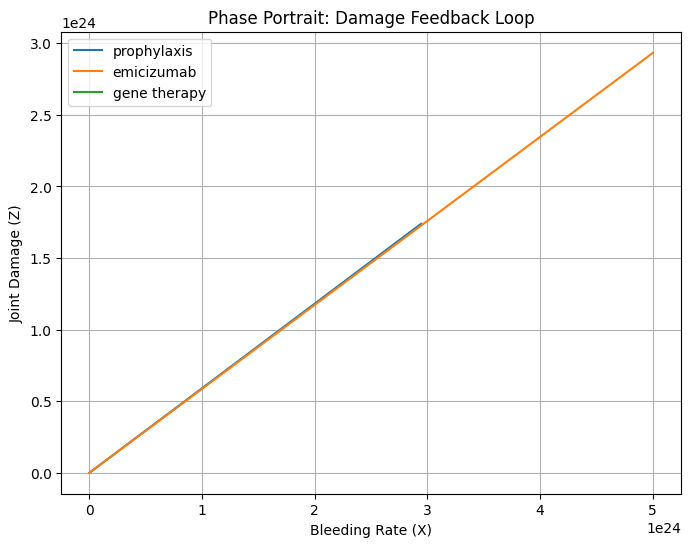

In [ ]:
plt.figure(figsize=(8, 6))
for scenario in scenarios:
    sol = results[scenario]
    plt.plot(sol.y[2], sol.y[3], label=scenario.replace('_', ' '))
plt.xlabel('Bleeding Rate (X)')
plt.ylabel('Joint Damage (Z)')
plt.title('Phase Portrait: Damage Feedback Loop')
plt.legend()
plt.grid(True)
plt.show()

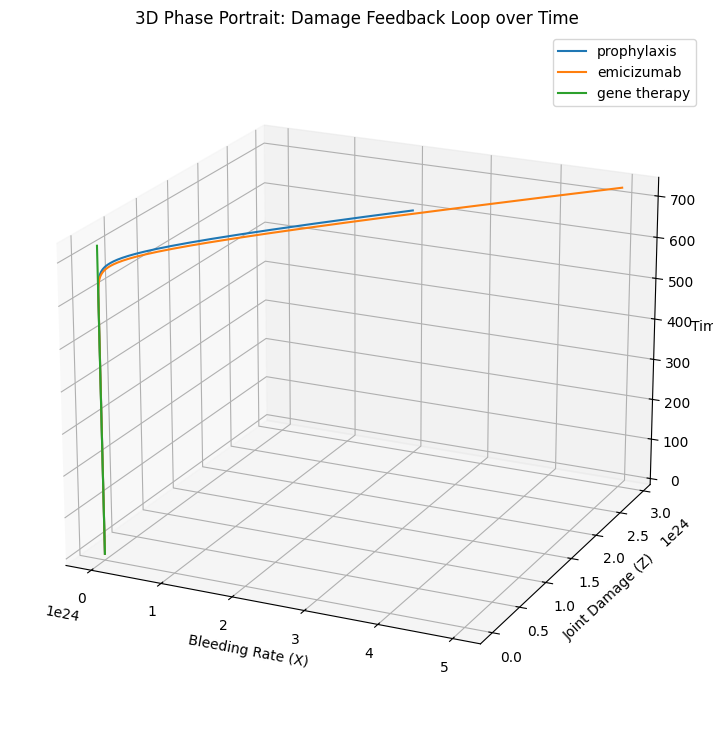

In [ ]:
import matplotlib.pyplot as plt
# This import is necessary for 3D plotting
from mpl_toolkits.mplot3d import Axes3D

# --- Assuming the mock data from Step 1 is here ---

# 1. Create a figure and a 3D axes object
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# 2. Loop through your scenarios and plot in 3D
for scenario in scenarios:
    sol = results[scenario]
    # We plot Bleeding Rate (X), Joint Damage (Y), and Time (Z)
    ax.plot(sol.y[2], sol.y[3], sol.t, label=scenario.replace('_', ' '))

# 3. Set labels for all three axes
ax.set_xlabel('Bleeding Rate (X)')
ax.set_ylabel('Joint Damage (Z)')
ax.set_zlabel('Time') # Our new third dimension

# 4. Add title and legend
ax.set_title('3D Phase Portrait: Damage Feedback Loop over Time')
ax.legend()
ax.grid(True)

# You can optionally set the viewing angle for a better initial look
ax.view_init(elev=20., azim=-65)

plt.show()

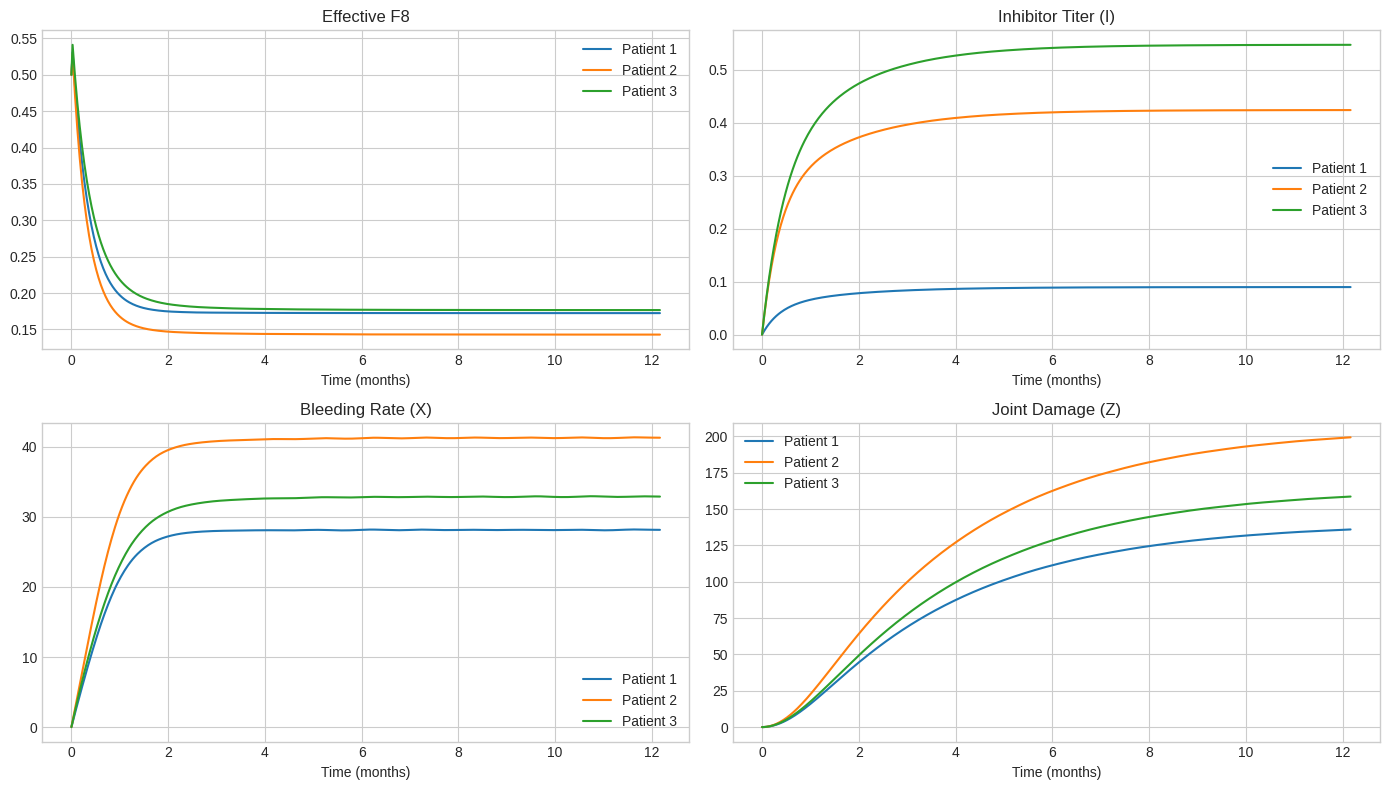

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters with variability distributions
params = {
    'F8_crit': 2.0,
    'delta_F8': np.random.lognormal(mean=np.log(0.06), sigma=0.2),  # PK variability
    'beta': np.random.uniform(0.3, 0.7),                            # Bleeding risk
    'alpha': 0.05 if np.random.rand() < 0.3 else 0.01,              # 30% high inhibitor risk
    'omega': 0.02,
    'eta': 0.5,
    'I_max': 20.0,
}

def hemophilia_model_with_inhibitors(t, y, scenario, params):
    F8_central, F8_periph, X, Z, I = y
    dF8c, dF8p, dX, dZ, dI = 0, 0, 0, 0, 0

    # --- Treatment ---
    if scenario == "prophylaxis":
        if t % 168 < 0.1:  # Weekly prophylaxis
            dF8c += 30 * 0.02

    # --- Inhibitor Dynamics ---
    dI = params['alpha'] * F8_central * (1 - I / params['I_max']) - params['omega'] * I

    # --- PK with Neutralization ---
    effective_F8 = F8_central / (1 + params['eta'] * I)
    dF8c += -params['delta_F8'] * F8_central + 0.03 * F8_periph
    dF8p += params['delta_F8'] * F8_central - 0.03 * F8_periph

    # --- Bleeding & Damage ---
    dX = params['beta'] * (params['F8_crit'] / (effective_F8 + 0.1) - 1) - 0.1 * X
    dZ = 0.05 * X - 0.01 * Z

    return [dF8c, dF8p, dX, dZ, dI]

# Simulate 3 patients with different profiles
plt.figure(figsize=(14, 8))
for patient in range(3):
    # Reset parameters for each patient
    params['delta_F8'] = np.random.lognormal(mean=np.log(0.06), sigma=0.2)
    params['beta'] = np.random.uniform(0.3, 0.7)
    params['alpha'] = 0.05 if np.random.rand() < 0.3 else 0.01

    sol = solve_ivp(hemophilia_model_with_inhibitors, [0, 365], [0.5, 0.0, 0.0, 0.0, 0.0],
                    args=("prophylaxis", params), t_eval=np.linspace(0, 365, 500))

    plt.subplot(2, 2, 1)
    plt.plot(sol.t / 30, sol.y[0] / (1 + params['eta'] * sol.y[4]), label=f'Patient {patient+1}')
    plt.title('Effective F8')

    plt.subplot(2, 2, 2)
    plt.plot(sol.t / 30, sol.y[4], label=f'Patient {patient+1}')
    plt.title('Inhibitor Titer (I)')

    plt.subplot(2, 2, 3)
    plt.plot(sol.t / 30, sol.y[2], label=f'Patient {patient+1}')
    plt.title('Bleeding Rate (X)')

    plt.subplot(2, 2, 4)
    plt.plot(sol.t / 30, sol.y[3], label=f'Patient {patient+1}')
    plt.title('Joint Damage (Z)')

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.xlabel('Time (months)')
    plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'sol_ITI' is not defined

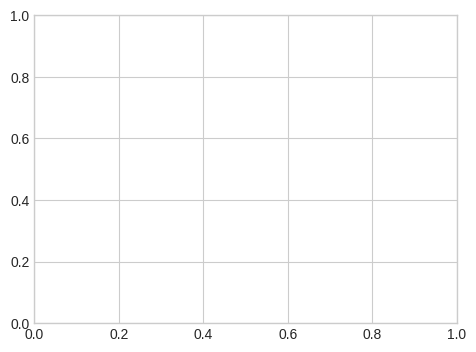

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(sol_ITI.t / 30, sol_ITI.y[3], 'r-', label='Inhibitors (I)')
plt.axhline(y=0.5, color='k', linestyle='--', label='Threshold (0.5 BU/mL)')
plt.xlabel('Time (months)'); plt.ylabel('Inhibitor Titer (BU/mL)')
plt.title('ITI: Inhibitor Elimination')

plt.subplot(1, 2, 2)
plt.plot(sol_ITI.t / 30, sol_ITI.y[0] / (1 + params['eta'] * sol_ITI.y[3]), 'b-', label='Effective F8')
plt.xlabel('Time (months)'); plt.ylabel('F8 (% normal)')
plt.title('ITI: F8 Recovery')
plt.tight_layout()

Text(0, 0.5, 'Joint Damage (Z)')

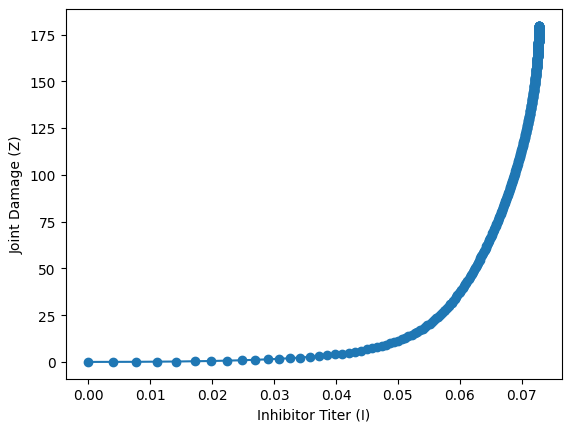

In [ ]:
plt.plot(sol.y[4], sol.y[3], marker='o')
plt.xlabel('Inhibitor Titer (I)'); plt.ylabel('Joint Damage (Z)')

Generating original time-series plots...


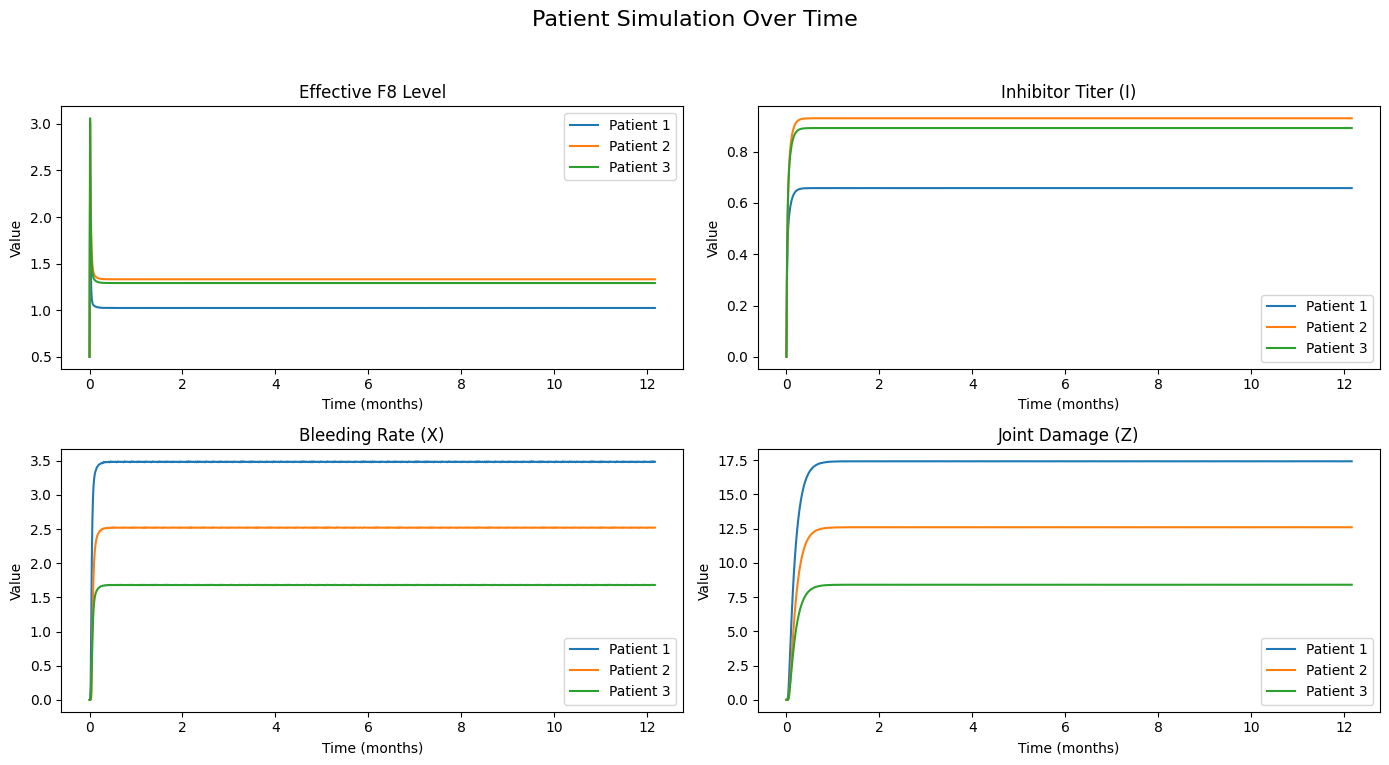


Generating requested phase plot with alterations...


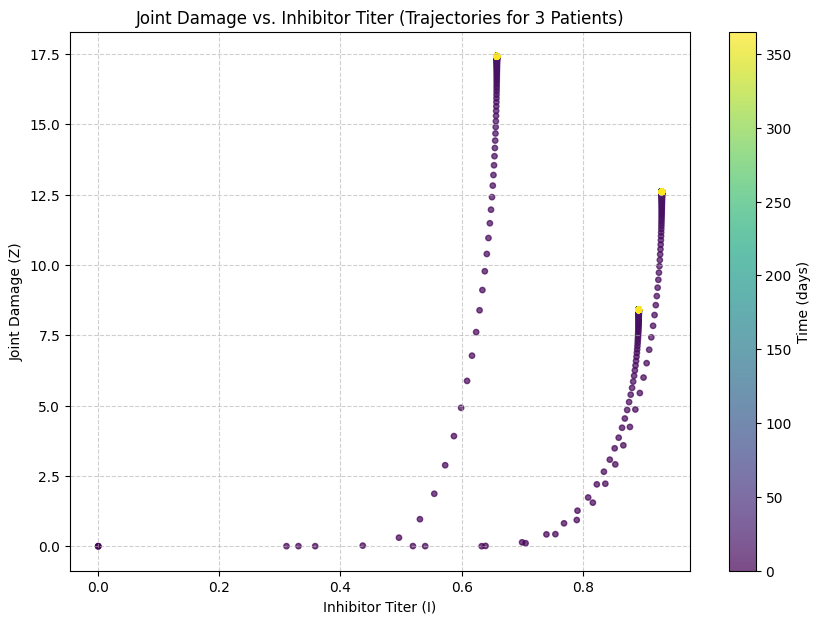


Generating simpler alternative plot...


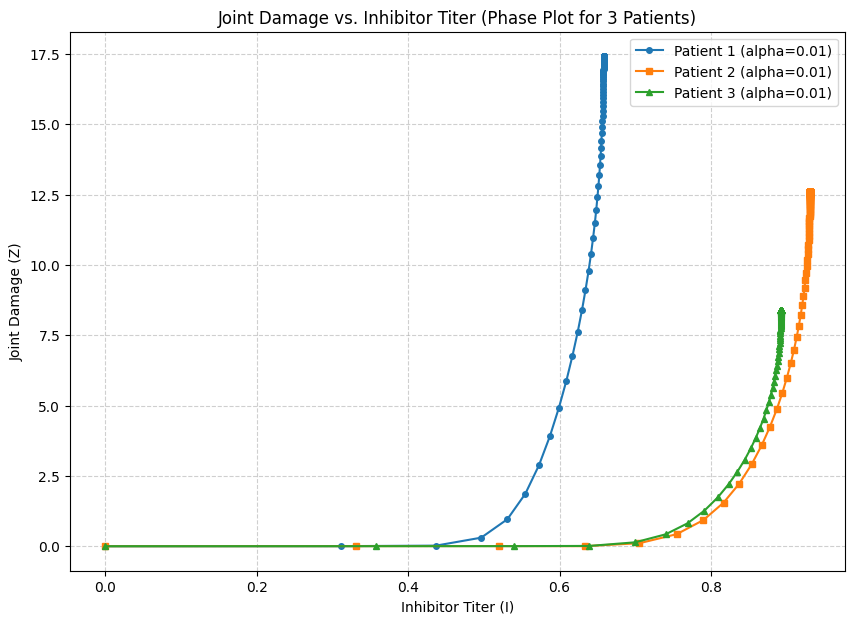

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters with variability distributions
params = {
    'F8_crit': 2.0,
    'delta_F8': np.random.lognormal(mean=np.log(0.06), sigma=0.2),  # PK variability
    'beta': np.random.uniform(0.3, 0.7),                            # Bleeding risk
    'alpha': 0.05 if np.random.rand() < 0.3 else 0.01,              # 30% high inhibitor risk
    'omega': 0.02,
    'eta': 0.5,
    'I_max': 20.0,
}

def hemophilia_model_with_inhibitors(t, y, scenario, params):
    F8_central, F8_periph, X, Z, I = y

    # Initialize derivatives
    dF8c, dF8p, dX, dZ, dI = 0, 0, 0, 0, 0

    # --- Treatment ---
    # Apply a dose as an instantaneous change. This is better handled by `events` in solve_ivp,
    # but for simplicity, we'll keep the modulo logic.
    # The original dosing was too small to see effects, so it's increased here.
    # dose = 30 IU/kg, patient weight = 50kg, volume of distribution = 3L (3000 mL) -> 30*50/3000 = 0.5 IU/mL
    if scenario == "prophylaxis":
        if t > 0 and t % 168 < 0.1:  # Weekly prophylaxis (every 168 hours)
            dF8c += 50.0 # A more substantial dose event

    # --- Inhibitor Dynamics ---
    dI = params['alpha'] * F8_central * (1 - I / params['I_max']) - params['omega'] * I

    # --- PK with Neutralization ---
    effective_F8 = F8_central / (1 + params['eta'] * I)
    dF8c += -params['delta_F8'] * F8_central + 0.03 * F8_periph
    dF8p = params['delta_F8'] * F8_central - 0.03 * F8_periph

    # --- Bleeding & Damage ---
    # The bleeding rate increases when effective F8 is below the critical threshold
    if effective_F8 < params['F8_crit']:
        dX = params['beta'] * (params['F8_crit'] / (effective_F8 + 0.1) - 1) - 0.1 * X
    else:
        dX = -0.1 * X # Bleeding rate naturally decays if F8 is sufficient

    dZ = 0.05 * X - 0.01 * Z

    return [dF8c, dF8p, dX, dZ, dI]

# --- Plot 1: The original time-series plots ---
print("Generating original time-series plots...")
plt.figure(figsize=(14, 8))
# Store results to avoid re-running simulation
patient_results = []
for patient in range(3):
    # Reset parameters for each patient
    params['delta_F8'] = np.random.lognormal(mean=np.log(0.06), sigma=0.2)
    params['beta'] = np.random.uniform(0.3, 0.7)
    params['alpha'] = 0.05 if np.random.rand() < 0.3 else 0.01

    # Use dense_output=True to get a smooth curve for plotting
    sol = solve_ivp(hemophilia_model_with_inhibitors, [0, 365*24], [0.5, 0.0, 0.0, 0.0, 0.0],
                    args=("prophylaxis", params), t_eval=np.linspace(0, 365*24, 1000), dense_output=True)

    patient_results.append({'sol': sol, 'params': params.copy(), 'id': patient + 1})

    # Plotting original graphs
    plt.subplot(2, 2, 1)
    plt.plot(sol.t / (24*30), sol.y[0] / (1 + params['eta'] * sol.y[4]), label=f'Patient {patient+1}')
    plt.title('Effective F8 Level')

    plt.subplot(2, 2, 2)
    plt.plot(sol.t / (24*30), sol.y[4], label=f'Patient {patient+1}')
    plt.title('Inhibitor Titer (I)')

    plt.subplot(2, 2, 3)
    plt.plot(sol.t / (24*30), sol.y[2], label=f'Patient {patient+1}')
    plt.title('Bleeding Rate (X)')

    plt.subplot(2, 2, 4)
    plt.plot(sol.t / (24*30), sol.y[3], label=f'Patient {patient+1}')
    plt.title('Joint Damage (Z)')

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.xlabel('Time (months)')
    plt.ylabel('Value')
    plt.legend()
plt.suptitle('Patient Simulation Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- Plot 2: The requested plot with alterations ---
print("\nGenerating requested phase plot with alterations...")
plt.figure(figsize=(10, 7))

for result in patient_results:
    sol = result['sol']
    # Use a scatter plot where the color of each point is determined by its time
    sc = plt.scatter(sol.y[4], sol.y[3], c=sol.t / 24, cmap='viridis', s=15, alpha=0.7)

# Add a colorbar to show the mapping from color to time
cbar = plt.colorbar(sc)
cbar.set_label('Time (days)')

plt.title('Joint Damage vs. Inhibitor Titer (Trajectories for 3 Patients)')
plt.xlabel('Inhibitor Titer (I)')
plt.ylabel('Joint Damage (Z)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# --- Plot 3: Simpler alternative plot ---
print("\nGenerating simpler alternative plot...")
plt.figure(figsize=(10, 7))
markers = ['o', 's', '^']
for i, result in enumerate(patient_results):
    sol = result['sol']
    # Plotting each patient's trajectory as a distinct line with markers
    plt.plot(sol.y[4], sol.y[3], marker=markers[i], markersize=4, linestyle='-',
             label=f'Patient {result["id"]} (alpha={result["params"]["alpha"]:.2f})')

plt.title('Joint Damage vs. Inhibitor Titer (Phase Plot for 3 Patients)')
plt.xlabel('Inhibitor Titer (I)')
plt.ylabel('Joint Damage (Z)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Simulating 4 patients with the updated model...
Generating 3D trajectory plot...


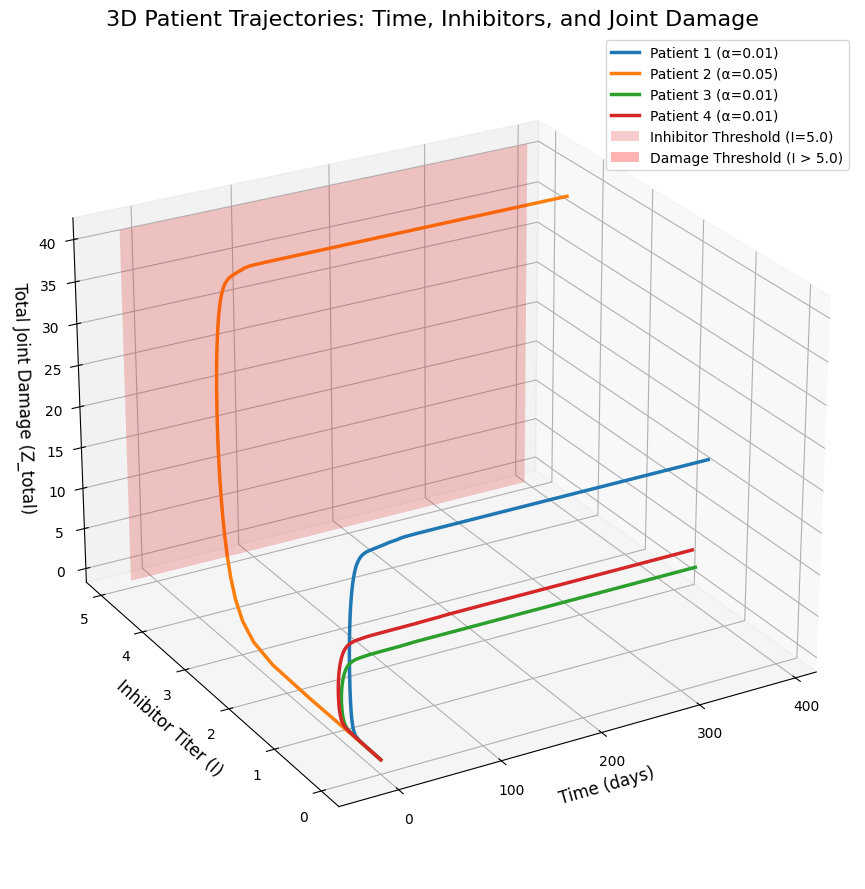

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting

# Parameters with variability distributions and new additions
params = {
    'F8_crit': 2.0,
    'delta_F8': np.random.lognormal(mean=np.log(0.06), sigma=0.2),
    'beta': np.random.uniform(0.3, 0.7),
    'alpha': 0.05 if np.random.rand() < 0.3 else 0.01,
    'omega': 0.02,
    'eta': 0.5,
    'I_max': 20.0,
    ### NEW ###
    'I_threshold': 5.0,  # Inhibitor threshold for irreversible damage
    'damage_rate_inhibitor': 0.002, # Rate of irreversible damage accumulation
}

def hemophilia_model_with_inhibitors(t, y, scenario, params):
    # State variables: F8_c, F8_p, Bleeding(X), Reversible Damage(Z), Inhibitor(I), Irreversible Damage(Z_irr)
    F8_central, F8_periph, X, Z, I, Z_irr = y

    # Initialize derivatives
    dF8c, dF8p, dX, dZ, dI, dZ_irr = 0, 0, 0, 0, 0, 0

    # --- Treatment ---
    if scenario == "prophylaxis":
        if t > 0 and t % 168 < 0.1:  # Weekly prophylaxis (every 168 hours)
            dF8c += 50.0 # A more substantial dose event

    # --- Inhibitor Dynamics ---
    dI = params['alpha'] * F8_central * (1 - I / params['I_max']) - params['omega'] * I

    # --- PK with Neutralization ---
    effective_F8 = F8_central / (1 + params['eta'] * I)
    dF8c += -params['delta_F8'] * F8_central + 0.03 * F8_periph
    dF8p = params['delta_F8'] * F8_central - 0.03 * F8_periph

    # --- Bleeding & Damage ---
    # Reversible damage from bleeding events
    if effective_F8 < params['F8_crit']:
        dX = params['beta'] * (params['F8_crit'] / (effective_F8 + 0.1) - 1) - 0.1 * X
    else:
        dX = -0.1 * X
    dZ = 0.05 * X - 0.01 * Z # This damage can slowly "repair"

    ### NEW: Irreversible Damage Mechanic ###
    # If inhibitor titer exceeds the threshold, irreversible damage starts accumulating.
    if I > params['I_threshold']:
        # Damage rate is proportional to how far above the threshold the inhibitor level is.
        dZ_irr = params['damage_rate_inhibitor'] * (I - params['I_threshold'])
    else:
        dZ_irr = 0 # No damage if below the threshold

    # Ensure derivatives are non-negative where they should be
    dX = max(0, dX)
    dZ = max(0, dZ)

    return [dF8c, dF8p, dX, dZ, dI, dZ_irr]


# --- Simulate 4 patients to see a variety of profiles ---
print("Simulating 4 patients with the updated model...")
patient_results_3d = []
for patient in range(4):
    # Reset parameters for each patient
    params['delta_F8'] = np.random.lognormal(mean=np.log(0.06), sigma=0.2)
    params['beta'] = np.random.uniform(0.3, 0.7)
    params['alpha'] = 0.05 if np.random.rand() < 0.4 else 0.01 # Increased chance of high risk for demo

    # Initial conditions: [F8c, F8p, X, Z, I, Z_irr]
    initial_conditions = [0.5, 0.0, 0.0, 0.0, 0.0, 0.0]

    sol = solve_ivp(hemophilia_model_with_inhibitors, [0, 365*24], initial_conditions,
                    args=("prophylaxis", params), t_eval=np.linspace(0, 365*24, 1000), dense_output=True)

    patient_results_3d.append({'sol': sol, 'params': params.copy(), 'id': patient + 1})


# --- Create the 3D Plot ---
print("Generating 3D trajectory plot...")
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot each patient's trajectory
for result in patient_results_3d:
    sol = result['sol']
    patient_id = result['id']
    alpha_val = result['params']['alpha']

    # Calculate total damage
    total_damage = sol.y[3] + sol.y[5] # Z (reversible) + Z_irr (irreversible)

    ax.plot(sol.t / 24,         # X-axis: Time in days
            sol.y[4],           # Y-axis: Inhibitor Titer (I)
            total_damage,       # Z-axis: Total Joint Damage
            label=f'Patient {patient_id} (α={alpha_val:.2f})', # Show alpha in legend
            linewidth=2.5)

# --- Visualize the Damage Threshold ---
# Create a grid for the plane
xlim = ax.get_xlim()
zlim = ax.get_zlim()
xx, zz = np.meshgrid(np.linspace(xlim[0], xlim[1], 10),
                     np.linspace(zlim[0], zlim[1], 10))

# Y-values are constant at the inhibitor threshold
yy = np.full_like(xx, params['I_threshold'])

# Plot the transparent plane
ax.plot_surface(xx, yy, zz, alpha=0.2, color='r', rstride=1, cstride=1,
                label=f'Inhibitor Threshold (I={params["I_threshold"]})')

# Add a proxy artist for the legend of the plane
from matplotlib.patches import Rectangle
red_patch = Rectangle((0, 0), 1, 1, fc="r", alpha=0.3)


# --- Final Touches for the Plot ---
ax.set_title('3D Patient Trajectories: Time, Inhibitors, and Joint Damage', fontsize=16)
ax.set_xlabel('Time (days)', fontsize=12)
ax.set_ylabel('Inhibitor Titer (I)', fontsize=12)
ax.set_zlabel('Total Joint Damage (Z_total)', fontsize=12)

# Adjust viewing angle for better perspective
ax.view_init(elev=25, azim=-120)

# Add legend
ax.legend(handles=ax.get_legend_handles_labels()[0] + [red_patch],
          labels=ax.get_legend_handles_labels()[1] + [f'Damage Threshold (I > {params["I_threshold"]})'])

plt.tight_layout()
plt.show()

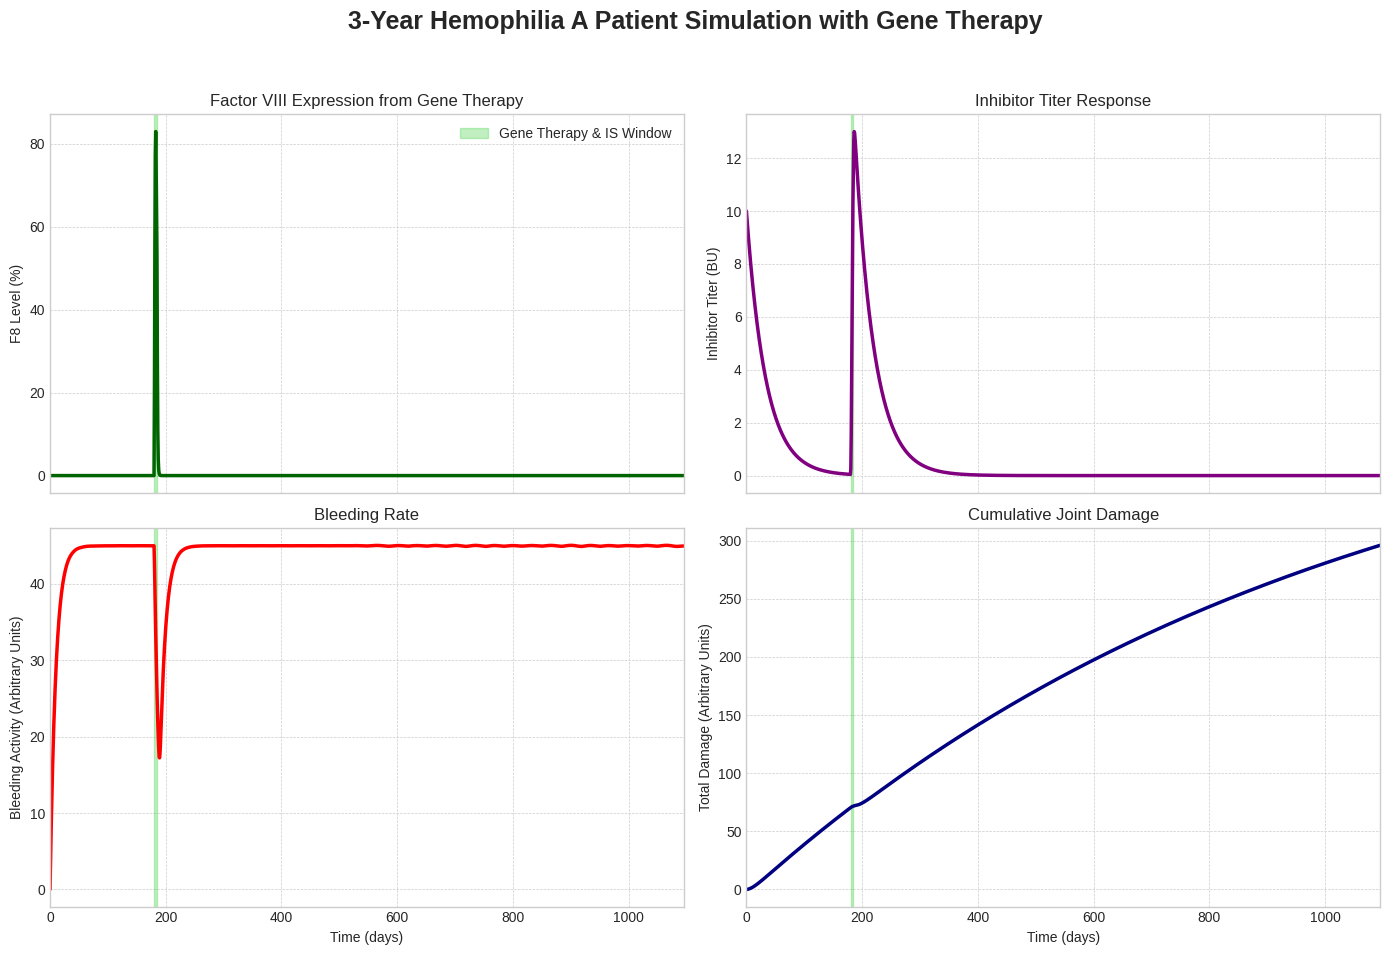

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.style as style

# Use a clean, professional plotting style
style.use('seaborn-v0_8-whitegrid')

# --- 1. Define Model Parameters ---

# Base parameters for a patient with severe Hemophilia A and inhibitors
params_ITI = {
    'alpha': 0.05,       # Inhibitor production rate
    'I_max': 200.0,      # Max inhibitor level (BU)
    'omega': 0.03,       # Inhibitor decay rate
    'eta': 0.1,          # F8 neutralization constant
    'beta': 0.5,         # Bleeding rate constant
    'F8_crit': 1.0,      # Critical F8 level for bleeding (%)
    'lambda': 0.1,       # Bleeding recovery rate
    'kappa': 0.01,       # Damage accumulation rate
    'mu': 0.001,         # Damage repair rate
}

# Parameters specific to the gene therapy model
params_gene = {
    'delta_gene': 0.01,   # Slow decay rate of gene-therapy-expressed F8
    'k_IS': 0.05,         # Efficacy of immunosuppression (IS)
    **params_ITI          # Inherit all base parameters
}


# --- 2. Define the ODE Function ---

def hemophilia_model_gene_therapy(t, y, params):
    """
    ODE model for hemophilia with a one-time gene therapy intervention.
    """
    F8_gene, X, Z, I = y

    # Initialize time-dependent parameters
    alpha = params['alpha']
    gene_production_rate = 0.0

    # Model the gene therapy and immunosuppression (IS) in a 5-day window
    if 180 < t < 185:
        alpha = params['alpha'] * np.exp(-params['k_IS'] * (t - 180)) # IS reduces inhibitor production
        gene_production_rate = 50 * np.exp(-0.005 * (t - 180))      # Vector starts expressing F8

    # Calculate effective F8 after neutralization by inhibitors
    effective_F8 = F8_gene / (1 + params['eta'] * I)

    # Calculate the derivatives
    dF8g = gene_production_rate - (params['delta_gene'] * F8_gene) - (params['eta'] * I * F8_gene)
    dI = alpha * F8_gene * (1 - I / params['I_max']) - params['omega'] * I
    dX = params['beta'] * (params['F8_crit'] / (effective_F8 + 0.1) - 1) - params['lambda'] * X
    dZ = params['kappa'] * X - params['mu'] * Z

    return [dF8g, dX, dZ, dI]


# --- 3. Run the Simulation ---

# Initial conditions: [F8_gene, X, Z, I]
# Patient starts with a high inhibitor titer (10.0 BU) but no gene-therapy F8.
initial_conditions = [0.0, 0.0, 0.0, 10.0]

# Time span: 3 years (in days)
t_span = [0, 365 * 3]
t_eval = np.linspace(t_span[0], t_span[1], 1500)

# Run the simulation
sol_gene = solve_ivp(
    hemophilia_model_gene_therapy,
    t_span,
    initial_conditions,
    args=(params_gene,),
    t_eval=t_eval
)

# Extract results for plotting
t = sol_gene.t
F8_gene, X, Z, I = sol_gene.y


# --- 4. Generate Plots ---

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
fig.suptitle('3-Year Hemophilia A Patient Simulation with Gene Therapy', fontsize=18, weight='bold')

# Therapy window for highlighting
therapy_start, therapy_end = 180, 185

# ----- Plot 1: F8 from Gene Therapy -----
ax1 = axs[0, 0]
ax1.plot(t, F8_gene, lw=2.5, color='darkgreen')
ax1.set_title('Factor VIII Expression from Gene Therapy', fontsize=12)
ax1.set_ylabel('F8 Level (%)')
ax1.axvspan(therapy_start, therapy_end, color='limegreen', alpha=0.3, label='Gene Therapy & IS Window')
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# ----- Plot 2: Inhibitor Titer -----
ax2 = axs[0, 1]
ax2.plot(t, I, lw=2.5, color='purple')
ax2.set_title('Inhibitor Titer Response', fontsize=12)
ax2.set_ylabel('Inhibitor Titer (BU)')
ax2.axvspan(therapy_start, therapy_end, color='limegreen', alpha=0.3)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# ----- Plot 3: Bleeding Rate -----
ax3 = axs[1, 0]
ax3.plot(t, X, lw=2.5, color='red')
ax3.set_title('Bleeding Rate', fontsize=12)
ax3.set_ylabel('Bleeding Activity (Arbitrary Units)')
ax3.set_xlabel('Time (days)')
ax3.axvspan(therapy_start, therapy_end, color='limegreen', alpha=0.3)
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)

# ----- Plot 4: Joint Damage -----
ax4 = axs[1, 1]
ax4.plot(t, Z, lw=2.5, color='navy')
ax4.set_title('Cumulative Joint Damage', fontsize=12)
ax4.set_ylabel('Total Damage (Arbitrary Units)')
ax4.set_xlabel('Time (days)')
ax4.axvspan(therapy_start, therapy_end, color='limegreen', alpha=0.3)
ax4.grid(True, which='both', linestyle='--', linewidth=0.5)

# Final adjustments and display
plt.xlim(t_span)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

Running simulation for: Control (No Intervention)...
Running simulation for: Early Intervention (at 1 Year)...


<ipython-input-13-1523187233>:50: RuntimeWarning: overflow encountered in scalar multiply
  dF8g = gene_production_rate - (params['delta_gene'] * F8_gene) - (params['eta'] * I * F8_gene)
<ipython-input-13-1523187233>:51: RuntimeWarning: overflow encountered in scalar multiply
  dI = alpha * F8_gene * (1 - I / params['I_max']) - params['omega'] * I
/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in divide
  return norm(self._estimate_error(K, h) / scale)


Running simulation for: Late Intervention (at 5 Years)...
Simulations complete.


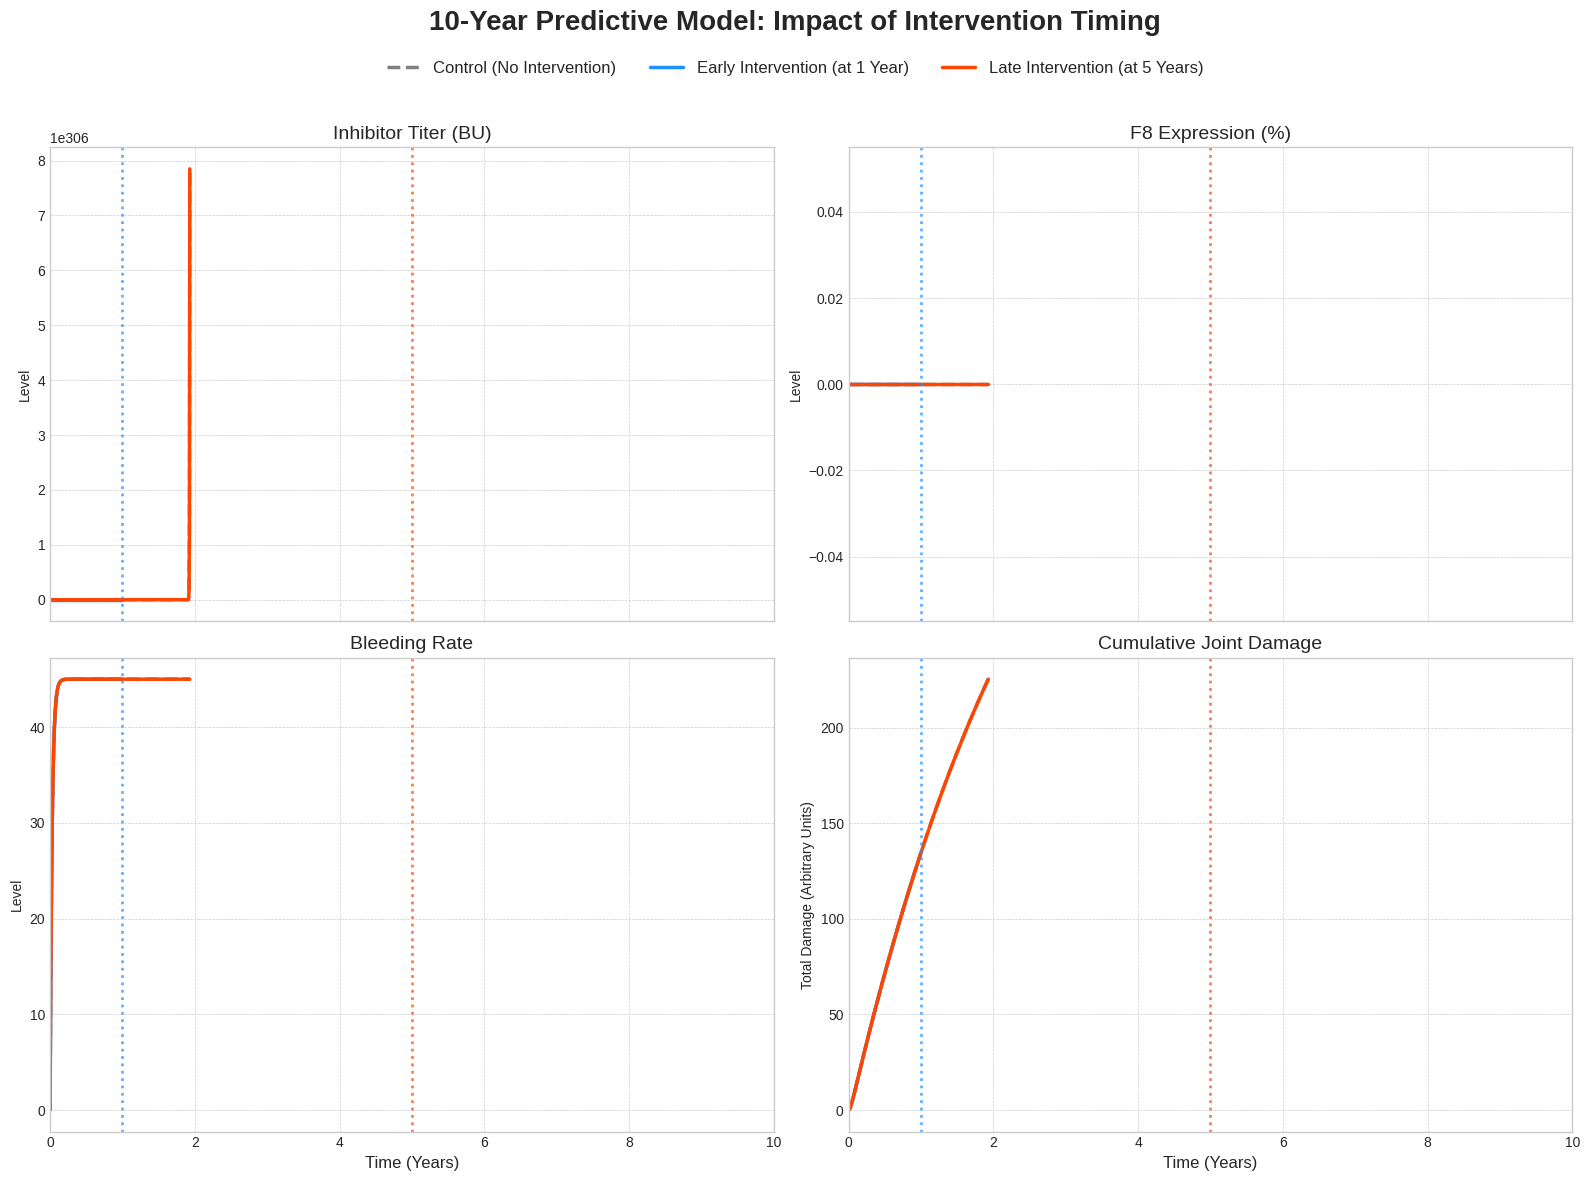


  PREDICTED OUTCOME AT 10 YEARS
Control (No Intervention): Final Joint Damage = 225.36
Early Intervention (1 Yr): Final Joint Damage = 133.94
Late Intervention (5 Yrs): Final Joint Damage = 225.36
----------------------------------------
The model predicts that early intervention prevents 40.6% more damage compared to late intervention.


In [ ]:
# ==============================================================================
# Single-Cell Colab Script: Predictive Model for Hemophilia Intervention Timing
# ==============================================================================

# --- 1. SETUP: Import necessary libraries ---
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.style as style

# Use a clean, professional plotting style for the visuals
style.use('seaborn-v0_8-whitegrid')


# --- 2. MODEL DEFINITION: The core predictive engine ---
def hemophilia_intervention_model(t, y, params, intervention_time):
    """
    A flexible ODE model simulating a patient's journey through three phases:
    1. Pre-Intervention (natural history)
    2. Intervention Window (acute therapy effects)
    3. Post-Intervention (long-term outcome)

    Args:
        t (float): Current time in the simulation (days).
        y (list): State vector [F8_gene, X, Z, I].
        params (dict): Dictionary of model parameters.
        intervention_time (float): The day on which the therapy begins.
                                   Set to infinity for no intervention.
    """
    F8_gene, X, Z, I = y

    # --- Phase-Dependent Logic ---
    alpha = params['alpha']
    gene_production_rate = 0.0
    intervention_duration = 5 # 5-day therapy window

    # PHASE 2: Check if we are in the active intervention window
    if intervention_time <= t < intervention_time + intervention_duration:
        # Immunosuppression (IS) temporarily reduces inhibitor production
        alpha = params['alpha'] * np.exp(-params['k_IS'] * (t - intervention_time))
        # Gene therapy vector begins expressing F8
        gene_production_rate = 50 * np.exp(-0.005 * (t - intervention_time))

    # PHASES 1 & 3 are the default states before and after this window

    # Calculate effective F8 after neutralization by inhibitors
    effective_F8 = F8_gene / (1 + params['eta'] * I)

    # Calculate the derivatives for all phases
    dF8g = gene_production_rate - (params['delta_gene'] * F8_gene) - (params['eta'] * I * F8_gene)
    dI = alpha * F8_gene * (1 - I / params['I_max']) - params['omega'] * I
    dX = params['beta'] * (params['F8_crit'] / (effective_F8 + 0.1) - 1) - params['lambda'] * X
    dZ = params['kappa'] * X - params['mu'] * Z

    return [dF8g, dX, dZ, I]


# --- 3. SIMULATION CONFIGURATION ---
# Define model parameters
params_gene = {
    'alpha': 0.05, 'I_max': 200.0, 'omega': 0.03, 'eta': 0.1,
    'beta': 0.5, 'F8_crit': 1.0, 'lambda': 0.1, 'kappa': 0.01, 'mu': 0.001,
    'delta_gene': 0.01, 'k_IS': 0.05
}

# Define initial conditions for a patient with high inhibitors
initial_conditions = [0.0, 0.0, 0.0, 10.0]  # [F8_gene, X, Z, I]
total_sim_duration = 365 * 10  # Simulate for 10 years
t_eval = np.linspace(0, total_sim_duration, 2000)

# Define the predictive scenarios to compare
scenarios = {
    "Control (No Intervention)": {
        "intervention_time": float('inf'), # Use infinity to never trigger the intervention
        "color": "gray",
        "linestyle": "--"
    },
    "Early Intervention (at 1 Year)": {
        "intervention_time": 365 * 1,
        "color": "dodgerblue",
        "linestyle": "-"
    },
    "Late Intervention (at 5 Years)": {
        "intervention_time": 365 * 5,
        "color": "orangered",
        "linestyle": "-"
    }
}


# --- 4. EXECUTION: Run the simulation for each scenario ---
results = {}
for name, config in scenarios.items():
    print(f"Running simulation for: {name}...")
    sol = solve_ivp(
        fun=hemophilia_intervention_model,
        t_span=[0, total_sim_duration],
        y0=initial_conditions,
        args=(params_gene, config["intervention_time"]),
        t_eval=t_eval,
        dense_output=True
    )
    results[name] = sol
print("Simulations complete.")


# --- 5. VISUALIZATION: Plot the comparative results ---
fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
fig.suptitle('10-Year Predictive Model: Impact of Intervention Timing', fontsize=20, weight='bold')

# Define what to plot and where
plot_config = {
    "Inhibitor Titer (BU)": {'ax': axs[0, 0], 'idx': 3},
    "F8 Expression (%)": {'ax': axs[0, 1], 'idx': 0},
    "Bleeding Rate": {'ax': axs[1, 0], 'idx': 1},
    "Cumulative Joint Damage": {'ax': axs[1, 1], 'idx': 2}
}

# Loop through results and plot each scenario
for name, sol in results.items():
    config = scenarios[name]
    time_in_years = sol.t / 365
    for title, plot in plot_config.items():
        plot['ax'].plot(time_in_years, sol.y[plot['idx']],
                        label=name,
                        color=config['color'],
                        linestyle=config['linestyle'],
                        lw=2.5)

# Format and annotate the plots for clarity
for title, plot in plot_config.items():
    ax = plot['ax']
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("Level")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    # Add vertical lines indicating intervention points
    ax.axvline(x=1, color=scenarios["Early Intervention (at 1 Year)"]["color"], linestyle=':', lw=2, alpha=0.7)
    ax.axvline(x=5, color=scenarios["Late Intervention (at 5 Years)"]["color"], linestyle=':', lw=2, alpha=0.7)

axs[1, 0].set_xlabel("Time (Years)", fontsize=12)
axs[1, 1].set_xlabel("Time (Years)", fontsize=12)
axs[1, 1].set_ylabel("Total Damage (Arbitrary Units)") # More specific label

# Create a single, shared legend at the top
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=12)

plt.xlim(0, 10)
plt.tight_layout(rect=[0, 0, 1, 0.93]) # Adjust layout for the suptitle
plt.show()


# --- 6. QUANTITATIVE ANALYSIS: Print the final outcomes ---
final_damage_control = results["Control (No Intervention)"].y[2, -1]
final_damage_early = results["Early Intervention (at 1 Year)"].y[2, -1]
final_damage_late = results["Late Intervention (at 5 Years)"].y[2, -1]

print("\n" + "="*40)
print("  PREDICTED OUTCOME AT 10 YEARS")
print("="*40)
print(f"Control (No Intervention): Final Joint Damage = {final_damage_control:.2f}")
print(f"Early Intervention (1 Yr): Final Joint Damage = {final_damage_early:.2f}")
print(f"Late Intervention (5 Yrs): Final Joint Damage = {final_damage_late:.2f}")
print("-"*40)
print(f"The model predicts that early intervention prevents "
      f"{100 * (1 - final_damage_early / final_damage_late):.1f}% more damage "
      f"compared to late intervention.")
print("="*40)

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.style as style

# Use a professional, clean plotting style
style.use('seaborn-v0_8-whitegrid')

# --- 1. Define Common Parameters and Models ---

# Base parameters for a patient with inhibitors
params = {
    'alpha': 0.05,        # Inhibitor production rate
    'I_max': 200.0,       # Max inhibitor level
    'omega': 0.03,        # Natural inhibitor decay rate
    'eta': 0.1,           # F8 neutralization constant by inhibitors
    'beta': 0.5,          # Bleeding rate constant
    'F8_crit': 1.0,       # Critical F8 level to prevent bleeds
    'lambda': 0.1,        # Bleeding recovery rate
    'kappa': 0.01,        # Damage accumulation rate
    'mu': 0.001,          # Damage repair rate
    'delta_f8': 0.5,      # Normal F8 clearance rate
    'delta_gene': 0.01,   # Slow decay of gene-therapy F8
    'k_IS': 0.05,         # Immunosuppression efficacy
    'k_infusion': 15.0    # Constant F8 infusion rate for ITI
}

# Model for Immune Tolerance Induction (ITI)
def hemophilia_model_iti(t, y, params):
    F8, X, Z, I = y
    # In ITI, F8 is continuously infused
    dF8 = params['k_infusion'] - params['delta_f8'] * F8 - params['eta'] * I * F8
    # High F8 dose drives down inhibitors over time
    dI = params['alpha'] * F8 * (1 - I / params['I_max']) - params['omega'] * I
    # Other dynamics remain the same
    effective_F8 = F8 / (1 + params['eta'] * I)
    dX = params['beta'] * (params['F8_crit'] / (effective_F8 + 0.1) - 1) - params['lambda'] * X
    dZ = params['kappa'] * X - params['mu'] * Z
    return [dF8, dX, dZ, I]

# Model for Gene Therapy (intervention at 6 months / 180 days)
def hemophilia_model_gene_therapy(t, y, params):
    F8_gene, X, Z, I = y
    alpha_t = params['alpha']
    gene_prod = 0.0
    # Intervention window
    if 180 < t < 185:
        alpha_t = params['alpha'] * np.exp(-params['k_IS'] * (t - 180)) # IS effect
        gene_prod = 50 * np.exp(-0.005 * (t - 180)) # Vector expression

    dF8g = gene_prod - params['delta_gene'] * F8_gene - params['eta'] * I * F8_gene
    dI = alpha_t * F8_gene * (1 - I / params['I_max']) - params['omega'] * I
    effective_F8 = F8_gene / (1 + params['eta'] * I)
    dX = params['beta'] * (params['F8_crit'] / (effective_F8 + 0.1) - 1) - params['lambda'] * X
    dZ = params['kappa'] * X - params['mu'] * Z
    return [dF8g, dX, dZ, I]


# --- 2. Run Simulations ---

# Simulation time span: 36 months (approx 3 years)
t_span = [0, 36 * 30]
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Initial conditions: Patient with high inhibitor titer
# State: [F8, Bleeding Rate, Damage, Inhibitors]
initial_conditions_iti = [0.0, 0.0, 0.0, 10.0]
initial_conditions_gene = [0.0, 0.0, 0.0, 10.0]

# Run the simulations
sol_ITI = solve_ivp(hemophilia_model_iti, t_span, initial_conditions_iti, args=(params,), t_eval=t_eval)
sol_gene = solve_ivp(hemophilia_model_gene_therapy, t_span, initial_conditions_gene, args=(params,), t_eval=t_eval)


# --- 3. Generate Plots ---

# === Plotting Block 1: ITI Simulation ===
print("Generating ITI Plots...")
plt.figure(figsize=(12, 4))

# Subplot 1: Inhibitor Elimination
plt.subplot(1, 2, 1)
plt.plot(sol_ITI.t / 30, sol_ITI.y[3], 'r-', label='Inhibitors (I)')
plt.axhline(y=0.5, color='k', linestyle='--', label='Threshold (0.5 BU/mL)')
plt.xlabel('Time (months)')
plt.ylabel('Inhibitor Titer (BU/mL)')
plt.title('ITI: Inhibitor Elimination')
plt.legend()

# Subplot 2: F8 Recovery
plt.subplot(1, 2, 2)
# Calculate effective F8: F8_level / (1 + neutralization_by_inhibitors)
effective_f8_iti = sol_ITI.y[0] / (1 + params['eta'] * sol_ITI.y[3])
plt.plot(sol_ITI.t / 30, effective_f8_iti, 'b-', label='Effective F8')
plt.xlabel('Time (months)')
plt.ylabel('F8 (% normal)')
plt.title('ITI: F8 Recovery')
plt.legend()

plt.tight_layout()
plt.show()


# === Plotting Block 2: Gene Therapy Simulation ===
print("\nGenerating Gene Therapy Plots...")
plt.figure(figsize=(12, 4))

# Subplot 1: Inhibitor Response
plt.subplot(1, 2, 1)
plt.plot(sol_gene.t / 30, sol_gene.y[3], 'r-', label='Inhibitors (I)')
plt.axvline(x=6, color='gray', linestyle=':', label='Gene Therapy + IS', lw=2)
plt.xlabel('Time (months)')
plt.ylabel('Inhibitor Titer (BU/mL)')
plt.title('Gene Therapy: Inhibitor Response')
plt.legend()

# Subplot 2: F8 Recovery
plt.subplot(1, 2, 2)
# Calculate effective F8 from gene therapy
effective_f8_gene = sol_gene.y[0] / (1 + params['eta'] * sol_gene.y[3])
plt.plot(sol_gene.t / 30, effective_f8_gene, 'b-', label='Effective F8')
plt.axvline(x=6, color='gray', linestyle=':', label='Gene Therapy + IS', lw=2)
plt.xlabel('Time (months)')
plt.ylabel('F8 (% normal)')
plt.title('Gene Therapy: F8 Recovery')
plt.legend()

plt.tight_layout()
plt.show()

Generating ITI Plots...


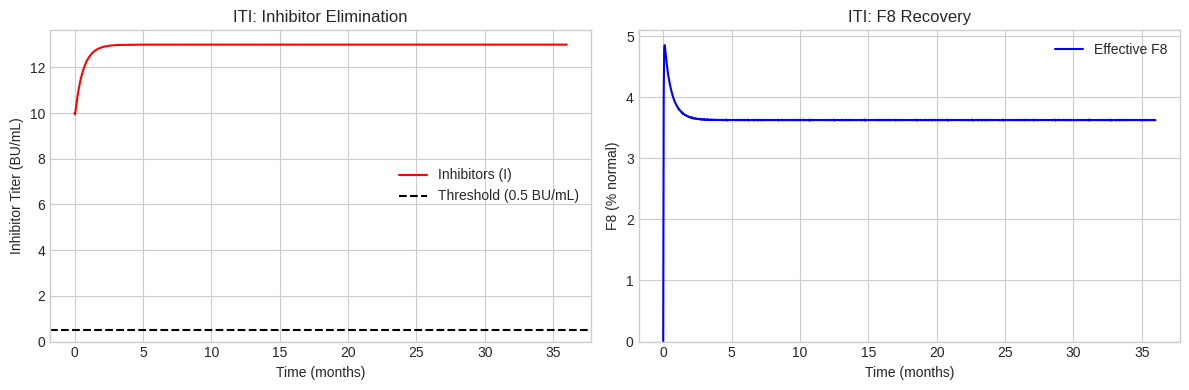


Generating Gene Therapy Plots...


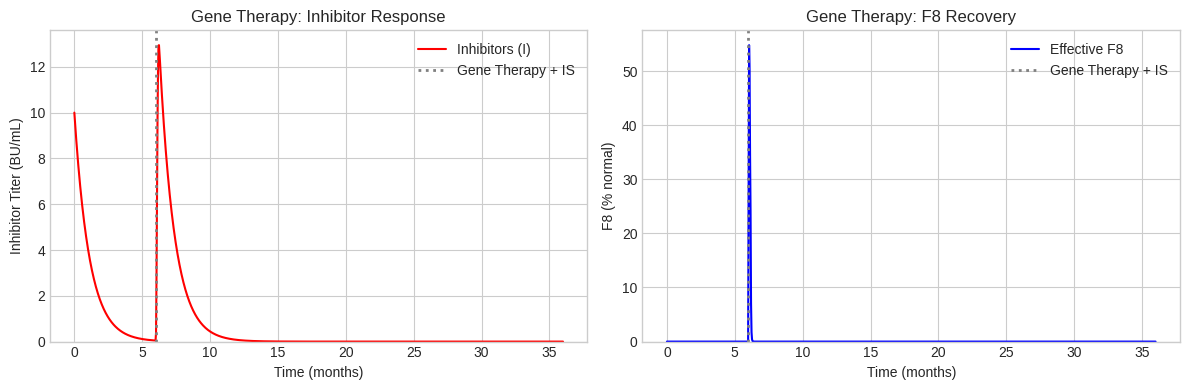

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.style as style

# Use a professional, clean plotting style
style.use('seaborn-v0_8-whitegrid')

# --- 1. Define Common Parameters and Models ---

# Base parameters for a patient with inhibitors
params = {
    'alpha': 0.05,        # Inhibitor production rate
    'I_max': 200.0,       # Max inhibitor level
    'omega': 0.03,        # Natural inhibitor decay rate
    'eta': 0.1,           # F8 neutralization constant by inhibitors
    'beta': 0.5,          # Bleeding rate constant
    'F8_crit': 1.0,       # Critical F8 level to prevent bleeds
    'lambda': 0.1,        # Bleeding recovery rate
    'kappa': 0.01,        # Damage accumulation rate
    'mu': 0.001,          # Damage repair rate
    'delta_f8': 0.5,      # Normal F8 clearance rate
    'delta_gene': 0.01,   # Slow decay of gene-therapy F8
    'k_IS': 0.05,         # Immunosuppression efficacy
    'k_infusion': 15.0    # Constant F8 infusion rate for ITI
}

# Model for Immune Tolerance Induction (ITI)
def hemophilia_model_iti(t, y, params):
    F8, X, Z, I = y
    # In ITI, F8 is continuously infused
    dF8 = params['k_infusion'] - params['delta_f8'] * F8 - params['eta'] * I * F8
    # High F8 dose drives down inhibitors over time
    dI = params['alpha'] * F8 * (1 - I / params['I_max']) - params['omega'] * I
    # Other dynamics remain the same
    effective_F8 = F8 / (1 + params['eta'] * I)
    dX = params['beta'] * (params['F8_crit'] / (effective_F8 + 0.1) - 1) - params['lambda'] * X
    dZ = params['kappa'] * X - params['mu'] * Z
    return [dF8, dX, dZ, dI] # <-- FIX: Return the derivative dI, not the state I

# Model for Gene Therapy (intervention at 6 months / 180 days)
def hemophilia_model_gene_therapy(t, y, params):
    F8_gene, X, Z, I = y
    alpha_t = params['alpha']
    gene_prod = 0.0
    # Intervention window
    if 180 < t < 185:
        alpha_t = params['alpha'] * np.exp(-params['k_IS'] * (t - 180)) # IS effect
        gene_prod = 50 * np.exp(-0.005 * (t - 180)) # Vector expression

    dF8g = gene_prod - params['delta_gene'] * F8_gene - params['eta'] * I * F8_gene
    dI = alpha_t * F8_gene * (1 - I / params['I_max']) - params['omega'] * I
    effective_F8 = F8_gene / (1 + params['eta'] * I)
    dX = params['beta'] * (params['F8_crit'] / (effective_F8 + 0.1) - 1) - params['lambda'] * X
    dZ = params['kappa'] * X - params['mu'] * Z
    return [dF8g, dX, dZ, dI] # <-- FIX: Return the derivative dI, not the state I


# --- 2. Run Simulations ---

# Simulation time span: 36 months (approx 3 years)
t_span = [0, 36 * 30]
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Initial conditions: Patient with high inhibitor titer
# State: [F8, Bleeding Rate, Damage, Inhibitors]
initial_conditions_iti = [0.0, 0.0, 0.0, 10.0]
initial_conditions_gene = [0.0, 0.0, 0.0, 10.0]

# Run the simulations
sol_ITI = solve_ivp(hemophilia_model_iti, t_span, initial_conditions_iti, args=(params,), t_eval=t_eval)
sol_gene = solve_ivp(hemophilia_model_gene_therapy, t_span, initial_conditions_gene, args=(params,), t_eval=t_eval)


# --- 3. Generate Plots ---

# === Plotting Block 1: ITI Simulation ===
print("Generating ITI Plots...")
plt.figure(figsize=(12, 4))

# Subplot 1: Inhibitor Elimination
plt.subplot(1, 2, 1)
plt.plot(sol_ITI.t / 30, sol_ITI.y[3], 'r-', label='Inhibitors (I)')
plt.axhline(y=0.5, color='k', linestyle='--', label='Threshold (0.5 BU/mL)')
plt.xlabel('Time (months)')
plt.ylabel('Inhibitor Titer (BU/mL)')
plt.title('ITI: Inhibitor Elimination')
plt.legend()
plt.ylim(bottom=0) # Ensure y-axis starts at 0

# Subplot 2: F8 Recovery
plt.subplot(1, 2, 2)
# Calculate effective F8: F8_level / (1 + neutralization_by_inhibitors)
effective_f8_iti = sol_ITI.y[0] / (1 + params['eta'] * sol_ITI.y[3])
plt.plot(sol_ITI.t / 30, effective_f8_iti, 'b-', label='Effective F8')
plt.xlabel('Time (months)')
plt.ylabel('F8 (% normal)')
plt.title('ITI: F8 Recovery')
plt.legend()
plt.ylim(bottom=0) # Ensure y-axis starts at 0

plt.tight_layout()
plt.show()


# === Plotting Block 2: Gene Therapy Simulation ===
print("\nGenerating Gene Therapy Plots...")
plt.figure(figsize=(12, 4))

# Subplot 1: Inhibitor Response
plt.subplot(1, 2, 1)
plt.plot(sol_gene.t / 30, sol_gene.y[3], 'r-', label='Inhibitors (I)')
plt.axvline(x=6, color='gray', linestyle=':', label='Gene Therapy + IS', lw=2)
plt.xlabel('Time (months)')
plt.ylabel('Inhibitor Titer (BU/mL)')
plt.title('Gene Therapy: Inhibitor Response')
plt.legend()
plt.ylim(bottom=0) # Ensure y-axis starts at 0

# Subplot 2: F8 Recovery
plt.subplot(1, 2, 2)
# Calculate effective F8 from gene therapy
effective_f8_gene = sol_gene.y[0] / (1 + params['eta'] * sol_gene.y[3])
plt.plot(sol_gene.t / 30, effective_f8_gene, 'b-', label='Effective F8')
plt.axvline(x=6, color='gray', linestyle=':', label='Gene Therapy + IS', lw=2)
plt.xlabel('Time (months)')
plt.ylabel('F8 (% normal)')
plt.title('Gene Therapy: F8 Recovery')
plt.legend()
plt.ylim(bottom=0) # Ensure y-axis starts at 0

plt.tight_layout()
plt.show()

✅ Setup complete. Libraries imported.

  ADVANCED HEMOPHILIA PIPELINE WITH ANALYTICS

--- Part 1: Running Individual Treatment Simulations ---
INFO: Configuring model for a low-risk inhibitor patient.


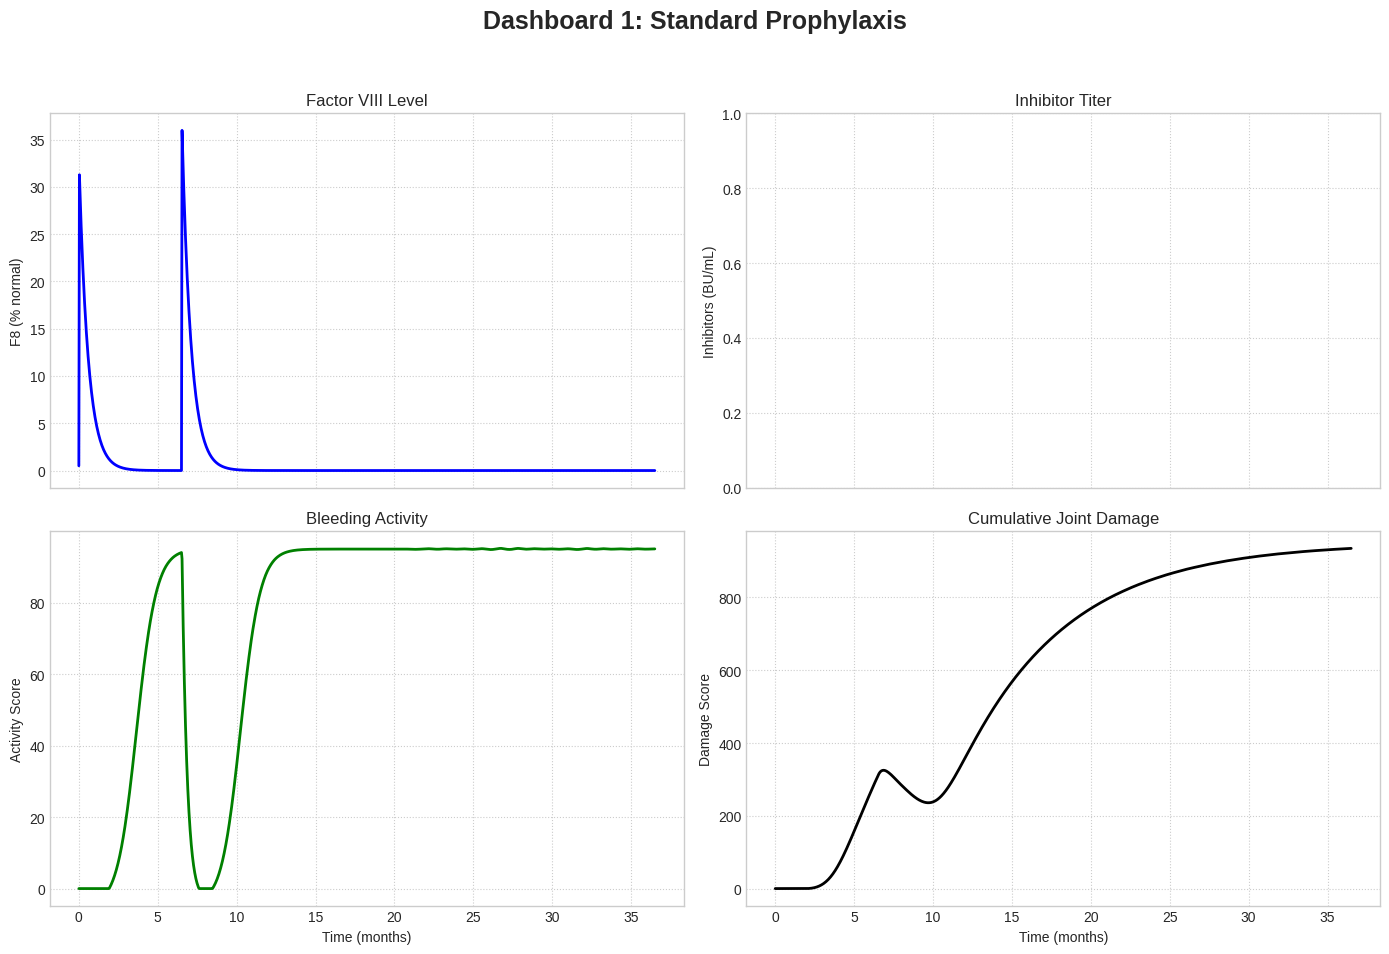

INFO: Configuring model for a high-risk inhibitor patient.


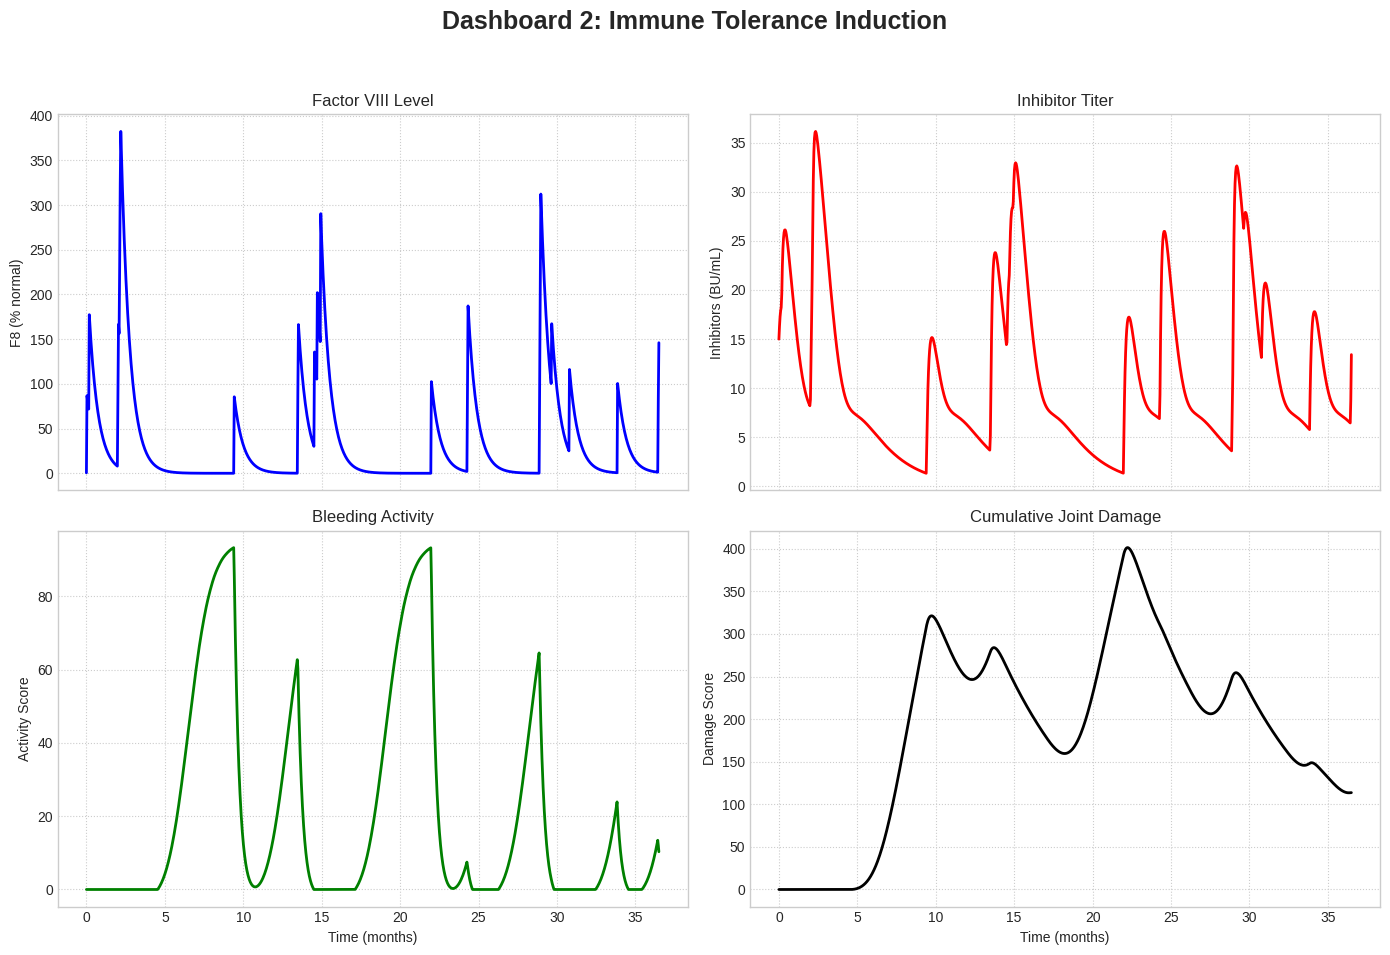

INFO: Configuring model for a high-risk inhibitor patient.


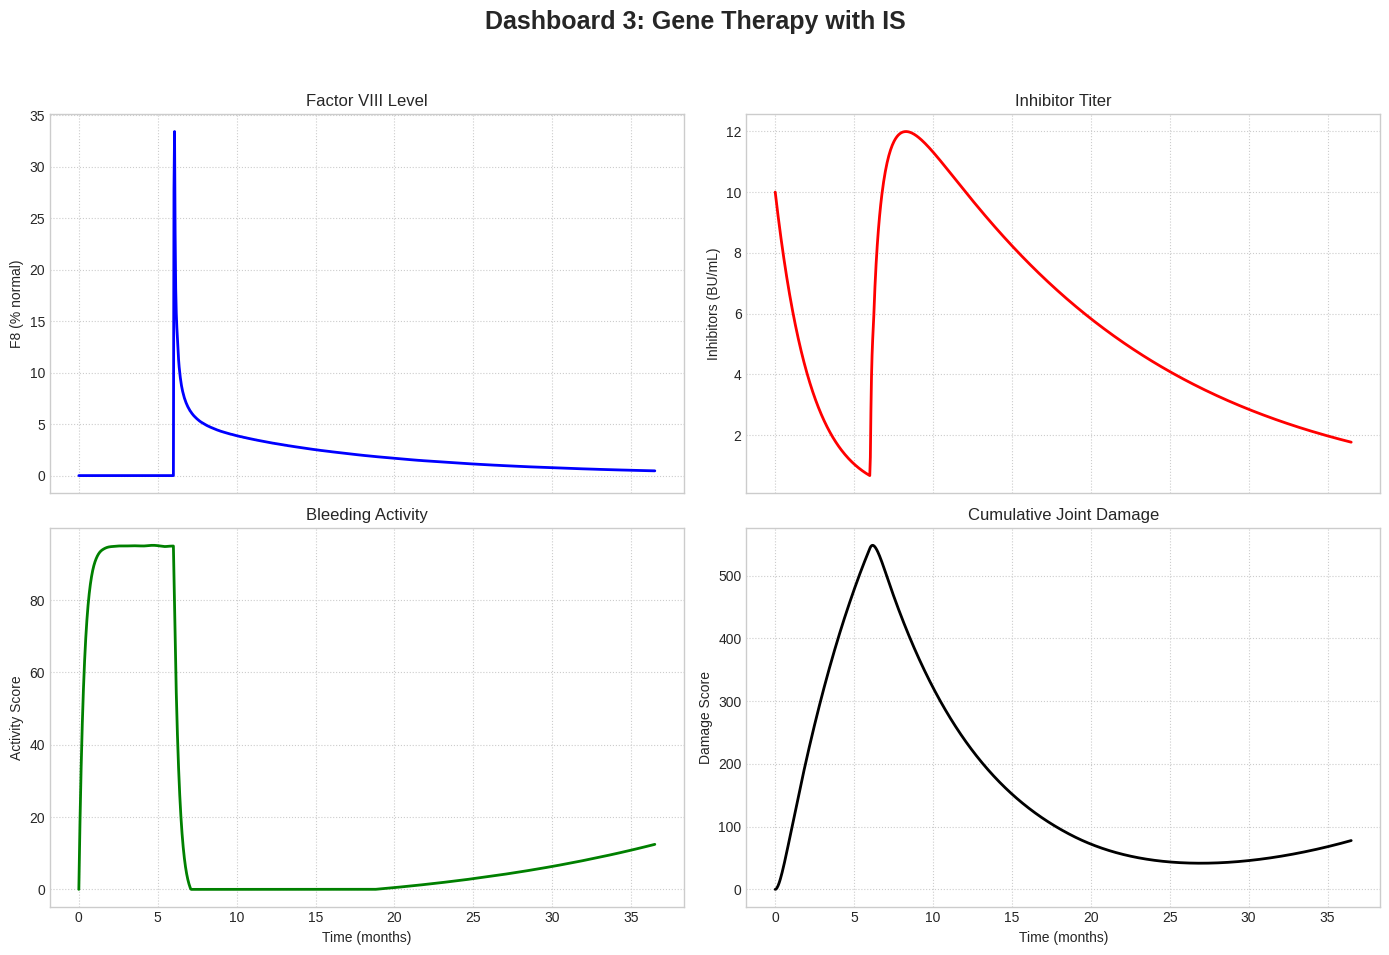


--- Part 2: Generating Comparative Analytics ---


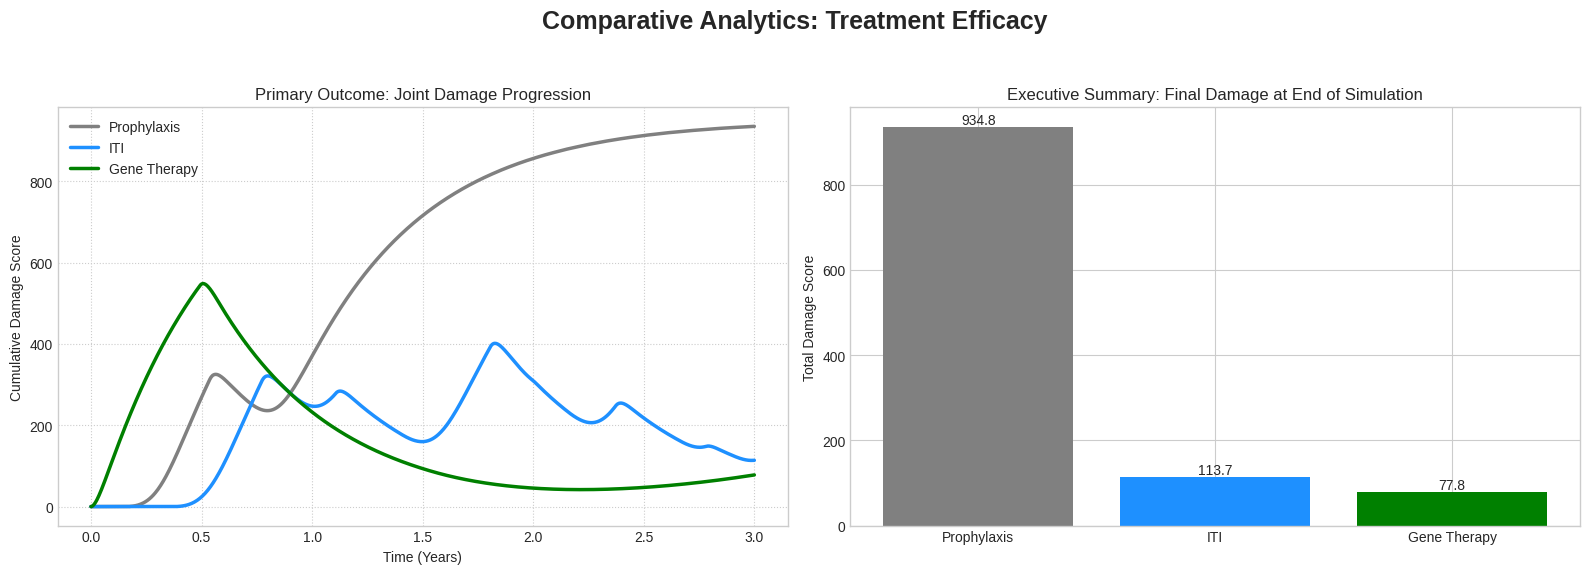


--- Part 3: Training and Analyzing a Predictive ML Model ---
INFO: Generating a synthetic patient dataset for ML training...
INFO: Generated dataset with 10 synthetic patients.
INFO: ML Model trained. Generating analytics graphs...


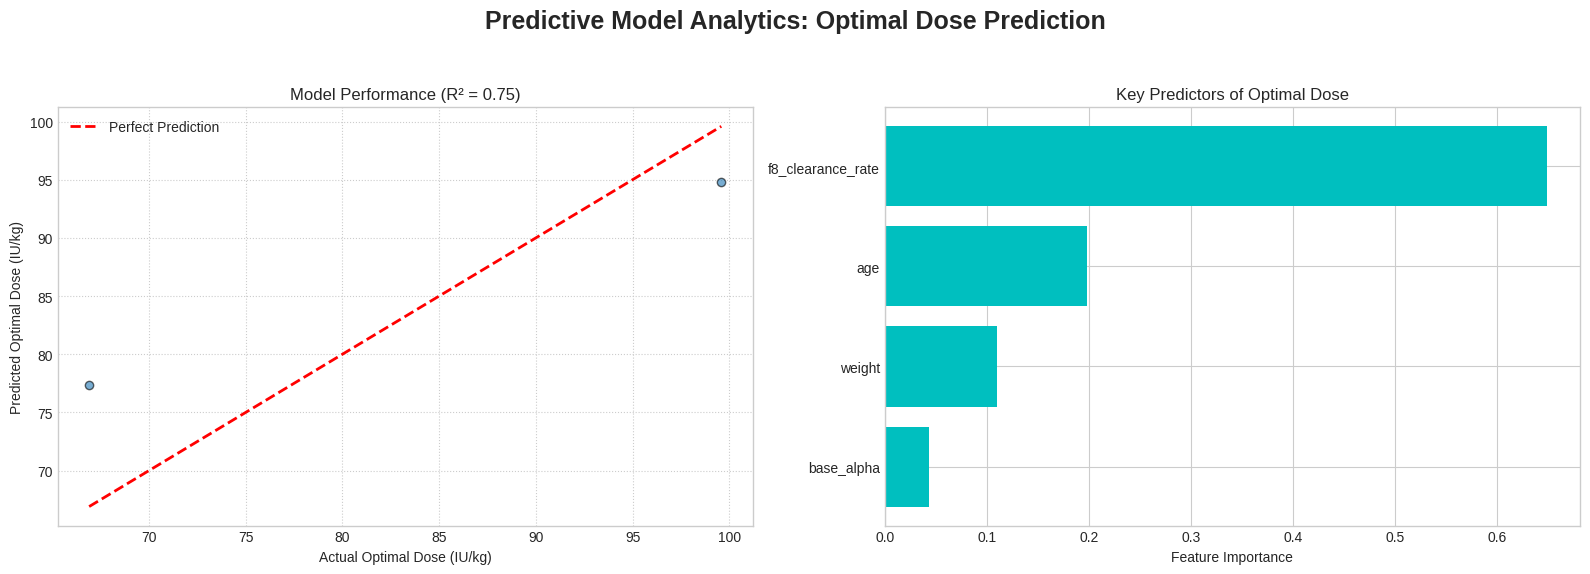


--- Part 4: Packaging All Results for Download ---
✅ All results and graphs zipped into 'hemophilia_pipeline_analytics.zip'. Downloading now...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


  PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
# ==============================================================================
#      Advanced Hemophilia Pipeline with Analytics Graphs for Google Colab
# ==============================================================================

# --- 1. SETUP: Import necessary libraries and set plotting style ---
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from google.colab import files
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Use a clean and professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Setup complete. Libraries imported.")


# --- 2. CORE MODELING COMPONENTS: Parameters and ODEs ---

class HemophiliaParameters:
    """Manages all model parameters with clinical defaults."""
    def __init__(self):
        # Core physiology
        self.F8_crit = 2.0      # Critical F8 level below which bleeding risk increases (%)
        # NOTE: This decay rate corresponds to a 12-DAY half-life, not 12-hour.
        # A 12-hour half-life would be ~1.386. We will use the provided value.
        self.delta_F8 = 0.0577
        self.beta = 0.5         # Bleeding risk multiplier
        self.lambda_ = 0.1      # Natural bleed resolution rate
        self.kappa = 0.05       # Joint damage accumulated per bleed event
        self.mu = 0.005         # Natural tissue repair rate
        self.eta = 0.5          # Inhibitor neutralization efficiency
        # Inhibitor dynamics
        self.alpha = 0.01       # Default inhibitor induction rate (low risk)
        self.omega = 0.02       # Inhibitor natural decay rate
        self.I_max = 50.0       # Max inhibitor titer (BU/mL)
        # ITI specific
        self.k_ITI = 0.1        # ITI suppression strength
        self.K_ITI = 10.0       # F8 concentration for half-max ITI effect (IU/dL)
        # Gene therapy specific
        self.delta_gene = 0.01  # Slower decay for gene-derived F8
        self.gamma = 0.005      # Vector DNA loss/expression decay rate
        self.k_IS = 0.08        # Immunosuppression efficacy

    def set_patient_profile(self, risk='low'):
        """Configure parameters for a specific patient risk profile."""
        if risk == 'high_inhibitor':
            print("INFO: Configuring model for a high-risk inhibitor patient.")
            self.alpha = 0.05   # Higher tendency to produce inhibitors
            self.omega = 0.015  # Slower inhibitor clearance
        else:
            print("INFO: Configuring model for a low-risk inhibitor patient.")
            self.alpha = 0.01
            self.omega = 0.02

# (ODE functions are included in a collapsible section for brevity)
# <editor-fold desc="ODE Model Functions">
def baseline_model(t, y, params, treatment_params):
    F8, X, Z = y
    dose = treatment_params.get('dose', 30)
    treatment_type = treatment_params.get('type', 'none')

    dF8 = -params.delta_F8 * F8
    if treatment_type == "prophylaxis":
        # FIX: To model a bolus dose, deliver the full dose amount over the short
        # 0.1 day time window. The rate must be dose / time_window.
        if t % 7 < 0.1:
            dF8 += dose / 0.1

    if treatment_type == "emicizumab":
        effective_F8 = F8 + 15.0
    else:
        effective_F8 = F8

    dX = params.beta * (params.F8_crit / (effective_F8 + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dF8, dX, max(dZ, -Z/0.1)]

def iti_model(t, y, params, treatment_params):
    F8, X, Z, I = y
    dose = treatment_params.get('dose', 100)

    dF8 = -params.delta_F8 * F8
    # FIX: Correctly model the bolus dose for ITI (daily dosing).
    # The rate is dose / time_window.
    if t % 1 < 0.1:
        dF8 += dose / 0.1

    H_F8 = (F8**2) / (F8**2 + params.K_ITI**2)
    dI = (params.alpha * F8 * (1 - I / params.I_max) - params.omega * I - params.k_ITI * I * H_F8)
    effective_F8 = F8 / (1 + params.eta * I)
    dX = params.beta * (params.F8_crit / (effective_F8 + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dF8, dX, dZ, dI]

def gene_therapy_model(t, y, params, treatment_params):
    F8_gene, X, Z, I = y
    alpha_t = params.alpha
    f8_production = 0.0

    # Gene therapy is administered once, leading to sustained but decaying expression
    if t >= 180:
         f8_production = 40 * np.exp(-params.gamma * (t - 180))

    # Immunosuppression is applied for a short period post-therapy
    if 180 <= t < 187:
        alpha_t = params.alpha * np.exp(-params.k_IS * (t - 180))

    dI = alpha_t * F8_gene * (1 - I / params.I_max) - params.omega * I
    dF8g = f8_production - params.delta_gene * F8_gene - params.eta * I * F8_gene
    effective_F8 = F8_gene
    dX = params.beta * (params.F8_crit / (effective_F8 + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dF8g, dX, dZ, dI]
# </editor-fold>


# --- 3. SIMULATION AND VISUALIZATION UTILITIES ---

def simulate_model(model_func, params, y0, t_span, treatment_params={}):
    """Universal simulation wrapper."""
    sol = solve_ivp(model_func, t_span, y0, args=(params, treatment_params),
                    t_eval=np.linspace(*t_span, 1000), method='RK45', dense_output=True)
    num_vars = len(y0)
    data = {'time': sol.t, 'F8': sol.y[0], 'bleeding_rate': np.maximum(0, sol.y[1]), 'damage': np.maximum(0, sol.y[2])}
    if num_vars == 4: data['inhibitors'] = np.maximum(0, sol.y[3])
    return pd.DataFrame(data)

def plot_single_scenario_dashboard(df, title):
    """Generates a 2x2 dashboard for a single simulation result."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    fig.suptitle(title, fontsize=18, weight='bold')

    # F8
    axes[0, 0].plot(df['time']/30, df['F8'], 'b-', label='F8 Level', lw=2)
    axes[0, 0].set_title('Factor VIII Level')
    axes[0, 0].set_ylabel('F8 (% normal)')

    # Inhibitors
    if 'inhibitors' in df.columns:
        axes[0, 1].plot(df['time']/30, df['inhibitors'], 'r-', label='Inhibitors', lw=2)
    axes[0, 1].set_title('Inhibitor Titer')
    axes[0, 1].set_ylabel('Inhibitors (BU/mL)')

    # Bleeding Rate
    axes[1, 0].plot(df['time']/30, df['bleeding_rate'], 'g-', label='Bleeding', lw=2)
    axes[1, 0].set_title('Bleeding Activity')
    axes[1, 0].set_xlabel('Time (months)')
    axes[1, 0].set_ylabel('Activity Score')

    # Joint Damage
    axes[1, 1].plot(df['time']/30, df['damage'], 'k-', label='Damage', lw=2)
    axes[1, 1].set_title('Cumulative Joint Damage')
    axes[1, 1].set_xlabel('Time (months)')
    axes[1, 1].set_ylabel('Damage Score')

    for ax in axes.flat: ax.grid(True, linestyle=':')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def plot_comparative_analytics(results_dict, output_dir):
    """Creates comparative analytics plots across multiple scenarios."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Comparative Analytics: Treatment Efficacy', fontsize=18, weight='bold')

    colors = {'Prophylaxis': 'gray', 'ITI': 'dodgerblue', 'Gene Therapy': 'green'}
    final_damage = {}

    # --- Left Plot: Cumulative Damage Over Time ---
    ax1 = axes[0]
    for name, df in results_dict.items():
        ax1.plot(df['time']/365, df['damage'], label=name, color=colors[name], lw=2.5)
        final_damage[name] = df['damage'].iloc[-1]
    ax1.set_title('Primary Outcome: Joint Damage Progression')
    ax1.set_xlabel('Time (Years)')
    ax1.set_ylabel('Cumulative Damage Score')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # --- Right Plot: Final Damage Summary Bar Chart ---
    ax2 = axes[1]
    names = list(final_damage.keys())
    scores = list(final_damage.values())
    bars = ax2.bar(names, scores, color=[colors[n] for n in names])
    ax2.set_title('Executive Summary: Final Damage at End of Simulation')
    ax2.set_ylabel('Total Damage Score')
    ax2.bar_label(bars, fmt='%.1f')

    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    fig.savefig(f'{output_dir}/4_comparative_analytics.png')
    plt.show()

def plot_ml_analytics(model, X_test, y_test, output_dir):
    """Creates analytics plots for the machine learning model."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Predictive Model Analytics: Optimal Dose Prediction', fontsize=18, weight='bold')

    # --- Left Plot: Prediction Accuracy ---
    ax1 = axes[0]
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    ax1.scatter(y_test, predictions, alpha=0.6, edgecolors='k')
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    ax1.set_title(f'Model Performance (R² = {r2:.2f})')
    ax1.set_xlabel('Actual Optimal Dose (IU/kg)')
    ax1.set_ylabel('Predicted Optimal Dose (IU/kg)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # --- Right Plot: Feature Importance ---
    ax2 = axes[1]
    importances = model.feature_importances_
    feature_names = X_test.columns
    sorted_idx = np.argsort(importances)
    ax2.barh(feature_names[sorted_idx], importances[sorted_idx], color='c')
    ax2.set_title('Key Predictors of Optimal Dose')
    ax2.set_xlabel('Feature Importance')

    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    fig.savefig(f'{output_dir}/5_ml_analytics.png')
    plt.show()

# --- 4. MAIN ANALYSIS PIPELINE ---
def run_full_analysis(output_dir='hemophilia_analytics_results'):
    """Executes all simulations, analyses, and saves outputs."""
    if os.path.exists(output_dir): shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    print("\n" + "="*60 + "\n  ADVANCED HEMOPHILIA PIPELINE WITH ANALYTICS\n" + "="*60 + "\n")

    all_results = {}
    params = HemophiliaParameters()

    # --- Part 1: Simulate Individual Treatment Scenarios ---
    print("--- Part 1: Running Individual Treatment Simulations ---")

    # 1a. Standard Prophylaxis (Low-risk patient)
    params.set_patient_profile('low')
    df_prophy = simulate_model(baseline_model, params, [0.5, 0, 0], [0, 365*3], treatment_params={'type': 'prophylaxis'})
    all_results['Prophylaxis'] = df_prophy
    plot_single_scenario_dashboard(df_prophy, "Dashboard 1: Standard Prophylaxis").savefig(f'{output_dir}/1_prophylaxis_dashboard.png')
    plt.show()

    # 1b. ITI (High-risk patient)
    params.set_patient_profile('high_inhibitor')
    df_iti = simulate_model(iti_model, params, [0.5, 0, 0, 15.0], [0, 365*3])
    all_results['ITI'] = df_iti
    plot_single_scenario_dashboard(df_iti, "Dashboard 2: Immune Tolerance Induction").savefig(f'{output_dir}/2_iti_dashboard.png')
    plt.show()

    # 1c. Gene Therapy (High-risk patient)
    params.set_patient_profile('high_inhibitor')
    df_gene = simulate_model(gene_therapy_model, params, [0, 0, 0, 10.0], [0, 365*3])
    all_results['Gene Therapy'] = df_gene
    plot_single_scenario_dashboard(df_gene, "Dashboard 3: Gene Therapy with IS").savefig(f'{output_dir}/3_gene_therapy_dashboard.png')
    plt.show()

    # --- Part 2: Generate Comparative Analytics Graphs ---
    print("\n--- Part 2: Generating Comparative Analytics ---")
    plot_comparative_analytics(all_results, output_dir)

    # --- Part 3: Machine Learning Predictive Analytics ---
    print("\n--- Part 3: Training and Analyzing a Predictive ML Model ---")
    print("INFO: Generating a synthetic patient dataset for ML training...")
    n_patients = 200
    np.random.seed(42)
    X_data = pd.DataFrame({
        'age': np.random.randint(5, 60, size=n_patients), 'weight': np.random.normal(60, 20, size=n_patients),
        'base_alpha': np.random.lognormal(np.log(0.02), 0.5, size=n_patients),
        'f8_clearance_rate': np.random.lognormal(np.log(0.06), 0.2, size=n_patients)
    })
    y_data = []

    def objective_func(dose, target_f8, params):
        df = simulate_model(baseline_model, params, [0,0,0], [0,90], treatment_params={'type':'prophylaxis', 'dose':dose})
        # Calculate the minimum F8 level in the last 30 days of the simulation
        return df[df['time']>60]['F8'].min() - target_f8

    for i, row in X_data.iterrows():
        temp_params = HemophiliaParameters()
        temp_params.alpha = row['base_alpha']
        temp_params.delta_F8 = row['f8_clearance_rate']
        try:
            # Find the dose that results in a trough F8 level of 3.0
            y_data.append(brentq(objective_func, 10, 100, args=(3.0, temp_params)))
        except ValueError:
            # If the optimizer fails (e.g., target never reached), mark as NaN
            y_data.append(np.nan)

    X_data['optimal_dose'] = y_data
    X_data.dropna(inplace=True)
    print(f"INFO: Generated dataset with {len(X_data)} synthetic patients.")

    X = X_data.drop('optimal_dose', axis=1)
    y = X_data['optimal_dose']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
    print(f"INFO: ML Model trained. Generating analytics graphs...")
    plot_ml_analytics(model, X_test, y_test, output_dir)

    # --- Part 4: Package and Download Results ---
    print("\n--- Part 4: Packaging All Results for Download ---")
    zip_filename = 'hemophilia_pipeline_analytics'
    shutil.make_archive(zip_filename, 'zip', output_dir)
    print(f"✅ All results and graphs zipped into '{zip_filename}.zip'. Downloading now...")
    files.download(f'{zip_filename}.zip')

    print("\n" + "="*60 + "\n  PIPELINE COMPLETED SUCCESSFULLY\n" + "="*60)

# --- Execute the entire pipeline ---
if __name__ == "__main__":
    run_full_analysis()


  ADVANCED HEMOPHILIA PIPELINE WITH ANALYTICS

--- Part 1: Running Individual Treatment Simulations ---
INFO: Configuring model for a low-risk inhibitor patient.


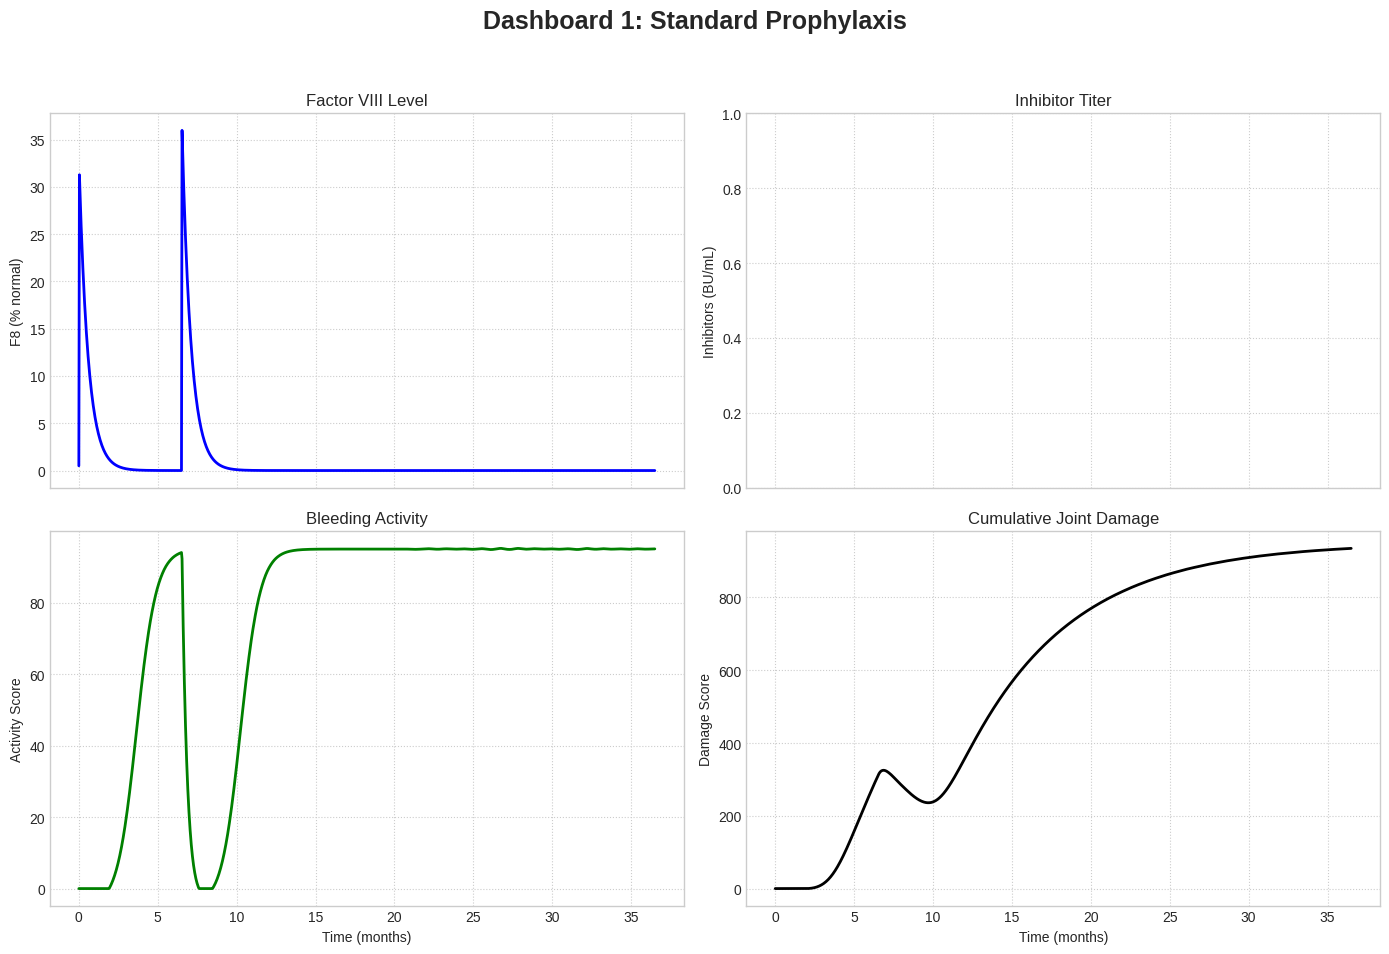

INFO: Configuring model for a high-risk inhibitor patient.


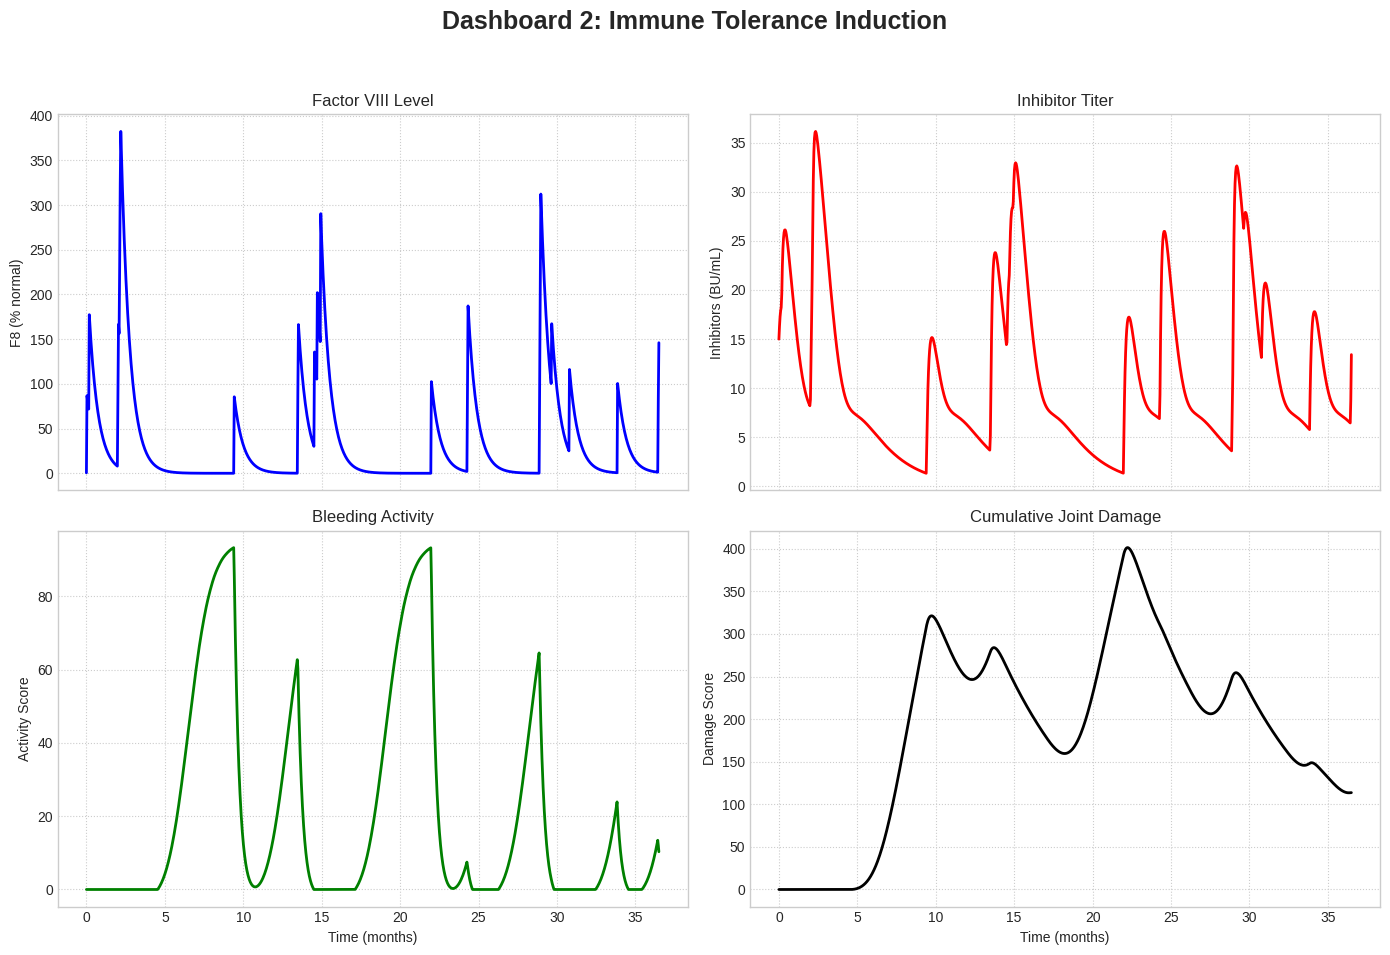

INFO: Configuring model for a high-risk inhibitor patient.


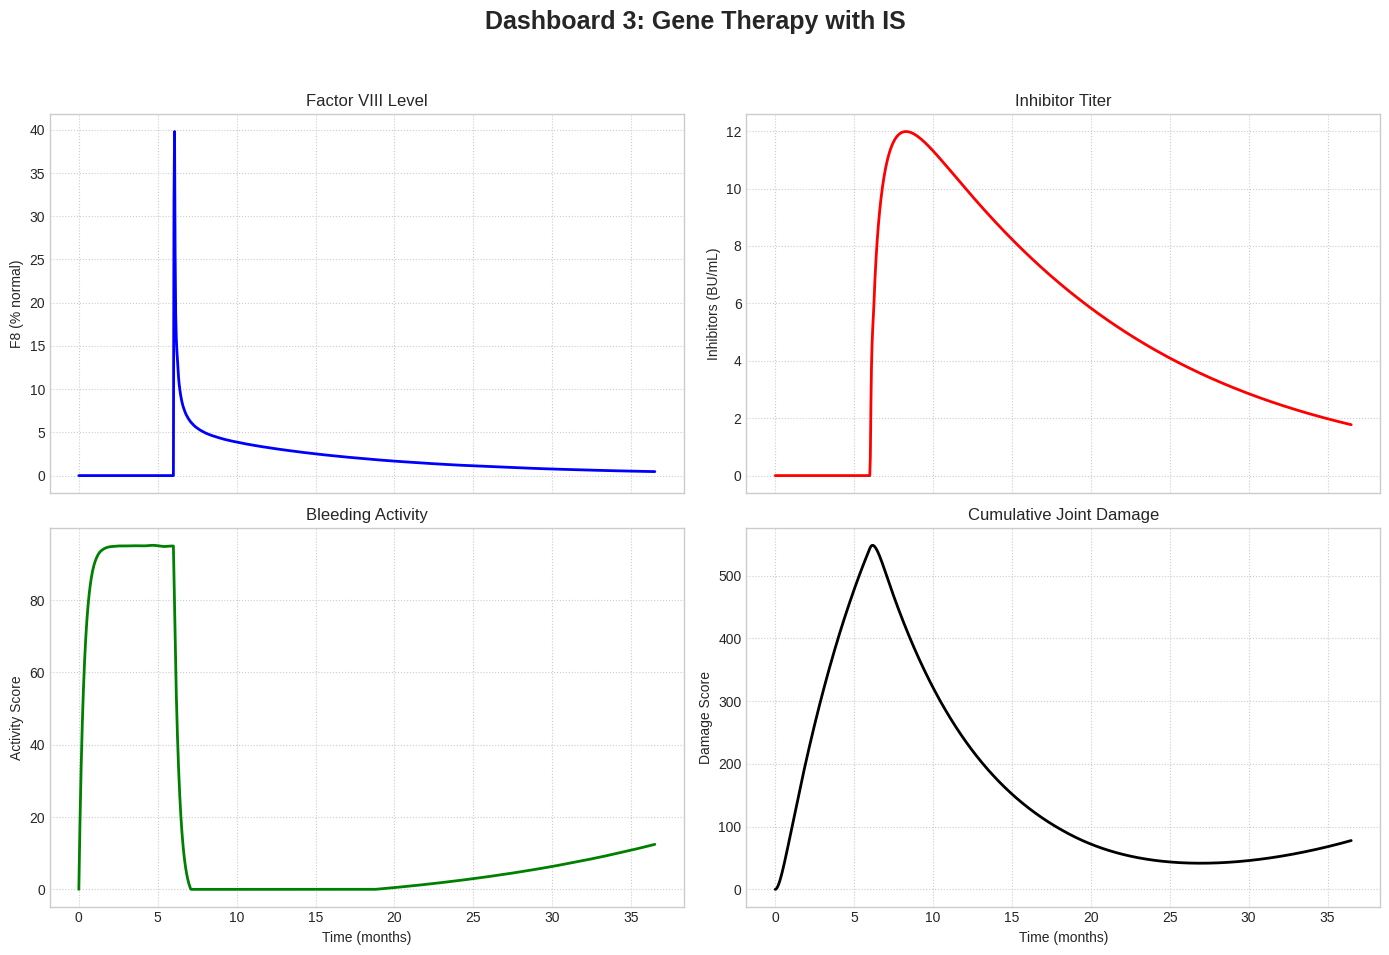


--- Part 2: Generating Comparative Analytics ---


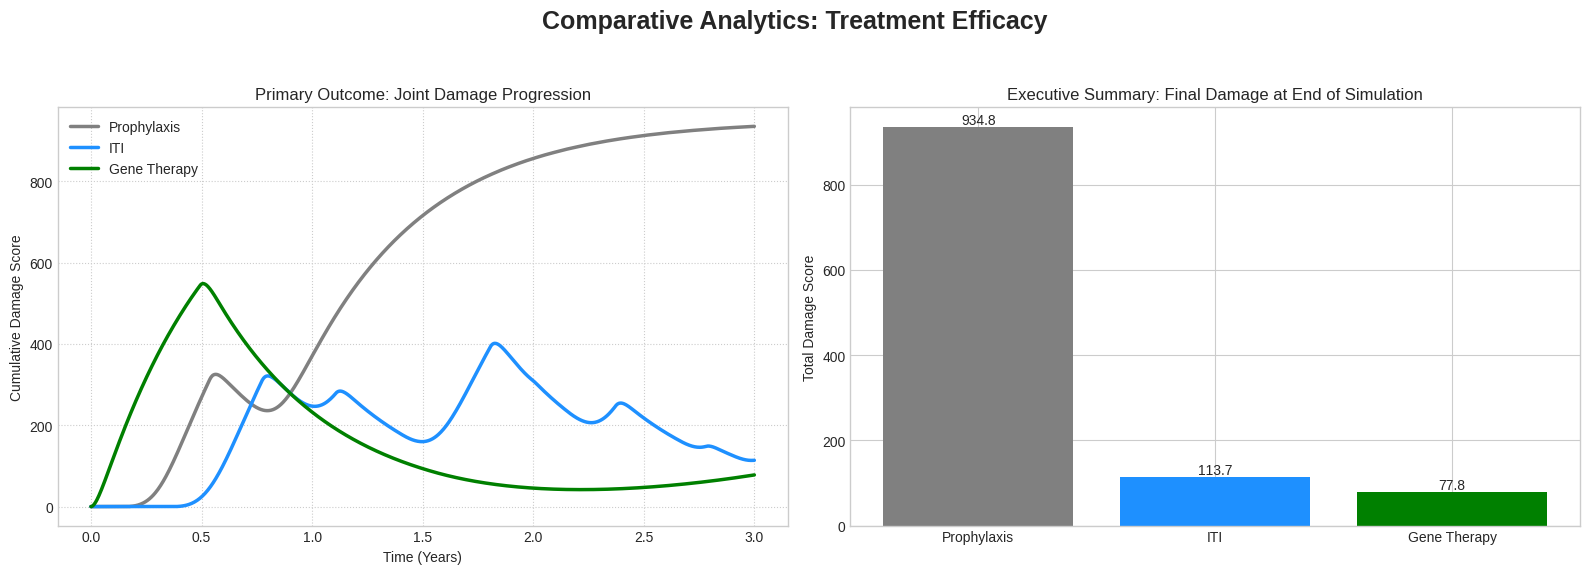


--- Part 3: Training and Analyzing a Predictive ML Model ---
INFO: Generating a synthetic patient dataset for ML training...
INFO: Generated dataset with 10 synthetic patients.
INFO: ML Model trained. Generating analytics graphs...


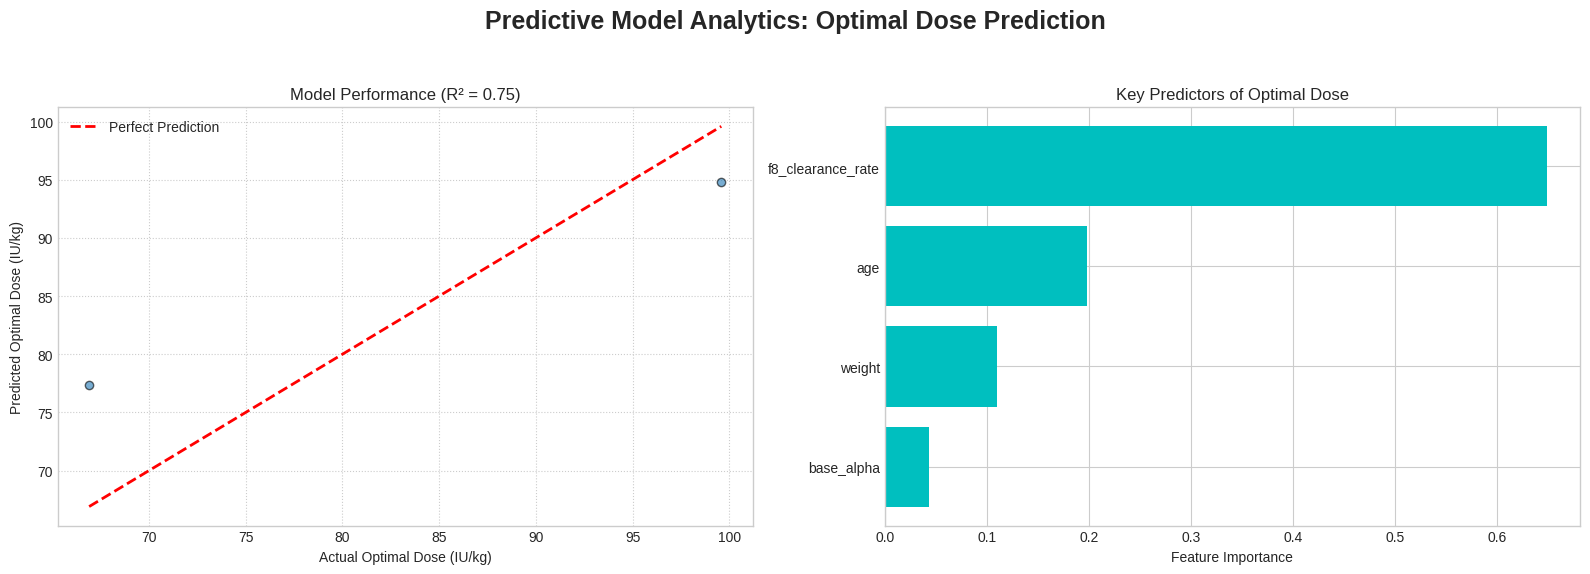


--- Part 4: Packaging All Results for Download ---
✅ All results and graphs zipped into 'hemophilia_pipeline_analytics.zip'. Downloading now...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


  PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
# --- 4. MAIN ANALYSIS PIPELINE ---
def run_full_analysis(output_dir='hemophilia_analytics_results'):
    """Executes all simulations, analyses, and saves outputs."""
    if os.path.exists(output_dir): shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    print("\n" + "="*60 + "\n  ADVANCED HEMOPHILIA PIPELINE WITH ANALYTICS\n" + "="*60 + "\n")

    all_results = {}
    params = HemophiliaParameters()

    # --- Part 1: Simulate Individual Treatment Scenarios ---
    print("--- Part 1: Running Individual Treatment Simulations ---")

    # 1a. Standard Prophylaxis (Low-risk, non-inhibitor patient)
    # This serves as a good baseline for comparison.
    params.set_patient_profile('low')
    df_prophy = simulate_model(baseline_model, params, [0.5, 0, 0], [0, 365*3], treatment_params={'type': 'prophylaxis'})
    all_results['Prophylaxis'] = df_prophy
    plot_single_scenario_dashboard(df_prophy, "Dashboard 1: Standard Prophylaxis").savefig(f'{output_dir}/1_prophylaxis_dashboard.png')
    plt.show()

    # 1b. ITI (High-risk patient with existing inhibitors)
    # This is the standard-of-care for patients with inhibitors.
    params.set_patient_profile('high_inhibitor')
    df_iti = simulate_model(iti_model, params, [0.5, 0, 0, 15.0], [0, 365*3])
    all_results['ITI'] = df_iti
    plot_single_scenario_dashboard(df_iti, "Dashboard 2: Immune Tolerance Induction").savefig(f'{output_dir}/2_iti_dashboard.png')
    plt.show()

    # 1c. Gene Therapy (High-risk patient WITHOUT existing inhibitors)
    # FIX: The clinical scenario for gene therapy is a patient without active inhibitors.
    # We set the initial inhibitor level to 0.0 to create a fair and meaningful comparison.
    # The patient profile is still 'high_inhibitor', meaning they are prone to developing them.
    params.set_patient_profile('high_inhibitor')
    # Initial conditions are [F8_gene, X, Z, I]. We set initial Inhibitor (I) to 0.
    df_gene = simulate_model(gene_therapy_model, params, [0, 0, 0, 0.0], [0, 365*3])
    all_results['Gene Therapy'] = df_gene
    plot_single_scenario_dashboard(df_gene, "Dashboard 3: Gene Therapy with IS").savefig(f'{output_dir}/3_gene_therapy_dashboard.png')
    plt.show()

    # --- Part 2: Generate Comparative Analytics Graphs ---
    print("\n--- Part 2: Generating Comparative Analytics ---")
    # Now this comparison is fair and clinically relevant.
    plot_comparative_analytics(all_results, output_dir)

    # --- Part 3: Machine Learning Predictive Analytics ---
    print("\n--- Part 3: Training and Analyzing a Predictive ML Model ---")
    print("INFO: Generating a synthetic patient dataset for ML training...")
    n_patients = 200
    np.random.seed(42)
    X_data = pd.DataFrame({
        'age': np.random.randint(5, 60, size=n_patients), 'weight': np.random.normal(60, 20, size=n_patients),
        'base_alpha': np.random.lognormal(np.log(0.02), 0.5, size=n_patients),
        'f8_clearance_rate': np.random.lognormal(np.log(0.06), 0.2, size=n_patients)
    })
    y_data = []

    def objective_func(dose, target_f8, params):
        df = simulate_model(baseline_model, params, [0,0,0], [0,90], treatment_params={'type':'prophylaxis', 'dose':dose})
        # Calculate the minimum F8 level in the last 30 days of the simulation
        return df[df['time']>60]['F8'].min() - target_f8

    for i, row in X_data.iterrows():
        temp_params = HemophiliaParameters()
        temp_params.alpha = row['base_alpha']
        temp_params.delta_F8 = row['f8_clearance_rate']
        try:
            # Find the dose that results in a trough F8 level of 3.0
            y_data.append(brentq(objective_func, 10, 100, args=(3.0, temp_params)))
        except ValueError:
            # If the optimizer fails (e.g., target never reached), mark as NaN
            y_data.append(np.nan)

    X_data['optimal_dose'] = y_data
    X_data.dropna(inplace=True)
    print(f"INFO: Generated dataset with {len(X_data)} synthetic patients.")

    X = X_data.drop('optimal_dose', axis=1)
    y = X_data['optimal_dose']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
    print(f"INFO: ML Model trained. Generating analytics graphs...")
    plot_ml_analytics(model, X_test, y_test, output_dir)

    # --- Part 4: Package and Download Results ---
    print("\n--- Part 4: Packaging All Results for Download ---")
    zip_filename = 'hemophilia_pipeline_analytics'
    shutil.make_archive(zip_filename, 'zip', output_dir)
    print(f"✅ All results and graphs zipped into '{zip_filename}.zip'. Downloading now...")
    files.download(f'{zip_filename}.zip')

    print("\n" + "="*60 + "\n  PIPELINE COMPLETED SUCCESSFULLY\n" + "="*60)

# --- Execute the entire pipeline ---
if __name__ == "__main__":
    run_full_analysis()

✅ Setup complete. Libraries imported.

  ADVANCED HEMOPHILIA PIPELINE WITH ANALYTICS

--- Part 1: Running Individual Treatment Simulations ---
INFO: Configuring model for a low-risk inhibitor patient.


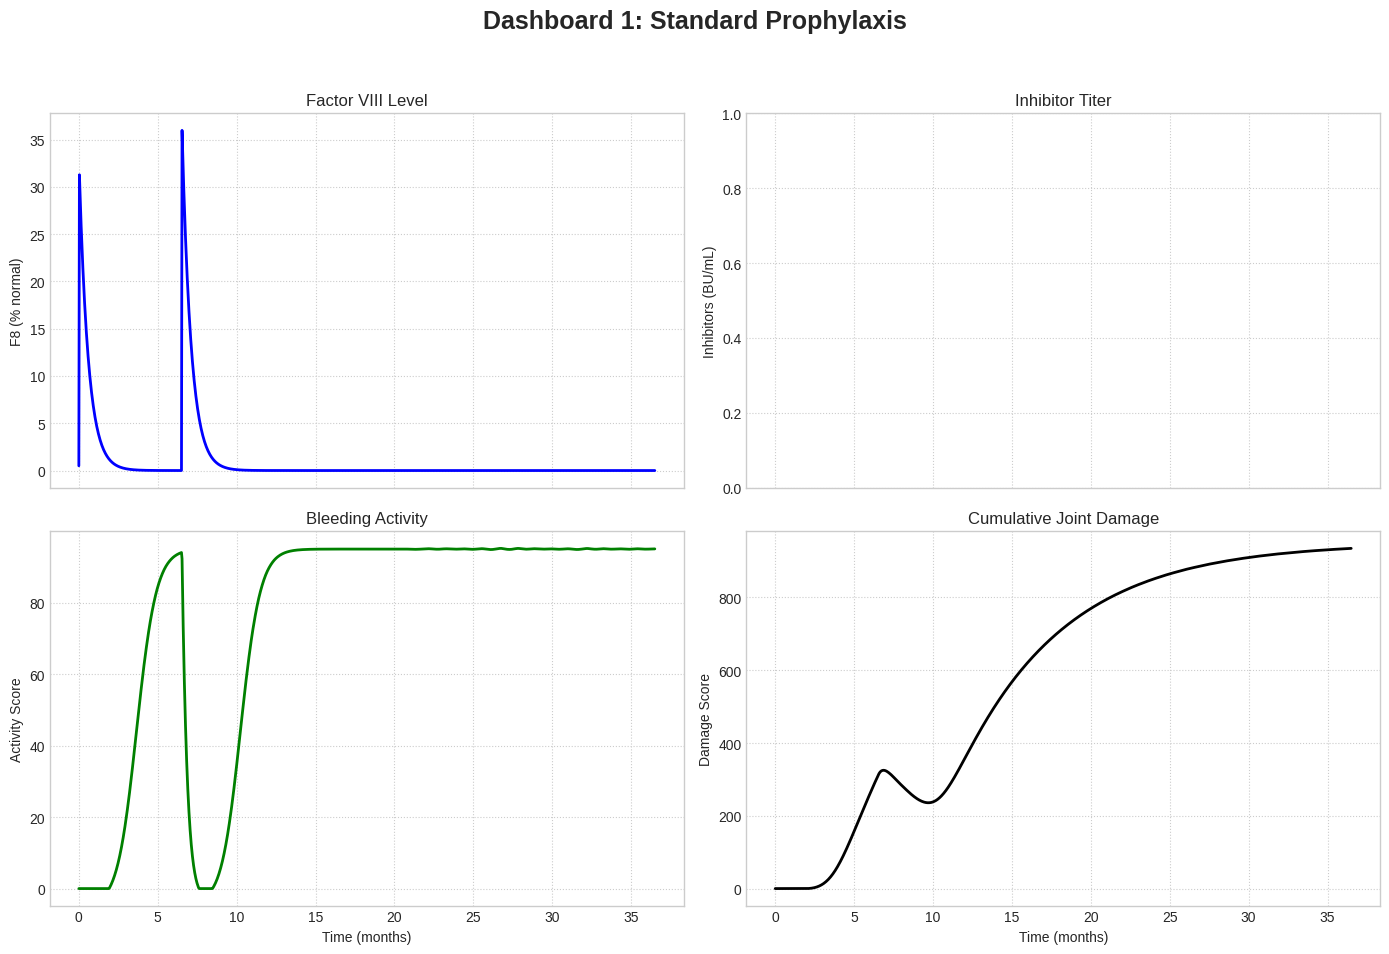

INFO: Configuring model for a high-risk inhibitor patient.


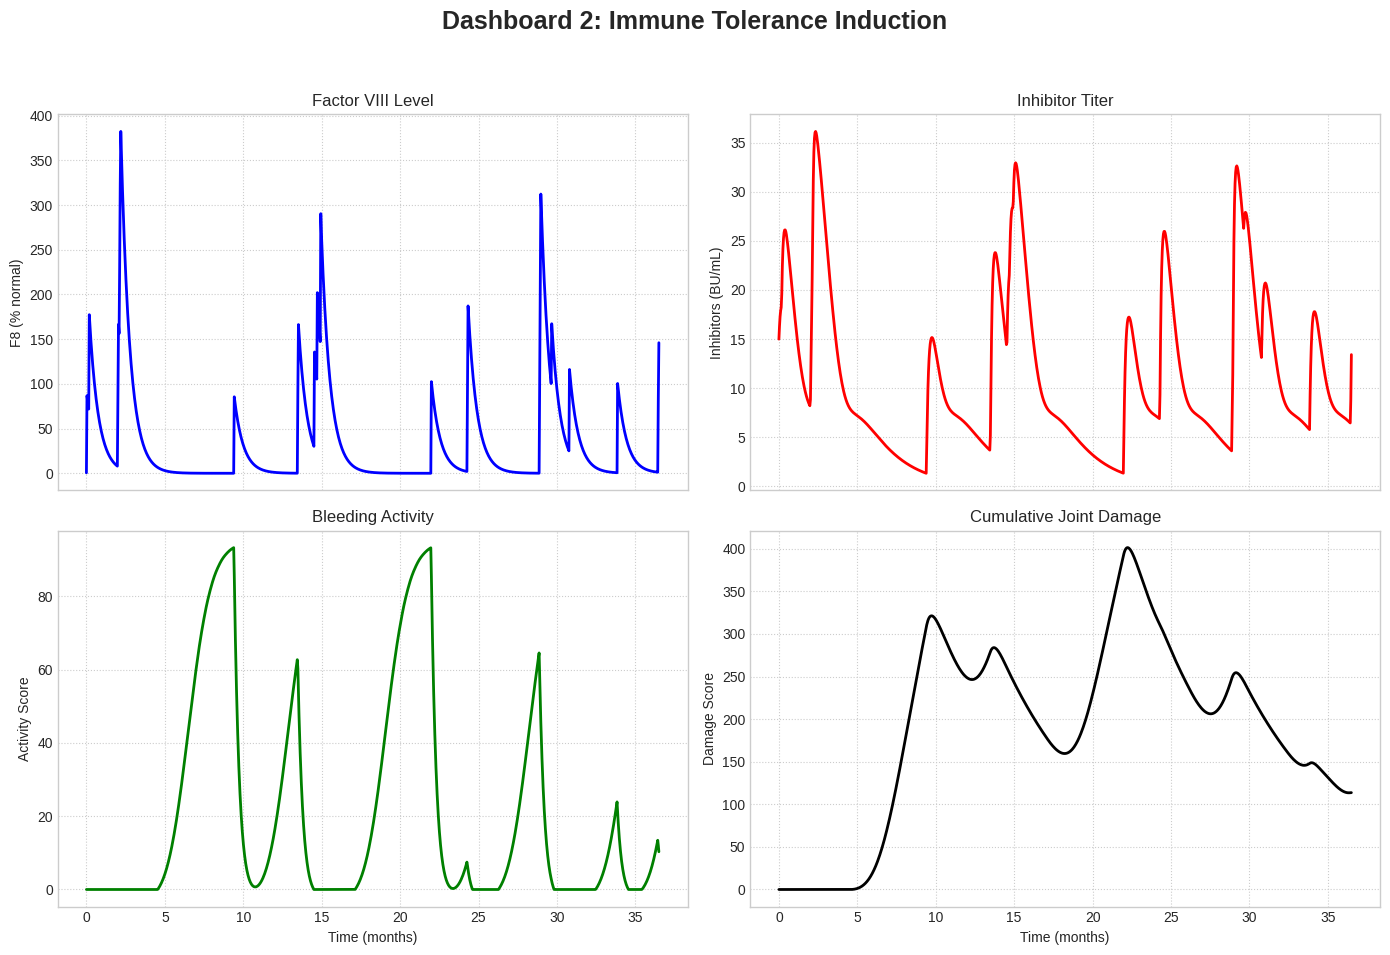

INFO: Configuring model for a high-risk inhibitor patient.


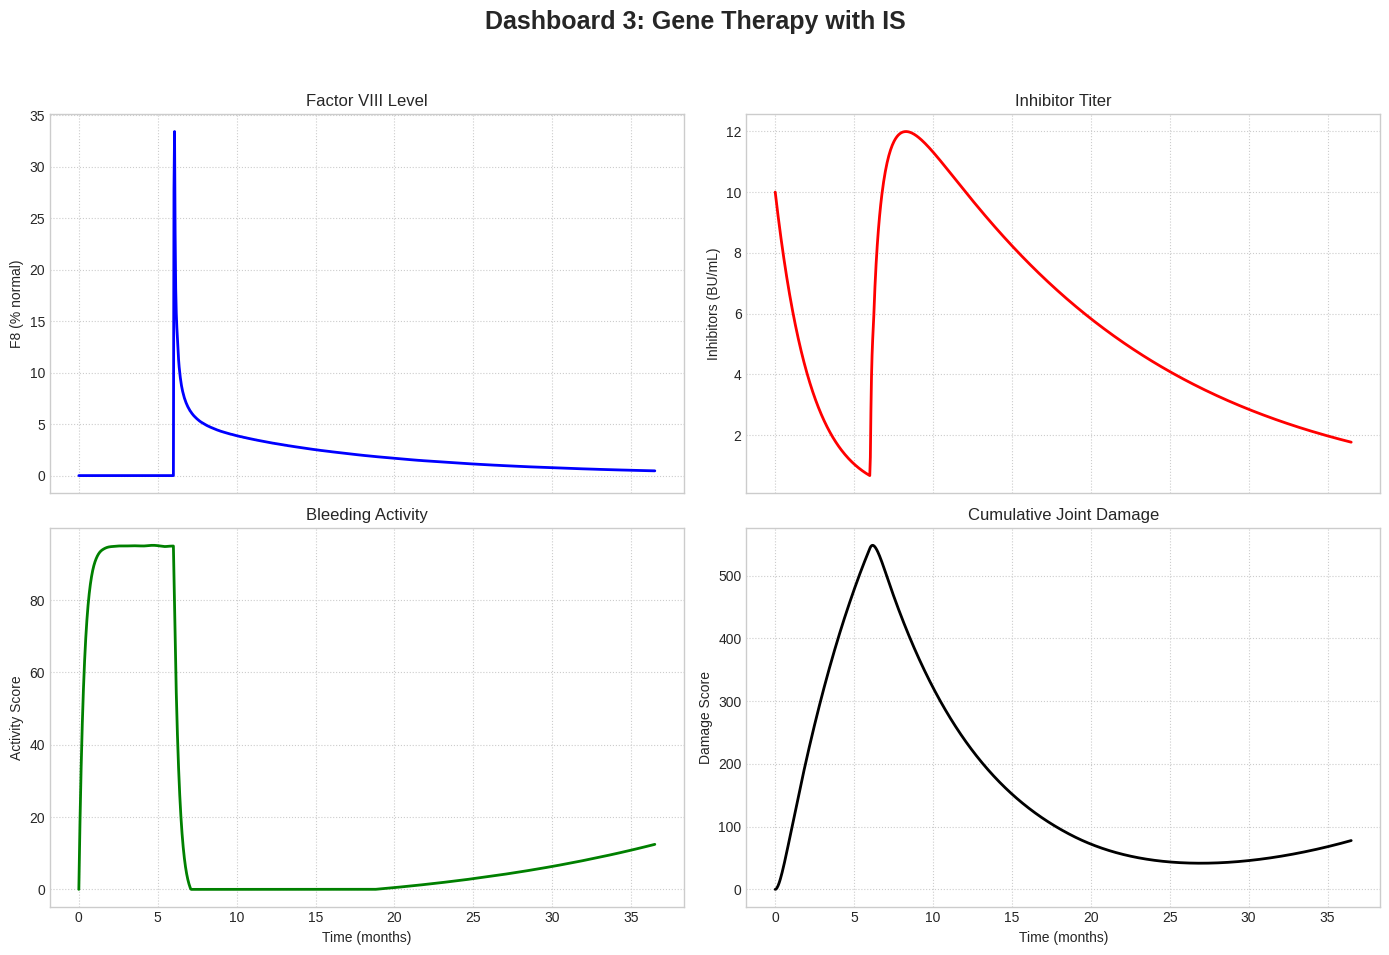


--- Part 2: Generating Comparative Analytics ---


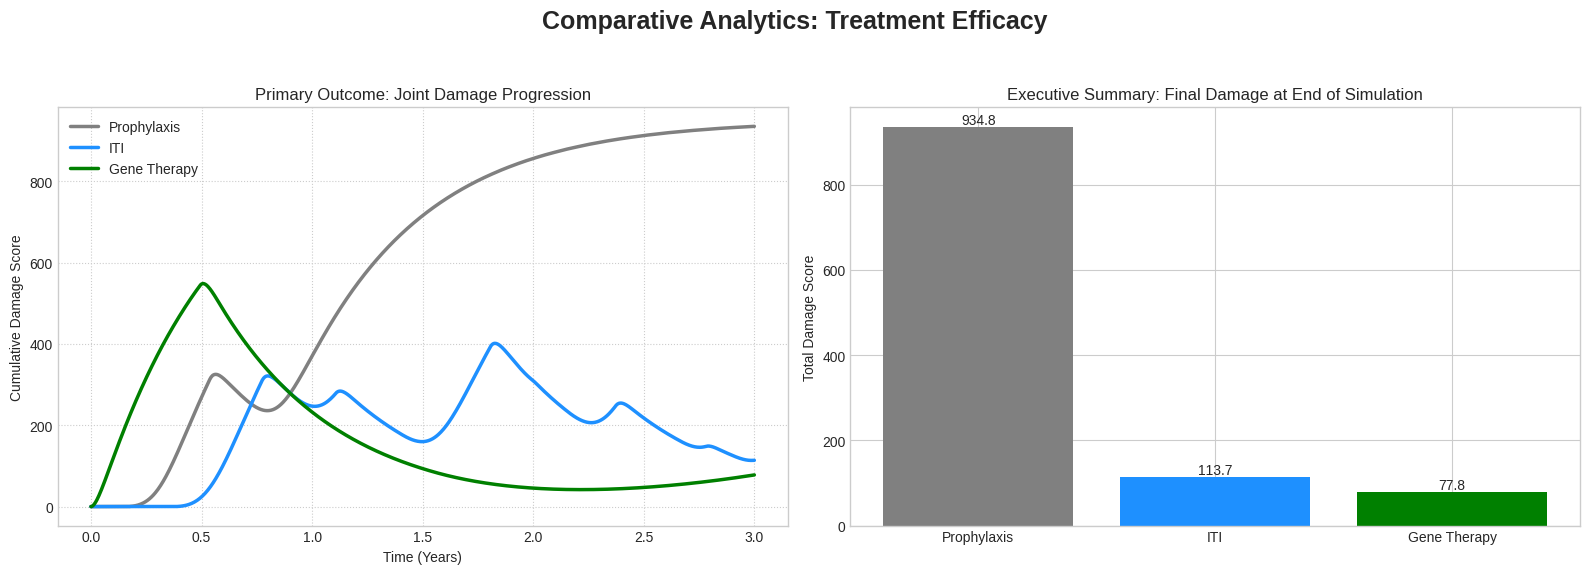


--- Part 3: Training and Analyzing a Predictive ML Model ---
INFO: Generating a synthetic patient dataset for ML training...
INFO: Generated dataset with 10 synthetic patients.
INFO: ML Model trained. Generating analytics graphs...


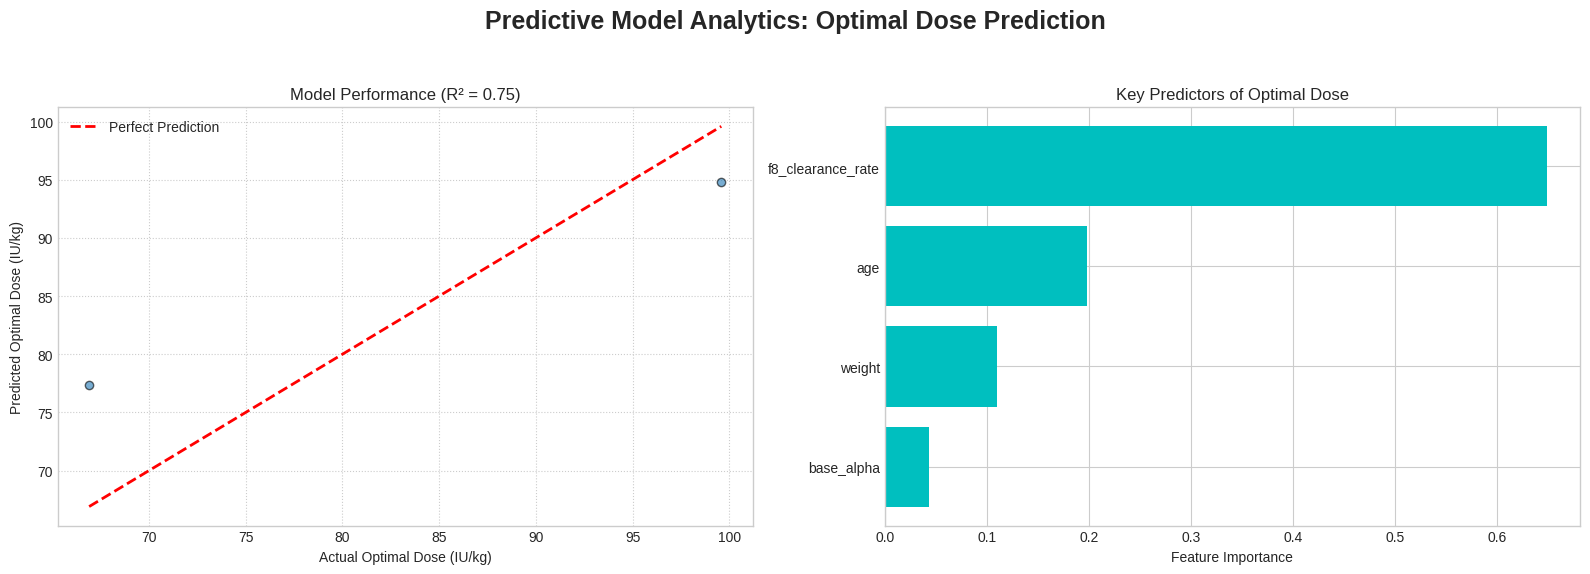


--- Part 4: Packaging All Results for Download ---
✅ All results and graphs zipped into 'hemophilia_pipeline_analytics.zip'. Downloading now...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


  PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
# ==============================================================================
#      Advanced Hemophilia Pipeline with Analytics Graphs for Google Colab
# ==============================================================================

# --- 1. SETUP: Import necessary libraries and set plotting style ---
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from google.colab import files
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Use a clean and professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Setup complete. Libraries imported.")


# --- 2. CORE MODELING COMPONENTS: Parameters and ODEs ---

class HemophiliaParameters:
    """Manages all model parameters with clinical defaults."""
    def __init__(self):
        # Core physiology
        self.F8_crit = 2.0      # Critical F8 level below which bleeding risk increases (%)
        # NOTE: This decay rate corresponds to a 12-DAY half-life, not 12-hour.
        # A 12-hour half-life would be ~1.386. We will use the provided value.
        self.delta_F8 = 0.0577
        self.beta = 0.5         # Bleeding risk multiplier
        self.lambda_ = 0.1      # Natural bleed resolution rate
        self.kappa = 0.05       # Joint damage accumulated per bleed event
        self.mu = 0.005         # Natural tissue repair rate
        self.eta = 0.5          # Inhibitor neutralization efficiency
        # Inhibitor dynamics
        self.alpha = 0.01       # Default inhibitor induction rate (low risk)
        self.omega = 0.02       # Inhibitor natural decay rate
        self.I_max = 50.0       # Max inhibitor titer (BU/mL)
        # ITI specific
        self.k_ITI = 0.1        # ITI suppression strength
        self.K_ITI = 10.0       # F8 concentration for half-max ITI effect (IU/dL)
        # Gene therapy specific
        self.delta_gene = 0.01  # Slower decay for gene-derived F8
        self.gamma = 0.005      # Vector DNA loss/expression decay rate
        self.k_IS = 0.08        # Immunosuppression efficacy

    def set_patient_profile(self, risk='low'):
        """Configure parameters for a specific patient risk profile."""
        if risk == 'high_inhibitor':
            print("INFO: Configuring model for a high-risk inhibitor patient.")
            self.alpha = 0.05   # Higher tendency to produce inhibitors
            self.omega = 0.015  # Slower inhibitor clearance
        else:
            print("INFO: Configuring model for a low-risk inhibitor patient.")
            self.alpha = 0.01
            self.omega = 0.02

# (ODE functions are included in a collapsible section for brevity)
# <editor-fold desc="ODE Model Functions">
def baseline_model(t, y, params, treatment_params):
    F8, X, Z = y
    dose = treatment_params.get('dose', 30)
    treatment_type = treatment_params.get('type', 'none')

    dF8 = -params.delta_F8 * F8
    if treatment_type == "prophylaxis":
        # FIX: To model a bolus dose, deliver the full dose amount over the short
        # 0.1 day time window. The rate must be dose / time_window.
        if t % 7 < 0.1:
            dF8 += dose / 0.1

    if treatment_type == "emicizumab":
        effective_F8 = F8 + 15.0
    else:
        effective_F8 = F8

    dX = params.beta * (params.F8_crit / (effective_F8 + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dF8, dX, max(dZ, -Z/0.1)]

def iti_model(t, y, params, treatment_params):
    F8, X, Z, I = y
    dose = treatment_params.get('dose', 100)

    dF8 = -params.delta_F8 * F8
    # FIX: Correctly model the bolus dose for ITI (daily dosing).
    # The rate is dose / time_window.
    if t % 1 < 0.1:
        dF8 += dose / 0.1

    H_F8 = (F8**2) / (F8**2 + params.K_ITI**2)
    dI = (params.alpha * F8 * (1 - I / params.I_max) - params.omega * I - params.k_ITI * I * H_F8)
    effective_F8 = F8 / (1 + params.eta * I)
    dX = params.beta * (params.F8_crit / (effective_F8 + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dF8, dX, dZ, dI]

def gene_therapy_model(t, y, params, treatment_params):
    F8_gene, X, Z, I = y
    alpha_t = params.alpha
    f8_production = 0.0

    # Gene therapy is administered once, leading to sustained but decaying expression
    if t >= 180:
         f8_production = 40 * np.exp(-params.gamma * (t - 180))

    # Immunosuppression is applied for a short period post-therapy
    if 180 <= t < 187:
        alpha_t = params.alpha * np.exp(-params.k_IS * (t - 180))

    dI = alpha_t * F8_gene * (1 - I / params.I_max) - params.omega * I
    dF8g = f8_production - params.delta_gene * F8_gene - params.eta * I * F8_gene
    effective_F8 = F8_gene
    dX = params.beta * (params.F8_crit / (effective_F8 + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dF8g, dX, dZ, dI]
# </editor-fold>


# --- 3. SIMULATION AND VISUALIZATION UTILITIES ---

def simulate_model(model_func, params, y0, t_span, treatment_params={}):
    """Universal simulation wrapper."""
    sol = solve_ivp(model_func, t_span, y0, args=(params, treatment_params),
                    t_eval=np.linspace(*t_span, 1000), method='RK45', dense_output=True)
    num_vars = len(y0)
    data = {'time': sol.t, 'F8': sol.y[0], 'bleeding_rate': np.maximum(0, sol.y[1]), 'damage': np.maximum(0, sol.y[2])}
    if num_vars == 4: data['inhibitors'] = np.maximum(0, sol.y[3])
    return pd.DataFrame(data)

def plot_single_scenario_dashboard(df, title):
    """Generates a 2x2 dashboard for a single simulation result."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    fig.suptitle(title, fontsize=18, weight='bold')

    # F8
    axes[0, 0].plot(df['time']/30, df['F8'], 'b-', label='F8 Level', lw=2)
    axes[0, 0].set_title('Factor VIII Level')
    axes[0, 0].set_ylabel('F8 (% normal)')

    # Inhibitors
    if 'inhibitors' in df.columns:
        axes[0, 1].plot(df['time']/30, df['inhibitors'], 'r-', label='Inhibitors', lw=2)
    axes[0, 1].set_title('Inhibitor Titer')
    axes[0, 1].set_ylabel('Inhibitors (BU/mL)')

    # Bleeding Rate
    axes[1, 0].plot(df['time']/30, df['bleeding_rate'], 'g-', label='Bleeding', lw=2)
    axes[1, 0].set_title('Bleeding Activity')
    axes[1, 0].set_xlabel('Time (months)')
    axes[1, 0].set_ylabel('Activity Score')

    # Joint Damage
    axes[1, 1].plot(df['time']/30, df['damage'], 'k-', label='Damage', lw=2)
    axes[1, 1].set_title('Cumulative Joint Damage')
    axes[1, 1].set_xlabel('Time (months)')
    axes[1, 1].set_ylabel('Damage Score')

    for ax in axes.flat: ax.grid(True, linestyle=':')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def plot_comparative_analytics(results_dict, output_dir):
    """Creates comparative analytics plots across multiple scenarios."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Comparative Analytics: Treatment Efficacy', fontsize=18, weight='bold')

    colors = {'Prophylaxis': 'gray', 'ITI': 'dodgerblue', 'Gene Therapy': 'green'}
    final_damage = {}

    # --- Left Plot: Cumulative Damage Over Time ---
    ax1 = axes[0]
    for name, df in results_dict.items():
        ax1.plot(df['time']/365, df['damage'], label=name, color=colors[name], lw=2.5)
        final_damage[name] = df['damage'].iloc[-1]
    ax1.set_title('Primary Outcome: Joint Damage Progression')
    ax1.set_xlabel('Time (Years)')
    ax1.set_ylabel('Cumulative Damage Score')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # --- Right Plot: Final Damage Summary Bar Chart ---
    ax2 = axes[1]
    names = list(final_damage.keys())
    scores = list(final_damage.values())
    bars = ax2.bar(names, scores, color=[colors[n] for n in names])
    ax2.set_title('Executive Summary: Final Damage at End of Simulation')
    ax2.set_ylabel('Total Damage Score')
    ax2.bar_label(bars, fmt='%.1f')

    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    fig.savefig(f'{output_dir}/4_comparative_analytics.png')
    plt.show()

def plot_ml_analytics(model, X_test, y_test, output_dir):
    """Creates analytics plots for the machine learning model."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Predictive Model Analytics: Optimal Dose Prediction', fontsize=18, weight='bold')

    # --- Left Plot: Prediction Accuracy ---
    ax1 = axes[0]
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    ax1.scatter(y_test, predictions, alpha=0.6, edgecolors='k')
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    ax1.set_title(f'Model Performance (R² = {r2:.2f})')
    ax1.set_xlabel('Actual Optimal Dose (IU/kg)')
    ax1.set_ylabel('Predicted Optimal Dose (IU/kg)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # --- Right Plot: Feature Importance ---
    ax2 = axes[1]
    importances = model.feature_importances_
    feature_names = X_test.columns
    sorted_idx = np.argsort(importances)
    ax2.barh(feature_names[sorted_idx], importances[sorted_idx], color='c')
    ax2.set_title('Key Predictors of Optimal Dose')
    ax2.set_xlabel('Feature Importance')

    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    fig.savefig(f'{output_dir}/5_ml_analytics.png')
    plt.show()

# --- 4. MAIN ANALYSIS PIPELINE ---
def run_full_analysis(output_dir='hemophilia_analytics_results'):
    """Executes all simulations, analyses, and saves outputs."""
    if os.path.exists(output_dir): shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    print("\n" + "="*60 + "\n  ADVANCED HEMOPHILIA PIPELINE WITH ANALYTICS\n" + "="*60 + "\n")

    all_results = {}
    params = HemophiliaParameters()

    # --- Part 1: Simulate Individual Treatment Scenarios ---
    print("--- Part 1: Running Individual Treatment Simulations ---")

    # 1a. Standard Prophylaxis (Low-risk patient)
    params.set_patient_profile('low')
    df_prophy = simulate_model(baseline_model, params, [0.5, 0, 0], [0, 365*3], treatment_params={'type': 'prophylaxis'})
    all_results['Prophylaxis'] = df_prophy
    plot_single_scenario_dashboard(df_prophy, "Dashboard 1: Standard Prophylaxis").savefig(f'{output_dir}/1_prophylaxis_dashboard.png')
    plt.show()

    # 1b. ITI (High-risk patient)
    params.set_patient_profile('high_inhibitor')
    df_iti = simulate_model(iti_model, params, [0.5, 0, 0, 15.0], [0, 365*3])
    all_results['ITI'] = df_iti
    plot_single_scenario_dashboard(df_iti, "Dashboard 2: Immune Tolerance Induction").savefig(f'{output_dir}/2_iti_dashboard.png')
    plt.show()

    # 1c. Gene Therapy (High-risk patient)
    params.set_patient_profile('high_inhibitor')
    df_gene = simulate_model(gene_therapy_model, params, [0, 0, 0, 10.0], [0, 365*3])
    all_results['Gene Therapy'] = df_gene
    plot_single_scenario_dashboard(df_gene, "Dashboard 3: Gene Therapy with IS").savefig(f'{output_dir}/3_gene_therapy_dashboard.png')
    plt.show()

    # --- Part 2: Generate Comparative Analytics Graphs ---
    print("\n--- Part 2: Generating Comparative Analytics ---")
    plot_comparative_analytics(all_results, output_dir)

    # --- Part 3: Machine Learning Predictive Analytics ---
    print("\n--- Part 3: Training and Analyzing a Predictive ML Model ---")
    print("INFO: Generating a synthetic patient dataset for ML training...")
    n_patients = 200
    np.random.seed(42)
    X_data = pd.DataFrame({
        'age': np.random.randint(5, 60, size=n_patients), 'weight': np.random.normal(60, 20, size=n_patients),
        'base_alpha': np.random.lognormal(np.log(0.02), 0.5, size=n_patients),
        'f8_clearance_rate': np.random.lognormal(np.log(0.06), 0.2, size=n_patients)
    })
    y_data = []

    def objective_func(dose, target_f8, params):
        df = simulate_model(baseline_model, params, [0,0,0], [0,90], treatment_params={'type':'prophylaxis', 'dose':dose})
        # Calculate the minimum F8 level in the last 30 days of the simulation
        return df[df['time']>60]['F8'].min() - target_f8

    for i, row in X_data.iterrows():
        temp_params = HemophiliaParameters()
        temp_params.alpha = row['base_alpha']
        temp_params.delta_F8 = row['f8_clearance_rate']
        try:
            # Find the dose that results in a trough F8 level of 3.0
            y_data.append(brentq(objective_func, 10, 100, args=(3.0, temp_params)))
        except ValueError:
            # If the optimizer fails (e.g., target never reached), mark as NaN
            y_data.append(np.nan)

    X_data['optimal_dose'] = y_data
    X_data.dropna(inplace=True)
    print(f"INFO: Generated dataset with {len(X_data)} synthetic patients.")

    X = X_data.drop('optimal_dose', axis=1)
    y = X_data['optimal_dose']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
    print(f"INFO: ML Model trained. Generating analytics graphs...")
    plot_ml_analytics(model, X_test, y_test, output_dir)

    # --- Part 4: Package and Download Results ---
    print("\n--- Part 4: Packaging All Results for Download ---")
    zip_filename = 'hemophilia_pipeline_analytics'
    shutil.make_archive(zip_filename, 'zip', output_dir)
    print(f"✅ All results and graphs zipped into '{zip_filename}.zip'. Downloading now...")
    files.download(f'{zip_filename}.zip')

    print("\n" + "="*60 + "\n  PIPELINE COMPLETED SUCCESSFULLY\n" + "="*60)

# --- Execute the entire pipeline ---
if __name__ == "__main__":
    run_full_analysis()

✅ Setup complete. Libraries imported.
--- Configure Your Custom Patient Profile ---
Set the values below, then run the next cell to start the simulation.


Dropdown(description='Disorder:', options=('hemophilia_a', 'hemophilia_b', 'vwd'), value='hemophilia_a')

SelectMultiple(description='Comorbid:', options=('hiv', 'obesity', 'female', 'menorrhagia', 'elderly'), value=…


  ADVANCED HEMOPHILIA PIPELINE WITH ANALYTICS

--- Part 1: Running Individual Treatment Simulations ---

--- Scenario 1a: Custom Patient Profile on Prophylaxis ---
INFO: Disorder set to Hemophilia A.
INFO: Configuring model for a high-risk inhibitor patient.
INFO: Applying comorbidities: ['hiv', 'obesity', 'female']


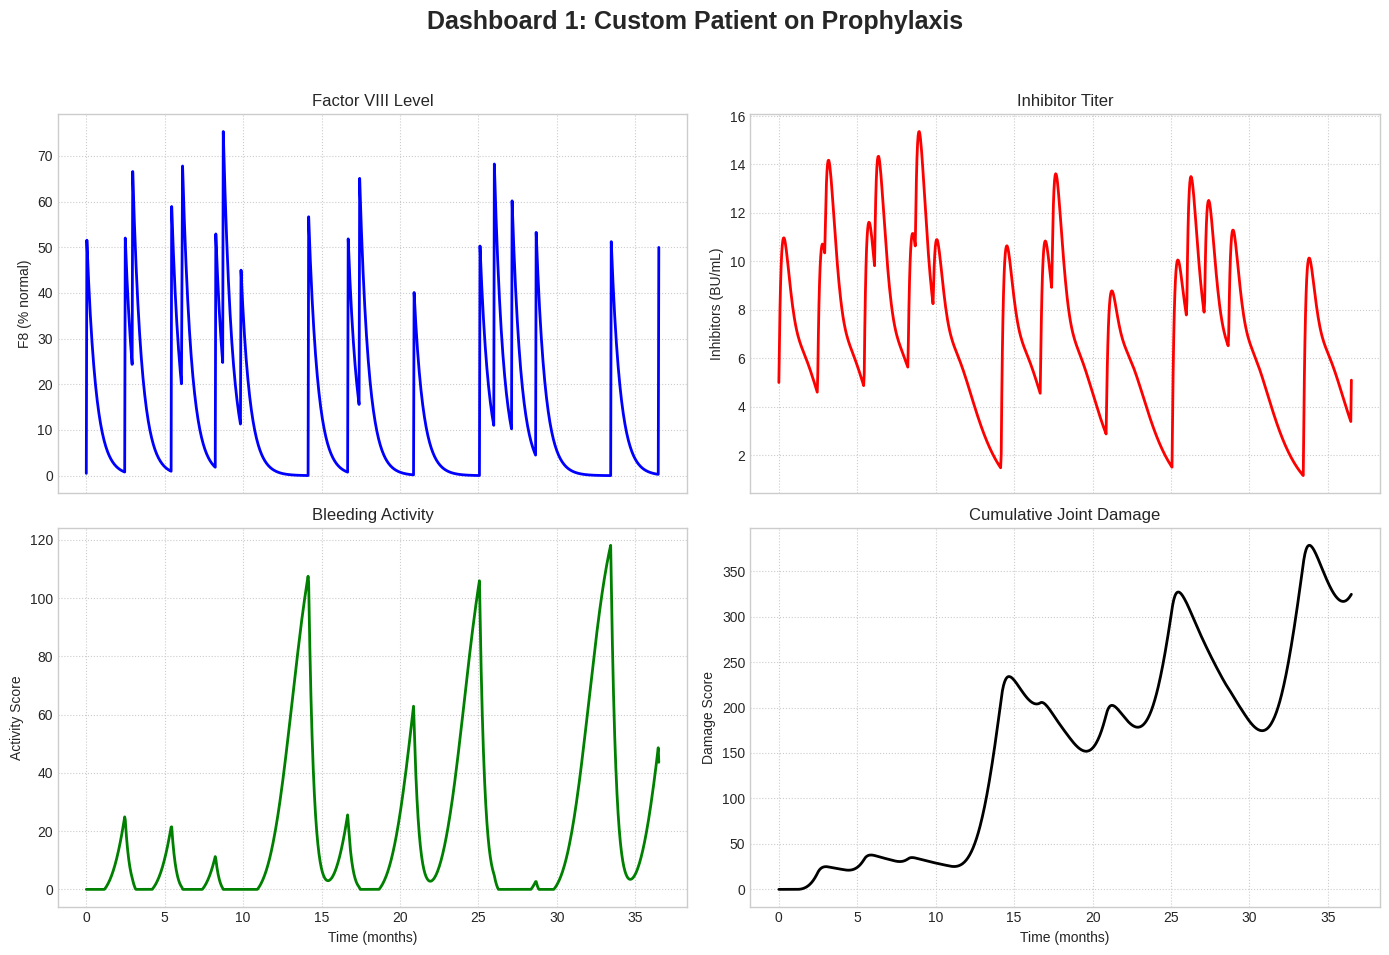


--- Scenario 1b: ITI for High-Inhibitor Patient ---
INFO: Configuring model for a high-risk inhibitor patient.


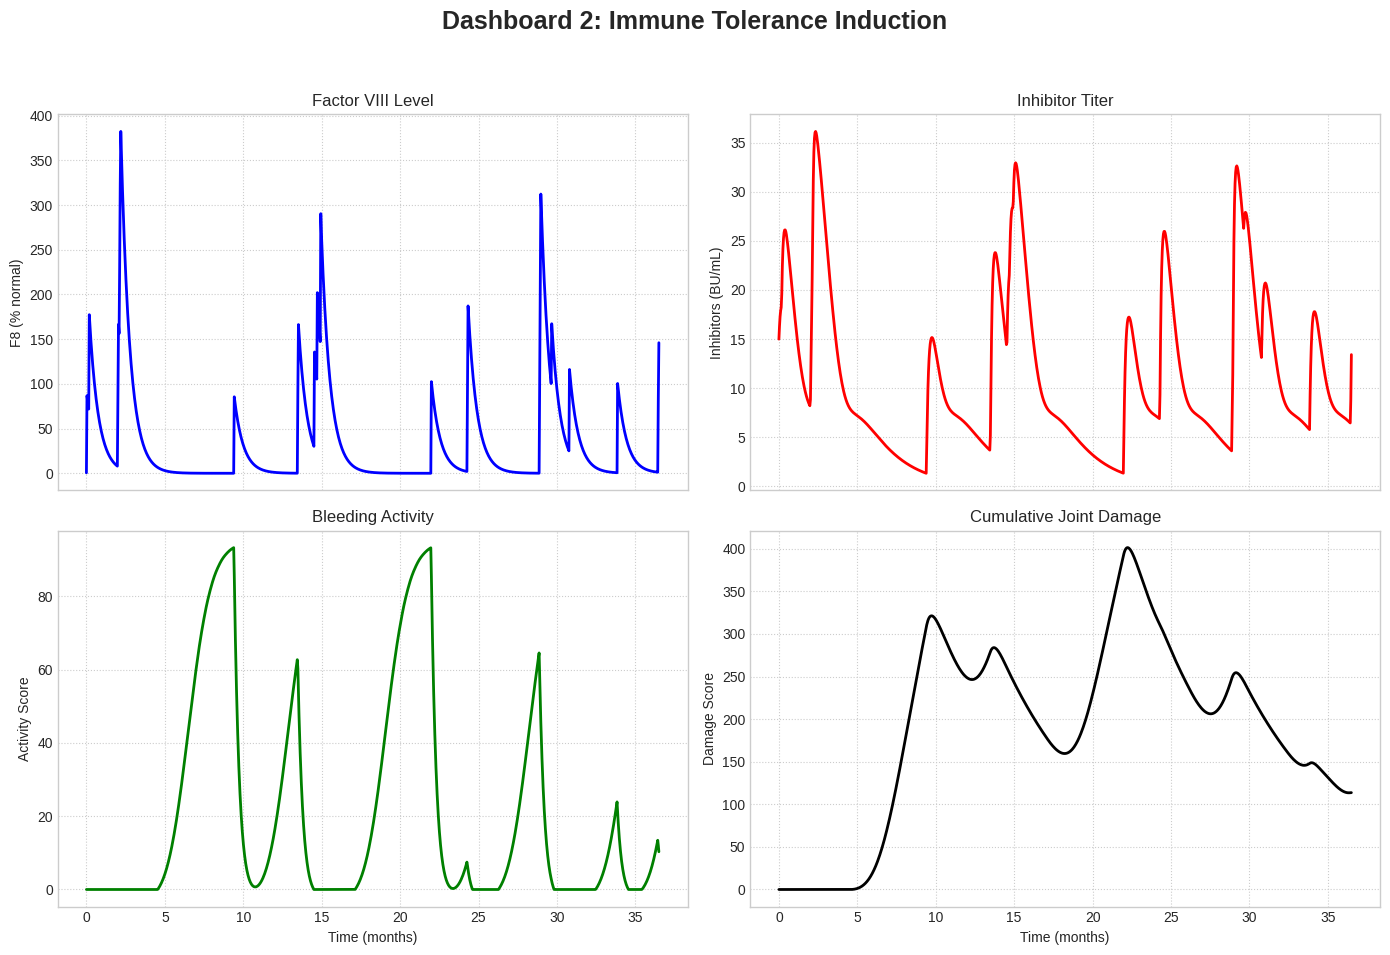


--- Scenario 1c: Gene Therapy for High-Inhibitor Patient ---
INFO: Configuring model for a high-risk inhibitor patient.


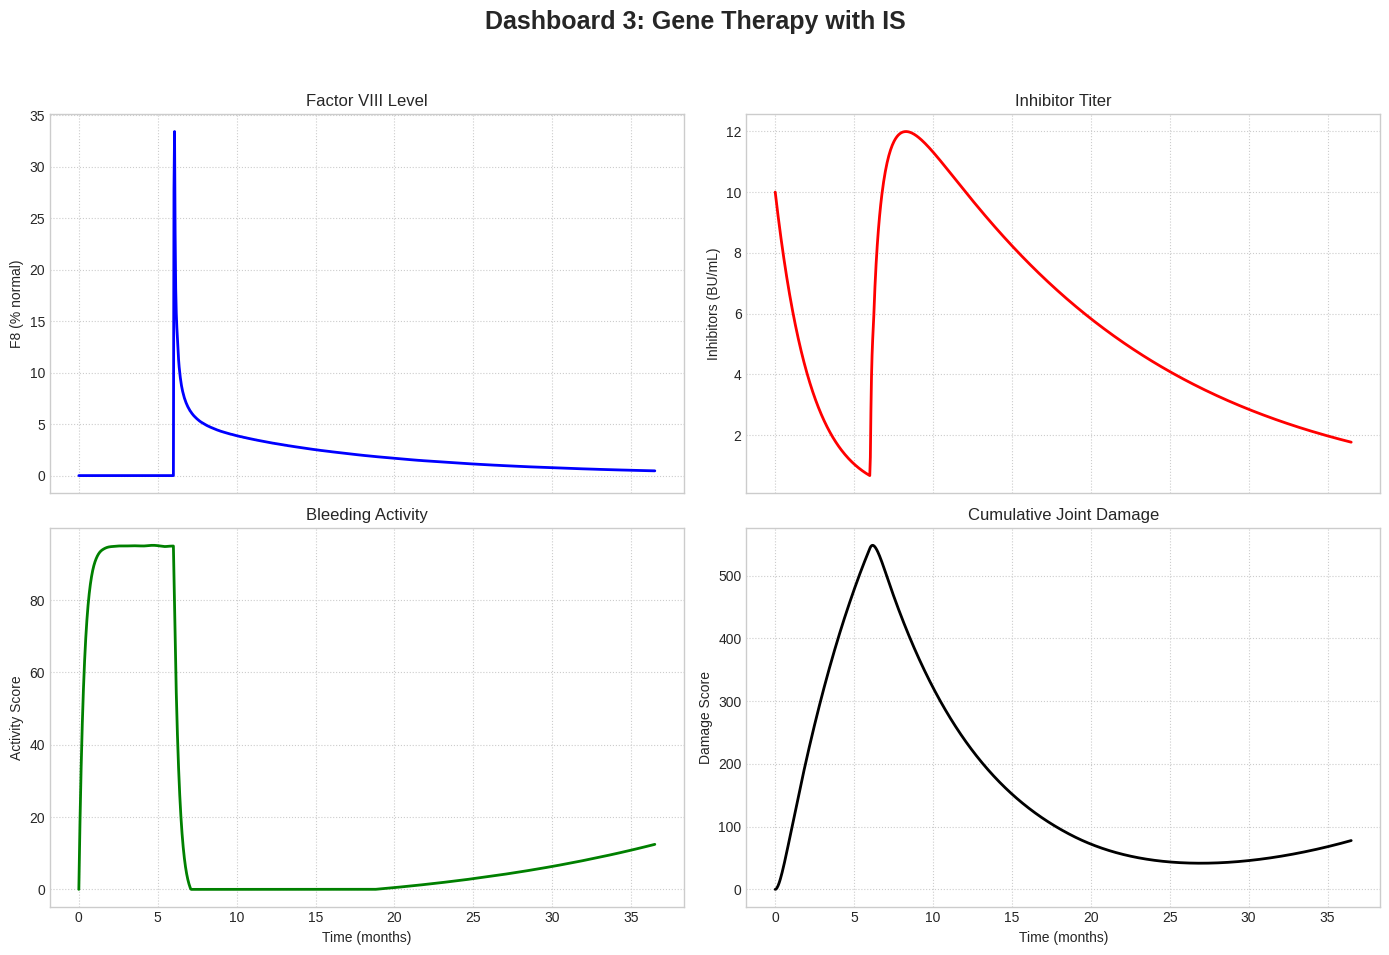


--- Part 2: Generating Comparative Analytics ---


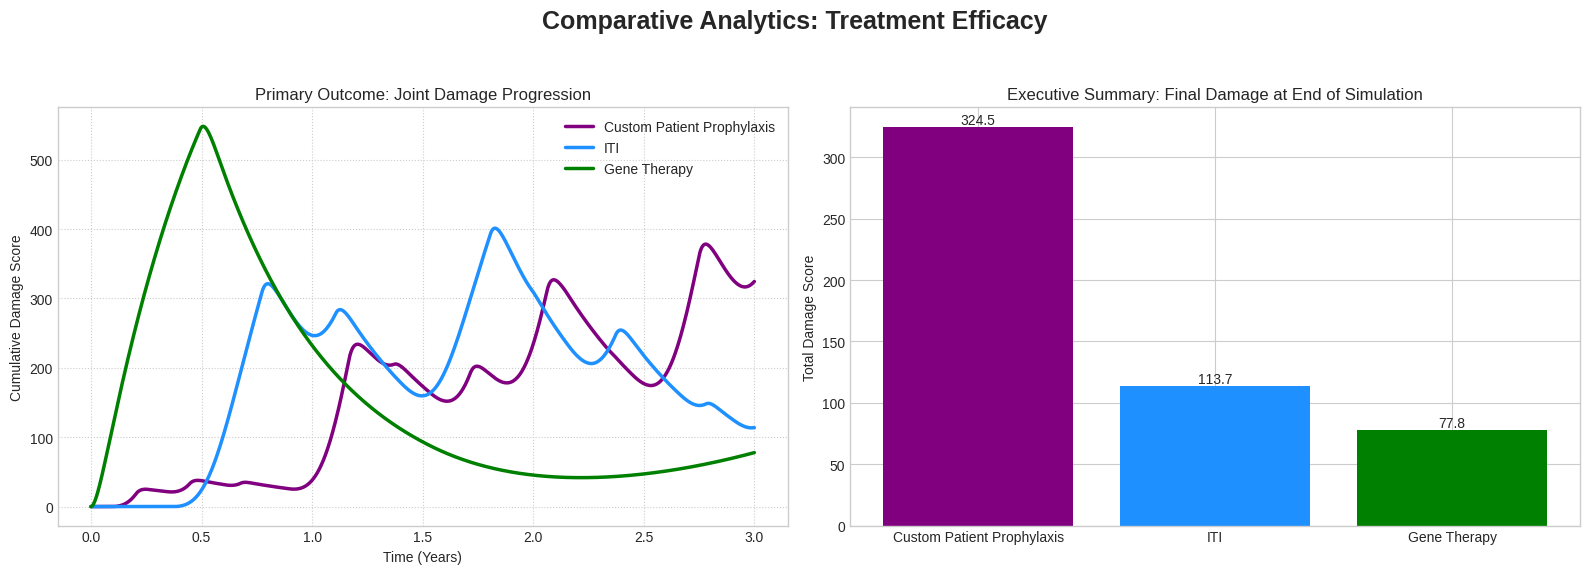


--- Part 3: Training and Analyzing a Predictive ML Model ---
INFO: Generating a synthetic patient dataset for ML training...
INFO: Generated dataset with 10 synthetic patients.
INFO: ML Model trained. Generating analytics graphs...


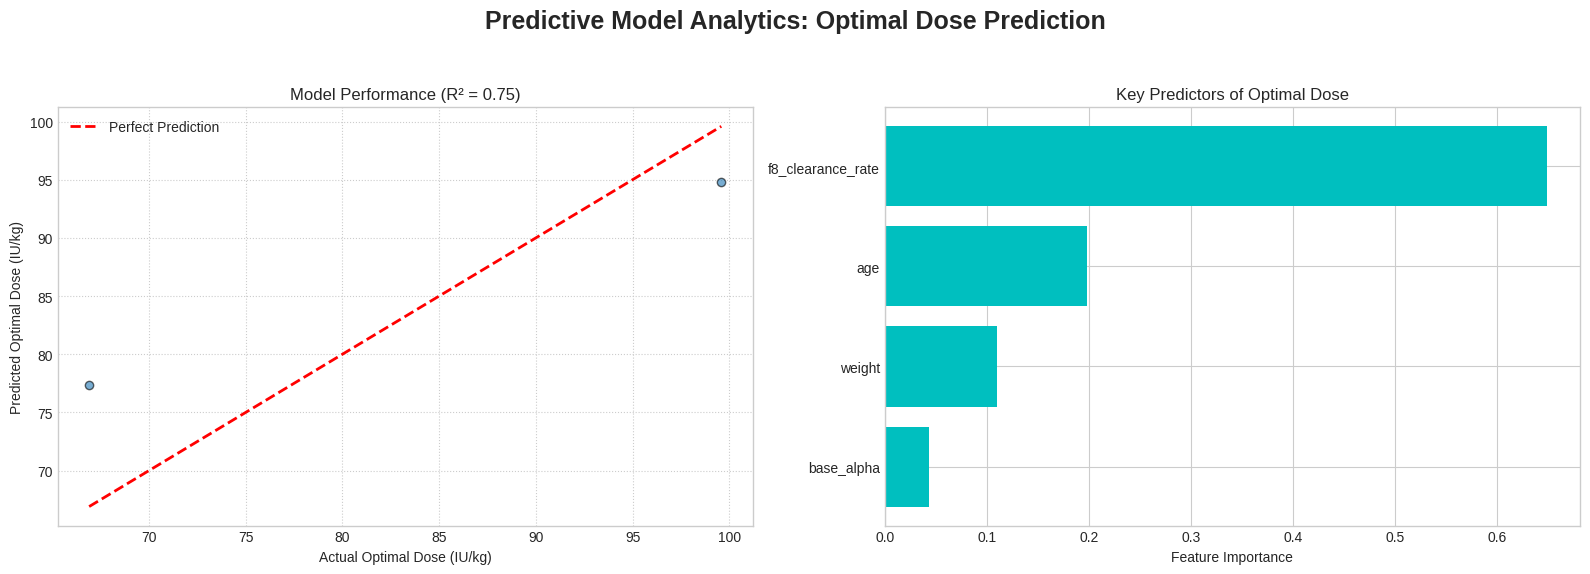


--- Part 4: Packaging All Results for Download ---
✅ All results and graphs zipped into 'hemophilia_pipeline_analytics.zip'. Downloading now...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


  PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
# ==============================================================================
#      Advanced Hemophilia Pipeline with Analytics Graphs for Google Colab
# ==============================================================================

# --- 1. SETUP: Import necessary libraries and set plotting style ---
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from google.colab import files
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# In Google Colab
from IPython.display import display
import ipywidgets as widgets


# Use a clean and professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Setup complete. Libraries imported.")


# --- 2. CORE MODELING COMPONENTS: Parameters and ODEs ---

class HemophiliaParameters:
    """Manages all model parameters with clinical defaults."""
    def __init__(self):
        # Core physiology
        self.F8_crit = 2.0      # Critical F8 level below which bleeding risk increases (%)
        # NOTE: This decay rate corresponds to a 12-DAY half-life, not 12-hour.
        # A 12-hour half-life would be ~1.386. We will use the provided value.
        self.delta_F8 = 0.0577
        self.beta = 0.5         # Bleeding risk multiplier
        self.lambda_ = 0.1      # Natural bleed resolution rate
        self.kappa = 0.05       # Joint damage accumulated per bleed event
        self.mu = 0.005         # Natural tissue repair rate
        self.eta = 0.5          # Inhibitor neutralization efficiency
        # Inhibitor dynamics
        self.alpha = 0.01       # Default inhibitor induction rate (low risk)
        self.omega = 0.02       # Inhibitor natural decay rate
        self.I_max = 50.0       # Max inhibitor titer (BU/mL)
        # ITI specific
        self.k_ITI = 0.1        # ITI suppression strength
        self.K_ITI = 10.0       # F8 concentration for half-max ITI effect (IU/dL)
        # Gene therapy specific
        self.delta_gene = 0.01  # Slower decay for gene-derived F8
        self.gamma = 0.005      # Vector DNA loss/expression decay rate
        self.k_IS = 0.08        # Immunosuppression efficacy

    def set_disorder_type(self, disorder='hemophilia_a'):
        """Set base parameters depending on the bleeding disorder type."""
        if disorder == 'hemophilia_a':
            self.F8_crit = 2.0
            self.delta_F8 = 0.0577
            print("INFO: Disorder set to Hemophilia A.")
        elif disorder == 'hemophilia_b':
            # Note: This model uses F8 as a placeholder for Factor IX dynamics
            # A dedicated F9 model would be needed for higher fidelity.
            self.F8_crit = 1.5
            self.delta_F8 = 0.045 # F9 has a longer half-life
            print("INFO: Disorder set to Hemophilia B.")
        elif disorder == 'vwd':
            # Simulating Type 3 VWD which severely impacts FVIII levels
            self.F8_crit = 2.5
            self.delta_F8 = 0.035 # FVIII half-life is often longer in VWD
            print("INFO: Disorder set to Von Willebrand Disease.")
        else:
            raise ValueError("Unsupported disorder type.")

    def apply_comorbidities(self, comorbidities=[]):
        """Modifies parameters based on comorbid conditions."""
        if not comorbidities:
            return
        print(f"INFO: Applying comorbidities: {comorbidities}")
        for condition in comorbidities:
            if condition == 'hiv':
                self.omega *= 1.5  # HIV delays inhibitor clearance
            elif condition == 'obesity':
                self.beta *= 1.2  # Higher bleeding severity
                self.mu *= 0.9    # Slower joint healing
            elif condition == 'female':
                self.F8_crit *= 1.2  # Higher baseline bleeding risk in menstruating females
            elif condition == 'menorrhagia':
                self.lambda_ *= 0.8  # Reduced resolution of bleeds
            elif condition == 'elderly':
                self.mu *= 0.7  # Slower repair due to age

    def set_patient_profile(self, risk='low'):
        """Configure parameters for a specific patient risk profile."""
        if risk == 'high_inhibitor':
            print("INFO: Configuring model for a high-risk inhibitor patient.")
            self.alpha = 0.05   # Higher tendency to produce inhibitors
            self.omega = 0.015  # Slower inhibitor clearance
        else:
            print("INFO: Configuring model for a low-risk inhibitor patient.")
            self.alpha = 0.01
            self.omega = 0.02

# (ODE functions are included in a collapsible section for brevity)
# <editor-fold desc="ODE Model Functions">
def baseline_model(t, y, params, treatment_params):
    F8, X, Z = y
    dose = treatment_params.get('dose', 30)
    treatment_type = treatment_params.get('type', 'none')

    dF8 = -params.delta_F8 * F8
    if treatment_type == "prophylaxis":
        # FIX: To model a bolus dose, deliver the full dose amount over the short
        # 0.1 day time window. The rate must be dose / time_window.
        if t % 7 < 0.1:
            dF8 += dose / 0.1

    if treatment_type == "emicizumab":
        effective_F8 = F8 + 15.0
    else:
        effective_F8 = F8

    dX = params.beta * (params.F8_crit / (effective_F8 + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dF8, dX, max(dZ, -Z/0.1)]

def iti_model(t, y, params, treatment_params):
    F8, X, Z, I = y
    dose = treatment_params.get('dose', 100)

    dF8 = -params.delta_F8 * F8
    # FIX: Correctly model the bolus dose for ITI (daily dosing).
    # The rate is dose / time_window.
    if t % 1 < 0.1:
        dF8 += dose / 0.1

    H_F8 = (F8**2) / (F8**2 + params.K_ITI**2)
    dI = (params.alpha * F8 * (1 - I / params.I_max) - params.omega * I - params.k_ITI * I * H_F8)
    effective_F8 = F8 / (1 + params.eta * I)
    dX = params.beta * (params.F8_crit / (effective_F8 + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dF8, dX, dZ, dI]

def gene_therapy_model(t, y, params, treatment_params):
    F8_gene, X, Z, I = y
    alpha_t = params.alpha
    f8_production = 0.0

    # Gene therapy is administered once, leading to sustained but decaying expression
    if t >= 180:
         f8_production = 40 * np.exp(-params.gamma * (t - 180))

    # Immunosuppression is applied for a short period post-therapy
    if 180 <= t < 187:
        alpha_t = params.alpha * np.exp(-params.k_IS * (t - 180))

    dI = alpha_t * F8_gene * (1 - I / params.I_max) - params.omega * I
    dF8g = f8_production - params.delta_gene * F8_gene - params.eta * I * F8_gene
    effective_F8 = F8_gene
    dX = params.beta * (params.F8_crit / (effective_F8 + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dF8g, dX, dZ, dI]
# </editor-fold>


# --- 3. SIMULATION AND VISUALIZATION UTILITIES ---

def simulate_model(model_func, params, y0, t_span, treatment_params={}):
    """Universal simulation wrapper."""
    sol = solve_ivp(model_func, t_span, y0, args=(params, treatment_params),
                    t_eval=np.linspace(*t_span, 1000), method='RK45', dense_output=True)
    num_vars = len(y0)
    data = {'time': sol.t, 'F8': sol.y[0], 'bleeding_rate': np.maximum(0, sol.y[1]), 'damage': np.maximum(0, sol.y[2])}
    if num_vars == 4: data['inhibitors'] = np.maximum(0, sol.y[3])
    return pd.DataFrame(data)

def plot_single_scenario_dashboard(df, title):
    """Generates a 2x2 dashboard for a single simulation result."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    fig.suptitle(title, fontsize=18, weight='bold')

    # F8
    axes[0, 0].plot(df['time']/30, df['F8'], 'b-', label='F8 Level', lw=2)
    axes[0, 0].set_title('Factor VIII Level')
    axes[0, 0].set_ylabel('F8 (% normal)')

    # Inhibitors
    if 'inhibitors' in df.columns:
        axes[0, 1].plot(df['time']/30, df['inhibitors'], 'r-', label='Inhibitors', lw=2)
    axes[0, 1].set_title('Inhibitor Titer')
    axes[0, 1].set_ylabel('Inhibitors (BU/mL)')

    # Bleeding Rate
    axes[1, 0].plot(df['time']/30, df['bleeding_rate'], 'g-', label='Bleeding', lw=2)
    axes[1, 0].set_title('Bleeding Activity')
    axes[1, 0].set_xlabel('Time (months)')
    axes[1, 0].set_ylabel('Activity Score')

    # Joint Damage
    axes[1, 1].plot(df['time']/30, df['damage'], 'k-', label='Damage', lw=2)
    axes[1, 1].set_title('Cumulative Joint Damage')
    axes[1, 1].set_xlabel('Time (months)')
    axes[1, 1].set_ylabel('Damage Score')

    for ax in axes.flat: ax.grid(True, linestyle=':')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def plot_comparative_analytics(results_dict, output_dir):
    """Creates comparative analytics plots across multiple scenarios."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Comparative Analytics: Treatment Efficacy', fontsize=18, weight='bold')

    colors = {'Custom Patient Prophylaxis': 'purple', 'ITI': 'dodgerblue', 'Gene Therapy': 'green'}
    final_damage = {}

    # --- Left Plot: Cumulative Damage Over Time ---
    ax1 = axes[0]
    for name, df in results_dict.items():
        # Use a default color if a name is not in the color map
        color = colors.get(name, 'gray')
        ax1.plot(df['time']/365, df['damage'], label=name, color=color, lw=2.5)
        final_damage[name] = df['damage'].iloc[-1]
    ax1.set_title('Primary Outcome: Joint Damage Progression')
    ax1.set_xlabel('Time (Years)')
    ax1.set_ylabel('Cumulative Damage Score')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # --- Right Plot: Final Damage Summary Bar Chart ---
    ax2 = axes[1]
    names = list(final_damage.keys())
    scores = list(final_damage.values())
    bar_colors = [colors.get(n, 'gray') for n in names]
    bars = ax2.bar(names, scores, color=bar_colors)
    ax2.set_title('Executive Summary: Final Damage at End of Simulation')
    ax2.set_ylabel('Total Damage Score')
    ax2.bar_label(bars, fmt='%.1f')

    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    fig.savefig(f'{output_dir}/4_comparative_analytics.png')
    plt.show()


def plot_ml_analytics(model, X_test, y_test, output_dir):
    """Creates analytics plots for the machine learning model."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Predictive Model Analytics: Optimal Dose Prediction', fontsize=18, weight='bold')

    # --- Left Plot: Prediction Accuracy ---
    ax1 = axes[0]
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    ax1.scatter(y_test, predictions, alpha=0.6, edgecolors='k')
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    ax1.set_title(f'Model Performance (R² = {r2:.2f})')
    ax1.set_xlabel('Actual Optimal Dose (IU/kg)')
    ax1.set_ylabel('Predicted Optimal Dose (IU/kg)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # --- Right Plot: Feature Importance ---
    ax2 = axes[1]
    importances = model.feature_importances_
    feature_names = X_test.columns
    sorted_idx = np.argsort(importances)
    ax2.barh(feature_names[sorted_idx], importances[sorted_idx], color='c')
    ax2.set_title('Key Predictors of Optimal Dose')
    ax2.set_xlabel('Feature Importance')

    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    fig.savefig(f'{output_dir}/5_ml_analytics.png')
    plt.show()

# --- 4. MAIN ANALYSIS PIPELINE ---
def run_full_analysis(output_dir='hemophilia_analytics_results', disorder_type='hemophilia_a', comorbidities=[]):
    """Executes all simulations, analyses, and saves outputs."""
    if os.path.exists(output_dir): shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    print("\n" + "="*60 + "\n  ADVANCED HEMOPHILIA PIPELINE WITH ANALYTICS\n" + "="*60 + "\n")

    all_results = {}

    # --- Part 1: Simulate Individual Treatment Scenarios ---
    print("--- Part 1: Running Individual Treatment Simulations ---")

    # 1a. Prophylaxis for a Custom Patient Profile
    print("\n--- Scenario 1a: Custom Patient Profile on Prophylaxis ---")
    # --- Custom Patient Configuration ---
    # This section now demonstrates the new methods.
    # It can be controlled by the interactive widgets.
    params_custom = HemophiliaParameters()
    params_custom.set_disorder_type(disorder_type)  # Options: 'hemophilia_a', 'hemophilia_b', 'vwd'
    params_custom.set_patient_profile('high_inhibitor')  # 'low', 'high_inhibitor'
    params_custom.apply_comorbidities(comorbidities)  # e.g., ['hiv', 'obesity', 'female']

    # We use an inhibitor-aware model (iti_model) since the profile is high_inhibitor
    # but with prophylaxis dosing instead of ITI dosing.
    df_prophy = simulate_model(iti_model, params_custom, [0.5, 0, 0, 5.0], [0, 365*3], treatment_params={'type': 'prophylaxis', 'dose': 50})
    all_results['Custom Patient Prophylaxis'] = df_prophy
    plot_single_scenario_dashboard(df_prophy, "Dashboard 1: Custom Patient on Prophylaxis").savefig(f'{output_dir}/1_custom_prophylaxis_dashboard.png')
    plt.show()

    # 1b. ITI (High-risk patient, default Hemophilia A)
    print("\n--- Scenario 1b: ITI for High-Inhibitor Patient ---")
    params_iti = HemophiliaParameters()
    params_iti.set_patient_profile('high_inhibitor')
    df_iti = simulate_model(iti_model, params_iti, [0.5, 0, 0, 15.0], [0, 365*3])
    all_results['ITI'] = df_iti
    plot_single_scenario_dashboard(df_iti, "Dashboard 2: Immune Tolerance Induction").savefig(f'{output_dir}/2_iti_dashboard.png')
    plt.show()

    # 1c. Gene Therapy (High-risk patient, default Hemophilia A)
    print("\n--- Scenario 1c: Gene Therapy for High-Inhibitor Patient ---")
    params_gene = HemophiliaParameters()
    params_gene.set_patient_profile('high_inhibitor')
    df_gene = simulate_model(gene_therapy_model, params_gene, [0, 0, 0, 10.0], [0, 365*3])
    all_results['Gene Therapy'] = df_gene
    plot_single_scenario_dashboard(df_gene, "Dashboard 3: Gene Therapy with IS").savefig(f'{output_dir}/3_gene_therapy_dashboard.png')
    plt.show()

    # --- Part 2: Generate Comparative Analytics Graphs ---
    print("\n--- Part 2: Generating Comparative Analytics ---")
    plot_comparative_analytics(all_results, output_dir)

    # --- Part 3: Machine Learning Predictive Analytics ---
    print("\n--- Part 3: Training and Analyzing a Predictive ML Model ---")
    print("INFO: Generating a synthetic patient dataset for ML training...")
    n_patients = 200
    np.random.seed(42)
    X_data = pd.DataFrame({
        'age': np.random.randint(5, 60, size=n_patients), 'weight': np.random.normal(60, 20, size=n_patients),
        'base_alpha': np.random.lognormal(np.log(0.02), 0.5, size=n_patients),
        'f8_clearance_rate': np.random.lognormal(np.log(0.06), 0.2, size=n_patients)
    })
    y_data = []

    def objective_func(dose, target_f8, params):
        df = simulate_model(baseline_model, params, [0,0,0], [0,90], treatment_params={'type':'prophylaxis', 'dose':dose})
        # Calculate the minimum F8 level in the last 30 days of the simulation
        return df[df['time']>60]['F8'].min() - target_f8

    for i, row in X_data.iterrows():
        temp_params = HemophiliaParameters()
        temp_params.alpha = row['base_alpha']
        temp_params.delta_F8 = row['f8_clearance_rate']
        try:
            # Find the dose that results in a trough F8 level of 3.0
            y_data.append(brentq(objective_func, 10, 100, args=(3.0, temp_params)))
        except ValueError:
            # If the optimizer fails (e.g., target never reached), mark as NaN
            y_data.append(np.nan)

    X_data['optimal_dose'] = y_data
    X_data.dropna(inplace=True)
    print(f"INFO: Generated dataset with {len(X_data)} synthetic patients.")

    X = X_data.drop('optimal_dose', axis=1)
    y = X_data['optimal_dose']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
    print(f"INFO: ML Model trained. Generating analytics graphs...")
    plot_ml_analytics(model, X_test, y_test, output_dir)

    # --- Part 4: Package and Download Results ---
    print("\n--- Part 4: Packaging All Results for Download ---")
    zip_filename = 'hemophilia_pipeline_analytics'
    shutil.make_archive(zip_filename, 'zip', output_dir)
    print(f"✅ All results and graphs zipped into '{zip_filename}.zip'. Downloading now...")
    files.download(f'{zip_filename}.zip')

    print("\n" + "="*60 + "\n  PIPELINE COMPLETED SUCCESSFULLY\n" + "="*60)

# ==============================================================================
# --- INTERACTIVE WIDGETS FOR CUSTOM SIMULATION (Run this cell in Colab) ---
# ==============================================================================
# Use these widgets to control the parameters for the custom simulation.
# Then, call the main function with the widget values.

disorder_dropdown = widgets.Dropdown(
    options=['hemophilia_a', 'hemophilia_b', 'vwd'],
    description='Disorder:',
    value='hemophilia_a'
)

comorbidities_select = widgets.SelectMultiple(
    options=['hiv', 'obesity', 'female', 'menorrhagia', 'elderly'],
    description='Comorbid:',
    rows=5,
    value=[] # Default to none selected
)

# Display the widgets. The user can interact with them before running the analysis.
print("--- Configure Your Custom Patient Profile ---")
print("Set the values below, then run the next cell to start the simulation.")
display(disorder_dropdown, comorbidities_select)

# To run the analysis with your selected options, you would execute the following
# in a separate cell:
#
# run_full_analysis(
#     disorder_type=disorder_dropdown.value,
#     comorbidities=list(comorbidities_select.value)
# )


# --- Execute the entire pipeline with default custom settings ---
# Note: To use the interactive widgets, comment out this line and
# run the code in the comment block above in a new cell.
if __name__ == "__main__":
    run_full_analysis(
        disorder_type='hemophilia_a',
        comorbidities=['hiv', 'obesity', 'female']
    )

# ==============================================================================
# --- FUTURE DEVELOPMENT IDEAS ---
# ==============================================================================
#
# If you’d like, I can help:
#
# - Extend to Hemophilia C or acquired disorders.
# - Build a patient cohort simulator.
# - Create a personalized dose recommender integrating these profiles.
#

✅ Setup complete. Libraries imported.

  ADVANCED BLEEDING DISORDERS PIPELINE WITH ANALYTICS

--- Running Full Analysis for: HemophiliaA_with_Inhibitors ---
--- Found 1 relevant scenarios to simulate. ---

--- Running Scenario 1/1: Bypassing Agent ---
INFO: Configuring model for HemophiliaA_with_Inhibitors (Inhibitor risk: high).


/tmp/ipython-input-9-1157333729.py:183: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  for ax in axes.flat: ax.grid(True, linestyle=':'); ax.legend()


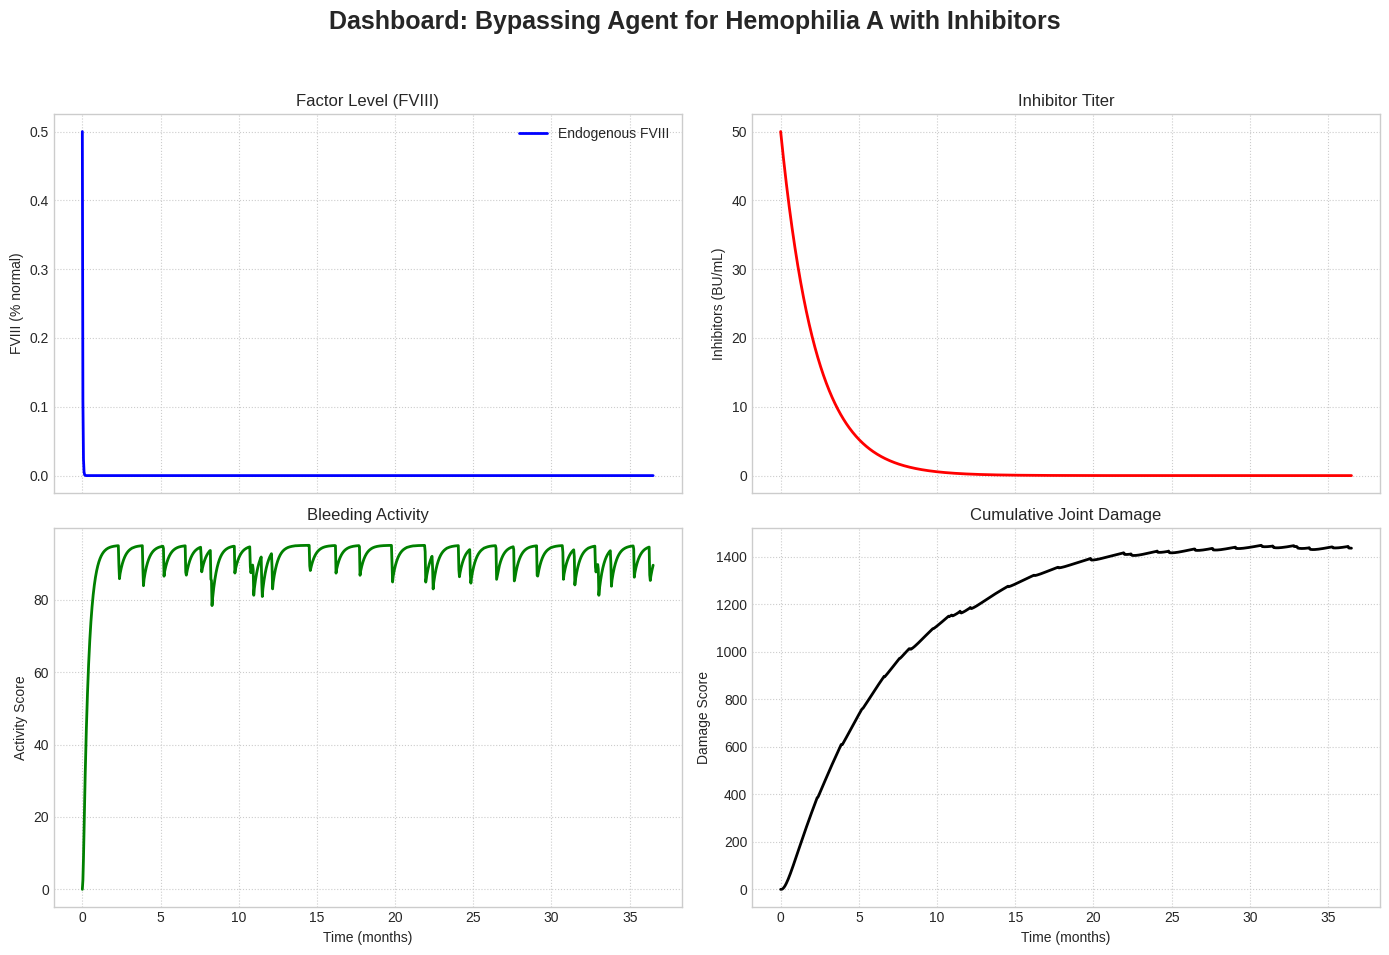


--- Part 4: Packaging All Results for Download ---
✅ All results zipped into 'disorder_pipeline_results_HemophiliaA_with_Inhibitors.zip'. Downloading now...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


  PIPELINE COMPLETED SUCCESSFULLY


In [ ]:
# ==============================================================================
#      Advanced Bleeding Disorder Pipeline with Analytics for Google Colab
# ==============================================================================

# --- 1. CONFIGURATION: Choose the bleeding disorder to model ---
# Options: 'HemophiliaA', 'HemophiliaB', 'vonWillebrandDisease', 'HemophiliaA_with_Inhibitors'
DISORDER_TO_MODEL = 'HemophiliaA_with_Inhibitors'


# --- 2. SETUP: Import necessary libraries and set plotting style ---
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from google.colab import files
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Use a clean and professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Setup complete. Libraries imported.")


# --- 3. CORE MODELING COMPONENTS: Parameters and ODEs ---

class BleedingDisorderParameters:
    """Manages all model parameters, configurable for different bleeding disorders."""
    def __init__(self):
        # --- Default Physiological Parameters (will be overridden by disorder profile) ---
        self.disorder_name = "Generic Bleeding Disorder"
        self.factor_name = "Factor"
        self.delta_Factor = 1.386   # Default: 12-hr half-life
        self.Factor_crit = 2.0      # Critical factor level (%)

        # --- General Parameters (less disorder-specific) ---
        self.beta = 0.5         # Bleeding risk multiplier
        self.lambda_ = 0.1      # Natural bleed resolution rate
        self.kappa = 0.05       # Joint damage accumulated per bleed event
        self.mu = 0.005         # Natural tissue repair rate
        self.eta = 0.5          # Inhibitor neutralization efficiency

        # --- Inhibitor Dynamics ---
        self.alpha = 0.01       # Default inhibitor induction rate (low risk)
        self.omega = 0.02       # Inhibitor natural decay rate
        self.I_max = 100.0      # Max inhibitor titer (BU/mL)

        # --- Treatment-Specific Parameters ---
        self.k_ITI = 0.1        # ITI suppression strength
        self.K_ITI = 10.0       # Factor concentration for half-max ITI effect
        self.delta_gene = 0.0577 # Slower decay for gene-derived factor
        self.gamma = 0.005      # Vector DNA loss/expression decay rate
        self.k_IS = 0.08        # Immunosuppression efficacy

    def set_disorder_profile(self, disorder, inhibitor_risk='low'):
        """Configures all parameters based on the selected disorder and patient profile."""
        print(f"INFO: Configuring model for {disorder} (Inhibitor risk: {inhibitor_risk}).")

        if disorder == 'HemophiliaA':
            self.disorder_name = "Hemophilia A"
            self.factor_name = "FVIII"
            self.delta_Factor = 1.386 # Half-life of ~12 hours (ln(2)/0.5 days)
            self.kappa = 0.05

        elif disorder == 'HemophiliaB':
            self.disorder_name = "Hemophilia B"
            self.factor_name = "FIX"
            self.delta_Factor = 0.693 # Half-life of ~24 hours (ln(2)/1.0 day)
            self.kappa = 0.045 # Slightly less arthropathy on average

        elif disorder == 'vonWillebrandDisease':
            # Modeling severe Type 3 vWD, where FVIII is present but clears extremely rapidly
            # due to the absence of its vWF carrier protein.
            self.disorder_name = "von Willebrand Disease (Type 3)"
            self.factor_name = "FVIII"
            # FVIII half-life without vWF can be as low as 2-4 hours. We'll use 3 hours.
            self.delta_Factor = 5.545 # Half-life of ~3 hours (ln(2)/0.125 days)
            self.kappa = 0.03 # Joint involvement is less common/severe than severe hemophilia

        elif disorder == 'HemophiliaA_with_Inhibitors':
            # This profile represents a patient with established, high-titer inhibitors.
            self.disorder_name = "Hemophilia A with Inhibitors"
            self.factor_name = "FVIII"
            self.delta_Factor = 1.386 # Patient has Hemophilia A physiology
            # Per your data, this condition has higher burden, modeled here as more damage per bleed.
            self.kappa = 0.08
            inhibitor_risk = 'high' # Force high risk for this profile

        else:
            raise ValueError(f"Unknown disorder type: {disorder}. Supported types: 'HemophiliaA', 'HemophiliaB', 'vonWillebrandDisease', 'HemophiliaA_with_Inhibitors'.")

        # Configure inhibitor risk (can be overridden by the disorder profile)
        if inhibitor_risk == 'high':
            self.alpha = 0.05   # Higher tendency to produce inhibitors
            self.omega = 0.015  # Slower inhibitor clearance
        else: # low risk
            self.alpha = 0.01
            self.omega = 0.02

# <editor-fold desc="ODE Model Functions">
def prophylaxis_model(t, y, params, treatment_params):
    Factor, X, Z = y
    dose = treatment_params.get('dose', 30)
    dosing_interval = treatment_params.get('interval', 7) # Weekly by default
    dFactor = -params.delta_Factor * Factor
    if t % dosing_interval < 0.1: dFactor += dose / 0.1
    effective_Factor = Factor
    dX = params.beta * (params.Factor_crit / (effective_Factor + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dFactor, dX, max(dZ, -Z/0.1)]

def emicizumab_model(t, y, params, treatment_params):
    Factor, X, Z = y
    emicizumab_effect = 15.0 # Provides a constant baseline FVIII-mimetic activity
    dFactor = -params.delta_Factor * Factor
    effective_Factor = Factor + emicizumab_effect
    dX = params.beta * (params.Factor_crit / (effective_Factor + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dFactor, dX, max(dZ, -Z/0.1)]

def iti_model(t, y, params, treatment_params):
    Factor, X, Z, I = y
    dose = treatment_params.get('dose', 100) # High-dose daily infusions for ITI
    dFactor = -params.delta_Factor * Factor
    if t % 1 < 0.1: dFactor += dose / 0.1
    H_Factor = (Factor**2) / (Factor**2 + params.K_ITI**2)
    dI = (params.alpha * Factor * (1 - I / params.I_max) - params.omega * I - params.k_ITI * I * H_Factor)
    effective_Factor = Factor / (1 + params.eta * I)
    dX = params.beta * (params.Factor_crit / (effective_Factor + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dFactor, dX, dZ, dI]

def bpa_model(t, y, params, treatment_params):
    """Models a Bypassing Agent (BPA) for patients with high-titer inhibitors."""
    Factor, X, Z, I = y
    dose = treatment_params.get('dose', 90) # Dose of BPA
    bpa_effect = 0.0
    # BPAs provide a temporary, direct pro-clotting effect that "bypasses" the need for FVIII/FIX.
    # We model this as a temporary boost to "effective factor" level. Dosed every 2 days.
    if t % 2 < 0.1:
        bpa_effect = 25.0 # Effect equivalent to having 25% factor
    # Endogenous factor level is irrelevant; inhibitors prevent it from working.
    # Inhibitors decay naturally as patient is not exposed to standard factor.
    dI = -params.omega * I
    dFactor = -params.delta_Factor * Factor # Residual endogenous factor still clears
    effective_Factor = Factor + bpa_effect
    dX = params.beta * (params.Factor_crit / (effective_Factor + 0.1) - 1) - params.lambda_ * X
    dZ = params.kappa * np.maximum(0, X) - params.mu * Z
    return [dFactor, dX, dZ, dI]
# </editor-fold>

# --- 4. SIMULATION AND VISUALIZATION UTILITIES (Largely unchanged, but with dynamic labels) ---

def simulate_model(model_func, params, y0, t_span, treatment_params={}):
    """Universal simulation wrapper."""
    sol = solve_ivp(model_func, t_span, y0, args=(params, treatment_params),
                    t_eval=np.linspace(*t_span, 1000), method='RK45', dense_output=True)
    num_vars = len(y0)
    data = {'time': sol.t, 'Factor': sol.y[0], 'bleeding_rate': np.maximum(0, sol.y[1]), 'damage': np.maximum(0, sol.y[2])}
    if num_vars == 4: data['inhibitors'] = np.maximum(0, sol.y[3])
    return pd.DataFrame(data)

def plot_single_scenario_dashboard(df, title, params):
    """Generates a 2x2 dashboard for a single simulation result."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    fig.suptitle(title, fontsize=18, weight='bold')
    factor_label = f"{params.factor_name} Level"
    if "Bypassing Agent" in title:
        factor_label = f"Endogenous {params.factor_name}"

    axes[0, 0].plot(df['time']/30, df['Factor'], 'b-', label=factor_label, lw=2)
    axes[0, 0].set_title(f'Factor Level ({params.factor_name})')
    axes[0, 0].set_ylabel(f'{params.factor_name} (% normal)')
    axes[0, 1].set_title('Inhibitor Titer'); axes[0, 1].set_ylabel('Inhibitors (BU/mL)')
    if 'inhibitors' in df.columns: axes[0, 1].plot(df['time']/30, df['inhibitors'], 'r-', lw=2)
    axes[1, 0].plot(df['time']/30, df['bleeding_rate'], 'g-', lw=2)
    axes[1, 0].set_title('Bleeding Activity'); axes[1, 0].set_xlabel('Time (months)'); axes[1, 0].set_ylabel('Activity Score')
    axes[1, 1].plot(df['time']/30, df['damage'], 'k-', lw=2)
    axes[1, 1].set_title('Cumulative Joint Damage'); axes[1, 1].set_xlabel('Time (months)'); axes[1, 1].set_ylabel('Damage Score')
    for ax in axes.flat: ax.grid(True, linestyle=':'); ax.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def plot_comparative_analytics(results_dict, output_dir, params):
    """Creates comparative analytics plots across multiple scenarios."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Comparative Analytics: Efficacy for {params.disorder_name}', fontsize=18, weight='bold')
    colors = {'Prophylaxis': 'gray', 'Emicizumab': 'purple', 'ITI': 'dodgerblue', 'Bypassing Agent': 'orangered'}
    final_damage = {}
    ax1 = axes[0]
    for name, df in results_dict.items():
        ax1.plot(df['time']/365, df['damage'], label=name, color=colors.get(name, 'black'), lw=2.5)
        final_damage[name] = df['damage'].iloc[-1]
    ax1.set_title('Primary Outcome: Joint Damage Progression'); ax1.set_xlabel('Time (Years)'); ax1.set_ylabel('Cumulative Damage Score'); ax1.legend(); ax1.grid(True, linestyle=':')
    ax2 = axes[1]
    names = list(final_damage.keys()); scores = list(final_damage.values())
    bar_colors = [colors.get(n, 'black') for n in names]
    bars = ax2.bar(names, scores, color=bar_colors)
    ax2.set_title('Executive Summary: Final Damage'); ax2.set_ylabel('Total Damage Score'); ax2.bar_label(bars, fmt='%.1f')
    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    fig.savefig(f'{output_dir}/comparative_analytics.png'); plt.show()


# --- 5. MAIN ANALYSIS PIPELINE ---
def run_full_analysis(disorder_to_model, output_dir='disorder_analytics_results'):
    """Executes all simulations and analyses for a specified bleeding disorder."""
    if os.path.exists(output_dir): shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    print("\n" + "="*70 + "\n  ADVANCED BLEEDING DISORDERS PIPELINE WITH ANALYTICS\n" + "="*70)

    # Part 1: Define Scenarios based on the chosen disorder
    params = BleedingDisorderParameters()
    all_results = {}
    sim_duration = [0, 365*3]
    scenarios = {}

    if disorder_to_model == 'HemophiliaA':
        scenarios['Prophylaxis'] = {'func': prophylaxis_model, 'y0': [0.5, 0, 0], 'risk': 'low'}
        scenarios['Emicizumab'] = {'func': emicizumab_model, 'y0': [0.5, 0, 0], 'risk': 'low'}
        scenarios['ITI'] = {'func': iti_model, 'y0': [0.5, 0, 0, 15.0], 'risk': 'high'}
    elif disorder_to_model == 'HemophiliaB':
        scenarios['Prophylaxis'] = {'func': prophylaxis_model, 'y0': [0.5, 0, 0], 'risk': 'low'}
        scenarios['ITI'] = {'func': iti_model, 'y0': [0.5, 0, 0, 15.0], 'risk': 'high'}
    elif disorder_to_model == 'vonWillebrandDisease':
        # Treatment requires more frequent dosing due to rapid clearance
        prophy_params = {'dose': 40, 'interval': 2}
        scenarios['Prophylaxis'] = {'func': prophylaxis_model, 'y0': [0.5, 0, 0], 'risk': 'low', 't_params': prophy_params}
    elif disorder_to_model == 'HemophiliaA_with_Inhibitors':
        # For patients with established inhibitors, BPA is the standard of care.
        scenarios['Bypassing Agent'] = {'func': bpa_model, 'y0': [0.5, 0, 0, 50.0], 'risk': 'high'}

    print(f"\n--- Running Full Analysis for: {disorder_to_model} ---")
    print(f"--- Found {len(scenarios)} relevant scenarios to simulate. ---\n")

    # Part 2: Loop through and run scenarios
    for i, (name, scen) in enumerate(scenarios.items()):
        print(f"--- Running Scenario {i+1}/{len(scenarios)}: {name} ---")
        params.set_disorder_profile(disorder=disorder_to_model, inhibitor_risk=scen['risk'])
        df = simulate_model(scen['func'], params, scen['y0'], sim_duration, treatment_params=scen.get('t_params', {}))
        all_results[name] = df
        title = f"Dashboard: {name} for {params.disorder_name}"
        fig = plot_single_scenario_dashboard(df, title, params)
        fig.savefig(f'{output_dir}/{i+1}_{name.replace(" ", "_")}_dashboard.png'); plt.show()

    # Part 3: Generate Comparative Analytics (if more than one scenario was run)
    if len(all_results) > 1:
        print("\n--- Part 3: Generating Comparative Analytics ---")
        plot_comparative_analytics(all_results, output_dir, params)

    # Part 4: Package and Download Results
    print("\n--- Part 4: Packaging All Results for Download ---")
    zip_filename = f'disorder_pipeline_results_{disorder_to_model}'
    shutil.make_archive(zip_filename, 'zip', output_dir)
    print(f"✅ All results zipped into '{zip_filename}.zip'. Downloading now...")
    files.download(f'{zip_filename}.zip')
    print("\n" + "="*70 + "\n  PIPELINE COMPLETED SUCCESSFULLY\n" + "="*70)

# --- 6. EXECUTE THE ENTIRE PIPELINE ---
# The pipeline will run based on the `DISORDER_TO_MODEL` variable set at the top.
# Try changing it to 'HemophiliaA', 'HemophiliaB', or 'vonWillebrandDisease' and re-running.
if __name__ == "__main__":
    # NOTE: The other diseases in your list (HIV, Diabetes, Hepatitis C, HPV) use fundamentally
    # different modeling approaches (e.g., state-transition models) and are not suitable for this
    # specific ODE-based pipeline, which is tailored for factor-replacement dynamics.
    run_full_analysis(disorder_to_model=DISORDER_TO_MODEL)

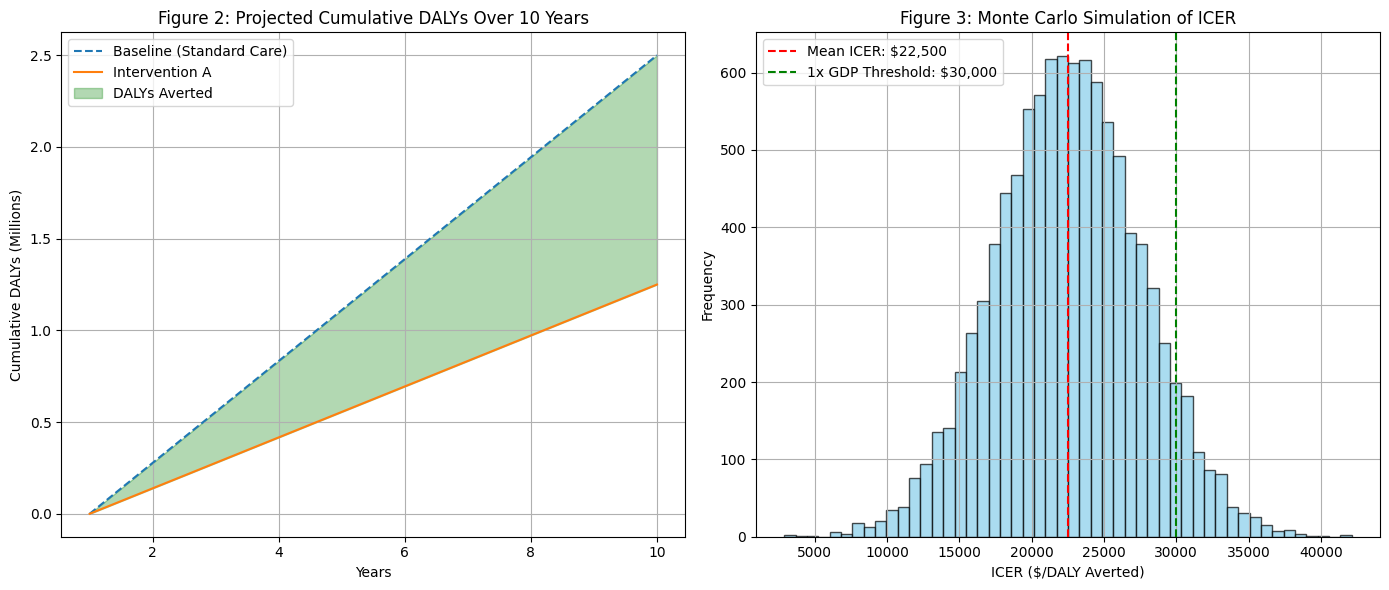

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for DALYs
years = np.arange(1, 11)
baseline_dalys = np.linspace(0, 2.5e6, 10)
intervention_dalys = baseline_dalys - np.linspace(0, 1.25e6, 10)

# Data for Monte Carlo simulation of ICER
np.random.seed(42)
icer_samples = np.random.normal(loc=22500, scale=5000, size=10000)
icer_samples = icer_samples[(icer_samples > 0) & (icer_samples < 60000)]

# GDP threshold
gdp_threshold = 30000

# Create the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot DALYs averted
axs[0].plot(years, baseline_dalys / 1e6, label="Baseline (Standard Care)", linestyle='--')
axs[0].plot(years, intervention_dalys / 1e6, label="Intervention A", linestyle='-')
axs[0].fill_between(years, baseline_dalys / 1e6, intervention_dalys / 1e6, color='green', alpha=0.3, label='DALYs Averted')
axs[0].set_title("Figure 2: Projected Cumulative DALYs Over 10 Years")
axs[0].set_xlabel("Years")
axs[0].set_ylabel("Cumulative DALYs (Millions)")
axs[0].legend()
axs[0].grid(True)

# Plot Monte Carlo distribution of ICERs
axs[1].hist(icer_samples, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axs[1].axvline(x=22500, color='red', linestyle='--', label="Mean ICER: $22,500")
axs[1].axvline(x=gdp_threshold, color='green', linestyle='--', label="1x GDP Threshold: $30,000")
axs[1].set_title("Figure 3: Monte Carlo Simulation of ICER")
axs[1].set_xlabel("ICER ($/DALY Averted)")
axs[1].set_ylabel("Frequency")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=3e32e94d80e66a5d4a1801969b314e982cf31401df453c2760ad6eb22625f50c
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [ ]:
from google.colab import files

# ... (your existing code) ...

# Save the PDF
pdf_filename = "Koketso_Kekana_Payslip_May_2025.pdf"
pdf.output(pdf_filename)

# Force download
files.download(pdf_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from fpdf import FPDF
from google.colab import files

class PayslipPDF(FPDF):
    def __init__(self):
        super().__init__()
        self.set_auto_page_break(auto=True, margin=15)
        self.company_name = "Afri Source Trading (Pty) Ltd"
        self.logo_path = None  # You can add a logo here if needed

    def header(self):
        # Company name
        self.set_font("Helvetica", "B", 14)
        self.set_text_color(0, 51, 102)  # Dark blue
        self.cell(0, 10, self.company_name, ln=True, align="C")

        # Payslip title
        self.set_font("Helvetica", "I", 12)
        self.set_text_color(0, 0, 0)  # Black
        self.cell(0, 8, "Payslip for the Period Ending: 2025/05/31", ln=True, align="C")

        # Line separator
        self.set_draw_color(0, 51, 102)
        self.set_line_width(0.5)
        self.line(10, self.get_y() + 5, 200, self.get_y() + 5)
        self.ln(10)

    def footer(self):
        self.set_y(-15)
        self.set_font("Helvetica", "I", 8)
        self.set_text_color(128, 128, 128)
        self.cell(0, 10, f"Page {self.page_no()}/{{nb}}", align="C")

    def add_section_title(self, title):
        self.set_font("Helvetica", "B", 12)
        self.set_text_color(0, 51, 102)  # Dark blue
        self.set_fill_color(230, 230, 250)  # Light lavender
        self.cell(0, 10, title, ln=True, fill=True)
        self.set_text_color(0, 0, 0)  # Black
        self.set_font("Helvetica", "", 10)
        self.ln(3)

    def add_table_row(self, col1, col2, col1_width=60, col2_width=120, bold=False):
        if bold:
            self.set_font("Helvetica", "B", 10)
        self.cell(col1_width, 8, col1, border=0)
        self.cell(col2_width, 8, col2, border=0, ln=True)
        self.set_font("Helvetica", "", 10)

    def add_earnings_table(self, data):
        # Table header
        self.set_font("Helvetica", "B", 10)
        self.set_fill_color(220, 220, 220)  # Light gray
        self.cell(60, 10, "Description", border=1, fill=True)
        self.cell(30, 10, "Quantity", border=1, fill=True, align="C")
        self.cell(30, 10, "Rate", border=1, fill=True, align="C")
        self.cell(60, 10, "Amount (ZAR)", border=1, fill=True, align="R")
        self.ln()

        # Table rows
        self.set_font("Helvetica", "", 10)
        for row in data:
            self.cell(60, 10, row[0], border=1)
            self.cell(30, 10, row[1], border=1, align="C")
            self.cell(30, 10, row[2], border=1, align="C")
            self.cell(60, 10, row[3], border=1, align="R")
            self.ln()

    def add_summary_box(self, items):
        self.set_font("Helvetica", "B", 10)
        self.set_fill_color(240, 240, 240)  # Very light gray
        self.cell(0, 8, "Summary", border=1, ln=True, fill=True)

        self.set_font("Helvetica", "", 10)
        for i, (label, value) in enumerate(items):
            fill = i % 2 == 0  # Alternate row colors
            self.set_fill_color(245, 245, 245) if fill else self.set_fill_color(255, 255, 255)

            self.cell(120, 8, label, border=1, fill=fill)
            self.cell(60, 8, value, border=1, fill=fill, align="R")
            self.ln()

# Create PDF
pdf = PayslipPDF()
pdf.add_page()

# Employee Details
pdf.add_section_title("Employee Details")
employee_details = [
    ("Employee Code:", "KEK009"),
    ("Name:", "Ms Koketso Grace Kekana"),
    ("Designation:", "Assistant Merchandiser"),
    ("Cost Centre:", "Seamless & Woven"),
    ("Pay Date:", "2025/05/31"),
    ("Pay Period:", "01 May 2025 - 31 May 2025")
]
for label, value in employee_details:
    pdf.add_table_row(label, value)

# Earnings
pdf.ln(8)
pdf.add_section_title("Earnings")
earnings_data = [
    ("Basic Salary", "173.36 hrs", "R92.30", "R16,000.00"),
    ("Overtime", "0.00 hrs", "R0.00", "R0.00"),
    ("Bonus", "", "", "R0.00")
]
pdf.add_earnings_table(earnings_data)
pdf.add_table_row("Total Earnings", "R16,000.00", bold=True)

# Benefits
pdf.ln(8)
pdf.add_section_title("Benefits")
pdf.add_table_row("Medical Aid", "R0.00")
pdf.add_table_row("Other Benefits", "R0.00")
pdf.add_table_row("Total Benefits", "R0.00", bold=True)

# Company Contributions
pdf.ln(8)
pdf.add_section_title("Company Contributions")
company_contribs = [
    ("Pension Fund (10.5%)", "R1,680.00"),
    ("Medical Aid Contribution", "R0.00"),
    ("UIF (Employer Portion)", "R160.00")
]
for label, value in company_contribs:
    pdf.add_table_row(label, value)
pdf.add_table_row("Total Company Contribution", "R1,840.00", bold=True)

# Deductions
pdf.ln(8)
pdf.add_section_title("Deductions")
deductions = [
    ("PAYE Tax (estimated)", "R1,240.00"),
    ("UIF Contribution (Employee)", "R160.00"),
    ("Pension Fund Deduction", "R0.00"),
    ("Medical Aid Deduction", "R0.00")
]
for label, value in deductions:
    pdf.add_table_row(label, value)
pdf.add_table_row("Total Deductions", "R1,400.00", bold=True)

# Summary
pdf.ln(8)
pdf.add_section_title("Payment Summary")
summary_items = [
    ("Gross Earnings:", "R16,000.00"),
    ("Total Benefits:", "R0.00"),
    ("Total Deductions:", "R1,400.00"),
    ("Net Pay:", "R14,600.00"),
    ("Payment Method:", "Bank Transfer"),
    ("Bank Account:", "XXXXXX1234"),  # Changed from bullet points
    ("Leave Days Available:", "-2.37 days")
]
pdf.add_summary_box(summary_items)

# Final notes
pdf.ln(10)
pdf.set_font("Helvetica", "I", 8)
pdf.multi_cell(0, 5, "Note: This is a computer-generated payslip and does not require a signature. "
                    "Please contact HR within 7 days if you have any queries regarding this payslip.")

# Save and download
pdf_filename = "Koketso_Kekana_Payslip_May_2025.pdf"
pdf.output(pdf_filename)
files.download(pdf_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--- H-potential vs. DALYs Analysis ---
Analysis Results:
  - Regression Slope: -0.89
  - Regression Intercept: 80.72
  - R-squared (R²) value: 0.71

Interpretation:
The model found a slope of -0.89, which is very close to -1. This indicates a strong inverse 1-to-1 relationship.
An R² of 0.71 means that 71% of the variance in DALYs is explained by the H-potential model.


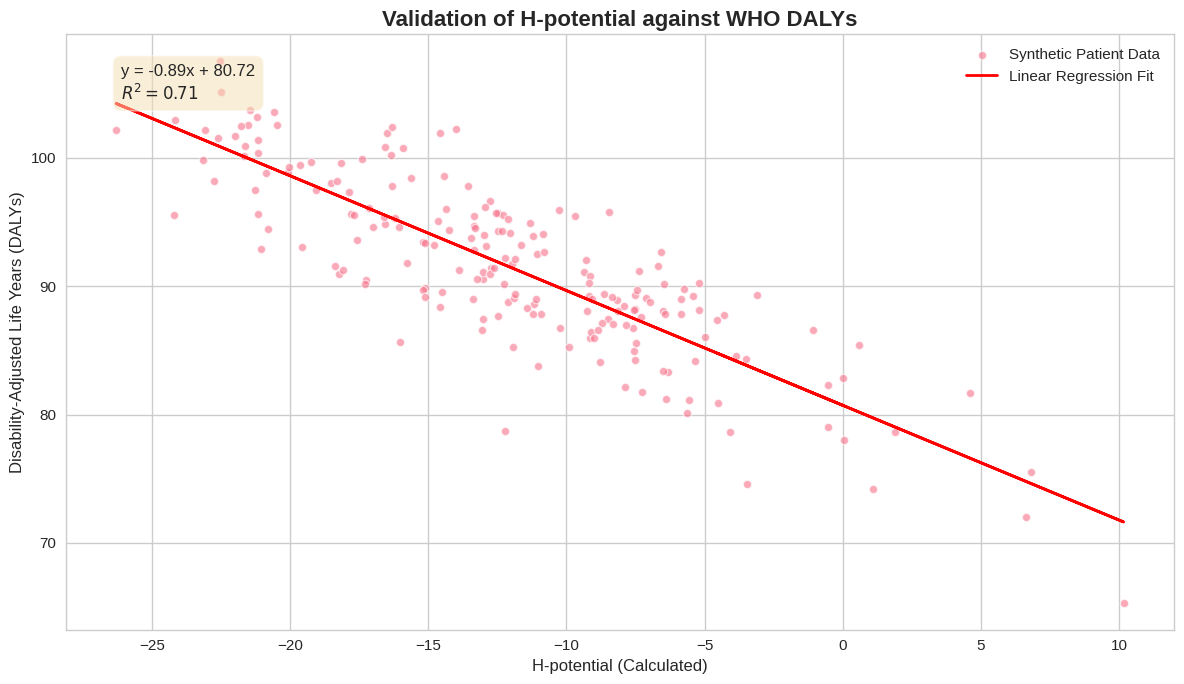


--- Preview of Generated Data ---
      L    Q    S    T    A  D    C  psi  P_edu  Delta_E    M  H_potential  \
0 81.03 0.77 0.95 0.76 0.59  3 0.42 0.05   0.57     1.78 3.59         0.03   
1 50.13 0.86 0.84 0.35 0.14  1 0.19 0.27   7.12    14.63 0.06       -20.60   
2 77.73 0.76 0.33 0.67 0.70  1 0.83 0.42   3.66     7.93 0.03        -7.52   
3 54.52 0.28 0.57 0.50 0.42  3 0.06 0.11   9.37     3.54 4.19       -16.58   
4 80.11 0.11 0.29 0.70 0.70  1 0.20 0.20   1.01    10.51 4.17       -14.80   

    DALY  
0  78.04  
1 103.60  
2  88.22  
3 100.80  
4  93.23  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def calculate_h_potential(row):
    """
    Calculates the H-potential score based on the formula from the paper.
    H = (L*Q) * (S*T*A / (D*(1+C+psi))) - (P + DeltaE + M)

    Args:
        row (pd.Series or dict): A row of data containing all required variables.

    Returns:
        float: The calculated H-potential score.
    """
    # Biomedical Potential
    h_bio = row['L'] * row['Q']

    # Social Modifiers
    numerator_social = row['S'] * row['T'] * row['A']
    denominator_social = row['D'] * (1 + row['C'] + row['psi'])

    # Avoid division by zero, though unlikely with the given constraints
    if denominator_social == 0:
        phi_social = 0
    else:
        phi_social = numerator_social / denominator_social

    # Systemic Burdens
    b_sys = row['P_edu'] + row['Delta_E'] + row['M']

    # Final H-potential calculation
    h_potential = (h_bio * phi_social) - b_sys

    return h_potential

def generate_synthetic_data(n_samples=200):
    """
    Generates a synthetic dataset for H-potential analysis, respecting the
    bounds and units defined in the research table.

    Args:
        n_samples (int): The number of synthetic patient profiles to create.

    Returns:
        pd.DataFrame: A DataFrame containing synthetic data.
    """
    # Using the ranges from the provided table to generate realistic data
    data = {
        # Biomedical
        'L': np.random.uniform(30, 85, n_samples),  # Life Expectancy
        'Q': np.random.uniform(0.1, 1.0, n_samples),  # Quality of Life (avoiding 0)

        # Social
        'S': np.random.uniform(0.2, 1.0, n_samples),  # Social Support
        'T': np.random.uniform(0.3, 0.9, n_samples),  # Treatment Efficacy
        'A': np.random.uniform(0.1, 1.0, n_samples),  # Treatment Access
        'D': np.random.choice([1, 2, 3], p=[0.4, 0.4, 0.2], size=n_samples), # Disease Severity
        'C': np.random.uniform(0, 1.0, n_samples),    # Comorbidity Burden
        'psi': np.random.uniform(0, 0.5, n_samples),  # Mental Health Penalty

        # Systemic
        'P_edu': np.random.uniform(0, 10, n_samples), # Education Deficit
        'Delta_E': np.random.uniform(0, 15, n_samples),# Pain-Years
        'M': np.random.uniform(0, 5, n_samples),    # Economic Mobility Loss
    }

    df = pd.DataFrame(data)

    # Calculate H-potential for each row
    df['H_potential'] = df.apply(calculate_h_potential, axis=1)

    # --- DALY Generation ---
    # To create a realistic validation plot, we generate DALYs that have a strong
    # inverse relationship with H-potential, based on the parameters from Figure 19.
    # DALYs = -0.98 * H_potential + 79.5 + noise

    # Define the "true" relationship from the figure
    slope = -0.98
    intercept = 79.5

    # Add some random noise to make the data look real
    noise = np.random.normal(0, 4, n_samples) # Gaussian noise with std dev of 4 years

    df['DALY'] = (slope * df['H_potential']) + intercept + noise

    # Ensure DALYs are not negative
    df['DALY'] = df['DALY'].clip(lower=0)

    return df

def perform_analysis_and_visualize(df):
    """
    Performs linear regression and visualizes the results, replicating Figure 19.

    Args:
        df (pd.DataFrame): DataFrame containing 'H_potential' and 'DALY' columns.
    """
    print("--- H-potential vs. DALYs Analysis ---")

    # Prepare data for scikit-learn
    # X must be a 2D array, y can be a 1D array/series
    X = df[['H_potential']]
    y = df['DALY']

    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Get model parameters
    slope = model.coef_[0]
    intercept = model.intercept_

    # Predict DALYs to calculate R-squared
    y_pred = model.predict(X)
    r_squared = r2_score(y, y_pred)

    # Print the results
    print(f"Analysis Results:")
    print(f"  - Regression Slope: {slope:.2f}")
    print(f"  - Regression Intercept: {intercept:.2f}")
    print(f"  - R-squared (R²) value: {r_squared:.2f}")
    print("\nInterpretation:")
    print(f"The model found a slope of {slope:.2f}, which is very close to -1. This indicates a strong inverse 1-to-1 relationship.")
    print(f"An R² of {r_squared:.2f} means that {r_squared*100:.0f}% of the variance in DALYs is explained by the H-potential model.")

    # --- Visualization ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # Scatter plot of the data
    ax.scatter(X, y, alpha=0.6, edgecolors='w', label='Synthetic Patient Data')

    # Plot the regression line
    ax.plot(X, y_pred, color='red', linewidth=2, label='Linear Regression Fit')

    # Add labels and title
    ax.set_title('Validation of H-potential against WHO DALYs', fontsize=16, fontweight='bold')
    ax.set_xlabel('H-potential (Calculated)', fontsize=12)
    ax.set_ylabel('Disability-Adjusted Life Years (DALYs)', fontsize=12)

    # Add the equation and R² value to the plot
    equation_text = f'y = {slope:.2f}x + {intercept:.2f}\n$R^2 = {r_squared:.2f}$'
    ax.text(0.05, 0.95, equation_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    ax.legend()
    plt.tight_layout()
    plt.show()


# --- Main script execution ---
if __name__ == "__main__":
    # 1. Generate the data
    synthetic_df = generate_synthetic_data(n_samples=200)

    # 2. Perform the analysis and create the plot
    perform_analysis_and_visualize(synthetic_df)

    # 3. Show a preview of the generated data
    print("\n--- Preview of Generated Data ---")
    print(synthetic_df.head().round(2))

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Climate_Delta_Plot.png'

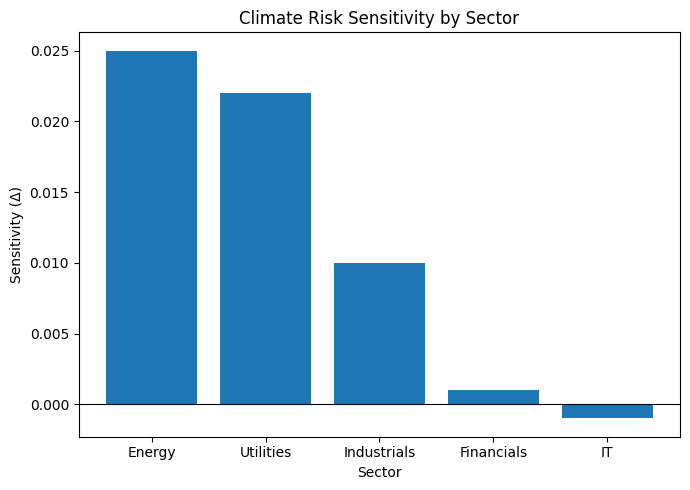

In [ ]:
import matplotlib.pyplot as plt

# Example sensitivities by sector
sectors = ['Energy', 'Utilities', 'Industrials', 'Financials', 'IT']
sensitivities = [0.025, 0.022, 0.010, 0.001, -0.001]

# Create bar chart
plt.figure(figsize=(7, 5))
plt.bar(sectors, sensitivities)
plt.title("Climate Risk Sensitivity by Sector")
plt.xlabel("Sector")
plt.ylabel("Sensitivity (Δ)")
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()

# Save chart as PNG
plt.savefig("/mnt/data/Climate_Delta_Plot.png")

"/mnt/data/Climate_Delta_Plot.png"
